In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
# Display the final graph
import openturns.viewer as viewer
import matplotlib.pyplot as plt
import trimesh as tr
from importlib import reload
from functools import partial

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output
from time import time
from sympy.printing import latex
from trimesh import viewer as trview
import sklearn

from scipy.optimize import OptimizeResult, minimize, basinhopping, differential_evolution, brute, shgo, check_grad, approx_fprime

import tqdm
import otaf

from gldpy import GLD

ot.Log.Show(ot.Log.NONE)
np.set_printoptions(suppress=True)
ar = np.array

# Notebook for the analysis of a system comprised of N + 2 parts, 2 plates with N = N1 x N2 holes, and N pins. 

### Defintion on global descriptive parameters

In [2]:
NX = 2 ## Number of holes on x axis
NY = 2 ## Number of holes on y axis
Dext = 20 ## Diameter of holes in mm
Dint = 19.8 ## Diameter of pins in mm
EH = 50 ## Distance between the hole axises
LB = 25 # Distance between border holes axis and edge.
hPlate = 30 #Height of the plates in mm
hPin = 60 #Height of the pins in mm

CIRCLE_RESOLUTION = 16 # NUmber of points to model the contour of the outer holes

### Defining and constructing the system data dictionary

The plates have NX * NY + 1 surfaces. The lower left point has coordinate 0,0,0

We only model the surfaces that are touching. 

In [3]:
N_PARTS = NX * NY * 2
LX = (NX - 1) * EH + 2*LB
LY = (NY - 1) * EH + 2*LB

contour_points = ar([[0,0,0],[LX,0,0],[LX,LY,0],[0,LY,0]])

R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

Frame1 = ar([z_,y_,-x_])
Frame2 = ar([-z_,y_,x_])

First we define the base part dictionaries for the upper and lower plate, without holes

In [4]:
system_data = {
    "PARTS" : {
        '0' : {
            "a" : {
                "FRAME": Frame1,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P1a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        },
        '1' : {
            "a" : {
                "FRAME": Frame2,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P0a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        }  
    },
    "LOOPS": {
        "COMPATIBILITY": {
        },
    },
    "GLOBAL_CONSTRAINTS": "3D",
}

Then we iterate over the pin dimensions NX and NY, and create the corresponding holes and pins. At the same time there is 1 loop per pin

In [5]:
alpha_gen = otaf.common.alphabet_generator()
next(alpha_gen) # skipping 'a' as it has already been used above
part_id = 2 # Start part index for pins
for i in range(NX):
    for j in range(NY):
        pcor = ar([LB+i*EH, LB+j*EH, 0]) # Point coordinate for hole / pins
        slab = next(alpha_gen) # Surface label, same for each mating pin so its easeir to track
        # Creating pin
        system_data["PARTS"][str(part_id)] = {}
        system_data["PARTS"][str(part_id)][slab] = {
            "FRAME": Frame1, # Frame doesn't really matter, as long as x is aligned on the axis
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dint / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P0{slab}", f"P1{slab}"], 
            "SURFACE_DIRECTION": "centrifugal",
            "CONSTRAINTS_D": ["PERFECT"], # No defects on the pins
            "BLOCK_ROTATIONS_G": 'x', # The pins do not rotate around their axis
            "BLOCK_TRANSLATIONS_G": 'x', # The pins do not slide along their axis
        }
        # Adding hole to part 0
        system_data["PARTS"]["0"][slab] = {
            "FRAME": Frame1,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"], 
            "SURFACE_DIRECTION": "centripetal",
        }
        # Adding hole to part 1
        system_data["PARTS"]["1"][slab] = {
            "FRAME": Frame2,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"],
            "SURFACE_DIRECTION": "centripetal",
        }
        # Construct Compatibility loop
        loop_id = f"L{part_id-1}"
        formater = lambda i,l : f"P{i}{l}{l.upper()}0" 
        system_data["LOOPS"]["COMPATIBILITY"][loop_id] = f"P0aA0 -> {formater(0,slab)} -> {formater(part_id,slab)} -> {formater(1,slab)} -> P1aA0"
        part_id += 1  

In [6]:
SDA = otaf.AssemblyDataProcessor(system_data)
SDA.generate_expanded_loops()

In [7]:
CLH = otaf.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [8]:
ILH = otaf.InterfaceLoopHandling(SDA, CLH, circle_resolution=CIRCLE_RESOLUTION)
interface_constraints = ILH.get_interface_loop_expressions()

Processing part 0, surface b for cylinder-to-cylinder interactions.
usedGMatDat [['0', 'b', 'B0', '2', 'b', 'B0']]
Found 1 used gap matrices.
unusedGMatDat [['0', 'b', 'B2', '2', 'b', 'B2'], ['0', 'b', 'B1', '2', 'b', 'B1']]
Found 2 unused gap matrices.
Matching used and unused gap matrices: GP0bB0P2bB0 with GP0bB2P2bB2
Matching used and unused gap matrices: GP0bB0P2bB0 with GP0bB1P2bB1
Generated 32 interaction equations for current matching.
Total interaction equations generated: 32
Processing part 0, surface c for cylinder-to-cylinder interactions.
usedGMatDat [['0', 'c', 'C0', '3', 'c', 'C0']]
Found 1 used gap matrices.
unusedGMatDat [['0', 'c', 'C1', '3', 'c', 'C1'], ['0', 'c', 'C2', '3', 'c', 'C2']]
Found 2 unused gap matrices.
Matching used and unused gap matrices: GP0cC0P3cC0 with GP0cC1P3cC1
Matching used and unused gap matrices: GP0cC0P3cC0 with GP0cC2P3cC2
Generated 32 interaction equations for current matching.
Total interaction equations generated: 32
Processing part 0, sur

In [9]:
SOCAM = otaf.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints
)

SOCAM.embedOptimizationVariable()

print(len(SOCAM.deviation_symbols), SOCAM.deviation_symbols)

32 [v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_2, w_d_2, beta_d_2, gamma_d_2, v_d_5, w_d_5, beta_d_5, gamma_d_5, v_d_7, w_d_7, beta_d_7, gamma_d_7, v_d_8, w_d_8, beta_d_8, gamma_d_8, v_d_10, w_d_10, beta_d_10, gamma_d_10, v_d_11, w_d_11, beta_d_11, gamma_d_11, v_d_13, w_d_13, beta_d_13, gamma_d_13]


## Construction of the stochastic model of the defects. (old lambda approach)

In [10]:
tol = 0.1 * np.sqrt(2)
Cm = 1  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hPlate
sigma_e_theta = (2 * theta_max) / (6 * Cm)

In [11]:
RandDeviationVect = otaf.distribution.get_composed_normal_defect_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})
dim_devs = int(RandDeviationVect.getDimension())

# Instead of using a surrogate and using big samples, now we'll fit a GLD on a small sample of the slack to estimate the probability of failure.

## Now lets first to a double loop monte-carlo to explore the full space of the parameters (using the intermediate lambda space) and the stochastic space, to be able to draw the full P-Box of the slack

### The below sampling approach we used previously is absoluetly false for a cylindrical feature. The constraint function on the 4 degrees of freedom is λu2​+λv2​+λα2​+λβ2​+2(λu​λα​+λv​λβ​)−1=0.

In [12]:
# Big sample in the space of the lambdas (parameters).
D_lambd = len(SOCAM.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, SOCAM.deviation_symbols)))
N_lambda = 20
lambda_sample_unconditioned = otaf.sampling.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, 999)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.sampling.condition_lambda_sample(lambda_sample_random, squared_sum=True)

In [13]:
e(èi)

NameError: name 'e' is not defined

## Dual loop monte carlo with GLD 

In [14]:
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = 20000 #int(1e6) #1e4
s_values = np.zeros((N_lambda, SIZE_MC_PF)) # For each MC point we have a s value
GLD_parameters = [] # We need the parameters of the generalized lambda distribution.
failure_probabilities = []
# Generalized lambda distribution object for fitting
gld = GLD('VSL')

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        fp = failure_probabilities
        print(f"Failure probability i-1 : {fp[i-1]}, Min: {min(fp)}, / Max: {max(fp)}")
        print("s_mean: ", s_values.mean().round(3), "s_min: ", np.nanmin(s_values).round(3), "s_max: ", np.nanmax(s_values).round(3))

    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * np.array(
        lambda_sample_conditioned[i]
    )
    optimizations = otaf.uncertainty.compute_gap_optimizations_on_sample(
            SOCAM,
            deviation_samples,
            bounds=bounds,
            n_cpu=-1,
            progress_bar=True,
        )
    
    slack = np.array([opt.fun for opt in optimizations], dtype=float)*-1 #Normally there aren"t any nans.
    s_values[i,:] = slack
    GLD_parameters.append(gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False))
    failure_probabilities.append(gld.CDF_num(0, GLD_parameters[i]))


print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

Doing iteration 0 of 20


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 1 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.003 s_min:  0.0 s_max:  0.089


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 2 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.007 s_min:  0.0 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 3 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.01 s_min:  0.0 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 4 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.013 s_min:  0.0 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 5 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.016 s_min:  0.0 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 6 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.02 s_min:  0.0 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 7 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.023 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 8 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.026 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 9 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.029 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 10 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.033 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 11 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.036 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 12 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.039 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 13 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.042 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 14 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.046 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 15 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.049 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 16 of 20
Failure probability i-1 : [0.00000596], Min: [0.00000596], / Max: [0.00000596]
s_mean:  0.052 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 17 of 20
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00000596]
s_mean:  0.056 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 18 of 20
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00000596]
s_mean:  0.059 s_min:  -0.001 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Doing iteration 19 of 20
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00000596]
s_mean:  0.062 s_min:  -0.003 s_max:  0.091


  0%|          | 0/20000 [00:00<?, ?it/s]

Done 20 experiments.
Elapsed time: 597.429 seconds.


In [15]:
X = otaf.sampling.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

In [16]:
distributions = [ot.UserDefined(ot.Sample(s[:,np.newaxis])) for s in s_values]
x_min, x_max = -0.03, 0.11
sup_data, inf_data = otaf.distribution.compute_sup_inf_distributions(distributions, x_min, x_max)

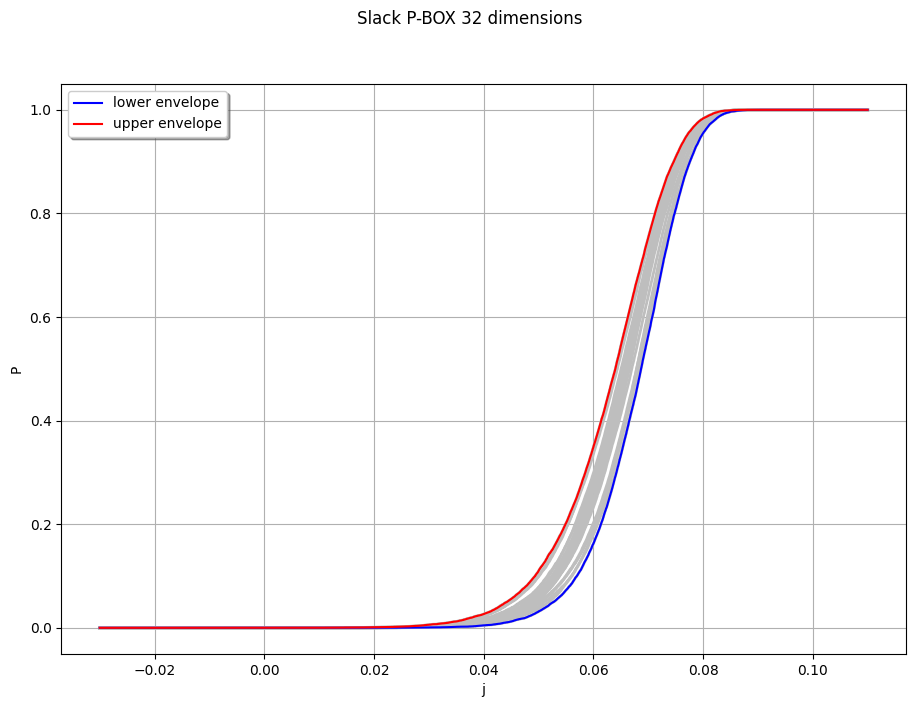

In [17]:
# Initialize colors and legends for each lambda sample
colors = [["grey"]] * lambda_sample_conditioned.getSize()
legends = [""] * lambda_sample_conditioned.getSize()

# Plot the combined CDF with additional curves for the envelopes
graph_full = otaf.plotting.plot_combined_CDF(distributions, x_min, x_max, colors, legends)
graph_full = otaf.plotting.set_graph_legends(
    graph_full,
    x_title="j",
    y_title="P",
    title="Slack P-BOX 32 dimensions",
    legends=legends
)

# Add the upper and lower envelopes to the graph
graph_full.add(ot.Curve(inf_data, "blue", "solid", 1.5, "lower envelope"))
graph_full.add(ot.Curve(sup_data, "red", "solid", 1.5, "upper envelope"))
view = viewer.View(graph_full, pixelsize=(1100, 750))

In [18]:
min(failure_probabilities)

array([0.])

# Now we'll use the other lambda modelization, a bit more difficutl to sample

In [19]:
# All the extremal values for lambda, in 32 dimensions :


In [20]:
lambda_limit_sample = otaf.sampling.generate_imprecise_probabilistic_samples([4]*8, -1, discretization=1)
lambda_limit_sample_sub_choice = [next(lambda_limit_sample) for _ in range(60000)]
lambda_limit_sample_sub_choice = np.stack(lambda_limit_sample_sub_choice)
print(lambda_limit_sample_sub_choice.shape)

(60000, 32)


In [21]:
from scipy.optimize import fsolve
def solve_for_lambda_beta(lambda_u, lambda_v, lambda_alpha):
    """
    Solve the equation for lambda_beta given lambda_u, lambda_v, and lambda_alpha.
    """
    def equation(lambda_beta):
        return (lambda_u**2 + lambda_v**2 + lambda_alpha**2 + lambda_beta**2 +
                2 * (lambda_u * lambda_alpha + lambda_v * lambda_beta) - 1)
    
    # Use a root-finding method to solve for lambda_beta
    lambda_beta_initial_guess = 0.5
    lambda_beta_solution = fsolve(equation, lambda_beta_initial_guess)[0]
    
    return lambda_beta_solution

def generate_points_on_surface(num_points=1000):
    """
    Generate points on the surface by solving for lambda_beta
    given random values for lambda_u, lambda_v, and lambda_alpha.
    
    Returns:
    - A numpy array of shape (num_valid_points, 4) where each row is 
      (lambda_u, lambda_v, lambda_alpha, lambda_beta).
    """
    # Generate random values for lambda_u, lambda_v, lambda_alpha in [0, 1]
    lambda_u = np.random.rand(num_points)
    lambda_v = np.random.rand(num_points)
    lambda_alpha = np.random.rand(num_points)
    
    # Assume lambda_beta = 0 and check if the inequality is satisfied
    inequality_values = lambda_u**2 + lambda_v**2 + lambda_alpha**2 + 2 * (lambda_u * lambda_alpha)

    # Filter valid points where inequality holds
    valid_mask = inequality_values <= 1
    lambda_u_valid = lambda_u[valid_mask]
    lambda_v_valid = lambda_v[valid_mask]
    lambda_alpha_valid = lambda_alpha[valid_mask]
    
    # Solve for lambda_beta for valid points
    lambda_beta_valid = np.array([solve_for_lambda_beta(u, v, a) 
                                  for u, v, a in zip(lambda_u_valid, lambda_v_valid, lambda_alpha_valid)])

    # Only keep points where the solved lambda_beta is between 0 and 1
    final_mask = (lambda_beta_valid >= 0) & (lambda_beta_valid <= 1)
    final_points = np.vstack((lambda_u_valid[final_mask],
                              lambda_v_valid[final_mask],
                              lambda_alpha_valid[final_mask],
                              lambda_beta_valid[final_mask])).T
    
    return final_points

# Generate the points on the surface
points = generate_points_on_surface(num_points=20000)

# Call the pair_plot function (assuming it's already defined)
labels = ['lambda_u', 'lambda_v', 'lambda_alpha', 'lambda_beta']
#otaf.plotting.pair_plot(points, labels)

In [22]:
random_lambda_sample = [points[np.random.choice(points.shape[0], 200, replace=False)] for _ in range(8)]

In [23]:
random_lambda_sample = np.hstack(random_lambda_sample)

In [24]:
random_lambda_sample.shape

(200, 32)

In [25]:
N_lambda = random_lambda_sample.shape[0]
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = 10000 #int(1e6) #1e4
s_values = np.zeros((N_lambda, SIZE_MC_PF)) # For each MC point we have a s value
GLD_parameters = [] # We need the parameters of the generalized lambda distribution.
failure_probabilities = []
# Generalized lambda distribution object for fitting
gld = GLD('VSL')

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        fp = failure_probabilities
        print(f"Failure probability i-1 : {fp[i-1]}, Min: {min(fp)}, / Max: {max(fp)}")
        print("s_mean: ", s_values.mean().round(3), "s_min: ", np.nanmin(s_values).round(3), "s_max: ", np.nanmax(s_values).round(3))

    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * random_lambda_sample[i]
    optimizations = otaf.uncertainty.compute_gap_optimizations_on_sample(
            SOCAM,
            deviation_samples,
            bounds=bounds,
            n_cpu=-1,
            progress_bar=True,
        )
    
    slack = np.array([opt.fun for opt in optimizations], dtype=float)*-1 #Normally there aren"t any nans.
    s_values[i,:] = slack
    GLD_parameters.append(gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False))
    failure_probabilities.append(gld.CDF_num(0, GLD_parameters[i]))


print(f"Done {N_lambda} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

Doing iteration 0 of 200


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 1 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.]
s_mean:  0.0 s_min:  0.0 s_max:  0.092


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 2 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00000596]
s_mean:  0.001 s_min:  0.0 s_max:  0.093


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 3 of 200
Failure probability i-1 : [0.00012315], Min: [0.], / Max: [0.00012315]
s_mean:  0.001 s_min:  -0.004 s_max:  0.093


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 4 of 200
Failure probability i-1 : [0.00005868], Min: [0.], / Max: [0.00012315]
s_mean:  0.001 s_min:  -0.004 s_max:  0.093


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 5 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00012315]
s_mean:  0.002 s_min:  -0.004 s_max:  0.093


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 6 of 200
Failure probability i-1 : [0.00003752], Min: [0.], / Max: [0.00012315]
s_mean:  0.002 s_min:  -0.004 s_max:  0.093


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 7 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00012315]
s_mean:  0.002 s_min:  -0.004 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 8 of 200
Failure probability i-1 : [0.00040135], Min: [0.], / Max: [0.00040135]
s_mean:  0.003 s_min:  -0.009 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 9 of 200
Failure probability i-1 : [0.00006277], Min: [0.], / Max: [0.00040135]
s_mean:  0.003 s_min:  -0.009 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 10 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00040135]
s_mean:  0.004 s_min:  -0.009 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 11 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00040135]
s_mean:  0.004 s_min:  -0.009 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 12 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00040135]
s_mean:  0.004 s_min:  -0.009 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 13 of 200
Failure probability i-1 : [0.00092938], Min: [0.], / Max: [0.00092938]
s_mean:  0.005 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 14 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.005 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 15 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00092938]
s_mean:  0.005 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 16 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.006 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 17 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.006 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 18 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.006 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 19 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.007 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 20 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.007 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 21 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00092938]
s_mean:  0.007 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 22 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.008 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 23 of 200
Failure probability i-1 : [0.00029783], Min: [0.], / Max: [0.00092938]
s_mean:  0.008 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 24 of 200
Failure probability i-1 : [0.00009137], Min: [0.], / Max: [0.00092938]
s_mean:  0.008 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 25 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.009 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 26 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.009 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 27 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.01 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 28 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.01 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 29 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.01 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 30 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.011 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 31 of 200
Failure probability i-1 : [0.00017307], Min: [0.], / Max: [0.00092938]
s_mean:  0.011 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 32 of 200
Failure probability i-1 : [0.00001894], Min: [0.], / Max: [0.00092938]
s_mean:  0.011 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 33 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.012 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 34 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.012 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 35 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.012 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 36 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.013 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 37 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.013 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 38 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.013 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 39 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.014 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 40 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00092938]
s_mean:  0.014 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 41 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.014 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 42 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.015 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 43 of 200
Failure probability i-1 : [0.00026573], Min: [0.], / Max: [0.00092938]
s_mean:  0.015 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 44 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.016 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 45 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.016 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 46 of 200
Failure probability i-1 : [0.00008933], Min: [0.], / Max: [0.00092938]
s_mean:  0.016 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 47 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.017 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 48 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.017 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 49 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.017 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 50 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.018 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 51 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.018 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 52 of 200
Failure probability i-1 : [0.000157], Min: [0.], / Max: [0.00092938]
s_mean:  0.018 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 53 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.019 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 54 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.019 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 55 of 200
Failure probability i-1 : [0.00016628], Min: [0.], / Max: [0.00092938]
s_mean:  0.02 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 56 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.02 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 57 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.02 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 58 of 200
Failure probability i-1 : [0.00009188], Min: [0.], / Max: [0.00092938]
s_mean:  0.021 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 59 of 200
Failure probability i-1 : [0.00005225], Min: [0.], / Max: [0.00092938]
s_mean:  0.021 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 60 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00092938]
s_mean:  0.021 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 61 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00092938]
s_mean:  0.022 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 62 of 200
Failure probability i-1 : [0.00001561], Min: [0.], / Max: [0.00092938]
s_mean:  0.022 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 63 of 200
Failure probability i-1 : [0.00135162], Min: [0.], / Max: [0.00135162]
s_mean:  0.022 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 64 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.023 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 65 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.023 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 66 of 200
Failure probability i-1 : [0.00069351], Min: [0.], / Max: [0.00135162]
s_mean:  0.023 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 67 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.024 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 68 of 200
Failure probability i-1 : [0.00006277], Min: [0.], / Max: [0.00135162]
s_mean:  0.024 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 69 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.025 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 70 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.025 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 71 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.025 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 72 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.026 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 73 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.026 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 74 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.026 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 75 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.027 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 76 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.027 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 77 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.027 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 78 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.028 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 79 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.028 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 80 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.028 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 81 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.029 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 82 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.029 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 83 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.03 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 84 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.03 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 85 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.03 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 86 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.031 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 87 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.031 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 88 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.031 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 89 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.032 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 90 of 200
Failure probability i-1 : [0.00007567], Min: [0.], / Max: [0.00135162]
s_mean:  0.032 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 91 of 200
Failure probability i-1 : [0.00010696], Min: [0.], / Max: [0.00135162]
s_mean:  0.032 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 92 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.033 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 93 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.033 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 94 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.033 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 95 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.034 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 96 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.034 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 97 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.034 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 98 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.035 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 99 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.035 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 100 of 200
Failure probability i-1 : [0.00002192], Min: [0.], / Max: [0.00135162]
s_mean:  0.035 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 101 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.036 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 102 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.036 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 103 of 200
Failure probability i-1 : [0.0001845], Min: [0.], / Max: [0.00135162]
s_mean:  0.037 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 104 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.037 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 105 of 200
Failure probability i-1 : [0.00004086], Min: [0.], / Max: [0.00135162]
s_mean:  0.037 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 106 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.038 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 107 of 200
Failure probability i-1 : [0.00010696], Min: [0.], / Max: [0.00135162]
s_mean:  0.038 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 108 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.038 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 109 of 200
Failure probability i-1 : [0.00003278], Min: [0.], / Max: [0.00135162]
s_mean:  0.039 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 110 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.039 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 111 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.039 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 112 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.04 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 113 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.04 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 114 of 200
Failure probability i-1 : [0.00001561], Min: [0.], / Max: [0.00135162]
s_mean:  0.04 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 115 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.041 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 116 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.041 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 117 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.042 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 118 of 200
Failure probability i-1 : [0.00003752], Min: [0.], / Max: [0.00135162]
s_mean:  0.042 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 119 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.042 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 120 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.043 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 121 of 200
Failure probability i-1 : [0.00014202], Min: [0.], / Max: [0.00135162]
s_mean:  0.043 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 122 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.043 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 123 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.044 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 124 of 200
Failure probability i-1 : [0.00002525], Min: [0.], / Max: [0.00135162]
s_mean:  0.044 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 125 of 200
Failure probability i-1 : [0.00005944], Min: [0.], / Max: [0.00135162]
s_mean:  0.044 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 126 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.045 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 127 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.045 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 128 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.045 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 129 of 200
Failure probability i-1 : [0.00003752], Min: [0.], / Max: [0.00135162]
s_mean:  0.046 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 130 of 200
Failure probability i-1 : [0.00015426], Min: [0.], / Max: [0.00135162]
s_mean:  0.046 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 131 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.046 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 132 of 200
Failure probability i-1 : [0.00008487], Min: [0.], / Max: [0.00135162]
s_mean:  0.047 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 133 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.047 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 134 of 200
Failure probability i-1 : [0.00002192], Min: [0.], / Max: [0.00135162]
s_mean:  0.047 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 135 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.048 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 136 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.048 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 137 of 200
Failure probability i-1 : [0.00001894], Min: [0.], / Max: [0.00135162]
s_mean:  0.049 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 138 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.049 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 139 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.049 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 140 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.05 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 141 of 200
Failure probability i-1 : [0.00002525], Min: [0.], / Max: [0.00135162]
s_mean:  0.05 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 142 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.05 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 143 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.051 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 144 of 200
Failure probability i-1 : [0.00012972], Min: [0.], / Max: [0.00135162]
s_mean:  0.051 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 145 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.051 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 146 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.052 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 147 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.052 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 148 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.052 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 149 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.053 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 150 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.053 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 151 of 200
Failure probability i-1 : [0.00003419], Min: [0.], / Max: [0.00135162]
s_mean:  0.053 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 152 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.054 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 153 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.054 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 154 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.054 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 155 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.055 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 156 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.055 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 157 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.055 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 158 of 200
Failure probability i-1 : [0.00002858], Min: [0.], / Max: [0.00135162]
s_mean:  0.056 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 159 of 200
Failure probability i-1 : [0.00002192], Min: [0.], / Max: [0.00135162]
s_mean:  0.056 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 160 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.057 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 161 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.057 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 162 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.057 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 163 of 200
Failure probability i-1 : [0.00008179], Min: [0.], / Max: [0.00135162]
s_mean:  0.058 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 164 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.058 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 165 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.058 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 166 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.059 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 167 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.059 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 168 of 200
Failure probability i-1 : [0.00005913], Min: [0.], / Max: [0.00135162]
s_mean:  0.059 s_min:  -0.02 s_max:  0.094


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 169 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.06 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 170 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.06 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 171 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.06 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 172 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.061 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 173 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.061 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 174 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.062 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 175 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.062 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 176 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.062 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 177 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.063 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 178 of 200
Failure probability i-1 : [0.00001561], Min: [0.], / Max: [0.00135162]
s_mean:  0.063 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 179 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.063 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 180 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.064 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 181 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.064 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 182 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.064 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 183 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.065 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 184 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.065 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 185 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.065 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 186 of 200
Failure probability i-1 : [0.00009397], Min: [0.], / Max: [0.00135162]
s_mean:  0.066 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 187 of 200
Failure probability i-1 : [0.00007309], Min: [0.], / Max: [0.00135162]
s_mean:  0.066 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 188 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.066 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 189 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.067 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 190 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.067 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 191 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.068 s_min:  -0.02 s_max:  0.094


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 192 of 200
Failure probability i-1 : [0.0000731], Min: [0.], / Max: [0.00135162]
s_mean:  0.068 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 193 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.068 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 194 of 200
Failure probability i-1 : [0.00000964], Min: [0.], / Max: [0.00135162]
s_mean:  0.069 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 195 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.069 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 196 of 200
Failure probability i-1 : [0.00000596], Min: [0.], / Max: [0.00135162]
s_mean:  0.069 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 197 of 200
Failure probability i-1 : [0.], Min: [0.], / Max: [0.00135162]
s_mean:  0.07 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 198 of 200
Failure probability i-1 : [0.00001561], Min: [0.], / Max: [0.00135162]
s_mean:  0.07 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

Doing iteration 199 of 200
Failure probability i-1 : [0.00005719], Min: [0.], / Max: [0.00135162]
s_mean:  0.07 s_min:  -0.02 s_max:  0.095


  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: object of type 'int' has no len()

In [26]:
X = otaf.sampling.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

In [27]:
distributions = [ot.UserDefined(ot.Sample(s[:,np.newaxis])) for s in s_values]
x_min, x_max = -0.03, 0.11
sup_data, inf_data = otaf.distribution.compute_sup_inf_distributions(distributions, x_min, x_max)

In [28]:
%matplotlib inline

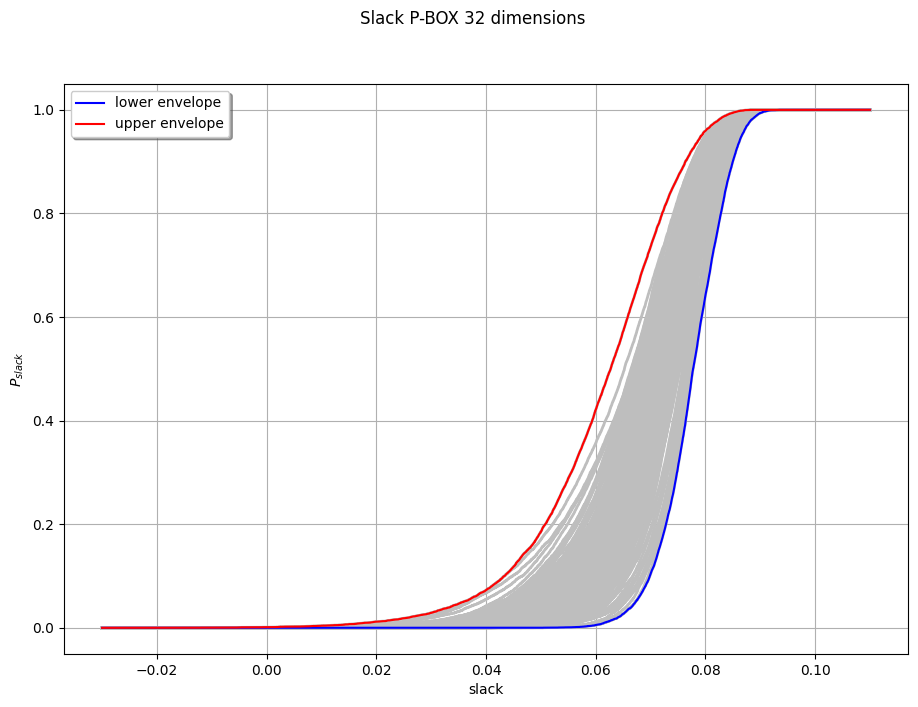

In [29]:
# Initialize colors and legends for each lambda sample
colors = [["grey"]] * N_lambda
legends = [""] * N_lambda

# Plot the combined CDF with additional curves for the envelopes
graph_full = otaf.plotting.plot_combined_CDF(distributions, x_min, x_max, colors, legends)
graph_full = otaf.plotting.set_graph_legends(
    graph_full,
    x_title="slack",
    y_title="$P_{slack}$",
    title="Slack P-BOX 32 dimensions",
    legends=legends
)

# Add the upper and lower envelopes to the graph
graph_full.add(ot.Curve(inf_data, "blue", "solid", 1.5, "lower envelope"))
graph_full.add(ot.Curve(sup_data, "red", "solid", 1.5, "upper envelope"))
view = viewer.View(graph_full, pixelsize=(1100, 750))

Text(0.5, 1.0, 'Slack P-Box 3D Assembly 32D')

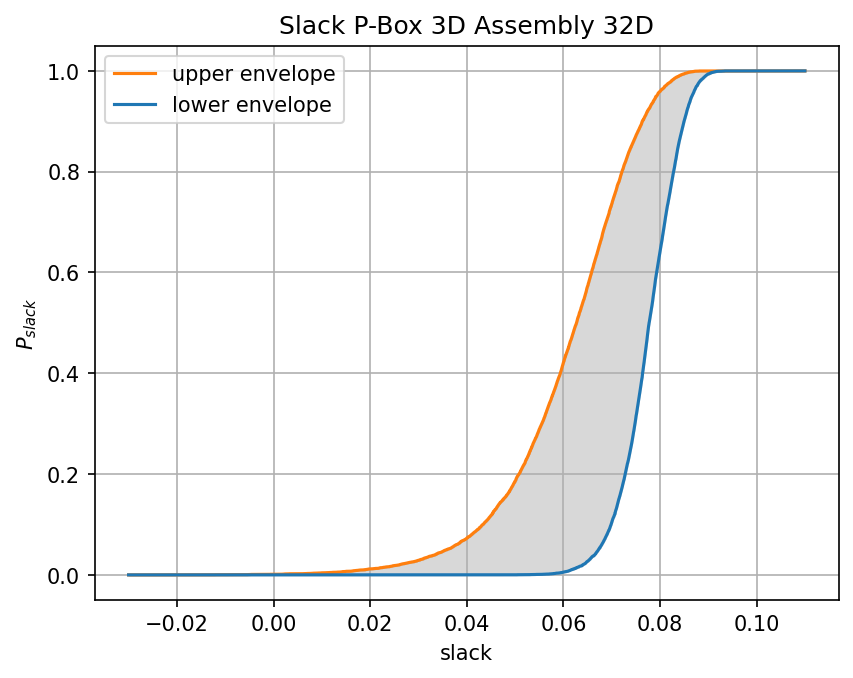

In [30]:
# %matplotlib qt
fig = plt.figure(dpi=150)

ax = fig.add_subplot(1, 1, 1)
ax.plot(sup_data[:, 0], sup_data[:, 1], color="tab:orange", label="upper envelope")
ax.plot(inf_data[:, 0], inf_data[:, 1], color="tab:blue", label="lower envelope")
ax.grid(True)
ax.fill_between(
    inf_data[:, 0], inf_data[:, 1], sup_data[:, 1], color="gray", alpha=0.3
)
ax.set_xlabel("slack")
ax.set_ylabel("$P_{slack}$")
ax.legend()
ax.set_title("Slack P-Box 3D Assembly 32D")

In [31]:
print(f"Minimum failure probability: {np.min(failure_probabilities):.5e}, Maximum failure probability: {np.max(failure_probabilities):.5e}")

Minimum failure probability: 0.00000e+00, Maximum failure probability: 1.35162e-03


# Global optimization basinhopping with GLD

In [32]:
SIZE_MC_PF = 10000 #int(1e6) #1e4
sample_gld = np.array(RandDeviationVect.getSample(SIZE_MC_PF))
scale_factor = 1.0
GLD_parameters = [] # We need the parameters of the generalized lambda distribution.

# Generalized lambda distribution object for fitting
gld = GLD('VSL')

def model_base(x, sample=sample_gld):
    # Model without surrogate, to get slack
    x = sample * np.sqrt(x[np.newaxis, :])
    optimization_variables = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        constraint_matrix_generator=SOCAM,
        deviation_array=x,
        batch_size=500,
        n_cpu=-1,
        progress_bar=True,
        verbose=0,
        dtype="float32",
    )
    slack_values = optimization_variables[:,-1]
    return slack_values

@otaf.optimization.scaling(scale_factor)
def optimization_function_mini(x, model=model_base):
    # Here we search the minimal probability of failure
    slack = model(x)
    gld_params = gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False)
    if np.any(np.isnan(gld_params)):
        failure_probability = np.where(slack<0,1,0).mean()
    else :
        print("gld_params:", gld_params)
        failure_probability = gld.CDF_num(0, gld_params)
    return failure_probability

@otaf.optimization.scaling(scale_factor)
def optimization_function_maxi(x, model=model_base):
    # Here we search the maximal probability of failure so negative output
    slack = model(x)
    gld_params = gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False)
    if np.any(np.isnan(gld_params)):
        failure_probability = np.where(slack<0,1,0).mean()
    else :
        print("gld_params:", gld_params)
        failure_probability = gld.CDF_num(0, gld_params)
    return failure_probability*-1

In [33]:
import numpy as np
import scipy.optimize

def cylinder_feature_constraint(la):
    """Evaluates the cylinder constraint for a given lambda array."""
    sum_squares = np.dot(la, la)  # Equivalent to la[0]**2 + la[1]**2 + la[2]**2 + la[3]**2
    cross_terms = 2 * (la[0] * la[2] + la[1] * la[3])
    return sum_squares + cross_terms - 1

def cylinder_feature_constraint_jacobian(la):
    """Computes the analytical Jacobian of the cylinder feature constraint."""
    u, v, alpha, beta = la
    return np.array([
        2 * u + 2 * alpha,  # df/du
        2 * v + 2 * beta,   # df/dv
        2 * alpha + 2 * u,  # df/dalpha
        2 * beta + 2 * v    # df/dbeta
    ])

def assembly_feature_constraint(la8):
    """Applies the cylinder constraint to each 4-element slice of the lambda array, returning a vector of constraints."""
    return np.array([cylinder_feature_constraint(la8[i : i + 4]) for i in range(0, len(la8), 4)])

def assembly_feature_constraint_jacobian(la8):
    """Constructs the Jacobian matrix for the vector of constraints, with each row representing the Jacobian of one cylinder constraint."""
    # Initialize a list to hold each constraint's Jacobian as a row in the matrix
    jacobian = []
    # Compute Jacobian for each 4-element segment in the lambda array
    for i in range(0, len(la8), 4):
        row_jacobian = np.zeros(len(la8))  # Create a zeroed row of the appropriate length
        row_jacobian[i:i+4] = cylinder_feature_constraint_jacobian(la8[i:i+4])
        jacobian.append(row_jacobian)
    return np.array(jacobian)


def cylinder_feature_constraint_hessian(la):
    """Computes the Hessian of the cylinder constraint for a given 4-element lambda array."""
    # Extract variables for readability
    u, v, alpha, beta = la
    # The Hessian matrix is symmetric, so we only need to define the unique elements
    hessian = np.array([
        [2, 0, 2, 0],  # d^2f/du^2, d^2f/du dv, d^2f/du dalpha, d^2f/du dbeta
        [0, 2, 0, 2],  # d^2f/dv du, d^2f/dv^2, d^2f/dv dalpha, d^2f/dv dbeta
        [2, 0, 2, 0],  # d^2f/dalpha du, d^2f/dalpha dv, d^2f/dalpha^2, d^2f/dalpha dbeta
        [0, 2, 0, 2]   # d^2f/dbeta du, d^2f/dbeta dv, d^2f/dbeta dalpha, d^2f/dbeta^2
    ])
    return hessian

def assembly_feature_constraint_hessian(la8):
    """Constructs the full Hessian matrix for the vector of constraints in the assembly."""
    n_constraints = len(la8) // 4
    hessian_blocks = []
    
    # Build the Hessian by iterating over each 4-element segment
    for i in range(n_constraints):
        block_hessian = cylinder_feature_constraint_hessian(la8[i*4:i*4+4])
        # Place the block into the full Hessian matrix for the constraint function
        block_hessian_expanded = np.zeros((len(la8), len(la8)))
        block_hessian_expanded[i*4:i*4+4, i*4:i*4+4] = block_hessian
        hessian_blocks.append(block_hessian_expanded)
    
    # Sum the block Hessians to form the full Hessian matrix
    full_hessian = np.sum(hessian_blocks, axis=0)
    return full_hessian

# Define the nonlinear constraint with the updated vector-valued function and Jacobian
nonLinearConstraint = scipy.optimize.NonlinearConstraint(
    fun=assembly_feature_constraint,
    lb=0.0,
    ub=0.0,
    jac=assembly_feature_constraint_jacobian,
    #hess=assembly_feature_constraint_hessian
)

In [34]:
# Basinhopping for the maximization function using COBYQA
x0_maxi = [0.25] * RandDeviationVect.getDimension()  # Initial guess

# Update minimizer_kwargs_maxi to use COBYQA
minimizer_kwargs_maxi = {
    "method": "COBYQA",   # Use COBYQA method
    "jac": False,         # COBYQA doesn't use Jacobians
    "args": (model_base,),     # Update args to match COBYQA requirements
    "constraints": nonLinearConstraint,
    "bounds": scipy.optimize.Bounds(lb=0.0,ub=1.0),
    "options": {
        "f_target": -0.2, 
        "maxiter": 1000,
        "maxfev": 4000,
        "feasibility_tol": 1e-3,
        "initial_tr_radius": 1,
        "final_tr_radius": 1e-2,
        "disp": True
    }
}

# Running basinhopping with COBYQA as the local optimizer
res_maxi = basinhopping(
    optimization_function_maxi, x0_maxi,
    niter=5,
    T=1,
    stepsize=3.0,
    niter_success=19,
    interval=5,
    minimizer_kwargs=minimizer_kwargs_maxi,
    disp=True,
    #take_step=step_taking,
    #accept_test=accept_test,
    #callback=callback
)

print("Maximization Result with COBYQA:")
print(res_maxi)

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.01.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



  0%|          | 0/10000 [00:00<?, ?it/s]

wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:1026: RuntimeWarning: invalid value encountered in scalar divide
  return l1,l2,l3/l2,l4/l2
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:1026: RuntimeWarning: divide by zero encountered in scalar divide
  return l1,l2,l3/l2,l4/l2
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:1095: RuntimeWarning: invalid value encountered in scalar add
  if a4**2+98*a4 +1 <0:
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:1097: RuntimeWarning: invalid value encountered in scalar add
  p4 = np.array([(3+7*a4 + np.sqrt(a4**2+98*a4 +1))/(2*(1-a4)), (3+7*a4 - np.sqrt(a4**2+98*a4 +1))/(2*(1-a4))])


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09925761 0.0038301  0.07997545 0.24389702]
wrapper([ 5.000e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-7.500e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09922339 0.00377394 0.0841997  0.22311687]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [-7.500e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09697026 0.01532974 0.08342547 0.23950607]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-7.500e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09699281 0.01512518 0.07960722 0.23586847]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-7.500e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09937348 0.00378841 0.06684021 0.24076998]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -7.500e-01 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09936329 0.00390675 0.06793151 0.26242178]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -7.500e-01 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09717764 0.01577454 0.07589164 0.25944933]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -7.500e-01 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09718608 0.0153501  0.07512633 0.2400021 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -7.500e-01 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09923644 0.00380653 0.08195698 0.23456166]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09931202 0.00382034 0.07404412 0.2405499 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09705909 0.01517654 0.07815053 0.22991246]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09717434 0.01534135 0.07367554 0.24549949]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09930976 0.00381809 0.07339113 0.2327103 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09929503 0.00386603 0.07503833 0.24286785]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0971389  0.01543698 0.07607415 0.23505932]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09753261 0.01594963 0.06479293 0.2560992 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09931071 0.00390215 0.07465083 0.25202815]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09920189 0.00376542 0.08572818 0.22992083]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0966196  0.01521037 0.09316679 0.23698994]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09651746 0.01473713 0.09434669 0.21231324]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09933162 0.00392214 0.07379007 0.26183669]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09931441 0.00377577 0.07502119 0.23990511]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09663311 0.01487912 0.09099249 0.2173442 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09734576 0.01538195 0.07275977 0.25167023]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09923322 0.00381741 0.08346749 0.23764608]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -7.500e-01 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09921635 0.00366465 0.08582756 0.21253388]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -7.500e-01 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0971595  0.01521671 0.07620708 0.23779773]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -7.500e-01 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09726752 0.01521938 0.06976313 0.24131998]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -7.500e-01 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09940195 0.00396225 0.06342187 0.26005728]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -7.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0992671  0.00382183 0.07868266 0.23207973]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -7.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09679777 0.0150105  0.08755169 0.22990845]
wrapper([ 0.000e+00  0.000e+00 ...  5.000e-01  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.000e-01  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -7.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09681974 0.01490729 0.08686279 0.22465632]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  5.000e-01]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  5.000e-01]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -7.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09895011 0.00541658 0.07997543 0.24389702]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09890171 0.00533716 0.08419969 0.22311685]
wrapper([ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09571531 0.02167953 0.08342547 0.23950607]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09574718 0.02139023 0.07960721 0.23586848]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09911397 0.00535762 0.0668402  0.24076995]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00  0.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09909955 0.00552498 0.06793153 0.26242177]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00  0.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09600858 0.02230856 0.07589164 0.25944933]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00  0.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09602052 0.02170831 0.07512633 0.24000211]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00  0.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09892015 0.00538324 0.08195698 0.23456164]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09902706 0.00540277 0.0740441  0.24054994]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09584094 0.02146287 0.07815053 0.22991245]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09600389 0.02169595 0.07367555 0.24549949]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09902384 0.00539959 0.07339115 0.23271028]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09900302 0.0054674  0.07503835 0.24286785]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09595381 0.02183119 0.07607414 0.23505931]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09651058 0.02255618 0.06479293 0.2560992 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0990252  0.00551848 0.07465083 0.25202817]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0988713  0.00532511 0.0857282  0.2299208 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09521939 0.02151071 0.09316679 0.23698994]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09507493 0.02084145 0.09434668 0.21231324]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09905477 0.00554675 0.07379003 0.26183671]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09903044 0.00533975 0.07502116 0.23990519]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0952385  0.02104225 0.09099249 0.2173442 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09624635 0.02175336 0.07275977 0.25167024]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09891562 0.00539864 0.08346746 0.2376461 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ...  0.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09889176 0.00518259 0.08582761 0.21253386]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ...  0.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09598293 0.02151968 0.07620708 0.23779773]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ...  0.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0961357  0.02152346 0.06976313 0.24131998]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ...  0.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09915422 0.00560346 0.06342184 0.26005727]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09896353 0.00540489 0.07868265 0.23207976]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09547136 0.02122805 0.08755168 0.22990846]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09550242 0.02108209 0.08686279 0.22465632]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [-1.000e+00 -1.000e+00 ... -1.000e+00  0.000e+00]

New trust-region radius: 0.07071067811865475.
Number of function evaluations: 65.
Number of iterations: 3.
Least value of wrapper: -0.0.
Maximum constraint violation: 1.0.
Corresponding point: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09972082 0.00144035 0.07997549 0.24389699]
wrapper([ 7.071e-02  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 7.071e-02  0.000e+00 ...  0.000e+00  0.000e+00]) = [-9.950e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09970795 0.00141923 0.08419974 0.2231168 ]
wrapper([ 0.000e+00  7.071e-02 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  7.071e-02 ...  0.000e+00  0.000e+00]) = [-9.950e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09886064 0.00576491 0.08342548 0.23950605]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-9.950e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]

New trust-region radius: 0.01.
Number of function evaluations: 68.
Number of iterations: 7.
Least value of wrapper: -0.0.
Maximum constraint violation: 1.0.
Corresponding point: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09957472 0.00213902 0.07960731 0.23586839]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-9.999e-01 -1.000e+00 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0999114  0.00053576 0.0668406  0.24076939]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -9.999e-01 ... -1.000e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.09990996 0.0005525  0.06793224 0.26242122]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00 -9.999e-01 ... -1.000e+00 -1.000e+00]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 71.
Number of iterations: 11.
Least value of wrapper: -0.0.
Maximum constraint violation: 1.0.
Corresponding point: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00].
basinhopping step 0: f -0
Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.01.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06615493 0.0198542  0.23211934 0.08925507]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0041239430323065035
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06623797 0.02003717 0.23363379 0.09248988]
wrapper([ 5.000e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004059721457703397
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-7.500e-01  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0661569  0.01972465 0.22826167 0.08825371]
wrapper([ 1.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.00415205187070432
assembly_feature_constraint([ 1.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06492828 0.01852887 0.2296426  0.06748099]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004359323875994391
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.250e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06441547 0.01817952 0.23374456 0.0600348 ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004433187744295852
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06622189 0.02001009 0.23388692 0.09165517]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004078953719923384
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -5.000e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06613433 0.01972772 0.22936789 0.08778917]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004158813745831615
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  1.000e+00 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06489469 0.01839704 0.22826178 0.06481737]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004415675141583944
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  1.500e+00 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.064355   0.01822107 0.23681037 0.060074  ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00440795983692016
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  1.000e+00 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06568298 0.01958426 0.23455791 0.08528666]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004133005042240868
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06575238 0.01981368 0.23359195 0.09119129]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004044520882328384
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06648916 0.0184646  0.26215009 0.11116099]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0008796534961573428
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456939 0.02166302 0.2333993  0.10926598]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.006310691360627281
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06561733 0.01954747 0.23535318 0.08471298]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004119585422922782
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06658288 0.02002742 0.23090168 0.09055977]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004139585789645352
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06641089 0.01848668 0.26473965 0.1163137 ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0007298040916498869
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06839181 0.0182612  0.21800462 0.06255909]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0033675154434388756
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06571668 0.01954602 0.23449555 0.08394549]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0041620354829997935
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06606855 0.0197111  0.22962653 0.08799775]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004138181140008737
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0644899  0.01886146 0.23737658 0.07618249]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004138100569684818
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456132 0.02073527 0.24255532 0.10250921]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004795668695478314
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06578685 0.01955568 0.23321667 0.0841151 ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0041846605099459455
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06605061 0.01965426 0.22945502 0.08657109]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004173247208180448
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06435488 0.01872008 0.23973817 0.0718536 ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004212239550208921
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06846068 0.02015352 0.20673245 0.09207554]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004310787397058884
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06583923 0.01963809 0.23416456 0.08533977]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004154570054129757
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  4.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.066572   0.02003656 0.23053229 0.09098243]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004140652461893711
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  1.500e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06890497 0.0198464  0.19922454 0.08460254]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00450141324766699
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  1.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06376804 0.01847787 0.24474831 0.06836678]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004169391196097983
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  3.500e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0664201  0.02008068 0.23107589 0.09338724]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00407419953629303
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00 -7.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06570502 0.01970232 0.23469215 0.08772147]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004114019821615642
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06474844 0.02127179 0.23868647 0.11631545]
wrapper([ 1.000e+00  0.000e+00 ...  5.000e-01  0.000e+00]) = -0.004603476164387756
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  5.000e-01  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  1.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06374051 0.01860227 0.24749789 0.06947916]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  5.000e-01]) = -0.0041868766610485
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  5.000e-01]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06619315 0.02014572 0.23763173 0.09327713]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004026721206746016
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06601815 0.01952581 0.22733784 0.08476556]
wrapper([ 1.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]) = -0.004212632546427827
assembly_feature_constraint([ 1.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06290614 0.01859994 0.25243932 0.07423127]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004025656511187237
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 3.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0623069  0.01820576 0.25661445 0.06587424]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004136181046592878
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06625435 0.02015612 0.23589809 0.09410287]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004020470523960907
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -7.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0660902  0.01990819 0.23607217 0.08864927]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004125560996113472
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06267504 0.01847247 0.25464055 0.07366615]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0038991099867554902
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  3.250e+00 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06220008 0.01834004 0.26131028 0.06883987]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00400317776589595
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.250e+00 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0664911  0.02010688 0.23357678 0.09133815]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004136412649820512
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06530888 0.019803   0.23698688 0.09291   ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.003971258294470367
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0672053  0.01667206 0.29110692 0.11446814]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00010300777205655942
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06377375 0.02373768 0.22228066 0.12445517]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.010878399080065299
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06512299 0.019386   0.23898141 0.08329845]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004065520069220839
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06697579 0.02032209 0.2317031  0.09404069]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004108071184867129
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06724789 0.01708308 0.2921157  0.1387833 ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -2.5250612343448612e-05
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07095158 0.01870952 0.21070941 0.06861142]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0029350775205723772
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06649802 0.02016392 0.23226345 0.09383016]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004083004343750304
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06587304 0.01950427 0.22916146 0.08469115]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00418126707271463
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06232504 0.01940732 0.25820764 0.09511324]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.003768059816260921
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06346544 0.02177935 0.24138021 0.10486086]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.007299920430248988
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06531869 0.01928205 0.23709788 0.07874362]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004230129588295665
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06585978 0.01944236 0.22878058 0.08310731]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004225338388370556
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06203599 0.01918111 0.26351492 0.08771647]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0038942623685815966
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06923348 0.02151174 0.21921429 0.11162879]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0039880753889254125
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06634923 0.02004317 0.23303692 0.0917175 ]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0040988210990479355
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  1.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0669099  0.02026461 0.23150702 0.09281218]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004151993481463659
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  1.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07111822 0.02190855 0.19428439 0.11948342]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004097079691706762
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0613763  0.01904888 0.26949341 0.08821294]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0037381217139313247
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  5.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06661178 0.02033331 0.23229439 0.09741273]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004013257475416443
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06521288 0.01957192 0.23912491 0.08533398]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004145695795782979
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06359304 0.02234639 0.23837439 0.11796974]
wrapper([ 1.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.007219109714246091
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  3.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06134125 0.01897588 0.27218373 0.08024473]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0041092102669761784
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06799317 0.01988068 0.20969049 0.0869465 ]
wrapper([ 1.000e+00  1.732e-17 ...  9.178e-18  2.583e-19]) = -0.0043796557100504434
assembly_feature_constraint([ 1.000e+00  1.732e-17 ...  9.178e-18  2.583e-19]) = [ 7.256e-03  1.860e-01 ...  9.532e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06796758 0.01883532 0.20197543 0.07415057]
wrapper([ 1.000e+00  5.182e-18 ...  6.083e-18  2.468e-02]) = -0.004047380397883071
assembly_feature_constraint([ 1.000e+00  5.182e-18 ...  6.083e-18  2.468e-02]) = [ 1.814e-03  4.380e-03 ...  1.592e-01  6.090e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.066578   0.01955879 0.21814117 0.11192052]
wrapper([ 1.000e+00  5.340e-18 ...  2.754e-17  1.234e-02]) = -0.0025534611836364384
assembly_feature_constraint([ 1.000e+00  5.340e-18 ...  2.754e-17  1.234e-02]) = [ 4.535e-04 -2.801e-02 ... -2.554e-02  1.523e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06526835 0.016919   0.2113556  0.06037494]
wrapper([ 1.000e+00  1.307e-01 ...  1.307e-01  1.484e-01]) = -0.003031431449154427
assembly_feature_constraint([ 1.000e+00  1.307e-01 ...  1.307e-01  1.484e-01]) = [ 3.404e-01  1.168e-01 ...  3.265e-01  3.562e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06869694 0.01966654 0.20305315 0.10228199]
wrapper([ 1.000e+00  2.123e-17 ...  8.571e-19  9.120e-02]) = -0.0029778536057370243
assembly_feature_constraint([ 1.000e+00  2.123e-17 ...  8.571e-19  9.120e-02]) = [ 3.335e-03  1.269e-02 ...  2.456e-02  8.318e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06714962 0.01691149 0.20228095 0.03463316]
wrapper([ 8.027e-01  1.006e-17 ...  0.000e+00  0.000e+00]) = -0.004235424922486995
assembly_feature_constraint([ 8.027e-01  1.006e-17 ...  0.000e+00  0.000e+00]) = [ 1.194e-01 -1.376e-02 ...  5.921e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.067116   0.01680784 0.20117693 0.03305025]
wrapper([ 8.101e-01  2.442e-01 ...  0.000e+00  0.000e+00]) = -0.00423365406657357
assembly_feature_constraint([ 8.101e-01  2.442e-01 ...  0.000e+00  0.000e+00]) = [ 3.904e-01 -2.546e-02 ...  3.825e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06676359 0.01671507 0.20273587 0.03303982]
wrapper([ 8.027e-01  2.031e-15 ...  0.000e+00  0.000e+00]) = -0.00417864059249058
assembly_feature_constraint([ 8.027e-01  2.031e-15 ...  0.000e+00  0.000e+00]) = [ 1.194e-01 -1.376e-02 ...  5.921e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06692808 0.01794083 0.19294572 0.05667483]
wrapper([ 7.724e-01  2.210e-02 ...  0.000e+00  0.000e+00]) = -0.004694722486788742
assembly_feature_constraint([ 7.724e-01  2.210e-02 ...  0.000e+00  0.000e+00]) = [ 4.084e-04  6.460e-02 ...  2.686e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06853477 0.01786544 0.19753894 0.05361323]
wrapper([ 7.836e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0039870773239450204
assembly_feature_constraint([ 7.836e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.154e-01 -1.791e-01 ... -1.624e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06793094 0.01621293 0.19983464 0.01821825]
wrapper([ 7.680e-01  0.000e+00 ...  4.968e-18  8.363e-20]) = -0.004067802694559581
assembly_feature_constraint([ 7.680e-01  0.000e+00 ...  4.968e-18  8.363e-20]) = [ 1.058e-02 -3.737e-02 ... -1.441e-03  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06866768 0.01574106 0.20142295 0.00666386]
wrapper([ 8.937e-01  2.527e-18 ...  2.712e-18  3.206e-17]) = -0.003828058314125639
assembly_feature_constraint([ 8.937e-01  2.527e-18 ...  2.712e-18  3.206e-17]) = [ 8.429e-02  7.201e-02 ... -2.049e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06740625 0.01577273 0.21239686 0.00942041]
wrapper([ 6.494e-01  1.532e-17 ...  7.743e-18  2.356e-18]) = -0.0038085978115944097
assembly_feature_constraint([ 6.494e-01  1.532e-17 ...  7.743e-18  2.356e-18]) = [ 5.078e-02  1.636e-01 ...  4.931e-02 -2.220e-16]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06736131 0.01581496 0.19945979 0.01345805]
wrapper([ 7.982e-01  0.000e+00 ...  8.600e-02  7.967e-02]) = -0.003997857334993265
assembly_feature_constraint([ 7.982e-01  0.000e+00 ...  8.600e-02  7.967e-02]) = [-2.484e-01  4.908e-01 ...  4.126e-01  2.068e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06837445 0.015709   0.20247415 0.00710291]
wrapper([ 6.004e-01  3.497e-17 ...  6.484e-18  2.139e-18]) = -0.003821870122494686
assembly_feature_constraint([ 6.004e-01  3.497e-17 ...  6.484e-18  2.139e-18]) = [-7.203e-02  4.803e-02 ...  8.103e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0674373   0.01504202  0.20200203 -0.00110063]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0036921796734529543
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  4.715e-01 ...  3.805e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06822    0.01581179 0.21011585 0.00908841]
wrapper([ 8.525e-01  9.259e-20 ...  0.000e+00  0.000e+00]) = -0.003685099429638762
assembly_feature_constraint([ 8.525e-01  9.259e-20 ...  0.000e+00  0.000e+00]) = [ 3.244e-02  7.642e-02 ...  1.933e-03  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06908795  0.01545953  0.19386985 -0.00226227]
wrapper([ 8.114e-01  1.639e-17 ...  1.509e-17  1.272e-18]) = -0.004044049474070363
assembly_feature_constraint([ 8.114e-01  1.639e-17 ...  1.509e-17  1.272e-18]) = [ 6.458e-02  1.728e-01 ...  9.262e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06471227 0.01623876 0.23438978 0.0365258 ]
wrapper([ 6.906e-01  1.401e-03 ...  0.000e+00  0.000e+00]) = -0.0031056200151418616
assembly_feature_constraint([ 6.906e-01  1.401e-03 ...  0.000e+00  0.000e+00]) = [-8.552e-02  4.915e-01 ...  3.855e-01  7.627e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07007862  0.01559801  0.18325405 -0.00078037]
wrapper([ 8.171e-01  3.185e-17 ...  7.533e-18  3.633e-19]) = -0.004129501139903605
assembly_feature_constraint([ 8.171e-01  3.185e-17 ...  7.533e-18  3.633e-19]) = [ 8.669e-02  4.029e-02 ...  7.051e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06702169 0.01742642 0.20788309 0.04286888]
wrapper([ 8.712e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004316317683550691
assembly_feature_constraint([ 8.712e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.236e-01  4.935e-02 ... -1.186e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07045095  0.01547574  0.1833045  -0.00410222]
wrapper([ 8.444e-01  4.196e-18 ...  1.403e-17  2.524e-18]) = -0.0040359310289437575
assembly_feature_constraint([ 8.444e-01  4.196e-18 ...  1.403e-17  2.524e-18]) = [ 5.383e-02  1.689e-02 ...  1.194e-01  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06761769 0.01554535 0.21410555 0.00464016]
wrapper([ 8.774e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.003667739843111402
assembly_feature_constraint([ 8.774e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.475e-01  1.467e-03 ... -4.823e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07049194  0.01556725  0.1800477  -0.00170986]
wrapper([ 8.330e-01  9.142e-18 ...  2.291e-17  2.614e-18]) = -0.004095376424852431
assembly_feature_constraint([ 8.330e-01  9.142e-18 ...  2.291e-17  2.614e-18]) = [ 7.534e-02  9.266e-02 ...  8.110e-02  1.248e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06772732 0.01617934 0.22469334 0.02239111]
wrapper([ 7.164e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00316438581451955
assembly_feature_constraint([ 7.164e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 4.426e-01 -7.062e-02 ... -1.229e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07054803  0.01518777  0.1719185  -0.00885316]
wrapper([ 8.531e-01  2.727e-17 ...  9.158e-18  6.582e-18]) = -0.004189771498963479
assembly_feature_constraint([ 8.531e-01  2.727e-17 ...  9.158e-18  6.582e-18]) = [ 7.196e-02  1.003e-01 ...  6.047e-02  6.339e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06784207 0.01587255 0.20639129 0.01546564]
wrapper([ 7.151e-01  1.991e-02 ...  0.000e+00  0.000e+00]) = -0.003608953456906127
assembly_feature_constraint([ 7.151e-01  1.991e-02 ...  0.000e+00  0.000e+00]) = [-3.217e-01 -1.800e-01 ... -1.322e-01  5.051e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06966966  0.01486519  0.18215417 -0.01432561]
wrapper([ 8.628e-01  1.842e-17 ...  0.000e+00  1.054e-17]) = -0.004051431346928739
assembly_feature_constraint([ 8.628e-01  1.842e-17 ...  0.000e+00  1.054e-17]) = [ 5.508e-02  6.349e-02 ...  9.267e-02  5.125e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0664148  0.01590423 0.22516916 0.02148501]
wrapper([ 9.495e-01  2.328e-02 ...  0.000e+00  0.000e+00]) = -0.0032497514813829113
assembly_feature_constraint([ 9.495e-01  2.328e-02 ...  0.000e+00  0.000e+00]) = [ 5.466e-01  1.574e-01 ...  5.050e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06980953  0.01495588  0.17756124 -0.0116864 ]
wrapper([ 8.466e-01  2.863e-17 ...  0.000e+00  3.647e-18]) = -0.004101637631808769
assembly_feature_constraint([ 8.466e-01  2.863e-17 ...  0.000e+00  3.647e-18]) = [ 7.148e-02  7.408e-02 ...  1.030e-01  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06728452 0.01593841 0.20609227 0.01986127]
wrapper([ 8.793e-01  9.851e-04 ...  0.000e+00  0.000e+00]) = -0.003622079858515927
assembly_feature_constraint([ 8.793e-01  9.851e-04 ...  0.000e+00  0.000e+00]) = [ 5.470e-02 -5.772e-01 ...  9.569e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07024963  0.01489276  0.17401281 -0.01584762]
wrapper([ 8.693e-01  7.494e-18 ...  0.000e+00  8.259e-19]) = -0.004221608730600033
assembly_feature_constraint([ 8.693e-01  7.494e-18 ...  0.000e+00  8.259e-19]) = [ 4.782e-02  3.194e-02 ...  9.125e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07259484  0.01571762  0.15772632 -0.00014378]
wrapper([ 9.593e-01  4.591e-17 ...  2.695e-17  2.324e-03]) = -0.004161541106552278
assembly_feature_constraint([ 9.593e-01  4.591e-17 ...  2.695e-17  2.324e-03]) = [-2.233e-02  4.373e-03 ... -1.342e-01  5.403e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06810756  0.01465655  0.1860277  -0.0150308 ]
wrapper([ 8.661e-01  3.856e-03 ...  0.000e+00  0.000e+00]) = -0.004178864280041947
assembly_feature_constraint([ 8.661e-01  3.856e-03 ...  0.000e+00  0.000e+00]) = [ 1.135e-01  3.599e-01 ...  5.357e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07142024  0.01506671  0.16529013 -0.01464818]
wrapper([ 9.176e-01  4.575e-17 ...  0.000e+00  8.198e-18]) = -0.004270858724647059
assembly_feature_constraint([ 9.176e-01  4.575e-17 ...  0.000e+00  8.198e-18]) = [ 1.079e-02  1.015e-02 ... -1.127e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07127602  0.01523858  0.18760492 -0.01810797]
wrapper([ 9.500e-01  6.605e-17 ...  2.543e-18  0.000e+00]) = -0.004180747142208617
assembly_feature_constraint([ 9.500e-01  6.605e-17 ...  2.543e-18  0.000e+00]) = [ 2.867e-02  3.482e-01 ...  1.010e-01  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07082123  0.01542217  0.16443103 -0.0038517 ]
wrapper([ 9.370e-01  3.496e-17 ...  0.000e+00  6.265e-18]) = -0.0043419336919797895
assembly_feature_constraint([ 9.370e-01  3.496e-17 ...  0.000e+00  6.265e-18]) = [ 3.252e-03  6.278e-02 ...  4.038e-01 -4.160e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07186923  0.01492845  0.1597731  -0.01962862]
wrapper([ 8.480e-01  1.199e-16 ...  0.000e+00  9.072e-19]) = -0.004380261400270478
assembly_feature_constraint([ 8.480e-01  1.199e-16 ...  0.000e+00  9.072e-19]) = [ 1.402e-02  1.592e-01 ... -3.480e-02 -2.220e-16]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07092377  0.01488813  0.16423286 -0.01533295]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004232435710116176
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.959e-01 -3.070e-01 ... -1.949e-02  2.154e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07162134  0.0149375   0.16658596 -0.02009679]
wrapper([ 7.607e-01  4.751e-18 ...  2.329e-17  3.171e-18]) = -0.00431779194116137
assembly_feature_constraint([ 7.607e-01  4.751e-18 ...  2.329e-17  3.171e-18]) = [ 2.643e-02  1.079e-01 ... -3.723e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06889031 0.01575676 0.19446374 0.01807922]
wrapper([ 8.578e-01  6.338e-03 ...  0.000e+00  4.308e-01]) = -0.003300730054946163
assembly_feature_constraint([ 8.578e-01  6.338e-03 ...  0.000e+00  4.308e-01]) = [-1.860e-01  7.064e-02 ...  2.998e-01  2.132e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07207366  0.01564745  0.16523283 -0.00356212]
wrapper([ 8.887e-01  2.958e-17 ...  3.768e-02  7.910e-18]) = -0.004232843759766996
assembly_feature_constraint([ 8.887e-01  2.958e-17 ...  3.768e-02  7.910e-18]) = [-3.350e-02  2.757e-02 ... -1.334e-01 -1.950e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07076198  0.01478959  0.16813153 -0.01759256]
wrapper([ 8.840e-01  8.779e-03 ...  0.000e+00  0.000e+00]) = -0.004172202076135758
assembly_feature_constraint([ 8.840e-01  8.779e-03 ...  0.000e+00  0.000e+00]) = [-9.463e-02  2.930e-02 ...  2.655e-01  2.664e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07158881  0.0149318   0.16404595 -0.01941037]
wrapper([ 8.245e-01  3.818e-18 ...  1.210e-17  0.000e+00]) = -0.004344933786887859
assembly_feature_constraint([ 8.245e-01  3.818e-18 ...  1.210e-17  0.000e+00]) = [ 3.125e-02  1.929e-01 ...  3.013e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0682987   0.01471914  0.1987906  -0.01693689]
wrapper([ 1.000e+00  3.679e-03 ...  0.000e+00  2.389e-02]) = -0.0039826555693436285
assembly_feature_constraint([ 1.000e+00  3.679e-03 ...  0.000e+00  2.389e-02]) = [ 6.524e-01  4.898e-01 ...  2.565e-02  5.707e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07133649  0.01469427  0.16237386 -0.0237539 ]
wrapper([ 8.034e-01  0.000e+00 ...  0.000e+00  2.809e-18]) = -0.004379113091403878
assembly_feature_constraint([ 8.034e-01  0.000e+00 ...  0.000e+00  2.809e-18]) = [ 4.290e-02  1.584e-01 ...  3.544e-02 -1.538e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07330282 0.01647984 0.15170105 0.02003128]
wrapper([ 9.116e-01  0.000e+00 ...  0.000e+00  7.567e-02]) = -0.003922732729019091
assembly_feature_constraint([ 9.116e-01  0.000e+00 ...  0.000e+00  7.567e-02]) = [ 1.610e-02 -4.163e-01 ... -6.904e-01  5.725e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07088157  0.01514824  0.16664088 -0.01044751]
wrapper([ 8.982e-01  8.131e-17 ...  1.067e-01  7.040e-19]) = -0.004265563751178401
assembly_feature_constraint([ 8.982e-01  8.131e-17 ...  1.067e-01  7.040e-19]) = [ 3.459e-02  7.310e-02 ...  1.562e-01 -4.010e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06740273 0.01531666 0.1966807  0.00000372]
wrapper([ 1.000e+00  2.426e-02 ...  0.000e+00  0.000e+00]) = -0.004174385506566982
assembly_feature_constraint([ 1.000e+00  2.426e-02 ...  0.000e+00  0.000e+00]) = [ 3.390e-01  8.183e-01 ...  7.216e-02  3.651e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07118396  0.01467712  0.1661934  -0.02455288]
wrapper([ 7.895e-01  2.196e-18 ...  2.743e-17  3.228e-17]) = -0.004348428985824223
assembly_feature_constraint([ 7.895e-01  2.196e-18 ...  2.743e-17  3.228e-17]) = [ 2.862e-02  2.092e-01 ...  8.928e-04 -2.336e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06939713 0.01535528 0.17708956 0.00042932]
wrapper([ 9.383e-01  3.426e-17 ...  0.000e+00  6.139e-18]) = -0.004087842852904227
assembly_feature_constraint([ 9.383e-01  3.426e-17 ...  0.000e+00  6.139e-18]) = [ 2.867e-03  6.630e-02 ...  4.334e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07186945  0.01433584  0.15644545 -0.03524235]
wrapper([ 8.391e-01  0.000e+00 ...  2.179e-17  2.304e-17]) = -0.004531945802374715
assembly_feature_constraint([ 8.391e-01  0.000e+00 ...  2.179e-17  2.304e-17]) = [ 2.582e-02  1.260e-01 ...  2.454e-02 -7.240e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06830993  0.01475392  0.18855008 -0.01205672]
wrapper([ 7.960e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004008980681933401
assembly_feature_constraint([ 7.960e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.379e-02 -3.029e-01 ...  5.149e-01  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07235441  0.01376155  0.15193768 -0.05406251]
wrapper([ 8.540e-01  7.612e-18 ...  1.431e-17  3.651e-19]) = -0.004761127689229527
assembly_feature_constraint([ 8.540e-01  7.612e-18 ...  1.431e-17  3.651e-19]) = [ 3.851e-02  5.314e-02 ... -2.981e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0717767   0.01536335  0.16894101 -0.0092374 ]
wrapper([ 6.085e-01  1.645e-01 ...  0.000e+00  0.000e+00]) = -0.004164994107844498
assembly_feature_constraint([ 6.085e-01  1.645e-01 ...  0.000e+00  0.000e+00]) = [-4.489e-01 -8.809e-02 ... -3.821e-01  6.721e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07280435  0.01395844  0.15038665 -0.04998242]
wrapper([ 8.750e-01  6.914e-18 ...  5.421e-20  3.448e-19]) = -0.0047251089113740045
assembly_feature_constraint([ 8.750e-01  6.914e-18 ...  5.421e-20  3.448e-19]) = [ 6.824e-03  1.630e-02 ... -1.532e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06941551  0.01528384  0.18359803 -0.00151177]
wrapper([ 9.071e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.003925173421520691
assembly_feature_constraint([ 9.071e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.679e-01  5.183e-01 ...  5.525e-01  1.152e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07260633  0.01374021  0.1520048  -0.05612863]
wrapper([ 8.774e-01  0.000e+00 ...  3.469e-18  0.000e+00]) = -0.004776430923619563
assembly_feature_constraint([ 8.774e-01  0.000e+00 ...  3.469e-18  0.000e+00]) = [ 2.410e-02  1.981e-02 ... -1.713e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07202309  0.01533119  0.15645745 -0.00730595]
wrapper([ 9.060e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00425615811342502
assembly_feature_constraint([ 9.060e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 5.640e-02 -1.263e-01 ... -3.570e-01  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07247609  0.01372912  0.15198226 -0.05579637]
wrapper([ 8.950e-01  9.261e-18 ...  1.084e-19  1.073e-17]) = -0.004778260698155674
assembly_feature_constraint([ 8.950e-01  9.261e-18 ...  1.084e-19  1.073e-17]) = [ 2.093e-02  5.756e-03 ... -2.516e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07037957  0.01487046  0.17835269 -0.00216505]
wrapper([ 9.389e-01  3.393e-17 ...  0.000e+00  6.081e-18]) = -0.0032617591020275777
assembly_feature_constraint([ 9.389e-01  3.393e-17 ...  0.000e+00  6.081e-18]) = [ 2.693e-03  6.794e-02 ...  4.473e-01  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07182409  0.01350834  0.16056131 -0.06068944]
wrapper([ 8.754e-01  2.905e-17 ...  6.505e-19  0.000e+00]) = -0.004699358663711483
assembly_feature_constraint([ 8.754e-01  2.905e-17 ...  6.505e-19  0.000e+00]) = [ 2.980e-02  2.153e-02 ... -4.166e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07163816 0.01637529 0.18186799 0.01203683]
wrapper([ 8.099e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0039728856649606705
assembly_feature_constraint([ 8.099e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-3.438e-01 -3.207e-01 ...  6.963e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07217131  0.01379099  0.15583999 -0.05291929]
wrapper([ 8.380e-01  0.000e+00 ...  7.817e-17  0.000e+00]) = -0.004690961964081436
assembly_feature_constraint([ 8.380e-01  0.000e+00 ...  7.817e-17  0.000e+00]) = [ 4.844e-02  2.231e-02 ... -2.347e-02  2.220e-16]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07141183  0.0157254   0.16825334 -0.00012795]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  4.048e-02]) = -0.004259660377426111
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  4.048e-02]) = [ 5.305e-01 -5.772e-01 ...  1.388e-01  1.639e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07288942  0.01391206  0.1463108  -0.0509059 ]
wrapper([ 8.675e-01  1.061e-01 ...  1.621e-17  0.000e+00]) = -0.004790334144682095
assembly_feature_constraint([ 8.675e-01  1.061e-01 ...  1.621e-17  0.000e+00]) = [-2.173e-02  3.055e-02 ... -1.801e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06706145  0.01458148  0.21402595 -0.0116292 ]
wrapper([ 1.000e+00  2.120e-02 ...  0.000e+00  1.175e-03]) = -0.003474891124930947
assembly_feature_constraint([ 1.000e+00  2.120e-02 ...  0.000e+00  1.175e-03]) = [ 4.800e-01  2.741e-01 ...  6.079e-01  1.381e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07302105  0.01391819  0.14431335 -0.05106856]
wrapper([ 8.945e-01  6.191e-02 ...  8.782e-18  6.655e-23]) = -0.004822728186582106
assembly_feature_constraint([ 8.945e-01  6.191e-02 ...  8.782e-18  6.655e-23]) = [ 1.698e-02  2.847e-02 ... -2.606e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06796766 0.01541278 0.20690672 0.00840443]
wrapper([ 1.000e+00  6.814e-02 ...  0.000e+00  3.163e-02]) = -0.003361060435953027
assembly_feature_constraint([ 1.000e+00  6.814e-02 ...  0.000e+00  3.163e-02]) = [ 3.367e-01 -3.693e-01 ...  7.660e-01  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0734291   0.01414084  0.13907175 -0.04546875]
wrapper([ 9.108e-01  8.589e-02 ...  5.421e-20  2.211e-18]) = -0.004841956126914998
assembly_feature_constraint([ 9.108e-01  8.589e-02 ...  5.421e-20  2.211e-18]) = [ 1.266e-02  3.315e-02 ... -1.529e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07248832  0.01563254  0.16122297 -0.00580337]
wrapper([ 8.855e-01  1.122e-02 ...  0.000e+00  1.512e-02]) = -0.0043291787799356
assembly_feature_constraint([ 8.855e-01  1.122e-02 ...  0.000e+00  1.512e-02]) = [ 3.466e-03  5.895e-01 ... -5.502e-01  3.416e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07352591  0.01416117  0.13925781 -0.04556677]
wrapper([ 9.113e-01  8.428e-02 ...  1.626e-17  2.978e-17]) = -0.004846001864043419
assembly_feature_constraint([ 9.113e-01  8.428e-02 ...  1.626e-17  2.978e-17]) = [ 1.633e-02  2.601e-02 ... -7.672e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07073208 0.01672517 0.16678351 0.0325918 ]
wrapper([ 7.043e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0038894875936071062
assembly_feature_constraint([ 7.043e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-4.992e-01 -1.453e-01 ... -3.724e-02  9.196e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07353455  0.01418905  0.13972304 -0.04505843]
wrapper([ 9.129e-01  8.494e-02 ...  5.204e-18  1.491e-17]) = -0.004843662672395901
assembly_feature_constraint([ 9.129e-01  8.494e-02 ...  5.204e-18  1.491e-17]) = [ 1.669e-02  2.611e-02 ... -7.727e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07030282  0.01481976  0.17569643 -0.01624406]
wrapper([ 1.000e+00  4.098e-02 ...  0.000e+00  0.000e+00]) = -0.0040753029273650565
assembly_feature_constraint([ 1.000e+00  4.098e-02 ...  0.000e+00  0.000e+00]) = [ 5.954e-02  6.416e-01 ...  6.431e-02  1.286e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07356351  0.01416662  0.13848256 -0.04540072]
wrapper([ 9.208e-01  8.131e-02 ...  1.301e-18  4.055e-18]) = -0.004853273653723168
assembly_feature_constraint([ 9.208e-01  8.131e-02 ...  1.301e-18  4.055e-18]) = [ 1.827e-02  2.488e-02 ... -8.204e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06919119  0.0142237   0.18067025 -0.02865029]
wrapper([ 9.624e-01  1.345e-02 ...  0.000e+00  2.336e-02]) = -0.004154850853340922
assembly_feature_constraint([ 9.624e-01  1.345e-02 ...  0.000e+00  2.336e-02]) = [-2.394e-02  4.876e-01 ...  1.471e-02  2.201e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07370325  0.01428279  0.13722916 -0.0424906 ]
wrapper([ 9.498e-01  7.755e-02 ...  0.000e+00  0.000e+00]) = -0.004845525332190423
assembly_feature_constraint([ 9.498e-01  7.755e-02 ...  0.000e+00  0.000e+00]) = [ 1.960e-02  2.211e-02 ... -9.024e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07108121 0.01557743 0.15958791 0.00226355]
wrapper([ 7.909e-01  1.983e-01 ...  0.000e+00  0.000e+00]) = -0.004237385654978654
assembly_feature_constraint([ 7.909e-01  1.983e-01 ...  0.000e+00  0.000e+00]) = [-1.706e-01  2.894e-02 ... -2.316e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07366604  0.01494199  0.14719898 -0.02599282]
wrapper([ 1.000e+00  0.000e+00 ...  3.469e-18  0.000e+00]) = -0.0045773963097850805
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  3.469e-18  0.000e+00]) = [ 4.371e-02  2.893e-02 ... -3.113e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07068155 0.01547385 0.17715185 0.00089263]
wrapper([ 1.000e+00  1.315e-01 ...  0.000e+00  0.000e+00]) = -0.003826910453146867
assembly_feature_constraint([ 1.000e+00  1.315e-01 ...  0.000e+00  0.000e+00]) = [ 1.093e-01  3.906e-01 ... -7.547e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430112  0.01495525  0.13989756 -0.02696411]
wrapper([ 1.000e+00  2.054e-18 ...  5.258e-18  1.729e-18]) = -0.004658580149069333
assembly_feature_constraint([ 1.000e+00  2.054e-18 ...  5.258e-18  1.729e-18]) = [ 3.793e-02  2.300e-02 ...  3.747e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06823294  0.01463518  0.19562866 -0.01467693]
wrapper([ 8.189e-01  6.088e-04 ...  0.000e+00  4.623e-18]) = -0.0038352345021417083
assembly_feature_constraint([ 8.189e-01  6.088e-04 ...  0.000e+00  4.623e-18]) = [-9.253e-02  1.983e-01 ...  1.529e-01  1.440e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07339568  0.01443678  0.14303919 -0.03767171]
wrapper([ 9.540e-01  9.836e-18 ...  6.505e-18  0.000e+00]) = -0.00472526030443772
assembly_feature_constraint([ 9.540e-01  9.836e-18 ...  6.505e-18  0.000e+00]) = [ 1.591e-03 -6.450e-03 ... -5.031e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06849577 0.01503088 0.18377504 0.00176489]
wrapper([ 9.537e-01  5.722e-02 ...  5.722e-02  6.497e-02]) = -0.0036548954944338376
assembly_feature_constraint([ 9.537e-01  5.722e-02 ...  5.722e-02  6.497e-02]) = [ 1.487e-01  5.561e-02 ...  1.269e-01  1.326e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07355392  0.014453    0.1474302  -0.03967908]
wrapper([ 1.000e+00  2.473e-17 ...  6.505e-18  8.924e-18]) = -0.004711383344794484
assembly_feature_constraint([ 1.000e+00  2.473e-17 ...  6.505e-18  8.924e-18]) = [ 2.172e-02  3.128e-02 ... -1.413e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07084686  0.01504099  0.18085418 -0.01645605]
wrapper([ 1.000e+00  2.350e-01 ...  0.000e+00  2.451e-02]) = -0.004105634572516967
assembly_feature_constraint([ 1.000e+00  2.350e-01 ...  0.000e+00  2.451e-02]) = [ 8.432e-01 -4.190e-03 ...  4.524e-01  6.007e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07394962  0.01458229  0.14357921 -0.03760111]
wrapper([ 1.000e+00  4.193e-17 ...  5.963e-18  0.000e+00]) = -0.004764070626311182
assembly_feature_constraint([ 1.000e+00  4.193e-17 ...  5.963e-18  0.000e+00]) = [ 3.785e-02  3.961e-02 ... -2.959e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07098441  0.01498949  0.17271898 -0.01512512]
wrapper([ 9.239e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004126452954537936
assembly_feature_constraint([ 9.239e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 7.747e-02 -7.006e-02 ...  1.134e-01  7.508e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07352778  0.01417577  0.14010247 -0.04499751]
wrapper([ 9.835e-01  1.399e-17 ...  5.626e-17  0.000e+00]) = -0.004810049832192986
assembly_feature_constraint([ 9.835e-01  1.399e-17 ...  5.626e-17  0.000e+00]) = [ 3.802e-02  8.646e-03 ... -2.550e-03  2.220e-16]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06893634  0.01457333  0.19089106 -0.01819435]
wrapper([ 1.000e+00  3.185e-01 ...  0.000e+00  8.258e-02]) = -0.003861430987295475
assembly_feature_constraint([ 1.000e+00  3.185e-01 ...  0.000e+00  8.258e-02]) = [ 8.325e-01 -1.294e-01 ... -2.130e-01  6.819e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07347872  0.01414529  0.14143564 -0.04631735]
wrapper([ 9.806e-01  5.948e-18 ...  1.379e-17  0.000e+00]) = -0.004824461156887913
assembly_feature_constraint([ 9.806e-01  5.948e-18 ...  1.379e-17  0.000e+00]) = [ 4.141e-02  7.504e-03 ... -5.655e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06842134  0.01480081  0.19659729 -0.01190028]
wrapper([ 7.750e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0038245874315718585
assembly_feature_constraint([ 7.750e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-1.855e-02  5.218e-01 ...  2.518e-01  4.230e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07340587  0.01413472  0.14194256 -0.04624251]
wrapper([ 9.929e-01  1.642e-17 ...  1.293e-17  1.050e-18]) = -0.004811709911398546
assembly_feature_constraint([ 9.929e-01  1.642e-17 ...  1.293e-17  1.050e-18]) = [ 3.785e-02  9.992e-03 ... -4.362e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07105906  0.01539216  0.17167377 -0.00574785]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  2.738e-02]) = -0.0041426153183503085
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  2.738e-02]) = [ 5.282e-01  1.273e-01 ...  2.064e-02  7.497e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07377889  0.01436053  0.13851258 -0.04080296]
wrapper([ 1.000e+00  0.000e+00 ...  1.971e-17  6.655e-23]) = -0.00480463976486449
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  1.971e-17  6.655e-23]) = [ 3.806e-02  1.333e-02 ... -9.654e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06939     0.01442885  0.18056761 -0.02244061]
wrapper([ 8.962e-01  3.735e-02 ...  0.000e+00  3.996e-02]) = -0.00402853060187917
assembly_feature_constraint([ 8.962e-01  3.735e-02 ...  0.000e+00  3.996e-02]) = [ 4.448e-01  4.586e-01 ... -2.140e-01  6.936e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07383181  0.01444912  0.13785553 -0.03827051]
wrapper([ 1.000e+00  1.868e-19 ...  0.000e+00  6.655e-23]) = -0.004785906621229975
assembly_feature_constraint([ 1.000e+00  1.868e-19 ...  0.000e+00  6.655e-23]) = [ 3.522e-02  1.225e-02 ... -3.615e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07014989  0.01475384  0.17099678 -0.01693746]
wrapper([ 7.784e-01  1.479e-02 ...  0.000e+00  7.676e-02]) = -0.004193714458189189
assembly_feature_constraint([ 7.784e-01  1.479e-02 ...  0.000e+00  7.676e-02]) = [-3.205e-01  2.782e-02 ...  5.415e-02  1.093e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07316133  0.01400047  0.14425096 -0.04932043]
wrapper([ 1.000e+00  6.219e-18 ...  0.000e+00  2.051e-17]) = -0.004803968445688573
assembly_feature_constraint([ 1.000e+00  6.219e-18 ...  0.000e+00  2.051e-17]) = [ 3.332e-02  1.484e-02 ...  2.798e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06953128 0.01589361 0.1762293  0.00981502]
wrapper([ 8.952e-01  2.370e-17 ...  0.000e+00  4.233e-18]) = -0.004274426029073062
assembly_feature_constraint([ 8.952e-01  2.370e-17 ...  0.000e+00  4.233e-18]) = [ 4.252e-02  2.782e-02 ... -1.158e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07320804  0.01411863  0.14384502 -0.04586186]
wrapper([ 9.869e-01  8.060e-18 ...  0.000e+00  7.649e-19]) = -0.004772321374134521
assembly_feature_constraint([ 9.869e-01  8.060e-18 ...  0.000e+00  7.649e-19]) = [ 3.373e-02  1.763e-02 ... -4.824e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06909801  0.01521301  0.17396042 -0.0039345 ]
wrapper([ 9.718e-01  4.759e-02 ...  0.000e+00  2.428e-02]) = -0.004335478191038565
assembly_feature_constraint([ 9.718e-01  4.759e-02 ...  0.000e+00  2.428e-02]) = [ 7.805e-03  3.283e-01 ... -7.833e-02  1.693e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07346916  0.01419371  0.14126727 -0.04479131]
wrapper([ 1.000e+00  0.000e+00 ...  6.126e-18  0.000e+00]) = -0.0048131240430708795
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  6.126e-18  0.000e+00]) = [ 2.977e-02  1.477e-02 ... -4.565e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06875017  0.01464211  0.18815889 -0.01520329]
wrapper([ 9.013e-01  0.000e+00 ...  0.000e+00  1.418e-01]) = -0.003908735708349349
assembly_feature_constraint([ 9.013e-01  0.000e+00 ...  0.000e+00  1.418e-01]) = [ 4.658e-01  4.043e-02 ... -2.605e-01  2.012e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07355374  0.01429847  0.14069127 -0.04187981]
wrapper([ 1.000e+00  0.000e+00 ...  8.403e-18  1.890e-19]) = -0.004785442517151458
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  8.403e-18  1.890e-19]) = [ 2.600e-02  1.688e-02 ... -5.207e-03  0.000e+00]

New trust-region radius: 0.07071067811865475.
Number of function evaluations: 171.
Number of iterations: 61.
Least value of wrapper: -0.0048131240430708795.
Maximum constraint violation: 0.08835436913064965.
Corresponding point: [ 1.000e+00  0.000e+00 ...  6.126e-18  0.000e+00].



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07496333  0.01386135  0.12553977 -0.06149185]
wrapper([ 9.900e-01  2.607e-02 ...  9.216e-19  5.125e-19]) = -0.005288848353075545
assembly_feature_constraint([ 9.900e-01  2.607e-02 ...  9.216e-19  5.125e-19]) = [-2.048e-03 -1.386e-03 ... -5.426e-03 -4.174e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07676608  0.01388059  0.1065918  -0.06896007]
wrapper([ 9.803e-01  8.779e-02 ...  8.257e-18  0.000e+00]) = -0.0057675539134193115
assembly_feature_constraint([ 9.803e-01  8.779e-02 ...  8.257e-18  0.000e+00]) = [-4.586e-03 -3.010e-03 ...  5.977e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07363441  0.01354569  0.14102484 -0.06692157]
wrapper([ 9.888e-01  2.821e-02 ...  9.692e-03  4.931e-04]) = -0.005104723677831494
assembly_feature_constraint([ 9.888e-01  2.821e-02 ...  9.692e-03  4.931e-04]) = [-3.653e-03 -2.776e-04 ... -9.488e-03  1.895e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07591321  0.0139813   0.1183508  -0.06273681]
wrapper([ 9.914e-01  3.028e-02 ...  0.000e+00  3.130e-19]) = -0.005472580286158775
assembly_feature_constraint([ 9.914e-01  3.028e-02 ...  0.000e+00  3.130e-19]) = [ 1.740e-03  5.738e-04 ...  5.463e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07674184  0.01381717  0.10676996 -0.07116365]
wrapper([ 9.910e-01  5.323e-02 ...  5.850e-19  3.663e-19]) = -0.005806424352950897
assembly_feature_constraint([ 9.910e-01  5.323e-02 ...  5.850e-19  3.663e-19]) = [-2.391e-03  6.488e-03 ...  1.048e-02  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07556862  0.01344097  0.12790856 -0.06631919]
wrapper([ 9.837e-01  2.577e-02 ...  0.000e+00  7.555e-03]) = -0.004663824344935253
assembly_feature_constraint([ 9.837e-01  2.577e-02 ...  0.000e+00  7.555e-03]) = [-1.548e-02 -5.041e-02 ...  6.225e-02  5.708e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07636932  0.01389472  0.11225108 -0.06727083]
wrapper([ 9.895e-01  5.381e-02 ...  4.471e-18  1.108e-20]) = -0.005649469444363919
assembly_feature_constraint([ 9.895e-01  5.381e-02 ...  4.471e-18  1.108e-20]) = [-2.140e-04  4.913e-04 ...  1.936e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07704648  0.0140243   0.10562418 -0.06632376]
wrapper([ 9.908e-01  6.300e-02 ...  1.803e-04  0.000e+00]) = -0.005781322590408508
assembly_feature_constraint([ 9.908e-01  6.300e-02 ...  1.803e-04  0.000e+00]) = [ 7.829e-04  8.987e-03 ... -5.765e-03  3.605e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07603216  0.01372571  0.11452206 -0.07043397]
wrapper([ 9.835e-01  5.809e-02 ...  4.475e-02  0.000e+00]) = -0.005606858798469269
assembly_feature_constraint([ 9.835e-01  5.809e-02 ...  4.475e-02  0.000e+00]) = [ 1.793e-03  1.335e-02 ... -7.597e-03  9.150e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07666011  0.01388995  0.10853803 -0.06873035]
wrapper([ 9.892e-01  6.972e-02 ...  7.777e-19  9.648e-19]) = -0.005749406477361105
assembly_feature_constraint([ 9.892e-01  6.972e-02 ...  7.777e-19  9.648e-19]) = [-5.814e-04 -2.952e-03 ...  3.313e-04  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07667773  0.01406082  0.11005485 -0.06375982]
wrapper([ 1.000e+00  5.163e-02 ...  0.000e+00  1.085e-04]) = -0.005667587582128002
assembly_feature_constraint([ 1.000e+00  5.163e-02 ...  0.000e+00  1.085e-04]) = [ 1.697e-02 -4.969e-02 ...  2.356e-02  1.177e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07656403  0.01386066  0.10930504 -0.06925302]
wrapper([ 9.870e-01  7.664e-02 ...  1.123e-18  1.532e-20]) = -0.005742160488517396
assembly_feature_constraint([ 9.870e-01  7.664e-02 ...  1.123e-18  1.532e-20]) = [ 3.649e-04 -3.968e-04 ... -1.578e-03 -3.399e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07707059  0.01388658  0.10272355 -0.07051255]
wrapper([ 9.898e-01  7.985e-02 ...  1.530e-04  0.000e+00]) = -0.005892682509427257
assembly_feature_constraint([ 9.898e-01  7.985e-02 ...  1.530e-04  0.000e+00]) = [-9.834e-04  2.779e-03 ...  8.553e-03  3.060e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07590523  0.01384203  0.1181343  -0.06681752]
wrapper([ 9.906e-01  7.395e-02 ...  3.965e-03  1.796e-03]) = -0.005510759304940863
assembly_feature_constraint([ 9.906e-01  7.395e-02 ...  3.965e-03  1.796e-03]) = [ 9.930e-03 -3.020e-03 ... -2.356e-02 -1.346e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07700823  0.01392554  0.10417517 -0.06918369]
wrapper([ 9.902e-01  7.826e-02 ...  4.717e-05  8.647e-20]) = -0.005853019679093604
assembly_feature_constraint([ 9.902e-01  7.826e-02 ...  4.717e-05  8.647e-20]) = [-8.696e-04 -7.488e-05 ... -8.986e-04  9.434e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07774721  0.01413996  0.09674862 -0.06567761]
wrapper([ 9.976e-01  7.303e-02 ...  9.517e-03  1.787e-19]) = -0.005967746148988883
assembly_feature_constraint([ 9.976e-01  7.303e-02 ...  9.517e-03  1.787e-19]) = [ 3.010e-03  3.249e-03 ... -1.776e-03  1.380e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07662959  0.01373851  0.10620967 -0.07300333]
wrapper([ 9.805e-01  8.045e-02 ...  5.529e-02  7.494e-04]) = -0.005841680556681257
assembly_feature_constraint([ 9.805e-01  8.045e-02 ...  5.529e-02  7.494e-04]) = [-1.471e-02 -1.884e-02 ... -1.913e-02  1.137e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07753206  0.01405902  0.09853735 -0.06715749]
wrapper([ 9.945e-01  7.481e-02 ...  2.033e-18  3.364e-20]) = -0.005942188650622523
assembly_feature_constraint([ 9.945e-01  7.481e-02 ...  2.033e-18  3.364e-20]) = [ 2.303e-04 -9.200e-04 ...  4.881e-04  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07643955  0.01368339  0.10693492 -0.07230118]
wrapper([ 1.000e+00  7.376e-02 ...  8.671e-04  3.910e-03]) = -0.005736162687531922
assembly_feature_constraint([ 1.000e+00  7.376e-02 ...  8.671e-04  3.910e-03]) = [ 8.321e-02 -1.703e-02 ...  6.681e-02  1.750e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07757778  0.01409028  0.09817003 -0.06632077]
wrapper([ 9.950e-01  7.139e-02 ...  1.150e-04  2.081e-18]) = -0.005936302596537501
assembly_feature_constraint([ 9.950e-01  7.139e-02 ...  1.150e-04  2.081e-18]) = [ 1.197e-03  2.648e-03 ... -1.845e-03  2.301e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07689712  0.01380641  0.10776138 -0.06841417]
wrapper([ 9.933e-01  7.581e-02 ...  0.000e+00  0.000e+00]) = -0.005525059507327254
assembly_feature_constraint([ 9.933e-01  7.581e-02 ...  0.000e+00  0.000e+00]) = [-6.412e-04  3.060e-02 ...  2.136e-02  2.882e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07722636  0.013936    0.10164868 -0.06991691]
wrapper([ 9.931e-01  7.844e-02 ...  5.963e-19  7.058e-18]) = -0.0059212287525419885
assembly_feature_constraint([ 9.931e-01  7.844e-02 ...  5.963e-19  7.058e-18]) = [ 1.493e-03 -1.611e-03 ...  1.196e-03  0.000e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0770864   0.01392526  0.10159722 -0.06862471]
wrapper([ 9.487e-01  6.774e-02 ...  1.355e-20  3.491e-03]) = -0.005861142161074194
assembly_feature_constraint([ 9.487e-01  6.774e-02 ...  1.355e-20  3.491e-03]) = [-8.432e-02 -6.658e-02 ... -7.042e-03  4.943e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07753748  0.01406676  0.09850637 -0.06691523]
wrapper([ 9.910e-01  8.932e-02 ...  0.000e+00  0.000e+00]) = -0.005938525670191432
assembly_feature_constraint([ 9.910e-01  8.932e-02 ...  0.000e+00  0.000e+00]) = [-1.211e-03 -4.998e-04 ...  4.016e-04 -5.637e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0769356   0.01379794  0.10504198 -0.07027664]
wrapper([ 9.945e-01  8.185e-02 ...  9.899e-03  0.000e+00]) = -0.0056976386209289295
assembly_feature_constraint([ 9.945e-01  8.185e-02 ...  9.899e-03  0.000e+00]) = [ 9.635e-03  2.720e-02 ...  2.186e-02  2.019e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743918  0.01399207  0.09769262 -0.068023  ]
wrapper([ 9.924e-01  7.164e-02 ...  4.466e-03  0.000e+00]) = -0.005934668165633817
assembly_feature_constraint([ 9.924e-01  7.164e-02 ...  4.466e-03  0.000e+00]) = [-1.212e-03 -7.572e-04 ... -9.484e-04  2.346e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0769344   0.01392018  0.10461198 -0.06782392]
wrapper([ 1.000e+00  6.367e-02 ...  1.355e-20  9.139e-03]) = -0.005762598375902088
assembly_feature_constraint([ 1.000e+00  6.367e-02 ...  1.355e-20  9.139e-03]) = [ 5.585e-02 -1.653e-02 ... -1.275e-01  1.400e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07742057  0.01398053  0.09831185 -0.06867512]
wrapper([ 9.923e-01  6.956e-02 ...  2.846e-19  3.304e-19]) = -0.005947517977078411
assembly_feature_constraint([ 9.923e-01  6.956e-02 ...  2.846e-19  3.304e-19]) = [-1.932e-03  2.368e-04 ... -5.789e-04  5.892e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07657913  0.01372338  0.10634813 -0.07098356]
wrapper([ 9.645e-01  9.041e-02 ...  8.457e-04  0.000e+00]) = -0.0056902777511432115
assembly_feature_constraint([ 9.645e-01  9.041e-02 ...  8.457e-04  0.000e+00]) = [-2.663e-02  7.374e-02 ...  6.200e-03  2.136e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07744547  0.01399362  0.09839884 -0.06851099]
wrapper([ 9.925e-01  7.454e-02 ...  4.345e-03  1.089e-18]) = -0.005949395078283575
assembly_feature_constraint([ 9.925e-01  7.454e-02 ...  4.345e-03  1.089e-18]) = [-6.069e-04  1.132e-03 ... -1.215e-03  2.578e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07668327  0.01368418  0.10609233 -0.07337943]
wrapper([ 1.000e+00  8.128e-02 ...  1.743e-02  1.346e-02]) = -0.005755279749929688
assembly_feature_constraint([ 1.000e+00  8.128e-02 ...  1.743e-02  1.346e-02]) = [ 3.940e-02 -8.071e-02 ...  8.810e-02  3.640e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07746141  0.01399957  0.0982005  -0.06836283]
wrapper([ 9.931e-01  7.545e-02 ...  2.794e-03  6.212e-18]) = -0.005950361815205081
assembly_feature_constraint([ 9.931e-01  7.545e-02 ...  2.794e-03  6.212e-18]) = [ 2.715e-04  1.230e-04 ... -7.825e-05  1.733e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07796112  0.01412174  0.09211264 -0.06619835]
wrapper([ 9.943e-01  8.142e-02 ...  1.215e-02  1.147e-19]) = -0.006034085132708893
assembly_feature_constraint([ 9.943e-01  8.142e-02 ...  1.215e-02  1.147e-19]) = [ 3.456e-04  7.570e-04 ...  2.489e-04  1.169e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07733513  0.01388377  0.09868053 -0.07145941]
wrapper([ 1.000e+00  8.911e-02 ...  2.739e-04  3.407e-02]) = -0.005982036729881693
assembly_feature_constraint([ 1.000e+00  8.911e-02 ...  2.739e-04  3.407e-02]) = [ 1.850e-02 -1.955e-02 ... -3.300e-02 -1.327e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07793927  0.01414137  0.09324203 -0.06589076]
wrapper([ 9.962e-01  7.039e-02 ...  2.602e-18  5.468e-19]) = -0.006022581984740188
assembly_feature_constraint([ 9.962e-01  7.039e-02 ...  2.602e-18  5.468e-19]) = [ 5.858e-04  1.897e-04 ... -1.143e-04 -2.250e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07684883  0.01387333  0.10649426 -0.07068925]
wrapper([ 9.751e-01  7.247e-02 ...  2.989e-03  4.073e-02]) = -0.005848547341100948
assembly_feature_constraint([ 9.751e-01  7.247e-02 ...  2.989e-03  4.073e-02]) = [ 5.318e-02  6.234e-02 ... -1.056e-02  9.059e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07771746  0.01402436  0.09540604 -0.0688709 ]
wrapper([ 9.955e-01  6.810e-02 ...  3.978e-03  2.393e-02]) = -0.0060281794908273855
assembly_feature_constraint([ 9.955e-01  6.810e-02 ...  3.978e-03  2.393e-02]) = [ 6.095e-04  7.647e-04 ... -4.253e-04  6.471e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07696407  0.01378191  0.10248146 -0.07169386]
wrapper([ 9.900e-01  7.110e-02 ...  2.633e-03  6.205e-18]) = -0.0058263538126152835
assembly_feature_constraint([ 9.900e-01  7.110e-02 ...  2.633e-03  6.205e-18]) = [ 4.096e-04  3.952e-03 ...  2.345e-02  1.570e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07789326  0.0141014   0.09349896 -0.06698275]
wrapper([ 9.956e-01  6.632e-02 ...  1.303e-03  8.715e-03]) = -0.006034584604846696
assembly_feature_constraint([ 9.956e-01  6.632e-02 ...  1.303e-03  8.715e-03]) = [ 3.791e-04 -1.341e-04 ... -3.681e-04  2.280e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07691269  0.01375076  0.10269136 -0.0738886 ]
wrapper([ 9.922e-01  6.723e-02 ...  3.679e-03  3.045e-03]) = -0.0059298171238556996
assembly_feature_constraint([ 9.922e-01  6.723e-02 ...  3.679e-03  3.045e-03]) = [-1.101e-03  8.685e-02 ...  8.298e-03 -1.184e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07792771  0.01411401  0.09255865 -0.06638912]
wrapper([ 9.951e-01  6.559e-02 ...  5.715e-03  0.000e+00]) = -0.006031309737547648
assembly_feature_constraint([ 9.951e-01  6.559e-02 ...  5.715e-03  0.000e+00]) = [ 1.432e-04  2.290e-04 ... -4.123e-04  1.060e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07703978  0.01380744  0.10150628 -0.07249373]
wrapper([ 1.000e+00  5.833e-02 ...  0.000e+00  1.968e-02]) = -0.005929415844843539
assembly_feature_constraint([ 1.000e+00  5.833e-02 ...  0.000e+00  1.968e-02]) = [ 1.284e-02  1.076e-02 ...  3.573e-02 -4.948e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07792037  0.01411622  0.09330229 -0.06665527]
wrapper([ 9.966e-01  5.773e-02 ...  4.337e-19  4.130e-03]) = -0.006035611749278086
assembly_feature_constraint([ 9.966e-01  5.773e-02 ...  4.337e-19  4.130e-03]) = [ 1.094e-03  6.387e-05 ... -7.701e-05 -1.864e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07715713  0.01387985  0.10128533 -0.07103036]
wrapper([ 9.917e-01  8.589e-02 ...  1.631e-02  5.606e-04]) = -0.005928722692996893
assembly_feature_constraint([ 9.917e-01  8.589e-02 ...  1.631e-02  5.606e-04]) = [ 1.413e-03  5.503e-02 ... -1.964e-02  3.294e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07789225  0.01409774  0.09352611 -0.06713259]
wrapper([ 9.962e-01  5.726e-02 ...  0.000e+00  7.132e-03]) = -0.006034963202107629
assembly_feature_constraint([ 9.962e-01  5.726e-02 ...  0.000e+00  7.132e-03]) = [ 7.560e-04  8.350e-05 ...  8.732e-05 -8.377e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07689483  0.01376463  0.10292718 -0.07331917]
wrapper([ 1.000e+00  9.015e-02 ...  8.962e-03  0.000e+00]) = -0.005915161973315698
assembly_feature_constraint([ 1.000e+00  9.015e-02 ...  8.962e-03  0.000e+00]) = [ 5.297e-02  7.920e-02 ...  4.415e-02 -7.378e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07800857  0.01416193  0.09212566 -0.06529394]
wrapper([ 9.964e-01  5.966e-02 ...  0.000e+00  1.082e-19]) = -0.00602766811155603
assembly_feature_constraint([ 9.964e-01  5.966e-02 ...  0.000e+00  1.082e-19]) = [ 9.143e-04  6.927e-05 ... -3.477e-04 -3.564e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07698608  0.01380142  0.10334547 -0.07314717]
wrapper([ 9.603e-01  7.108e-02 ...  1.498e-02  5.732e-03]) = -0.005929136160106569
assembly_feature_constraint([ 9.603e-01  7.108e-02 ...  1.498e-02  5.732e-03]) = [-6.777e-02  1.156e-01 ...  3.769e-02  3.041e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776481   0.01398985  0.09615033 -0.06981034]
wrapper([ 9.933e-01  7.296e-02 ...  4.337e-19  1.076e-18]) = -0.006032402338301325
assembly_feature_constraint([ 9.933e-01  7.296e-02 ...  4.337e-19  1.076e-18]) = [-1.169e-03 -7.216e-04 ... -7.377e-04 -9.417e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07772201  0.01410773  0.0958131  -0.0660049 ]
wrapper([ 1.000e+00  6.712e-02 ...  0.000e+00  1.576e-03]) = -0.005966806894884714
assembly_feature_constraint([ 1.000e+00  6.712e-02 ...  0.000e+00  1.576e-03]) = [ 2.006e-02 -2.586e-02 ... -6.364e-02 -2.178e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07792182  0.01412618  0.09305491 -0.06615643]
wrapper([ 9.941e-01  7.267e-02 ...  1.301e-18  1.085e-18]) = -0.006024588013099047
assembly_feature_constraint([ 9.941e-01  7.267e-02 ...  1.301e-18  1.085e-18]) = [-1.302e-04  3.762e-04 ...  4.776e-05  1.192e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07674414  0.0137121   0.10416962 -0.07345702]
wrapper([ 9.907e-01  7.433e-02 ...  6.146e-03  4.001e-03]) = -0.005844278537494749
assembly_feature_constraint([ 9.907e-01  7.433e-02 ...  6.146e-03  4.001e-03]) = [ 8.799e-03  3.486e-03 ...  7.238e-03  7.425e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07726378  0.01379692  0.09870222 -0.07399774]
wrapper([ 9.941e-01  6.677e-02 ...  0.000e+00  1.191e-02]) = -0.00602144782763913
assembly_feature_constraint([ 9.941e-01  6.677e-02 ...  0.000e+00  1.191e-02]) = [ 1.007e-04  1.963e-04 ...  6.992e-04  5.484e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07669191  0.01377499  0.1056365  -0.07203429]
wrapper([ 1.000e+00  6.466e-02 ...  3.865e-03  1.541e-33]) = -0.005837516520325051
assembly_feature_constraint([ 1.000e+00  6.466e-02 ...  3.865e-03  1.541e-33]) = [ 5.797e-02  9.304e-02 ... -5.620e-02  7.828e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743922  0.01387728  0.09796227 -0.07258071]
wrapper([ 9.958e-01  5.961e-02 ...  3.787e-03  8.456e-03]) = -0.0060356573334176475
assembly_feature_constraint([ 9.958e-01  5.961e-02 ...  3.787e-03  8.456e-03]) = [ 6.885e-04  3.566e-04 ...  3.917e-04  3.817e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07751472  0.01399933  0.09638595 -0.06800059]
wrapper([ 9.947e-01  5.537e-02 ...  0.000e+00  0.000e+00]) = -0.005959743892759953
assembly_feature_constraint([ 9.947e-01  5.537e-02 ...  0.000e+00  0.000e+00]) = [ 3.208e-02 -2.268e-02 ...  2.566e-02 -1.008e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07758014  0.01393728  0.09681021 -0.0714044 ]
wrapper([ 9.959e-01  5.753e-02 ...  4.337e-19  1.008e-02]) = -0.006049088379108499
assembly_feature_constraint([ 9.959e-01  5.753e-02 ...  4.337e-19  1.008e-02]) = [ 6.460e-04  1.569e-04 ...  1.206e-05  1.887e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785146  0.01419345  0.09457222 -0.06360408]
wrapper([ 9.497e-01  7.463e-02 ...  0.000e+00  0.000e+00]) = -0.005947026968572852
assembly_feature_constraint([ 9.497e-01  7.463e-02 ...  0.000e+00  0.000e+00]) = [-8.662e-02 -9.723e-03 ... -1.070e-01 -6.356e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07748946  0.01389522  0.09752733 -0.07232308]
wrapper([ 9.956e-01  5.393e-02 ...  0.000e+00  1.263e-02]) = -0.006044554409376156
assembly_feature_constraint([ 9.956e-01  5.393e-02 ...  0.000e+00  1.263e-02]) = [ 5.540e-04  2.144e-04 ... -5.190e-05  3.629e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0769155   0.01379181  0.10158161 -0.07167749]
wrapper([ 9.896e-01  8.726e-02 ...  1.290e-02  1.779e-03]) = -0.005882758903599698
assembly_feature_constraint([ 9.896e-01  8.726e-02 ...  1.290e-02  1.779e-03]) = [ 8.799e-03 -5.260e-03 ...  1.860e-02  2.443e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747396  0.01390152  0.09842206 -0.07241269]
wrapper([ 9.965e-01  5.831e-02 ...  0.000e+00  1.821e-02]) = -0.006041779600089749
assembly_feature_constraint([ 9.965e-01  5.831e-02 ...  0.000e+00  1.821e-02]) = [ 8.746e-04  4.201e-04 ...  2.845e-04  5.229e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07669107  0.01371267  0.10790949 -0.07557281]
wrapper([ 1.000e+00  7.887e-02 ...  0.000e+00  5.934e-02]) = -0.0059010500572747576
assembly_feature_constraint([ 1.000e+00  7.887e-02 ...  0.000e+00  5.934e-02]) = [ 1.422e-02  3.107e-02 ... -6.722e-03 -1.173e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07755821  0.01392824  0.09702784 -0.07161393]
wrapper([ 9.960e-01  5.270e-02 ...  0.000e+00  5.258e-03]) = -0.006047945486153005
assembly_feature_constraint([ 9.960e-01  5.270e-02 ...  0.000e+00  5.258e-03]) = [ 6.102e-04  2.425e-04 ... -8.256e-05  6.163e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07701441  0.01382421  0.10215447 -0.07202259]
wrapper([ 9.532e-01  6.203e-02 ...  4.337e-19  1.541e-33]) = -0.005917596881343513
assembly_feature_constraint([ 9.532e-01  6.203e-02 ...  4.337e-19  1.541e-33]) = [-7.255e-02 -5.772e-03 ...  8.350e-02  3.355e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07757096  0.01393232  0.09687155 -0.07152436]
wrapper([ 9.961e-01  5.597e-02 ...  1.301e-18  6.144e-03]) = -0.006049638690757604
assembly_feature_constraint([ 9.961e-01  5.597e-02 ...  1.301e-18  6.144e-03]) = [ 7.298e-04  1.889e-04 ... -2.813e-05  8.332e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07697743  0.01378449  0.10261732 -0.07330355]
wrapper([ 9.713e-01  8.155e-02 ...  0.000e+00  4.941e-03]) = -0.005932300201330155
assembly_feature_constraint([ 9.713e-01  8.155e-02 ...  0.000e+00  4.941e-03]) = [-7.826e-03 -4.873e-02 ...  3.947e-02 -2.539e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07756359  0.01392809  0.09695079 -0.07163952]
wrapper([ 9.959e-01  5.581e-02 ...  0.000e+00  7.775e-03]) = -0.006050100471037365
assembly_feature_constraint([ 9.959e-01  5.581e-02 ...  0.000e+00  7.775e-03]) = [ 6.853e-04  2.128e-04 ... -4.323e-05  9.924e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07689502  0.01375206  0.10511662 -0.0750317 ]
wrapper([ 9.881e-01  8.584e-02 ...  7.343e-03  2.420e-02]) = -0.005948448952120209
assembly_feature_constraint([ 9.881e-01  8.584e-02 ...  7.343e-03  2.420e-02]) = [ 3.932e-03 -2.579e-02 ... -3.918e-02  1.075e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07754222  0.01391717  0.09716144 -0.07192268]
wrapper([ 9.959e-01  5.677e-02 ...  0.000e+00  8.458e-03]) = -0.006050816734192632
assembly_feature_constraint([ 9.959e-01  5.677e-02 ...  0.000e+00  8.458e-03]) = [ 6.836e-04  2.369e-04 ... -1.009e-04  1.167e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0766836   0.01366721  0.1066764  -0.07665904]
wrapper([ 9.967e-01  7.724e-02 ...  0.000e+00  0.000e+00]) = -0.00592960182670938
assembly_feature_constraint([ 9.967e-01  7.724e-02 ...  0.000e+00  0.000e+00]) = [ 2.227e-02 -4.468e-04 ...  9.920e-03 -4.330e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07748317  0.01388615  0.09764041 -0.07266997]
wrapper([ 9.955e-01  5.885e-02 ...  0.000e+00  1.053e-02]) = -0.006051531329788594
assembly_feature_constraint([ 9.955e-01  5.885e-02 ...  0.000e+00  1.053e-02]) = [ 5.343e-04  2.659e-04 ... -1.816e-04  2.055e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07728998  0.01393698  0.10026257 -0.06991595]
wrapper([ 9.926e-01  8.587e-02 ...  1.782e-02  1.000e-03]) = -0.005941519068394866
assembly_feature_constraint([ 9.926e-01  8.587e-02 ...  1.782e-02  1.000e-03]) = [ 1.198e-02  1.115e-02 ...  4.082e-02  3.609e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747413  0.01388245  0.09772696 -0.07275198]
wrapper([ 9.954e-01  5.864e-02 ...  1.301e-18  1.090e-02]) = -0.006050861537580048
assembly_feature_constraint([ 9.954e-01  5.864e-02 ...  1.301e-18  1.090e-02]) = [ 4.850e-04  2.132e-04 ... -1.969e-04  2.249e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07703962  0.01382777  0.10242791 -0.07224082]
wrapper([ 1.000e+00  5.496e-02 ...  3.667e-02  0.000e+00]) = -0.005923211835283538
assembly_feature_constraint([ 1.000e+00  5.496e-02 ...  3.667e-02  0.000e+00]) = [ 1.105e-02  3.053e-02 ...  1.097e-02  6.118e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07750295  0.01389696  0.09750488 -0.07241834]
wrapper([ 9.956e-01  5.782e-02 ...  0.000e+00  1.043e-02]) = -0.0060512667864140125
assembly_feature_constraint([ 9.956e-01  5.782e-02 ...  0.000e+00  1.043e-02]) = [ 5.628e-04  2.154e-04 ... -2.007e-04  1.932e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747058  0.01400517  0.09738097 -0.06777714]
wrapper([ 1.000e+00  9.602e-02 ...  0.000e+00  0.000e+00]) = -0.005940080121154585
assembly_feature_constraint([ 1.000e+00  9.602e-02 ...  0.000e+00  0.000e+00]) = [ 1.777e-02  2.819e-02 ...  4.966e-02 -4.485e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749021  0.01389059  0.09761263 -0.07257027]
wrapper([ 9.956e-01  5.794e-02 ...  8.674e-19  1.062e-02]) = -0.006051225558755779
assembly_feature_constraint([ 9.956e-01  5.794e-02 ...  8.674e-19  1.062e-02]) = [ 5.430e-04  2.173e-04 ... -1.996e-04  2.042e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747052  0.01409413  0.09972542 -0.06581065]
wrapper([ 1.000e+00  5.673e-02 ...  0.000e+00  0.000e+00]) = -0.005898581555049213
assembly_feature_constraint([ 1.000e+00  5.673e-02 ...  0.000e+00  0.000e+00]) = [ 7.534e-03  2.390e-02 ... -2.432e-02 -4.735e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749122  0.01389119  0.09760038 -0.07255243]
wrapper([ 9.956e-01  5.811e-02 ...  0.000e+00  1.050e-02]) = -0.006051102852410941
assembly_feature_constraint([ 9.956e-01  5.811e-02 ...  0.000e+00  1.050e-02]) = [ 5.558e-04  1.998e-04 ... -1.949e-04  2.059e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07673199  0.01387511  0.1073981  -0.06931481]
wrapper([ 9.920e-01  7.477e-02 ...  3.322e-03  8.102e-04]) = -0.0057704075224470405
assembly_feature_constraint([ 9.920e-01  7.477e-02 ...  3.322e-03  8.102e-04]) = [ 3.978e-03 -1.402e-03 ... -1.102e-02 -6.005e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749522  0.01389311  0.09755957 -0.07250366]
wrapper([ 9.955e-01  5.833e-02 ...  0.000e+00  1.030e-02]) = -0.006051073660281952
assembly_feature_constraint([ 9.955e-01  5.833e-02 ...  0.000e+00  1.030e-02]) = [ 5.333e-04  2.019e-04 ... -1.949e-04  2.004e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07753367  0.01399305  0.09754303 -0.0690571 ]
wrapper([ 9.931e-01  7.769e-02 ...  1.896e-02  7.551e-03]) = -0.005982588699795916
assembly_feature_constraint([ 9.931e-01  7.769e-02 ...  1.896e-02  7.551e-03]) = [ 1.046e-02 -7.966e-03 ... -2.563e-02  2.148e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749291  0.01389215  0.09763269 -0.07255452]
wrapper([ 9.955e-01  5.866e-02 ...  0.000e+00  1.090e-02]) = -0.006051581779621469
assembly_feature_constraint([ 9.955e-01  5.866e-02 ...  0.000e+00  1.090e-02]) = [ 4.839e-04  1.727e-04 ... -2.279e-04  2.029e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0774946   0.01409289  0.09879557 -0.06556932]
wrapper([ 1.000e+00  8.791e-02 ...  0.000e+00  0.000e+00]) = -0.005898081367542555
assembly_feature_constraint([ 1.000e+00  8.791e-02 ...  0.000e+00  0.000e+00]) = [ 3.268e-02  1.680e-02 ... -1.134e-03  6.013e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747194  0.01388245  0.09783461 -0.07278677]
wrapper([ 9.954e-01  5.873e-02 ...  0.000e+00  1.146e-02]) = -0.006050954177255863
assembly_feature_constraint([ 9.954e-01  5.873e-02 ...  0.000e+00  1.146e-02]) = [ 4.952e-04  1.155e-04 ... -1.833e-04  2.056e-04]

New trust-region radius: 0.01.
Number of function evaluations: 256.
Number of iterations: 107.
Least value of wrapper: -0.006050954177255863.
Maximum constraint violation: 0.0009022028007699134.
Corresponding point: [ 9.954e-01  5.873e-02 ...  0.000e+00  1.146e-02].



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749413  0.01385856  0.09748692 -0.07378012]
wrapper([ 9.964e-01  4.779e-02 ...  1.630e-19  1.655e-02]) = -0.006078455494448513
assembly_feature_constraint([ 9.964e-01  4.779e-02 ...  1.630e-19  1.655e-02]) = [ 9.858e-05 -3.763e-05 ...  7.418e-05  3.772e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07766103  0.01390427  0.09518923 -0.07272356]
wrapper([ 9.956e-01  5.538e-02 ...  1.369e-18  1.668e-02]) = -0.00609903010353034
assembly_feature_constraint([ 9.956e-01  5.538e-02 ...  1.369e-18  1.668e-02]) = [-2.718e-05 -2.230e-04 ... -1.959e-05  4.233e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07770665  0.0139266   0.09477116 -0.07220578]
wrapper([ 9.971e-01  4.472e-02 ...  5.606e-19  1.457e-02]) = -0.006101325403150652
assembly_feature_constraint([ 9.971e-01  4.472e-02 ...  5.606e-19  1.457e-02]) = [ 1.906e-04  2.628e-05 ...  1.412e-04  2.664e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07745881  0.01375983  0.09856694 -0.07465103]
wrapper([ 9.954e-01  4.510e-02 ...  1.283e-03  1.645e-02]) = -0.005936252392562599
assembly_feature_constraint([ 9.954e-01  4.510e-02 ...  1.283e-03  1.645e-02]) = [-2.201e-03  3.250e-04 ... -9.705e-04  4.061e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07762316  0.0139019   0.09593795 -0.07279759]
wrapper([ 9.967e-01  4.711e-02 ...  2.419e-19  1.557e-02]) = -0.006093314466068238
assembly_feature_constraint([ 9.967e-01  4.711e-02 ...  2.419e-19  1.557e-02]) = [ 3.184e-05 -3.296e-06 ...  2.383e-05  2.802e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07782442  0.01398645  0.09398345 -0.07088356]
wrapper([ 9.970e-01  4.629e-02 ...  0.000e+00  1.354e-02]) = -0.006103317041102628
assembly_feature_constraint([ 9.970e-01  4.629e-02 ...  0.000e+00  1.354e-02]) = [ 1.962e-06 -6.015e-05 ...  5.528e-05  7.202e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07765086  0.01391341  0.0948828  -0.0720915 ]
wrapper([ 9.947e-01  4.806e-02 ...  2.700e-03  1.531e-02]) = -0.006085354194148517
assembly_feature_constraint([ 9.947e-01  4.806e-02 ...  2.700e-03  1.531e-02]) = [ 3.753e-04 -8.095e-03 ... -2.815e-03  6.514e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776788   0.01392488  0.09537484 -0.07227142]
wrapper([ 9.966e-01  4.806e-02 ...  5.073e-19  1.631e-02]) = -0.006093876051025439
assembly_feature_constraint([ 9.966e-01  4.806e-02 ...  5.073e-19  1.631e-02]) = [ 2.391e-05 -5.093e-05 ...  2.293e-05 -2.242e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07755442  0.01387757  0.09603501 -0.07296284]
wrapper([ 9.965e-01  4.535e-02 ...  0.000e+00  1.542e-02]) = -0.006078078983294614
assembly_feature_constraint([ 9.965e-01  4.535e-02 ...  0.000e+00  1.542e-02]) = [ 2.396e-03  1.517e-03 ...  2.126e-03 -8.166e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07770856  0.01393474  0.09503657 -0.07205493]
wrapper([ 9.971e-01  4.528e-02 ...  3.150e-19  1.539e-02]) = -0.0060971698087601564
assembly_feature_constraint([ 9.971e-01  4.528e-02 ...  3.150e-19  1.539e-02]) = [ 6.385e-05  2.317e-06 ...  2.218e-05  2.034e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07759252  0.01389283  0.09632645 -0.07283547]
wrapper([ 9.970e-01  4.720e-02 ...  1.849e-03  1.595e-02]) = -0.006076327380367823
assembly_feature_constraint([ 9.970e-01  4.720e-02 ...  1.849e-03  1.595e-02]) = [ 6.507e-04 -5.935e-05 ... -1.110e-03  8.514e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07763232  0.01390302  0.09576601 -0.07276526]
wrapper([ 9.967e-01  4.620e-02 ...  4.599e-19  1.414e-02]) = -0.00609188933280422
assembly_feature_constraint([ 9.967e-01  4.620e-02 ...  4.599e-19  1.414e-02]) = [-4.113e-05  2.603e-05 ...  6.198e-05 -2.543e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07762037  0.01389681  0.09571427 -0.07283715]
wrapper([ 9.970e-01  4.567e-02 ...  2.244e-19  1.449e-02]) = -0.0060940397059647804
assembly_feature_constraint([ 9.970e-01  4.567e-02 ...  2.244e-19  1.449e-02]) = [ 1.627e-05  4.731e-05 ... -2.202e-05 -5.234e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07761683  0.01388732  0.0956398  -0.07311081]
wrapper([ 9.969e-01  4.344e-02 ...  7.750e-19  1.414e-02]) = -0.006096116108344481
assembly_feature_constraint([ 9.969e-01  4.344e-02 ...  7.750e-19  1.414e-02]) = [ 5.720e-05  1.108e-04 ...  2.854e-05 -5.603e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07750862  0.01385091  0.09653891 -0.07357596]
wrapper([ 1.000e+00  4.781e-02 ...  1.200e-03  1.450e-02]) = -0.006071473977123829
assembly_feature_constraint([ 1.000e+00  4.781e-02 ...  1.200e-03  1.450e-02]) = [ 9.551e-03  1.432e-02 ...  3.731e-03  2.440e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07768906  0.01392598  0.0952979  -0.07230879]
wrapper([ 9.975e-01  4.297e-02 ...  7.922e-22  1.487e-02]) = -0.006097761156951747
assembly_feature_constraint([ 9.975e-01  4.297e-02 ...  7.922e-22  1.487e-02]) = [ 7.386e-05 -1.789e-05 ... -3.713e-05 -4.685e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07759134  0.01387702  0.09583922 -0.07312482]
wrapper([ 9.982e-01  4.647e-02 ...  0.000e+00  1.569e-02]) = -0.006082123060304212
assembly_feature_constraint([ 9.982e-01  4.647e-02 ...  0.000e+00  1.569e-02]) = [ 4.380e-03 -1.117e-02 ...  1.323e-02 -5.884e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07765918  0.01390705  0.09537621 -0.0727211 ]
wrapper([ 9.969e-01  4.586e-02 ...  7.568e-21  1.519e-02]) = -0.006099332994123692
assembly_feature_constraint([ 9.969e-01  4.586e-02 ...  7.568e-21  1.519e-02]) = [ 1.898e-05 -7.024e-07 ...  3.462e-05  1.995e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07770278  0.01392079  0.09476327 -0.07235787]
wrapper([ 9.971e-01  3.954e-02 ...  1.299e-18  1.624e-02]) = -0.006102867013969963
assembly_feature_constraint([ 9.971e-01  3.954e-02 ...  1.299e-18  1.624e-02]) = [-9.750e-06 -5.909e-05 ...  7.891e-05  7.981e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776582   0.01390723  0.09502419 -0.07242247]
wrapper([ 9.922e-01  4.550e-02 ...  1.505e-36  1.586e-02]) = -0.006091199971334732
assembly_feature_constraint([ 9.922e-01  4.550e-02 ...  1.505e-36  1.586e-02]) = [-6.086e-03  3.752e-03 ... -1.243e-02  7.742e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07763649  0.01385948  0.09596426 -0.073268  ]
wrapper([ 9.970e-01  4.556e-02 ...  0.000e+00  1.594e-02]) = -0.006039528558223715
assembly_feature_constraint([ 9.970e-01  4.556e-02 ...  0.000e+00  1.594e-02]) = [ 2.645e-04  1.981e-04 ...  2.995e-05  4.170e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07760693  0.01388296  0.0957061  -0.07322457]
wrapper([ 9.929e-01  4.569e-02 ...  4.835e-04  1.483e-02]) = -0.0060975283629734495
assembly_feature_constraint([ 9.929e-01  4.569e-02 ...  4.835e-04  1.483e-02]) = [-8.181e-03  4.148e-03 ...  1.552e-02 -1.365e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07760846  0.01388174  0.09590994 -0.07340832]
wrapper([ 9.971e-01  4.532e-02 ...  3.635e-19  1.857e-02]) = -0.006102317113982028
assembly_feature_constraint([ 9.971e-01  4.532e-02 ...  3.635e-19  1.857e-02]) = [ 4.312e-05 -2.121e-05 ... -2.638e-05  6.561e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776284   0.01389555  0.09553138 -0.07282732]
wrapper([ 9.959e-01  4.547e-02 ...  0.000e+00  1.622e-02]) = -0.006093498339212175
assembly_feature_constraint([ 9.959e-01  4.547e-02 ...  0.000e+00  1.622e-02]) = [ 1.457e-03  8.359e-03 ... -3.927e-03 -5.591e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776558   0.01390047  0.09524706 -0.07286896]
wrapper([ 9.970e-01  4.295e-02 ...  0.000e+00  1.567e-02]) = -0.006102651085476984
assembly_feature_constraint([ 9.970e-01  4.295e-02 ...  0.000e+00  1.567e-02]) = [-2.362e-05  4.108e-05 ... -9.105e-05  4.588e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07763145  0.01389152  0.0952681  -0.07280849]
wrapper([ 9.993e-01  4.743e-02 ...  0.000e+00  1.546e-02]) = -0.006090915344952187
assembly_feature_constraint([ 9.993e-01  4.743e-02 ...  0.000e+00  1.546e-02]) = [ 7.253e-03 -6.231e-04 ...  2.125e-03  1.497e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07767753  0.01390934  0.09506736 -0.07269478]
wrapper([ 9.971e-01  4.259e-02 ...  1.353e-19  1.646e-02]) = -0.006105095935547758
assembly_feature_constraint([ 9.971e-01  4.259e-02 ...  1.353e-19  1.646e-02]) = [ 2.382e-06  1.849e-05 ... -1.422e-05  2.773e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07772021  0.013922    0.09457842 -0.07244658]
wrapper([ 9.975e-01  3.485e-02 ...  1.495e-19  1.856e-02]) = -0.006111844712063149
assembly_feature_constraint([ 9.975e-01  3.485e-02 ...  1.495e-19  1.856e-02]) = [ 2.435e-05 -8.174e-06 ...  2.616e-05 -9.517e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785482  0.0139803   0.09306169 -0.07097981]
wrapper([ 9.978e-01  3.070e-02 ...  1.116e-18  1.074e-02]) = -0.006116454556377017
assembly_feature_constraint([ 9.978e-01  3.070e-02 ...  1.116e-18  1.074e-02]) = [-3.317e-05 -3.839e-06 ... -3.606e-06 -5.155e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777741  0.01394853  0.09379117 -0.0716794 ]
wrapper([ 9.997e-01  3.445e-02 ...  1.723e-04  1.687e-02]) = -0.006110761638937941
assembly_feature_constraint([ 9.997e-01  3.445e-02 ...  1.723e-04  1.687e-02]) = [ 4.062e-03 -3.161e-03 ...  1.168e-03 -1.476e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779536  0.01395475  0.09389846 -0.0717158 ]
wrapper([ 9.979e-01  3.160e-02 ...  4.536e-20  2.136e-02]) = -0.006116482403292715
assembly_feature_constraint([ 9.979e-01  3.160e-02 ...  4.536e-20  2.136e-02]) = [ 2.153e-05  1.139e-05 ...  1.903e-05  4.378e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07763629  0.01389126  0.09517811 -0.07294424]
wrapper([ 9.972e-01  3.399e-02 ...  7.612e-03  1.778e-02]) = -0.006098827391324518
assembly_feature_constraint([ 9.972e-01  3.399e-02 ...  7.612e-03  1.778e-02]) = [-7.640e-04  1.998e-03 ...  9.239e-04  1.710e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777846  0.01394508  0.09401079 -0.0719457 ]
wrapper([ 9.976e-01  3.374e-02 ...  4.427e-23  1.985e-02]) = -0.0061171112282619984
assembly_feature_constraint([ 9.976e-01  3.374e-02 ...  4.427e-23  1.985e-02]) = [ 1.648e-05  4.083e-05 ...  4.682e-05  1.600e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07768368  0.01390471  0.09476424 -0.0727808 ]
wrapper([ 9.959e-01  3.348e-02 ...  1.010e-03  1.948e-02]) = -0.006109703349628608
assembly_feature_constraint([ 9.959e-01  3.348e-02 ...  1.010e-03  1.948e-02]) = [-3.417e-03  1.059e-02 ...  1.665e-04 -1.258e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07780076  0.01395483  0.09378074 -0.07171334]
wrapper([ 9.978e-01  3.153e-02 ...  1.783e-20  1.966e-02]) = -0.0061182282039295086
assembly_feature_constraint([ 9.978e-01  3.153e-02 ...  1.783e-20  1.966e-02]) = [ 2.062e-05  2.887e-06 ... -1.664e-06  1.056e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0778833   0.01398888  0.09292615 -0.0709193 ]
wrapper([ 9.981e-01  2.694e-02 ...  1.599e-19  2.038e-02]) = -0.006120003575086849
assembly_feature_constraint([ 9.981e-01  2.694e-02 ...  1.599e-19  2.038e-02]) = [-1.306e-05 -9.119e-06 ...  3.287e-05 -1.162e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07788264  0.01398953  0.09268766 -0.07067094]
wrapper([ 9.979e-01  3.336e-02 ...  3.091e-03  1.863e-02]) = -0.006112950558597464
assembly_feature_constraint([ 9.979e-01  3.336e-02 ...  3.091e-03  1.863e-02]) = [ 2.443e-04 -4.952e-03 ...  3.061e-03  8.281e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786757  0.01398372  0.09305547 -0.07099619]
wrapper([ 9.982e-01  2.981e-02 ...  7.972e-19  2.068e-02]) = -0.006120347229802994
assembly_feature_constraint([ 9.982e-01  2.981e-02 ...  7.972e-19  2.068e-02]) = [ 8.533e-05 -1.222e-05 ...  1.261e-06  2.480e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777211  0.01391784  0.09369615 -0.07175246]
wrapper([ 9.989e-01  3.218e-02 ...  9.533e-04  2.119e-02]) = -0.006064117048292235
assembly_feature_constraint([ 9.989e-01  3.218e-02 ...  9.533e-04  2.119e-02]) = [ 2.331e-03 -3.487e-04 ... -7.626e-03 -1.718e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07781634  0.01395555  0.09347681 -0.07170174]
wrapper([ 9.979e-01  2.731e-02 ...  1.483e-19  2.035e-02]) = -0.006119464510377246
assembly_feature_constraint([ 9.979e-01  2.731e-02 ...  1.483e-19  2.035e-02]) = [-3.103e-05 -8.420e-06 ... -1.309e-06  1.013e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779769  0.01395716  0.09362393 -0.07150107]
wrapper([ 1.000e+00  3.308e-02 ...  0.000e+00  1.985e-02]) = -0.006112512459191958
assembly_feature_constraint([ 1.000e+00  3.308e-02 ...  0.000e+00  1.985e-02]) = [ 4.690e-03  3.234e-03 ... -8.518e-03  2.093e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07788291  0.01399069  0.09301051 -0.07089679]
wrapper([ 9.983e-01  2.705e-02 ...  2.372e-19  1.864e-02]) = -0.006119440448828701
assembly_feature_constraint([ 9.983e-01  2.705e-02 ...  2.372e-19  1.864e-02]) = [ 3.671e-05 -6.580e-06 ... -4.768e-06  1.230e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07774611  0.01387853  0.09471109 -0.07249326]
wrapper([ 9.981e-01  3.158e-02 ...  4.963e-03  1.905e-02]) = -0.006021765776811624
assembly_feature_constraint([ 9.981e-01  3.158e-02 ...  4.963e-03  1.905e-02]) = [ 6.003e-04  4.787e-03 ... -4.656e-03  9.254e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786189  0.01398355  0.09320898 -0.07103326]
wrapper([ 9.982e-01  2.829e-02 ...  2.737e-19  1.895e-02]) = -0.006120092048843115
assembly_feature_constraint([ 9.982e-01  2.829e-02 ...  2.737e-19  1.895e-02]) = [ 8.809e-05  3.827e-05 ...  1.208e-05 -8.548e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07770113  0.01390676  0.09484229 -0.07262745]
wrapper([ 9.983e-01  3.045e-02 ...  0.000e+00  1.901e-02]) = -0.006092826726576552
assembly_feature_constraint([ 9.983e-01  3.045e-02 ...  0.000e+00  1.901e-02]) = [ 1.031e-03 -2.172e-03 ...  2.862e-03  4.505e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786654  0.01398218  0.09298124 -0.07099723]
wrapper([ 9.977e-01  3.243e-02 ...  0.000e+00  1.898e-02]) = -0.006119988214536425
assembly_feature_constraint([ 9.977e-01  3.243e-02 ...  0.000e+00  1.898e-02]) = [-1.006e-05 -8.510e-06 ...  9.010e-06  1.882e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776808   0.01389602  0.09459436 -0.07261463]
wrapper([ 1.000e+00  3.179e-02 ...  3.776e-04  2.036e-02]) = -0.00608826146769797
assembly_feature_constraint([ 1.000e+00  3.179e-02 ...  3.776e-04  2.036e-02]) = [ 4.508e-03  2.900e-03 ...  1.830e-02  2.909e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07790231  0.01400103  0.09277019 -0.07059105]
wrapper([ 9.982e-01  2.669e-02 ...  0.000e+00  1.869e-02]) = -0.006120666633943402
assembly_feature_constraint([ 9.982e-01  2.669e-02 ...  0.000e+00  1.869e-02]) = [ 2.780e-05  1.595e-05 ...  6.878e-06  9.803e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779133  0.01391593  0.09392557 -0.07202449]
wrapper([ 9.958e-01  3.239e-02 ...  3.009e-36  1.959e-02]) = -0.006063646189923851
assembly_feature_constraint([ 9.958e-01  3.239e-02 ...  3.009e-36  1.959e-02]) = [-4.074e-03 -7.781e-03 ...  5.749e-03 -3.801e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07789194  0.01399391  0.0928403  -0.07078041]
wrapper([ 9.981e-01  2.712e-02 ...  8.573e-21  2.011e-02]) = -0.006119072537188957
assembly_feature_constraint([ 9.981e-01  2.712e-02 ...  8.573e-21  2.011e-02]) = [ 2.220e-05  9.768e-06 ... -1.588e-06 -1.450e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0777655   0.01393827  0.09384955 -0.07188914]
wrapper([ 1.000e+00  3.340e-02 ...  2.008e-04  1.891e-02]) = -0.006108419644803136
assembly_feature_constraint([ 1.000e+00  3.340e-02 ...  2.008e-04  1.891e-02]) = [ 4.505e-03  1.629e-02 ...  7.325e-03  2.393e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07783533  0.01396648  0.0933484  -0.0714426 ]
wrapper([ 9.982e-01  2.803e-02 ...  1.300e-19  1.983e-02]) = -0.006118888210059822
assembly_feature_constraint([ 9.982e-01  2.803e-02 ...  1.300e-19  1.983e-02]) = [ 3.336e-05  1.860e-05 ...  5.080e-06  1.656e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07776858  0.01391586  0.09413747 -0.07221286]
wrapper([ 1.000e+00  3.195e-02 ...  7.488e-04  1.976e-02]) = -0.006079951946275386
assembly_feature_constraint([ 1.000e+00  3.195e-02 ...  7.488e-04  1.976e-02]) = [ 4.237e-03 -2.776e-03 ...  1.112e-02  2.206e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07782773  0.01396388  0.09347559 -0.07151831]
wrapper([ 9.978e-01  3.172e-02 ...  2.818e-19  2.054e-02]) = -0.006121503209485136
assembly_feature_constraint([ 9.978e-01  3.172e-02 ...  2.818e-19  2.054e-02]) = [-1.075e-05 -8.543e-06 ...  3.237e-05  1.878e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07772431  0.01391951  0.09480092 -0.07231774]
wrapper([ 9.976e-01  3.219e-02 ...  2.097e-03  2.252e-02]) = -0.006091068062183544
assembly_feature_constraint([ 9.976e-01  3.219e-02 ...  2.097e-03  2.252e-02]) = [-6.683e-04  4.023e-03 ... -5.685e-04  9.209e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785445  0.01397811  0.09340859 -0.07126318]
wrapper([ 9.981e-01  3.151e-02 ...  6.375e-20  2.241e-02]) = -0.00611993127003457
assembly_feature_constraint([ 9.981e-01  3.151e-02 ...  6.375e-20  2.241e-02]) = [ 2.477e-05 -1.014e-06 ...  6.604e-06  1.727e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785332  0.01396575  0.09302799 -0.07103709]
wrapper([ 1.000e+00  3.220e-02 ...  0.000e+00  1.842e-02]) = -0.006092143714780331
assembly_feature_constraint([ 1.000e+00  3.220e-02 ...  0.000e+00  1.842e-02]) = [ 4.500e-03 -3.687e-04 ... -1.432e-02 -7.887e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07788381  0.01398722  0.09283449 -0.07093513]
wrapper([ 9.979e-01  2.955e-02 ...  8.151e-20  1.858e-02]) = -0.0061205621258360035
assembly_feature_constraint([ 9.979e-01  2.955e-02 ...  8.151e-20  1.858e-02]) = [-9.424e-06 -4.910e-06 ...  2.385e-05  1.615e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779958  0.01395036  0.09346395 -0.0715292 ]
wrapper([ 9.937e-01  3.324e-02 ...  3.009e-36  1.847e-02]) = -0.006104938592837035
assembly_feature_constraint([ 9.937e-01  3.324e-02 ...  3.009e-36  1.847e-02]) = [-8.082e-03 -6.692e-04 ... -6.573e-03  2.073e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07784627  0.01397329  0.0932778  -0.071273  ]
wrapper([ 9.979e-01  3.099e-02 ...  1.807e-19  2.022e-02]) = -0.006121229355347861
assembly_feature_constraint([ 9.979e-01  3.099e-02 ...  1.807e-19  2.022e-02]) = [-9.265e-06 -2.149e-06 ...  1.468e-05  1.170e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786087  0.01396427  0.09308598 -0.07110352]
wrapper([ 9.999e-01  3.399e-02 ...  0.000e+00  1.829e-02]) = -0.006092927609636508
assembly_feature_constraint([ 9.999e-01  3.399e-02 ...  0.000e+00  1.829e-02]) = [ 4.434e-03 -9.841e-03 ... -1.835e-03  1.981e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785331  0.01397581  0.09317637 -0.07120328]
wrapper([ 9.979e-01  3.115e-02 ...  3.590e-19  1.913e-02]) = -0.006121631159227362
assembly_feature_constraint([ 9.979e-01  3.115e-02 ...  3.590e-19  1.913e-02]) = [ 1.863e-06  3.350e-06 ...  1.881e-05  6.966e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07778254  0.01394669  0.09368963 -0.07174121]
wrapper([ 9.985e-01  3.363e-02 ...  4.604e-03  2.170e-02]) = -0.0061131439588207265
assembly_feature_constraint([ 9.985e-01  3.363e-02 ...  4.604e-03  2.170e-02]) = [ 1.509e-03 -2.846e-03 ...  2.817e-03  6.247e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785828  0.01397666  0.09313229 -0.07120823]
wrapper([ 9.979e-01  3.078e-02 ...  9.010e-19  1.932e-02]) = -0.0061200369457609155
assembly_feature_constraint([ 9.979e-01  3.078e-02 ...  9.010e-19  1.932e-02]) = [ 8.617e-07 -4.015e-06 ... -1.483e-06  8.931e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07783962  0.01396879  0.09332468 -0.07138794]
wrapper([ 9.980e-01  2.821e-02 ...  4.166e-21  2.286e-02]) = -0.00611854348705463
assembly_feature_constraint([ 9.980e-01  2.821e-02 ...  4.166e-21  2.286e-02]) = [ 9.428e-06  6.074e-06 ... -1.385e-05  4.011e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779077  0.01395592  0.09352538 -0.07139816]
wrapper([ 9.987e-01  3.061e-02 ...  0.000e+00  1.964e-02]) = -0.006107269341097129
assembly_feature_constraint([ 9.987e-01  3.061e-02 ...  0.000e+00  1.964e-02]) = [ 2.092e-02 -7.876e-04 ... -5.012e-04  5.193e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07788875  0.01398888  0.09266438 -0.07083242]
wrapper([ 9.977e-01  3.080e-02 ...  4.686e-19  1.609e-02]) = -0.006119539070176077
assembly_feature_constraint([ 9.977e-01  3.080e-02 ...  4.686e-19  1.609e-02]) = [ 1.823e-05  4.189e-06 ... -1.531e-05  2.277e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777281  0.01392187  0.09387899 -0.07209264]
wrapper([ 9.938e-01  2.915e-02 ...  1.926e-34  2.341e-02]) = -0.006089768339657469
assembly_feature_constraint([ 9.938e-01  2.915e-02 ...  1.926e-34  2.341e-02]) = [-8.072e-03  4.888e-03 ... -3.332e-04  2.445e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07788779  0.01399239  0.0928825  -0.07081696]
wrapper([ 9.980e-01  3.132e-02 ...  1.334e-20  1.964e-02]) = -0.006118972800768881
assembly_feature_constraint([ 9.980e-01  3.132e-02 ...  1.334e-20  1.964e-02]) = [-6.709e-06  2.276e-07 ...  7.863e-05  7.186e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785209  0.01397803  0.09323075 -0.07110687]
wrapper([ 9.985e-01  2.713e-02 ...  1.008e-03  1.930e-02]) = -0.006117327199440894
assembly_feature_constraint([ 9.985e-01  2.713e-02 ...  1.008e-03  1.930e-02]) = [ 1.802e-04  4.450e-03 ... -5.364e-03 -2.926e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785415  0.0139757   0.09305813 -0.07115091]
wrapper([ 9.979e-01  3.113e-02 ...  0.000e+00  1.669e-02]) = -0.006120749281645497
assembly_feature_constraint([ 9.979e-01  3.113e-02 ...  0.000e+00  1.669e-02]) = [-1.024e-06  7.250e-06 ...  5.524e-06  8.535e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07781727  0.0139641   0.09357809 -0.07144337]
wrapper([ 9.981e-01  2.886e-02 ...  0.000e+00  1.673e-02]) = -0.006116623952575327
assembly_feature_constraint([ 9.981e-01  2.886e-02 ...  0.000e+00  1.673e-02]) = [ 1.949e-07 -1.113e-05 ...  6.043e-05  6.027e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785771  0.0139721   0.09297694 -0.07114   ]
wrapper([ 9.981e-01  2.742e-02 ...  0.000e+00  2.007e-02]) = -0.006113602113966332
assembly_feature_constraint([ 9.981e-01  2.742e-02 ...  0.000e+00  2.007e-02]) = [ 1.863e-04 -1.812e-03 ... -6.184e-03  2.507e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07787272  0.01398462  0.09289099 -0.07093463]
wrapper([ 9.978e-01  3.434e-02 ...  0.000e+00  1.930e-02]) = -0.006120743636195459
assembly_feature_constraint([ 9.978e-01  3.434e-02 ...  0.000e+00  1.930e-02]) = [ 1.207e-06  1.161e-05 ...  7.482e-06  3.315e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07781487  0.01395383  0.09312494 -0.07144144]
wrapper([ 9.994e-01  3.014e-02 ...  0.000e+00  1.725e-02]) = -0.006110467767462493
assembly_feature_constraint([ 9.994e-01  3.014e-02 ...  0.000e+00  1.725e-02]) = [ 2.819e-03 -1.362e-04 ... -1.509e-03  1.992e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07784052  0.01396608  0.09311296 -0.0713803 ]
wrapper([ 9.976e-01  3.172e-02 ...  5.358e-19  1.748e-02]) = -0.006118780911039428
assembly_feature_constraint([ 9.976e-01  3.172e-02 ...  5.358e-19  1.748e-02]) = [ 4.458e-05  1.942e-05 ...  1.612e-05  7.596e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07780729  0.0139564   0.09344263 -0.07152903]
wrapper([ 9.975e-01  3.373e-02 ...  0.000e+00  1.962e-02]) = -0.006115392062155778
assembly_feature_constraint([ 9.975e-01  3.373e-02 ...  0.000e+00  1.962e-02]) = [-2.915e-04 -3.077e-03 ... -7.545e-03  2.282e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07792168  0.01400878  0.09249171 -0.07037839]
wrapper([ 9.982e-01  3.138e-02 ...  0.000e+00  1.588e-02]) = -0.006118444681385458
assembly_feature_constraint([ 9.982e-01  3.138e-02 ...  0.000e+00  1.588e-02]) = [ 2.455e-05  6.888e-06 ...  4.391e-05 -4.356e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779277  0.0139427   0.09364912 -0.07161698]
wrapper([ 9.963e-01  3.079e-02 ...  0.000e+00  1.495e-02]) = -0.006092411046376426
assembly_feature_constraint([ 9.963e-01  3.079e-02 ...  0.000e+00  1.495e-02]) = [-3.230e-03  5.148e-03 ...  7.718e-03  1.766e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777413  0.01393702  0.09383587 -0.07210447]
wrapper([ 9.979e-01  2.903e-02 ...  3.018e-21  2.071e-02]) = -0.006120044113013259
assembly_feature_constraint([ 9.979e-01  2.903e-02 ...  3.018e-21  2.071e-02]) = [ 6.977e-06  2.273e-05 ...  3.185e-06  2.713e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07780214  0.01394709  0.09324436 -0.0717203 ]
wrapper([ 9.974e-01  3.176e-02 ...  0.000e+00  1.678e-02]) = -0.006119373665764743
assembly_feature_constraint([ 9.974e-01  3.176e-02 ...  0.000e+00  1.678e-02]) = [-9.488e-04 -3.781e-03 ...  4.795e-03  1.920e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786076  0.01397802  0.09305094 -0.07113902]
wrapper([ 9.981e-01  2.747e-02 ...  2.076e-19  1.761e-02]) = -0.006119090422637362
assembly_feature_constraint([ 9.981e-01  2.747e-02 ...  2.076e-19  1.761e-02]) = [ 1.046e-05  3.341e-05 ...  6.931e-06 -1.159e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07791203  0.01399752  0.09217794 -0.07051207]
wrapper([ 9.959e-01  3.315e-02 ...  0.000e+00  1.339e-02]) = -0.006119250930499726
assembly_feature_constraint([ 9.959e-01  3.315e-02 ...  0.000e+00  1.339e-02]) = [-3.766e-03  1.920e-03 ...  1.316e-03 -6.663e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07783779  0.01396546  0.09312264 -0.07138059]
wrapper([ 9.976e-01  3.514e-02 ...  1.659e-19  1.740e-02]) = -0.006121538489588633
assembly_feature_constraint([ 9.976e-01  3.514e-02 ...  1.659e-19  1.740e-02]) = [ 5.066e-06  2.451e-05 ...  1.634e-05 -1.528e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0777673   0.01393815  0.09364822 -0.0718921 ]
wrapper([ 9.974e-01  3.030e-02 ...  0.000e+00  1.695e-02]) = -0.006114239338346638
assembly_feature_constraint([ 9.974e-01  3.030e-02 ...  0.000e+00  1.695e-02]) = [-1.191e-03  4.533e-03 ... -4.694e-03  2.269e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785602  0.01397861  0.09312463 -0.07108594]
wrapper([ 9.977e-01  3.348e-02 ...  1.222e-19  1.879e-02]) = -0.006118846341959946
assembly_feature_constraint([ 9.977e-01  3.348e-02 ...  1.222e-19  1.879e-02]) = [-2.204e-06  1.695e-05 ...  3.510e-05 -6.138e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786062  0.0139786   0.09252982 -0.0708038 ]
wrapper([ 9.941e-01  2.958e-02 ...  0.000e+00  1.600e-02]) = -0.006113975075886583
assembly_feature_constraint([ 9.941e-01  2.958e-02 ...  0.000e+00  1.600e-02]) = [-7.896e-03  5.616e-03 ... -9.602e-03  1.986e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785128  0.01397215  0.09303712 -0.07124741]
wrapper([ 9.980e-01  2.985e-02 ...  2.636e-19  1.664e-02]) = -0.006119395694910056
assembly_feature_constraint([ 9.980e-01  2.985e-02 ...  2.636e-19  1.664e-02]) = [-9.424e-07  4.495e-06 ...  1.619e-05  2.519e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786299  0.01396124  0.09301692 -0.071071  ]
wrapper([ 9.991e-01  3.266e-02 ...  0.000e+00  1.654e-02]) = -0.0060854686851709505
assembly_feature_constraint([ 9.991e-01  3.266e-02 ...  0.000e+00  1.654e-02]) = [ 2.755e-03 -6.055e-03 ...  3.446e-04 -2.721e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785414  0.0139773   0.09310017 -0.07111396]
wrapper([ 9.980e-01  3.079e-02 ...  2.505e-19  1.698e-02]) = -0.006119816651720922
assembly_feature_constraint([ 9.980e-01  3.079e-02 ...  2.505e-19  1.698e-02]) = [ 6.997e-06 -3.922e-08 ...  2.844e-05 -4.226e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0778043   0.01395055  0.09313044 -0.07154484]
wrapper([ 1.000e+00  3.254e-02 ...  0.000e+00  1.736e-02]) = -0.006115596159408696
assembly_feature_constraint([ 1.000e+00  3.254e-02 ...  0.000e+00  1.736e-02]) = [ 4.455e-03 -9.315e-03 ... -1.683e-03 -8.309e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07778094  0.01394016  0.09382825 -0.07206518]
wrapper([ 9.975e-01  3.563e-02 ...  0.000e+00  1.984e-02]) = -0.006121234070096324
assembly_feature_constraint([ 9.975e-01  3.563e-02 ...  0.000e+00  1.984e-02]) = [ 4.336e-05  1.475e-06 ...  3.050e-05 -1.644e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07783181  0.01395847  0.09324158 -0.0712231 ]
wrapper([ 1.000e+00  3.518e-02 ...  0.000e+00  1.370e-02]) = -0.006092788295631061
assembly_feature_constraint([ 1.000e+00  3.518e-02 ...  0.000e+00  1.370e-02]) = [ 4.482e-03  7.023e-03 ... -9.632e-04 -6.002e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07793052  0.01401203  0.09233662 -0.07027026]
wrapper([ 9.983e-01  2.810e-02 ...  8.217e-19  1.582e-02]) = -0.006121710802185306
assembly_feature_constraint([ 9.983e-01  2.810e-02 ...  8.217e-19  1.582e-02]) = [ 3.661e-05  8.876e-06 ...  9.883e-06  2.309e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0778188   0.01395496  0.09363417 -0.0715627 ]
wrapper([ 9.979e-01  3.362e-02 ...  0.000e+00  1.700e-02]) = -0.006104509293055093
assembly_feature_constraint([ 9.979e-01  3.362e-02 ...  0.000e+00  1.700e-02]) = [ 2.406e-07  9.281e-03 ...  7.505e-04  2.055e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07786008  0.01397977  0.0931201  -0.07109925]
wrapper([ 9.980e-01  3.115e-02 ...  0.000e+00  1.987e-02]) = -0.006120954522605581
assembly_feature_constraint([ 9.980e-01  3.115e-02 ...  0.000e+00  1.987e-02]) = [-7.587e-07  7.241e-06 ...  1.717e-05  1.113e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785973  0.01397882  0.09303952 -0.07108256]
wrapper([ 9.977e-01  3.263e-02 ...  4.210e-19  1.804e-02]) = -0.0061203836875717696
assembly_feature_constraint([ 9.977e-01  3.263e-02 ...  4.210e-19  1.804e-02]) = [ 1.535e-05 -4.209e-07 ...  2.919e-05 -5.394e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07783788  0.01392808  0.09359169 -0.07154643]
wrapper([ 9.987e-01  3.160e-02 ...  0.000e+00  2.058e-02]) = -0.006048196269748096
assembly_feature_constraint([ 9.987e-01  3.160e-02 ...  0.000e+00  2.058e-02]) = [ 2.423e-03  6.982e-03 ...  1.426e-03 -9.971e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07788165  0.01399162  0.09311393 -0.07090599]
wrapper([ 9.982e-01  3.127e-02 ...  6.840e-20  2.144e-02]) = -0.006119236120419424
assembly_feature_constraint([ 9.982e-01  3.127e-02 ...  6.840e-20  2.144e-02]) = [ 1.582e-05  1.310e-05 ... -9.142e-06  1.067e-05]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 355.
Number of iterations: 164.
Least value of wrapper: -0.006121710802185306.
Maximum constraint violation: 3.660793648618821e-05.
Corresponding point: [ 9.983e-01  2.810e-02 ...  8.217e-19  1.582e-02].
basinhopping step 1: f -0.00612171 trial_f -0.00612171 accepted 1  lowest_f -0.00612171
found new global minimum on step 1 with function value -0.00612171
Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.01.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05657425 0.02048773 0.26444943 0.08149444]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.0112539772944653
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05625765 0.02037113 0.26668591 0.08030367]
wrapper([ 1.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01121539309950818
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = [ 0.000e+00  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05650242 0.02039226 0.26306485 0.08081392]
wrapper([ 5.000e-01  5.000e-01 ...  1.000e+00  1.000e+00]) = -0.011249369775800105
assembly_feature_constraint([ 5.000e-01  5.000e-01 ...  1.000e+00  1.000e+00]) = [-5.000e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05597497 0.01985561 0.25709693 0.07674104]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011214652756799424
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [ 0.000e+00  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05531584 0.02098339 0.27293058 0.09522292]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011628586782667871
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-5.000e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0568854  0.02063177 0.26226984 0.08356091]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.0112622724681697
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  1.500e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05652926 0.02040845 0.26266645 0.08124104]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.0112469751080395
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  4.000e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05581071 0.01968379 0.26104236 0.07035033]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011359241347890736
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  3.500e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05831855 0.02103996 0.24672857 0.09026216]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011357997075101283
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  1.000e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05641193 0.02034645 0.26459269 0.07935209]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01127091440175773
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05683776 0.02064527 0.2645413  0.08304382]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011230967508925932
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05742163 0.01951399 0.2674653  0.07236313]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.008647143201274422
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05549242 0.01988149 0.26010943 0.07639477]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011612623144606378
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05667563 0.02057214 0.2655385  0.08186805]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011256728584731297
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05619304 0.0203004  0.26650535 0.07839433]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.0113313009317792
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05742336 0.01953983 0.26854748 0.07357319]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.008503465810288123
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05533686 0.02004356 0.26479664 0.07904477]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011549602415240714
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05702438 0.02062854 0.2603832  0.08361283]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01125367813699138
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05635783 0.02033547 0.26338983 0.08045338]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011254935440221953
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05476309 0.02058567 0.27767016 0.08445007]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.012057500802266193
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05766304 0.01950326 0.26351907 0.07382863]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.008516052861367971
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05700077 0.02062718 0.26088972 0.0836549 ]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011227606861991984
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05680509 0.02063744 0.26466316 0.08282075]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011261283484250163
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462679 0.02059708 0.28125689 0.08520443]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011833442640562287
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05764359 0.01950752 0.26298478 0.07264189]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.00871051074214029
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05626722 0.02035729 0.26544579 0.08023463]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011275265172675733
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  3.000e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05634255 0.02040057 0.26349307 0.08157318]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011313390410919512
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.500e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0574905  0.01968172 0.2696779  0.08329267]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.007683592459989068
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  0.000e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05455361 0.02114438 0.28407646 0.08836535]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.012954704510767913
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.500e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05620148 0.02027255 0.26639943 0.0782889 ]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01126346356514301
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  2.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05633606 0.02032723 0.26280298 0.0800713 ]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011349224216360688
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  2.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05740094 0.01958725 0.27107445 0.08025341]
wrapper([ 5.000e-01  0.000e+00 ...  5.000e-01  1.000e+00]) = -0.0077644088229918
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  5.000e-01  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0582115  0.02030698 0.25678028 0.07835971]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  5.000e-01]) = -0.010077148501378
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  5.000e-01]) = [-7.500e-01  2.250e+00 ...  1.250e+00  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05688197 0.02066092 0.26297449 0.08371912]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011273205733324538
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = [-1.000e+00  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0563946  0.02026944 0.262287   0.07928638]
wrapper([ 5.000e-01  1.000e+00 ...  1.000e+00  1.000e+00]) = -0.011258680778523976
assembly_feature_constraint([ 5.000e-01  1.000e+00 ...  1.000e+00  1.000e+00]) = [ 2.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05440823 0.01961649 0.27025762 0.0765955 ]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011133423843666843
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [ 1.250e+00  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05430166 0.02168669 0.27450378 0.10314038]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.013919585118488037
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [ 2.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0571578  0.02078048 0.26092695 0.08562928]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011254871039766617
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  1.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05658689 0.02054146 0.26660874 0.08111017]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011269373289124775
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  1.000e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05409597 0.01945736 0.27835548 0.0700004 ]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011159277623436029
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  5.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0590604  0.02213663 0.25280981 0.10627511]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011151728742717786
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.500e-01 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05621886 0.02021995 0.26533775 0.07743603]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011284411405163619
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05699404 0.02078184 0.2670904  0.08316722]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011237119237587545
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05869313 0.01901488 0.26257898 0.06211002]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.007816939925649238
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05369105 0.01997533 0.27473801 0.07978914]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.012276096997184426
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.056735   0.02062477 0.26701287 0.08146445]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011277426430891514
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05583151 0.02017232 0.26867324 0.07653798]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011396082448780952
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05878391 0.01905857 0.2609036  0.06470535]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.007688793331387739
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05363711 0.02034656 0.27691735 0.08632323]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.012463938979135824
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05748908 0.02086167 0.25633357 0.08793777]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011223687565761302
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05603076 0.02019368 0.26520922 0.07880004]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011244890567490395
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05783713 0.02117542 0.26422892 0.0897627 ]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.010879085276286095
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05901808 0.01857616 0.25554459 0.05450864]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.007742886350466097
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05740327 0.02084226 0.25862856 0.08725494]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011156056720517372
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05696651 0.02078961 0.26645588 0.08378346]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011263121200531816
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05305653 0.02140826 0.29053021 0.09678888]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01395185730202817
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05918312 0.01902958 0.25068155 0.06820664]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.007575103380988802
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05684503 0.02063955 0.26432132 0.08316959]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011208548703442588
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  0.000e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.056048   0.02028454 0.26381516 0.08064454]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011375789843200233
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  2.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05876334 0.01899689 0.26656853 0.07620279]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.006152204947202556
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ... -7.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0534498  0.02236088 0.28342068 0.10009812]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01708875179540956
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  2.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05581807 0.02012637 0.26890614 0.07645072]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.01126714210420436
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05602536 0.02016566 0.26311311 0.07788887]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.011454207739197636
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05848533 0.01862881 0.27060015 0.06601656]
wrapper([ 5.000e-01  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006300510377159493
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  0.000e+00  1.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05932663 0.02095818 0.26199874 0.08665301]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.009395500256324196
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  0.000e+00]) = [-7.500e-01  2.250e+00 ...  1.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05825396 0.02095375 0.26286678 0.08502865]
wrapper([ 5.163e-01  0.000e+00 ...  1.000e+00  9.163e-01]) = -0.010535102907814106
assembly_feature_constraint([ 5.163e-01  0.000e+00 ...  1.000e+00  9.163e-01]) = [-7.154e-01  1.445e+00 ...  8.564e-01  8.397e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06062134 0.02134367 0.25720547 0.09275148]
wrapper([ 5.704e-01  6.133e-19 ...  1.000e+00  7.041e-01]) = -0.00885464567571152
assembly_feature_constraint([ 5.704e-01  6.133e-19 ...  1.000e+00  7.041e-01]) = [-5.892e-01  4.622e-01 ...  2.741e-01  4.957e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06087967 0.02197473 0.26062242 0.10712319]
wrapper([ 8.218e-01  1.675e-17 ...  1.000e+00  3.520e-01]) = -0.008268814722704357
assembly_feature_constraint([ 8.218e-01  1.675e-17 ...  1.000e+00  3.520e-01]) = [ 3.066e-01 -3.877e-02 ...  3.812e-01  1.239e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05951396 0.02137968 0.28002688 0.10622965]
wrapper([ 0.000e+00  9.856e-18 ...  1.000e+00  1.760e-01]) = -0.006854528620706452
assembly_feature_constraint([ 0.000e+00  9.856e-18 ...  1.000e+00  1.760e-01]) = [-1.807e-01 -3.086e-02 ...  3.990e-01  3.098e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05879139 0.0228172  0.26534061 0.12290247]
wrapper([ 1.000e+00  4.392e-18 ...  8.395e-01  1.000e+00]) = -0.010101053168469
assembly_feature_constraint([ 1.000e+00  4.392e-18 ...  8.395e-01  1.000e+00]) = [ 1.175e+00  5.653e-02 ...  4.565e-01  7.047e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05913478 0.02089222 0.27539835 0.10135779]
wrapper([ 0.000e+00  1.000e+00 ...  1.000e+00  1.760e-01]) = -0.0068924526326905825
assembly_feature_constraint([ 0.000e+00  1.000e+00 ...  1.000e+00  1.760e-01]) = [ 8.193e-01 -3.086e-02 ...  3.990e-01  3.098e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0599042  0.02164626 0.27057549 0.11247413]
wrapper([ 7.959e-01  4.693e-17 ...  9.112e-01  5.923e-01]) = -0.007073325357953082
assembly_feature_constraint([ 7.959e-01  4.693e-17 ...  9.112e-01  5.923e-01]) = [ 8.244e-01  1.272e-03 ...  1.125e-01  1.812e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05871529 0.02122036 0.28431529 0.10557308]
wrapper([ 0.000e+00  8.032e-11 ...  1.000e+00  1.750e-01]) = -0.006923432842148414
assembly_feature_constraint([ 0.000e+00  8.032e-11 ...  1.000e+00  1.750e-01]) = [-1.211e-01 -3.462e-02 ...  4.095e-01  3.063e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05800328 0.02103436 0.29009118 0.1097219 ]
wrapper([ 9.639e-02  3.948e-18 ...  9.700e-01  2.591e-01]) = -0.006299936615205062
assembly_feature_constraint([ 9.639e-02  3.948e-18 ...  9.700e-01  2.591e-01]) = [ 2.146e-01 -6.861e-03 ...  1.581e-01  7.971e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05800791 0.02184119 0.28334111 0.10499324]
wrapper([ 1.468e-02  0.000e+00 ...  9.577e-01  2.896e-01]) = -0.009099097275399854
assembly_feature_constraint([ 1.468e-02  0.000e+00 ...  9.577e-01  2.896e-01]) = [ 3.337e-01 -5.318e-02 ...  2.655e-01  1.086e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05630819 0.02130709 0.30627844 0.11170017]
wrapper([ 9.692e-02  0.000e+00 ...  9.702e-01  2.472e-01]) = -0.006960518952822075
assembly_feature_constraint([ 9.692e-02  0.000e+00 ...  9.702e-01  2.472e-01]) = [ 2.107e-01  9.056e-01 ...  1.414e-01  2.452e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05803952 0.02158716 0.28767515 0.10889736]
wrapper([ 0.000e+00  1.739e-18 ...  9.642e-01  2.655e-01]) = -0.007701875877519022
assembly_feature_constraint([ 0.000e+00  1.739e-18 ...  9.642e-01  2.655e-01]) = [ 1.582e-01  2.054e-02 ...  7.993e-02  7.604e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05784824 0.02174938 0.29038942 0.09936174]
wrapper([ 1.411e-17  3.512e-18 ...  9.077e-01  4.704e-01]) = -0.009142130105379093
assembly_feature_constraint([ 1.411e-17  3.512e-18 ...  9.077e-01  4.704e-01]) = [ 7.490e-02  2.242e-01 ...  1.913e-01  4.518e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0581311  0.02160272 0.28568759 0.10963312]
wrapper([ 0.000e+00  8.870e-19 ...  9.716e-01  2.554e-01]) = -0.007716990577198272
assembly_feature_constraint([ 0.000e+00  8.870e-19 ...  9.716e-01  2.554e-01]) = [ 1.491e-01  4.460e-02 ...  7.636e-02  9.353e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922944 0.02197084 0.27402015 0.10442443]
wrapper([ 9.779e-19  1.076e-17 ...  9.834e-01  1.953e-01]) = -0.009059365636472142
assembly_feature_constraint([ 9.779e-19  1.076e-17 ...  9.834e-01  1.953e-01]) = [ 1.329e-01  1.632e-01 ...  1.957e-01  5.301e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05846198 0.02099459 0.28175185 0.10440432]
wrapper([ 8.561e-02  1.441e-18 ...  9.703e-01  3.912e-01]) = -0.006917514063367125
assembly_feature_constraint([ 8.561e-02  1.441e-18 ...  9.703e-01  3.912e-01]) = [-1.187e-01  2.868e-01 ...  1.180e-01  9.454e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05889882 0.02239135 0.27769453 0.10880677]
wrapper([ 3.075e-18  2.060e-17 ...  9.537e-01  3.031e-01]) = -0.009623313147377886
assembly_feature_constraint([ 3.075e-18  2.060e-17 ...  9.537e-01  3.031e-01]) = [ 1.064e-01 -5.713e-02 ...  2.037e-01  1.528e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05808082 0.02094687 0.27802073 0.10771562]
wrapper([ 0.000e+00  0.000e+00 ...  8.930e-01  2.454e-01]) = -0.0070057569597306016
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.930e-01  2.454e-01]) = [ 3.869e-01 -1.824e-01 ... -1.786e-02  8.122e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05847702 0.0224645  0.27573746 0.11342684]
wrapper([ 1.541e-17  0.000e+00 ...  1.000e+00  2.838e-01]) = -0.009820317603769571
assembly_feature_constraint([ 1.541e-17  0.000e+00 ...  1.000e+00  2.838e-01]) = [ 7.130e-02  1.908e-02 ...  9.107e-02  8.053e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0594264  0.02358838 0.26160115 0.13039702]
wrapper([ 1.309e-18  0.000e+00 ...  1.000e+00  2.905e-01]) = -0.010880520586590345
assembly_feature_constraint([ 1.309e-18  0.000e+00 ...  1.000e+00  2.905e-01]) = [ 1.377e-02  2.018e-01 ...  1.780e-01  8.440e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05837547 0.02222317 0.27262601 0.1110773 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  2.746e-01]) = -0.00983026514033452
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  2.746e-01]) = [ 6.002e-02  6.170e-03 ...  1.060e-01  7.776e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05979169 0.02391087 0.26476243 0.13391933]
wrapper([ 1.591e-17  1.758e-17 ...  1.000e+00  1.779e-01]) = -0.010611859803707796
assembly_feature_constraint([ 1.591e-17  1.758e-17 ...  1.000e+00  1.779e-01]) = [ 1.628e-02  5.762e-02 ...  4.750e-02  3.165e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969763 0.02467542 0.26933869 0.13831756]
wrapper([ 0.000e+00  1.837e-17 ...  1.000e+00  3.849e-01]) = -0.011843224429549768
assembly_feature_constraint([ 0.000e+00  1.837e-17 ...  1.000e+00  3.849e-01]) = [ 1.537e-02  3.367e-02 ...  0.000e+00  1.481e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05820696 0.02359552 0.26822102 0.1265327 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.306e-01]) = -0.012245685040132974
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.306e-01]) = [ 5.684e-03  2.680e-01 ...  4.427e-01  2.394e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05986282 0.02482595 0.27171274 0.13962232]
wrapper([ 2.554e-18  6.327e-18 ...  1.000e+00  1.788e-01]) = -0.011658964721429103
assembly_feature_constraint([ 2.554e-18  6.327e-18 ...  1.000e+00  1.788e-01]) = [ 2.950e-03  5.348e-02 ...  1.470e-02  3.197e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05979888 0.02363518 0.27206516 0.12665134]
wrapper([ 0.000e+00  1.773e-09 ...  1.000e+00  2.230e-01]) = -0.010174876130391674
assembly_feature_constraint([ 0.000e+00  1.773e-09 ...  1.000e+00  2.230e-01]) = [ 1.861e-03  2.452e-01 ...  6.481e-02  1.377e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05991741 0.02474726 0.26884566 0.13986078]
wrapper([ 0.000e+00  1.059e-10 ...  1.000e+00  1.920e-01]) = -0.0116151778983792
assembly_feature_constraint([ 0.000e+00  1.059e-10 ...  1.000e+00  1.920e-01]) = [ 3.634e-03  5.486e-02 ...  1.218e-02  3.685e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06029301 0.02360368 0.26163046 0.13134459]
wrapper([ 8.358e-02  5.270e-18 ...  1.000e+00  3.161e-01]) = -0.009861999313770313
assembly_feature_constraint([ 8.358e-02  5.270e-18 ...  1.000e+00  3.161e-01]) = [-2.898e-01  3.036e-01 ...  1.843e-01  9.990e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05967293 0.02361055 0.25859992 0.12934768]
wrapper([ 8.358e-02  5.270e-18 ...  1.000e+00  3.161e-01]) = -0.011081894211307123
assembly_feature_constraint([ 8.358e-02  5.270e-18 ...  1.000e+00  3.161e-01]) = [-2.898e-01  3.036e-01 ...  1.843e-01  9.990e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06022271 0.02384417 0.28222912 0.12401746]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.559e-01]) = -0.009751629659540661
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.559e-01]) = [ 0.000e+00  7.264e-03 ...  1.253e-01  2.431e-02]

New trust-region radius: 0.07071067811865475.
Number of function evaluations: 95.
Number of iterations: 24.
Least value of wrapper: -0.011658964721429103.
Maximum constraint violation: 0.053480757247108546.
Corresponding point: [ 0.000e+00  6.327e-18 ...  1.000e+00  1.788e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06036791 0.02530174 0.27494165 0.14510174]
wrapper([ 4.544e-18  0.000e+00 ...  1.000e+00  1.282e-01]) = -0.011316109565563228
assembly_feature_constraint([ 4.544e-18  0.000e+00 ...  1.000e+00  1.282e-01]) = [-8.676e-03  7.233e-02 ...  1.768e-02  1.644e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0599254  0.02484499 0.27093435 0.13964643]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.607e-01]) = -0.011712306405331723
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.607e-01]) = [ 4.533e-04  7.500e-02 ...  1.575e-02  1.288e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05992887 0.0247481  0.27410046 0.13797961]
wrapper([ 2.366e-18  7.983e-19 ...  9.959e-01  1.115e-01]) = -0.011360807395888173
assembly_feature_constraint([ 2.366e-18  7.983e-19 ...  9.959e-01  1.115e-01]) = [ 7.915e-03  1.936e-02 ...  1.523e-02  4.183e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0597884  0.02470123 0.27124516 0.1379919 ]
wrapper([ 0.000e+00  5.341e-10 ...  1.000e+00  1.913e-01]) = -0.011667079305629028
assembly_feature_constraint([ 0.000e+00  5.341e-10 ...  1.000e+00  1.913e-01]) = [ 6.537e-03  5.071e-02 ...  2.019e-02  8.290e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06001819 0.02483288 0.27454839 0.13862286]
wrapper([ 3.297e-18  2.446e-18 ...  9.858e-01  1.516e-01]) = -0.011361951027078276
assembly_feature_constraint([ 3.297e-18  2.446e-18 ...  9.858e-01  1.516e-01]) = [-5.180e-03  2.199e-02 ...  1.281e-02 -5.138e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05991346 0.02468253 0.27336095 0.13755529]
wrapper([ 5.341e-03  3.432e-10 ...  9.912e-01  1.165e-01]) = -0.011324714849285272
assembly_feature_constraint([ 5.341e-03  3.432e-10 ...  9.912e-01  1.165e-01]) = [ 1.177e-02  3.994e-02 ...  1.705e-02  8.796e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06012126 0.02487486 0.27469202 0.1394738 ]
wrapper([ 0.000e+00  7.788e-18 ...  9.908e-01  1.429e-01]) = -0.011226967047478565
assembly_feature_constraint([ 0.000e+00  7.788e-18 ...  9.908e-01  1.429e-01]) = [ 3.726e-03 -8.692e-03 ...  1.022e-02  2.061e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06007624 0.0249825  0.27541048 0.14032441]
wrapper([ 1.154e-21  7.211e-19 ...  9.807e-01  1.446e-01]) = -0.011391811322871476
assembly_feature_constraint([ 1.154e-21  7.211e-19 ...  9.807e-01  1.446e-01]) = [ 1.866e-03  4.765e-02 ...  6.458e-03 -1.021e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06018845 0.02474825 0.27481537 0.13913087]
wrapper([ 0.000e+00  2.768e-10 ...  9.573e-01  1.411e-01]) = -0.010836418171146478
assembly_feature_constraint([ 0.000e+00  2.768e-10 ...  9.573e-01  1.411e-01]) = [ 6.747e-03  2.865e-02 ...  9.725e-03 -3.036e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06012136 0.02492541 0.27581255 0.13972904]
wrapper([ 0.000e+00  5.211e-19 ...  9.864e-01  1.650e-01]) = -0.011224256617359577
assembly_feature_constraint([ 0.000e+00  5.211e-19 ...  9.864e-01  1.650e-01]) = [-5.091e-04  2.450e-03 ...  3.513e-03  1.372e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0598619  0.02463183 0.2746476  0.13577726]
wrapper([ 0.000e+00  8.083e-19 ...  9.793e-01  2.050e-01]) = -0.011366874603491058
assembly_feature_constraint([ 0.000e+00  8.083e-19 ...  9.793e-01  2.050e-01]) = [ 1.523e-03  6.740e-03 ... -9.955e-03  1.059e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0603717  0.02484801 0.27500049 0.14071836]
wrapper([ 0.000e+00  2.100e-10 ...  9.208e-01  1.587e-01]) = -0.010667893294006277
assembly_feature_constraint([ 0.000e+00  2.100e-10 ...  9.208e-01  1.587e-01]) = [-1.009e-02 -1.324e-02 ...  5.346e-04 -1.258e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05995045 0.02477805 0.27580924 0.13722026]
wrapper([ 5.497e-19  1.087e-18 ...  9.848e-01  1.790e-01]) = -0.011361502142937524
assembly_feature_constraint([ 5.497e-19  1.087e-18 ...  9.848e-01  1.790e-01]) = [ 4.483e-04  3.819e-03 ...  2.010e-03  1.800e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06021897 0.02485464 0.27316964 0.14031115]
wrapper([ 0.000e+00  0.000e+00 ...  9.954e-01  1.675e-01]) = -0.011087254167927666
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.954e-01  1.675e-01]) = [-9.881e-03  1.934e-02 ...  2.357e-02  5.221e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05995016 0.02473375 0.27525255 0.1369606 ]
wrapper([ 1.290e-19  0.000e+00 ...  9.825e-01  1.868e-01]) = -0.01132748751189087
assembly_feature_constraint([ 1.290e-19  0.000e+00 ...  9.825e-01  1.868e-01]) = [ 2.777e-04 -1.244e-03 ...  1.620e-03  2.290e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05962327 0.0244715  0.27656789 0.1324461 ]
wrapper([ 1.288e-19  0.000e+00 ...  9.784e-01  2.085e-01]) = -0.011470784607891119
assembly_feature_constraint([ 1.288e-19  0.000e+00 ...  9.784e-01  2.085e-01]) = [ 7.899e-04  7.603e-05 ...  6.877e-03  7.289e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06006335 0.02455901 0.27194728 0.13658841]
wrapper([ 4.827e-03  0.000e+00 ...  9.800e-01  1.840e-01]) = -0.011075967528496494
assembly_feature_constraint([ 4.827e-03  0.000e+00 ...  9.800e-01  1.840e-01]) = [ 9.877e-03 -2.039e-02 ... -1.117e-02  5.000e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05979095 0.02463428 0.27583876 0.13502615]
wrapper([ 0.000e+00  0.000e+00 ...  9.822e-01  1.917e-01]) = -0.011445286789452778
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.822e-01  1.917e-01]) = [ 3.165e-04  9.664e-04 ...  4.140e-03  1.448e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0599886  0.02465838 0.2729461  0.13714969]
wrapper([ 1.236e-02  0.000e+00 ...  9.816e-01  1.876e-01]) = -0.011266390045029752
assembly_feature_constraint([ 1.236e-02  0.000e+00 ...  9.816e-01  1.876e-01]) = [ 1.024e-02  1.074e-02 ... -4.722e-03 -1.260e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05974032 0.02456938 0.27603186 0.13404364]
wrapper([ 1.246e-18  2.711e-20 ...  9.793e-01  2.042e-01]) = -0.011439787210939122
assembly_feature_constraint([ 1.246e-18  2.711e-20 ...  9.793e-01  2.042e-01]) = [ 9.223e-07 -6.561e-04 ...  2.465e-03  6.569e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06018634 0.02457294 0.27497619 0.13700142]
wrapper([ 1.836e-02  0.000e+00 ...  9.844e-01  1.845e-01]) = -0.01063753031867975
assembly_feature_constraint([ 1.836e-02  0.000e+00 ...  9.844e-01  1.845e-01]) = [-1.643e-02 -6.843e-04 ... -2.556e-02  3.167e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05977359 0.02459087 0.27507897 0.1347104 ]
wrapper([ 0.000e+00  4.143e-18 ...  9.797e-01  2.019e-01]) = -0.01146031482090391
assembly_feature_constraint([ 0.000e+00  4.143e-18 ...  9.797e-01  2.019e-01]) = [ 1.989e-03 -7.121e-04 ...  1.976e-03  5.165e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0599253  0.02475637 0.27454199 0.13736491]
wrapper([ 0.000e+00  0.000e+00 ...  9.815e-01  1.880e-01]) = -0.011431957987779094
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.815e-01  1.880e-01]) = [ 6.566e-03  1.058e-03 ...  1.745e-02 -1.250e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05975542 0.02459923 0.27617901 0.13436955]
wrapper([ 1.128e-17  1.942e-18 ...  9.789e-01  2.061e-01]) = -0.011446752730551754
assembly_feature_constraint([ 1.128e-17  1.942e-18 ...  9.789e-01  2.061e-01]) = [ 3.435e-04 -6.105e-04 ...  1.452e-03  7.795e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05999858 0.02472738 0.27404605 0.13757212]
wrapper([ 1.424e-02  0.000e+00 ...  9.829e-01  1.867e-01]) = -0.01128403332280116
assembly_feature_constraint([ 1.424e-02  0.000e+00 ...  9.829e-01  1.867e-01]) = [ 2.775e-03  8.835e-03 ...  1.417e-01  9.747e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05973267 0.02457666 0.27622292 0.13404498]
wrapper([ 7.710e-19  2.554e-20 ...  9.785e-01  2.081e-01]) = -0.011450645207037279
assembly_feature_constraint([ 7.710e-19  2.554e-20 ...  9.785e-01  2.081e-01]) = [ 5.627e-04 -7.588e-04 ...  1.231e-03  8.368e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06004558 0.02467608 0.27402146 0.13725487]
wrapper([ 0.000e+00  0.000e+00 ...  9.834e-01  1.854e-01]) = -0.011133288105676849
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.834e-01  1.854e-01]) = [-1.378e-02 -8.639e-03 ...  1.444e-04  2.362e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05966932 0.02451828 0.27634231 0.13328396]
wrapper([ 5.916e-18  7.799e-19 ...  9.791e-01  2.051e-01]) = -0.011454210163465775
assembly_feature_constraint([ 5.916e-18  7.799e-19 ...  9.791e-01  2.051e-01]) = [ 1.472e-03 -4.637e-05 ...  1.043e-03  6.606e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06008405 0.02467355 0.27386363 0.13714535]
wrapper([ 2.407e-35  0.000e+00 ...  9.867e-01  1.868e-01]) = -0.01111248103614549
assembly_feature_constraint([ 2.407e-35  0.000e+00 ...  9.867e-01  1.868e-01]) = [-9.098e-02  4.068e-02 ...  1.187e-02  2.109e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968333 0.02452896 0.27631625 0.13337851]
wrapper([ 2.510e-19  1.526e-19 ...  9.774e-01  2.138e-01]) = -0.011457418807033935
assembly_feature_constraint([ 2.510e-19  1.526e-19 ...  9.774e-01  2.138e-01]) = [ 1.027e-03 -1.836e-04 ...  7.816e-04  1.008e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06013363 0.02461834 0.27355141 0.1370058 ]
wrapper([ 4.268e-02  0.000e+00 ...  9.885e-01  1.861e-01]) = -0.010952216307559774
assembly_feature_constraint([ 4.268e-02  0.000e+00 ...  9.885e-01  1.861e-01]) = [-8.807e-02 -1.233e-02 ...  7.900e-03  2.678e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969814 0.02454057 0.2762333  0.13355949]
wrapper([ 2.564e-20  0.000e+00 ...  9.769e-01  2.163e-01]) = -0.011455714616005383
assembly_feature_constraint([ 2.564e-20  0.000e+00 ...  9.769e-01  2.163e-01]) = [ 8.026e-04 -2.504e-04 ...  7.510e-04  1.128e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06002329 0.02468634 0.27387293 0.13739695]
wrapper([ 0.000e+00  0.000e+00 ...  9.893e-01  1.862e-01]) = -0.01118179175315477
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.893e-01  1.862e-01]) = [-1.296e-03  1.117e-01 ...  3.019e-02  2.234e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968364 0.02452832 0.27633694 0.13332464]
wrapper([ 0.000e+00  5.044e-20 ...  9.767e-01  2.181e-01]) = -0.011460792522229117
assembly_feature_constraint([ 0.000e+00  5.044e-20 ...  9.767e-01  2.181e-01]) = [ 8.628e-04  8.241e-05 ...  9.601e-04  1.431e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05999234 0.02472807 0.27244707 0.13820476]
wrapper([ 3.694e-02  0.000e+00 ...  9.835e-01  1.839e-01]) = -0.011358329935804204
assembly_feature_constraint([ 3.694e-02  0.000e+00 ...  9.835e-01  1.839e-01]) = [ 1.564e-02  2.770e-02 ... -1.766e-02  7.105e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05966977 0.0245054  0.27621286 0.13307299]
wrapper([ 0.000e+00  2.439e-19 ...  9.755e-01  2.244e-01]) = -0.01145921042812594
assembly_feature_constraint([ 0.000e+00  2.439e-19 ...  9.755e-01  2.244e-01]) = [ 9.274e-04  3.355e-04 ...  9.578e-04  1.906e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06009479 0.02466175 0.27460761 0.13711889]
wrapper([ 0.000e+00  0.000e+00 ...  9.884e-01  1.868e-01]) = -0.011000929874572418
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.884e-01  1.868e-01]) = [-2.497e-02 -7.668e-03 ...  1.459e-02  1.356e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05966842 0.02450675 0.27629915 0.13303678]
wrapper([ 3.054e-18  0.000e+00 ...  9.758e-01  2.223e-01]) = -0.011461371693498576
assembly_feature_constraint([ 3.054e-18  0.000e+00 ...  9.758e-01  2.223e-01]) = [ 7.435e-04  3.193e-04 ...  1.172e-03  1.664e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06003965 0.02463527 0.27339876 0.13711208]
wrapper([ 1.023e-02  6.449e-19 ...  9.846e-01  2.027e-01]) = -0.011105419493327879
assembly_feature_constraint([ 1.023e-02  6.449e-19 ...  9.846e-01  2.027e-01]) = [-3.825e-02  3.279e-02 ...  2.301e-02  1.060e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05967684 0.02451873 0.27631765 0.13319983]
wrapper([ 7.010e-19  2.073e-19 ...  9.762e-01  2.205e-01]) = -0.011460882465743309
assembly_feature_constraint([ 7.010e-19  2.073e-19 ...  9.762e-01  2.205e-01]) = [ 8.316e-04  2.579e-04 ...  8.268e-04  1.543e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06003784 0.0246244  0.27431819 0.13678598]
wrapper([ 1.422e-02  0.000e+00 ...  9.842e-01  1.785e-01]) = -0.011035514564743156
assembly_feature_constraint([ 1.422e-02  0.000e+00 ...  9.842e-01  1.785e-01]) = [-6.278e-03  5.701e-02 ...  1.906e-02  4.973e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968222 0.02452093 0.27627942 0.1332285 ]
wrapper([ 1.585e-19  1.156e-18 ...  9.755e-01  2.243e-01]) = -0.011460518654007748
assembly_feature_constraint([ 1.585e-19  1.156e-18 ...  9.755e-01  2.243e-01]) = [ 6.748e-04  1.236e-04 ...  6.424e-04  1.873e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0599465  0.0245513  0.27448816 0.13537937]
wrapper([ 1.207e-19  6.929e-19 ...  9.826e-01  1.874e-01]) = -0.01111486005516258
assembly_feature_constraint([ 1.207e-19  6.929e-19 ...  9.826e-01  1.874e-01]) = [ 4.248e-03 -4.190e-02 ...  8.167e-03  5.513e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05967253 0.02450753 0.27627137 0.13304257]
wrapper([ 6.106e-19  9.952e-19 ...  9.750e-01  2.266e-01]) = -0.01146064518652733
assembly_feature_constraint([ 6.106e-19  9.952e-19 ...  9.750e-01  2.266e-01]) = [ 6.257e-04 -3.133e-05 ...  9.265e-04  2.019e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05997351 0.02449121 0.27423983 0.13494229]
wrapper([ 1.246e-19  3.365e-02 ...  9.831e-01  1.865e-01]) = -0.0110012862073953
assembly_feature_constraint([ 1.246e-19  3.365e-02 ...  9.831e-01  1.865e-01]) = [ 6.188e-03 -1.340e-02 ... -1.396e-02  1.250e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969055 0.02452228 0.27611678 0.13333501]
wrapper([ 1.352e-19  3.078e-18 ...  9.759e-01  2.222e-01]) = -0.01145542334046201
assembly_feature_constraint([ 1.352e-19  3.078e-18 ...  9.759e-01  2.222e-01]) = [ 7.297e-04 -6.793e-05 ...  1.687e-03  1.771e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05987518 0.02454915 0.27452674 0.13539119]
wrapper([ 2.407e-35  0.000e+00 ...  9.745e-01  1.726e-01]) = -0.011185028361680682
assembly_feature_constraint([ 2.407e-35  0.000e+00 ...  9.745e-01  1.726e-01]) = [ 1.165e-02 -1.755e-02 ...  2.116e-02  2.143e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05965196 0.02448156 0.27627986 0.13269925]
wrapper([ 1.491e-18  3.601e-18 ...  9.746e-01  2.287e-01]) = -0.011458257950514457
assembly_feature_constraint([ 1.491e-18  3.601e-18 ...  9.746e-01  2.287e-01]) = [ 5.620e-04  7.379e-05 ...  1.043e-03  2.191e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06010162 0.02463387 0.2739077  0.13764936]
wrapper([ 5.102e-02  0.000e+00 ...  9.783e-01  1.845e-01]) = -0.010909125163278917
assembly_feature_constraint([ 5.102e-02  0.000e+00 ...  9.783e-01  1.845e-01]) = [ 1.707e-02 -4.297e-03 ... -2.735e-02  4.611e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05965724 0.02448427 0.276266   0.13274169]
wrapper([ 0.000e+00  7.629e-21 ...  9.740e-01  2.318e-01]) = -0.011455192512454821
assembly_feature_constraint([ 0.000e+00  7.629e-21 ...  9.740e-01  2.318e-01]) = [ 7.116e-04 -5.042e-07 ...  1.127e-03  2.495e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06001295 0.02460304 0.27406132 0.13666328]
wrapper([ 0.000e+00  0.000e+00 ...  9.796e-01  1.876e-01]) = -0.01104579942439934
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.796e-01  1.876e-01]) = [ 9.651e-03  2.624e-02 ... -4.337e-02  3.150e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05965873 0.02448575 0.27621862 0.13278939]
wrapper([ 1.411e-18  6.083e-20 ...  9.737e-01  2.338e-01]) = -0.011455526723461843
assembly_feature_constraint([ 1.411e-18  6.083e-20 ...  9.737e-01  2.338e-01]) = [ 8.443e-04 -1.074e-04 ...  6.334e-04  2.680e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05990928 0.02452825 0.27368222 0.13514099]
wrapper([ 1.196e-19  0.000e+00 ...  9.838e-01  1.932e-01]) = -0.0112023998941095
assembly_feature_constraint([ 1.196e-19  0.000e+00 ...  9.838e-01  1.932e-01]) = [ 1.008e-03 -1.582e-02 ... -1.234e-04  5.315e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05965941 0.02448609 0.27625749 0.13276454]
wrapper([ 2.150e-18  1.643e-18 ...  9.737e-01  2.334e-01]) = -0.011455435966068421
assembly_feature_constraint([ 2.150e-18  1.643e-18 ...  9.737e-01  2.334e-01]) = [ 6.955e-04 -1.050e-04 ...  8.925e-04  2.626e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05995525 0.0247028  0.27401631 0.13733492]
wrapper([ 0.000e+00  0.000e+00 ...  9.731e-01  1.868e-01]) = -0.01130119093279941
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.731e-01  1.868e-01]) = [ 8.220e-03 -3.672e-03 ...  3.288e-02  2.087e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0596577  0.0244844  0.27627941 0.13273146]
wrapper([ 2.783e-19  0.000e+00 ...  9.738e-01  2.328e-01]) = -0.011455167619856524
assembly_feature_constraint([ 2.783e-19  0.000e+00 ...  9.738e-01  2.328e-01]) = [ 6.218e-04 -9.401e-05 ...  9.400e-04  2.421e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05971316 0.02456513 0.27463599 0.13464559]
wrapper([ 4.421e-03  0.000e+00 ...  1.000e+00  2.059e-01]) = -0.011509672567795871
assembly_feature_constraint([ 4.421e-03  0.000e+00 ...  1.000e+00  2.059e-01]) = [-4.825e-03  6.265e-02 ... -3.001e-02  4.241e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969498 0.0245259  0.27635114 0.13323865]
wrapper([ 7.245e-20  2.379e-18 ...  9.742e-01  2.300e-01]) = -0.011451432970256152
assembly_feature_constraint([ 7.245e-20  2.379e-18 ...  9.742e-01  2.300e-01]) = [ 2.724e-04 -1.139e-04 ...  1.218e-03  2.073e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06022709 0.0246468  0.27484564 0.13735714]
wrapper([ 0.000e+00  0.000e+00 ...  9.900e-01  2.009e-01]) = -0.0107564240763701
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.900e-01  2.009e-01]) = [-1.325e-02 -6.177e-02 ... -3.762e-02  2.039e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968435 0.02451928 0.27617789 0.1332563 ]
wrapper([ 3.577e-19  7.403e-19 ...  9.764e-01  2.190e-01]) = -0.011459280060989662
assembly_feature_constraint([ 3.577e-19  7.403e-19 ...  9.764e-01  2.190e-01]) = [ 8.053e-04 -1.144e-04 ...  6.873e-04  1.269e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05995575 0.02463833 0.2743444  0.13661831]
wrapper([ 6.189e-03  0.000e+00 ...  9.684e-01  1.981e-01]) = -0.011188645352696062
assembly_feature_constraint([ 6.189e-03  0.000e+00 ...  9.684e-01  1.981e-01]) = [ 8.185e-03  3.209e-03 ...  4.396e-02 -2.231e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05972548 0.0245613  0.27640198 0.13368729]
wrapper([ 4.739e-18  2.705e-19 ...  9.747e-01  2.276e-01]) = -0.011448402816281313
assembly_feature_constraint([ 4.739e-18  2.705e-19 ...  9.747e-01  2.276e-01]) = [ 1.904e-04  3.017e-05 ...  1.154e-03  1.801e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.059926   0.02461892 0.27375378 0.13618357]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  2.004e-01]) = -0.01128539702079995
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  2.004e-01]) = [-6.439e-03  1.547e-02 ...  3.075e-02  4.103e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968569 0.0245219  0.27616034 0.13330207]
wrapper([ 7.445e-19  2.071e-18 ...  9.758e-01  2.222e-01]) = -0.011460410070814052
assembly_feature_constraint([ 7.445e-19  2.071e-18 ...  9.758e-01  2.222e-01]) = [ 8.638e-04 -5.548e-05 ...  5.165e-04  1.487e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06016491 0.02477375 0.27469638 0.13888264]
wrapper([ 5.028e-03  0.000e+00 ...  9.858e-01  1.838e-01]) = -0.010978389829636137
assembly_feature_constraint([ 5.028e-03  0.000e+00 ...  9.858e-01  1.838e-01]) = [ 6.828e-03  3.721e-02 ... -6.192e-02  1.600e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0597002  0.02453291 0.27632395 0.13333751]
wrapper([ 6.955e-19  1.886e-18 ...  9.740e-01  2.310e-01]) = -0.011453986885551555
assembly_feature_constraint([ 6.955e-19  1.886e-18 ...  9.740e-01  2.310e-01]) = [ 4.294e-04  3.091e-06 ...  8.662e-04  2.115e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05984424 0.02451807 0.27460962 0.13511046]
wrapper([ 1.147e-02  0.000e+00 ...  9.799e-01  1.842e-01]) = -0.011164696220771311
assembly_feature_constraint([ 1.147e-02  0.000e+00 ...  9.799e-01  1.842e-01]) = [ 2.834e-03  6.735e-03 ...  1.481e-02 -5.934e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969562 0.02452839 0.27631736 0.13328394]
wrapper([ 5.602e-19  3.990e-19 ...  9.742e-01  2.302e-01]) = -0.011454627732348935
assembly_feature_constraint([ 5.602e-19  3.990e-19 ...  9.742e-01  2.302e-01]) = [ 4.861e-04  1.936e-05 ...  9.399e-04  2.035e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.059865   0.02478601 0.2736174  0.13741919]
wrapper([ 1.246e-02  0.000e+00 ...  9.990e-01  2.058e-01]) = -0.01166824791208145
assembly_feature_constraint([ 1.246e-02  0.000e+00 ...  9.990e-01  2.058e-01]) = [ 8.876e-03  8.879e-03 ...  1.757e-02  5.016e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968077 0.02451136 0.27628059 0.13307835]
wrapper([ 2.337e-18  1.878e-19 ...  9.740e-01  2.310e-01]) = -0.01145602855819572
assembly_feature_constraint([ 2.337e-18  1.878e-19 ...  9.740e-01  2.310e-01]) = [ 5.579e-04 -5.324e-05 ...  8.982e-04  2.127e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06024731 0.0245552  0.27436855 0.13752895]
wrapper([ 2.407e-35  0.000e+00 ...  9.440e-01  1.644e-01]) = -0.010507504778210247
assembly_feature_constraint([ 2.407e-35  0.000e+00 ...  9.440e-01  1.644e-01]) = [ 8.164e-03  1.476e-02 ... -5.540e-02 -8.188e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05967836 0.02450853 0.27628108 0.1330416 ]
wrapper([ 8.441e-19  5.944e-18 ...  9.740e-01  2.311e-01]) = -0.011455910567804794
assembly_feature_constraint([ 8.441e-19  5.944e-18 ...  9.740e-01  2.311e-01]) = [ 5.662e-04 -5.410e-05 ...  9.144e-04  2.140e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05995913 0.0247464  0.27439163 0.13747013]
wrapper([ 1.115e-19  1.435e-11 ...  9.849e-01  1.875e-01]) = -0.011364224106491171
assembly_feature_constraint([ 1.115e-19  1.435e-11 ...  9.849e-01  1.875e-01]) = [ 6.331e-04  6.271e-03 ...  3.008e-03  5.156e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05967942 0.02450995 0.27627927 0.13306133]
wrapper([ 8.711e-19  2.437e-18 ...  9.741e-01  2.310e-01]) = -0.011456112223942529
assembly_feature_constraint([ 8.711e-19  2.437e-18 ...  9.741e-01  2.310e-01]) = [ 5.706e-04 -5.453e-05 ...  8.960e-04  2.129e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06003788 0.02463356 0.27558934 0.13636467]
wrapper([ 1.109e-19  0.000e+00 ...  9.850e-01  1.825e-01]) = -0.010999044221133611
assembly_feature_constraint([ 1.109e-19  0.000e+00 ...  9.850e-01  1.825e-01]) = [-7.215e-04 -2.455e-03 ...  1.281e-02  3.451e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05967845 0.02450871 0.27627948 0.13304532]
wrapper([ 3.592e-19  1.039e-18 ...  9.740e-01  2.310e-01]) = -0.011455962239180011
assembly_feature_constraint([ 3.592e-19  1.039e-18 ...  9.740e-01  2.310e-01]) = [ 5.734e-04 -5.431e-05 ...  9.121e-04  2.136e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06009368 0.02465124 0.2750096  0.1368772 ]
wrapper([ 2.407e-35  0.000e+00 ...  9.769e-01  1.884e-01]) = -0.010968673784891853
assembly_feature_constraint([ 2.407e-35  0.000e+00 ...  9.769e-01  1.884e-01]) = [-2.396e-02 -3.337e-02 ...  5.247e-03 -3.237e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968081 0.02451068 0.27624655 0.13307398]
wrapper([ 1.180e-19  1.549e-18 ...  9.744e-01  2.293e-01]) = -0.011457932844734784
assembly_feature_constraint([ 1.180e-19  1.549e-18 ...  9.744e-01  2.293e-01]) = [ 5.374e-04 -4.677e-05 ...  8.480e-04  2.020e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06007229 0.0246435  0.27465047 0.13657099]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.979e-01]) = -0.01104758232474353
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.979e-01]) = [ 1.069e-02 -1.054e-01 ...  3.063e-02  4.714e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0596907  0.0245198  0.27623879 0.13322026]
wrapper([ 9.865e-20  0.000e+00 ...  9.739e-01  2.319e-01]) = -0.011452544928533478
assembly_feature_constraint([ 9.865e-20  0.000e+00 ...  9.739e-01  2.319e-01]) = [ 4.554e-04 -6.467e-05 ...  8.296e-04  2.216e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05993983 0.02468501 0.2742903  0.13668871]
wrapper([ 5.291e-03  0.000e+00 ...  9.804e-01  1.822e-01]) = -0.0113331185215903
assembly_feature_constraint([ 5.291e-03  0.000e+00 ...  9.804e-01  1.822e-01]) = [-7.776e-03 -9.620e-03 ...  2.350e-02 -5.586e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968325 0.02451627 0.27627176 0.13314945]
wrapper([ 1.323e-18  1.174e-18 ...  9.743e-01  2.295e-01]) = -0.01145794206203202
assembly_feature_constraint([ 1.323e-18  1.174e-18 ...  9.743e-01  2.295e-01]) = [ 4.810e-04 -4.761e-05 ...  6.934e-04  1.997e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06001961 0.02477238 0.27464275 0.13788253]
wrapper([ 2.436e-03  0.000e+00 ...  1.000e+00  1.842e-01]) = -0.011285159177492498
assembly_feature_constraint([ 2.436e-03  0.000e+00 ...  1.000e+00  1.842e-01]) = [ 5.103e-03 -1.530e-02 ... -1.707e-03  4.637e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05968472 0.02451847 0.27628007 0.13317364]
wrapper([ 8.258e-19  7.483e-19 ...  9.745e-01  2.285e-01]) = -0.011458275361473116
assembly_feature_constraint([ 8.258e-19  7.483e-19 ...  9.745e-01  2.285e-01]) = [ 4.891e-04 -6.241e-05 ...  9.208e-04  1.911e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06010731 0.02460413 0.27335121 0.1374315 ]
wrapper([ 7.734e-03  0.000e+00 ...  9.765e-01  1.850e-01]) = -0.01090296691768143
assembly_feature_constraint([ 7.734e-03  0.000e+00 ...  9.765e-01  1.850e-01]) = [ 1.257e-02 -5.375e-03 ...  2.128e-02 -1.228e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969208 0.02452673 0.27626101 0.13329056]
wrapper([ 2.306e-18  7.885e-19 ...  9.746e-01  2.283e-01]) = -0.01145857366273598
assembly_feature_constraint([ 2.306e-18  7.885e-19 ...  9.746e-01  2.283e-01]) = [ 4.565e-04 -6.566e-05 ...  8.209e-04  1.890e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05986833 0.02467014 0.27437925 0.13652223]
wrapper([ 1.364e-02  0.000e+00 ...  9.634e-01  1.993e-01]) = -0.011388926880537694
assembly_feature_constraint([ 1.364e-02  0.000e+00 ...  9.634e-01  1.993e-01]) = [ 1.448e-02  2.395e-02 ...  2.370e-02  6.279e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0596921  0.02452617 0.27629079 0.13326311]
wrapper([ 8.752e-19  2.130e-19 ...  9.744e-01  2.291e-01]) = -0.011457910562800332
assembly_feature_constraint([ 8.752e-19  2.130e-19 ...  9.744e-01  2.291e-01]) = [ 3.917e-04 -5.658e-05 ...  8.935e-04  2.038e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06001836 0.02477533 0.27535996 0.13778635]
wrapper([ 7.325e-03  0.000e+00 ...  9.554e-01  2.239e-01]) = -0.011239410727983897
assembly_feature_constraint([ 7.325e-03  0.000e+00 ...  9.554e-01  2.239e-01]) = [ 3.606e-03  4.552e-02 ...  1.615e-02 -3.040e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05969738 0.02452977 0.27628    0.13330994]
wrapper([ 0.000e+00  0.000e+00 ...  9.740e-01  2.312e-01]) = -0.011456456429237474
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.740e-01  2.312e-01]) = [ 2.910e-04 -6.016e-05 ...  8.069e-04  2.205e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06017547 0.02477696 0.2739141  0.13882916]
wrapper([ 0.000e+00  0.000e+00 ...  9.961e-01  1.488e-01]) = -0.01105677561539888
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.961e-01  1.488e-01]) = [ 5.341e-03 -4.489e-02 ... -3.361e-02  3.968e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05972025 0.02455319 0.27630112 0.13360659]
wrapper([ 5.388e-19  0.000e+00 ...  9.738e-01  2.320e-01]) = -0.011452574347372228
assembly_feature_constraint([ 5.388e-19  0.000e+00 ...  9.738e-01  2.320e-01]) = [ 1.307e-04 -1.359e-05 ...  7.597e-04  2.182e-03]

New trust-region radius: 0.01.
Number of function evaluations: 187.
Number of iterations: 73.
Least value of wrapper: -0.011457418807033935.
Maximum constraint violation: 0.001411787774085571.
Corresponding point: [ 2.510e-19  1.526e-19 ...  9.774e-01  2.138e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05954461 0.02439647 0.27678327 0.13129647]
wrapper([ 3.269e-19  1.876e-19 ...  9.724e-01  2.339e-01]) = -0.011489490133798042
assembly_feature_constraint([ 3.269e-19  1.876e-19 ...  9.724e-01  2.339e-01]) = [ 1.932e-04  2.445e-05 ...  2.037e-04  3.761e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0593191  0.02421402 0.27811727 0.12818706]
wrapper([ 3.440e-19  2.083e-19 ...  9.643e-01  2.671e-01]) = -0.01153880239455314
assembly_feature_constraint([ 3.440e-19  2.083e-19 ...  9.643e-01  2.671e-01]) = [ 2.404e-04  4.653e-05 ...  2.671e-04  1.173e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05948972 0.02437569 0.27655586 0.13105504]
wrapper([ 8.382e-04  1.044e-02 ...  9.729e-01  2.341e-01]) = -0.011549937369284231
assembly_feature_constraint([ 8.382e-04  1.044e-02 ...  9.729e-01  2.341e-01]) = [ 3.937e-02  1.164e-02 ...  5.449e-04  5.767e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0594434  0.02431381 0.27728816 0.12994078]
wrapper([ 6.395e-21  0.000e+00 ...  9.693e-01  2.461e-01]) = -0.011513186567138302
assembly_feature_constraint([ 6.395e-21  0.000e+00 ...  9.693e-01  2.461e-01]) = [ 1.339e-04  1.113e-05 ...  1.231e-04  1.337e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05929823 0.02419733 0.27802084 0.12810111]
wrapper([ 0.000e+00  1.498e-19 ...  9.648e-01  2.636e-01]) = -0.011536768659645053
assembly_feature_constraint([ 0.000e+00  1.498e-19 ...  9.648e-01  2.636e-01]) = [ 2.610e-04  4.089e-06 ...  1.330e-04  3.099e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05949089 0.02427389 0.27697488 0.13001907]
wrapper([ 2.176e-03  0.000e+00 ...  9.725e-01  2.483e-01]) = -0.01136585649673717
assembly_feature_constraint([ 2.176e-03  0.000e+00 ...  9.725e-01  2.483e-01]) = [-5.723e-03  7.763e-04 ...  3.976e-03  1.788e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05936377 0.02425314 0.27785747 0.12887205]
wrapper([ 8.199e-20  2.072e-19 ...  9.672e-01  2.542e-01]) = -0.011527671317648437
assembly_feature_constraint([ 8.199e-20  2.072e-19 ...  9.672e-01  2.542e-01]) = [ 4.954e-05 -2.385e-06 ...  5.111e-05  6.120e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925207 0.02417173 0.2787077  0.12742829]
wrapper([ 9.927e-19  4.860e-19 ...  9.646e-01  2.638e-01]) = -0.011545364819795675
assembly_feature_constraint([ 9.927e-19  4.860e-19 ...  9.646e-01  2.638e-01]) = [ 7.400e-05  1.124e-05 ...  1.555e-04  1.016e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05936629 0.0242466  0.2778225  0.12890334]
wrapper([ 8.912e-04  0.000e+00 ...  9.627e-01  2.530e-01]) = -0.011505178593912608
assembly_feature_constraint([ 8.912e-04  0.000e+00 ...  9.627e-01  2.530e-01]) = [ 4.009e-03  4.656e-03 ...  2.199e-03 -7.741e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05932459 0.02422315 0.27808919 0.12838097]
wrapper([ 0.000e+00  0.000e+00 ...  9.663e-01  2.574e-01]) = -0.011534101780319593
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.663e-01  2.574e-01]) = [ 3.991e-05  4.712e-06 ...  3.726e-06  2.653e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926579 0.02417693 0.27844947 0.1276179 ]
wrapper([ 1.101e-20  3.547e-20 ...  9.648e-01  2.633e-01]) = -0.011542579758671734
assembly_feature_constraint([ 1.101e-20  3.547e-20 ...  9.648e-01  2.633e-01]) = [ 9.633e-06  7.500e-07 ...  3.022e-05  5.507e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927816 0.02424599 0.27815974 0.12835431]
wrapper([ 0.000e+00  0.000e+00 ...  9.740e-01  2.589e-01]) = -0.011650209992336779
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.740e-01  2.589e-01]) = [ 5.546e-03  4.945e-03 ...  6.368e-03  1.575e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05929034 0.02419916 0.27837594 0.12792801]
wrapper([ 0.000e+00  2.722e-20 ...  9.649e-01  2.628e-01]) = -0.011541214387118547
assembly_feature_constraint([ 0.000e+00  2.722e-20 ...  9.649e-01  2.628e-01]) = [ 1.929e-05  3.748e-06 ... -8.607e-06  3.971e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05921259 0.02413839 0.27882208 0.12699114]
wrapper([ 0.000e+00  4.113e-19 ...  9.630e-01  2.694e-01]) = -0.011546147187302508
assembly_feature_constraint([ 0.000e+00  4.113e-19 ...  9.630e-01  2.694e-01]) = [ 6.181e-05 -2.266e-06 ...  3.424e-05  2.065e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05929097 0.02420085 0.27822584 0.12806074]
wrapper([ 0.000e+00  1.245e-03 ...  9.647e-01  2.616e-01]) = -0.011541189394005606
assembly_feature_constraint([ 0.000e+00  1.245e-03 ...  9.647e-01  2.616e-01]) = [ 2.578e-03  1.257e-02 ... -2.750e-03  3.449e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928138 0.02419706 0.27849795 0.12784248]
wrapper([ 5.292e-20  2.244e-20 ...  9.642e-01  2.651e-01]) = -0.011545854021195312
assembly_feature_constraint([ 5.292e-20  2.244e-20 ...  9.642e-01  2.651e-01]) = [ 4.778e-06  3.442e-07 ...  3.274e-06  7.577e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0592934  0.02419711 0.27843653 0.12790607]
wrapper([ 0.000e+00  5.348e-05 ...  9.671e-01  2.639e-01]) = -0.011529073148455363
assembly_feature_constraint([ 0.000e+00  5.348e-05 ...  9.671e-01  2.639e-01]) = [-4.646e-04  2.865e-04 ... -3.116e-03  5.517e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927858 0.02419094 0.27846829 0.12776795]
wrapper([ 1.404e-19  3.639e-21 ...  9.652e-01  2.614e-01]) = -0.011544919326424418
assembly_feature_constraint([ 1.404e-19  3.639e-21 ...  9.652e-01  2.614e-01]) = [ 2.742e-05 -1.371e-05 ...  2.912e-05  2.742e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05932633 0.02417369 0.27829506 0.12789587]
wrapper([ 0.000e+00  0.000e+00 ...  9.668e-01  2.632e-01]) = -0.011439576444267678
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.668e-01  2.632e-01]) = [-9.040e-03 -2.091e-03 ... -6.937e-04  5.771e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926245 0.02417972 0.27860474 0.12756268]
wrapper([ 1.150e-21  3.028e-20 ...  9.637e-01  2.672e-01]) = -0.011547198697475418
assembly_feature_constraint([ 1.150e-21  3.028e-20 ...  9.637e-01  2.672e-01]) = [ 1.123e-05  4.471e-07 ... -2.773e-06  3.253e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05929865 0.02419153 0.27828604 0.12792449]
wrapper([ 0.000e+00  4.270e-03 ...  9.642e-01  2.630e-01]) = -0.011519004873408603
assembly_feature_constraint([ 0.000e+00  4.270e-03 ...  9.642e-01  2.630e-01]) = [ 5.247e-03  1.079e-04 ...  1.268e-02 -9.432e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926204 0.02417852 0.27858828 0.12755636]
wrapper([ 0.000e+00  2.060e-19 ...  9.637e-01  2.670e-01]) = -0.011546739166221938
assembly_feature_constraint([ 0.000e+00  2.060e-19 ...  9.637e-01  2.670e-01]) = [ 9.369e-06 -2.037e-07 ...  5.691e-06  1.594e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922595 0.02415722 0.27887834 0.12717725]
wrapper([ 0.000e+00  1.123e-18 ...  9.635e-01  2.677e-01]) = -0.01155295844485565
assembly_feature_constraint([ 0.000e+00  1.123e-18 ...  9.635e-01  2.677e-01]) = [ 4.698e-05  9.994e-06 ...  1.931e-05 -6.504e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926179 0.02417936 0.27856184 0.12757054]
wrapper([ 0.000e+00  2.124e-04 ...  9.641e-01  2.671e-01]) = -0.011549952807031841
assembly_feature_constraint([ 0.000e+00  2.124e-04 ...  9.641e-01  2.671e-01]) = [-1.671e-04  1.704e-04 ...  5.511e-04  8.644e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923071 0.02415845 0.2788386  0.1272018 ]
wrapper([ 1.024e-20  6.985e-19 ...  9.633e-01  2.686e-01]) = -0.01155132871987623
assembly_feature_constraint([ 1.024e-20  6.985e-19 ...  9.633e-01  2.686e-01]) = [ 1.597e-05  1.296e-06 ...  1.402e-05  1.018e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925527 0.02418679 0.27844694 0.12771606]
wrapper([ 0.000e+00  0.000e+00 ...  9.615e-01  2.663e-01]) = -0.011569444521032526
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.615e-01  2.663e-01]) = [-4.283e-03  1.171e-02 ...  4.586e-03 -2.227e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923248 0.02415961 0.27884185 0.12720739]
wrapper([ 3.143e-20  0.000e+00 ...  9.628e-01  2.703e-01]) = -0.011551481027796752
assembly_feature_constraint([ 3.143e-20  0.000e+00 ...  9.628e-01  2.703e-01]) = [ 1.586e-05  3.726e-06 ...  1.036e-05  1.066e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927556 0.02417523 0.27840567 0.1276773 ]
wrapper([ 0.000e+00  4.051e-03 ...  9.635e-01  2.667e-01]) = -0.011522371461449164
assembly_feature_constraint([ 0.000e+00  4.051e-03 ...  9.635e-01  2.667e-01]) = [ 5.980e-03  2.884e-03 ... -4.531e-03  1.431e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923159 0.02415884 0.27885852 0.12718689]
wrapper([ 2.606e-19  8.720e-20 ...  9.627e-01  2.707e-01]) = -0.011551577098763392
assembly_feature_constraint([ 2.606e-19  8.720e-20 ...  9.627e-01  2.707e-01]) = [ 1.254e-05  4.312e-06 ...  1.353e-05  1.549e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926753 0.02418412 0.27831793 0.12777165]
wrapper([ 0.000e+00  3.233e-03 ...  9.647e-01  2.671e-01]) = -0.011552232867659447
assembly_feature_constraint([ 0.000e+00  3.233e-03 ...  9.647e-01  2.671e-01]) = [ 1.278e-02  1.825e-03 ... -4.154e-04  5.060e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923011 0.02415713 0.27885406 0.12716715]
wrapper([ 8.638e-20  1.328e-19 ...  9.626e-01  2.711e-01]) = -0.011551616297930833
assembly_feature_constraint([ 8.638e-20  1.328e-19 ...  9.626e-01  2.711e-01]) = [ 1.376e-05  2.562e-06 ...  1.033e-05  1.925e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926877 0.02417481 0.27848881 0.12763603]
wrapper([ 0.000e+00  0.000e+00 ...  9.637e-01  2.670e-01]) = -0.01152682005646387
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.637e-01  2.670e-01]) = [-6.811e-04  2.275e-02 ... -3.174e-04  1.204e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922982 0.02415653 0.27885084 0.12715964]
wrapper([ 4.681e-20  7.477e-20 ...  9.624e-01  2.715e-01]) = -0.011551594694733653
assembly_feature_constraint([ 4.681e-20  7.477e-20 ...  9.624e-01  2.715e-01]) = [ 1.291e-05  1.219e-06 ...  7.925e-06  2.328e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926497 0.02418133 0.27847766 0.12762568]
wrapper([ 0.000e+00  4.815e-35 ...  9.648e-01  2.675e-01]) = -0.011552262918747641
assembly_feature_constraint([ 0.000e+00  4.815e-35 ...  9.648e-01  2.675e-01]) = [-6.061e-03  4.695e-03 ... -1.439e-03  2.585e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922593 0.02415297 0.27889153 0.12709058]
wrapper([ 4.979e-20  3.378e-19 ...  9.623e-01  2.719e-01]) = -0.011551678153298535
assembly_feature_constraint([ 4.979e-20  3.378e-19 ...  9.623e-01  2.719e-01]) = [ 3.420e-06  3.232e-07 ...  1.981e-05  2.670e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927616 0.02416681 0.27851976 0.12760852]
wrapper([ 0.000e+00  1.253e-03 ...  9.641e-01  2.670e-01]) = -0.011496413193610146
assembly_feature_constraint([ 0.000e+00  1.253e-03 ...  9.641e-01  2.670e-01]) = [ 2.297e-03  6.180e-04 ...  2.074e-03  7.735e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922705 0.02415381 0.27887718 0.12710784]
wrapper([ 2.416e-19  5.965e-19 ...  9.625e-01  2.714e-01]) = -0.011551742522376044
assembly_feature_constraint([ 2.416e-19  5.965e-19 ...  9.625e-01  2.714e-01]) = [ 6.682e-06  1.255e-06 ...  2.036e-05  2.113e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926716 0.02417215 0.27852939 0.12762209]
wrapper([ 0.000e+00  0.000e+00 ...  9.623e-01  2.668e-01]) = -0.01151918776731495
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.623e-01  2.668e-01]) = [ 8.624e-03  5.594e-06 ...  2.899e-03  8.445e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922705 0.02415383 0.27887763 0.12710799]
wrapper([ 4.110e-19  0.000e+00 ...  9.625e-01  2.713e-01]) = -0.011551728790954337
assembly_feature_constraint([ 4.110e-19  0.000e+00 ...  9.625e-01  2.713e-01]) = [ 6.921e-06  1.809e-06 ...  2.110e-05  2.039e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926275 0.0241747  0.27844825 0.12760201]
wrapper([ 0.000e+00  0.000e+00 ...  9.635e-01  2.670e-01]) = -0.01154208768043565
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.635e-01  2.670e-01]) = [-1.347e-03  2.571e-03 ...  3.569e-03  6.750e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0592272  0.02415402 0.27887959 0.12710925]
wrapper([ 0.000e+00  8.458e-20 ...  9.625e-01  2.714e-01]) = -0.011551739990880586
assembly_feature_constraint([ 0.000e+00  8.458e-20 ...  9.625e-01  2.714e-01]) = [ 5.904e-06  1.650e-06 ...  2.091e-05  2.113e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926085 0.02418074 0.27847659 0.12756639]
wrapper([ 0.000e+00  0.000e+00 ...  9.633e-01  2.669e-01]) = -0.011563721452734325
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.633e-01  2.669e-01]) = [-2.206e-03 -3.161e-03 ...  8.633e-03  7.671e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923326 0.0241592  0.27885282 0.12718245]
wrapper([ 0.000e+00  7.330e-20 ...  9.626e-01  2.709e-01]) = -0.011551829429109635
assembly_feature_constraint([ 0.000e+00  7.330e-20 ...  9.626e-01  2.709e-01]) = [ 3.094e-06  2.835e-06 ...  1.661e-05  1.722e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925714 0.02417517 0.27860918 0.12749018]
wrapper([ 0.000e+00  0.000e+00 ...  9.665e-01  2.673e-01]) = -0.011550082237704297
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.665e-01  2.673e-01]) = [-5.880e-03  1.409e-03 ...  5.210e-03  8.588e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923742 0.02416276 0.27883159 0.12723511]
wrapper([ 9.776e-20  9.314e-20 ...  9.627e-01  2.705e-01]) = -0.011551842927608741
assembly_feature_constraint([ 9.776e-20  9.314e-20 ...  9.627e-01  2.705e-01]) = [ 2.293e-06  3.502e-06 ...  1.283e-05  1.444e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05929649 0.02417029 0.27842748 0.127781  ]
wrapper([ 0.000e+00  0.000e+00 ...  9.599e-01  2.658e-01]) = -0.011467663358206958
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.599e-01  2.658e-01]) = [ 6.699e-03 -3.847e-03 ... -2.612e-03 -7.914e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923868 0.02416378 0.27882612 0.12724925]
wrapper([ 1.905e-19  0.000e+00 ...  9.627e-01  2.705e-01]) = -0.011551833882660152
assembly_feature_constraint([ 1.905e-19  0.000e+00 ...  9.627e-01  2.705e-01]) = [ 2.665e-06  5.042e-06 ...  1.173e-05  1.411e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05930789 0.02420489 0.27831051 0.12804929]
wrapper([ 0.000e+00  1.950e-19 ...  9.648e-01  2.626e-01]) = -0.011526541272533742
assembly_feature_constraint([ 0.000e+00  1.950e-19 ...  9.648e-01  2.626e-01]) = [-1.050e-03 -4.664e-04 ... -2.326e-04 -2.159e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923762 0.02416288 0.27883084 0.12723656]
wrapper([ 0.000e+00  4.031e-19 ...  9.627e-01  2.705e-01]) = -0.011551833084833532
assembly_feature_constraint([ 0.000e+00  4.031e-19 ...  9.627e-01  2.705e-01]) = [ 2.555e-06  4.018e-06 ...  1.291e-05  1.426e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05931224 0.02420101 0.27827586 0.12803538]
wrapper([ 2.292e-03  1.950e-19 ...  9.650e-01  2.626e-01]) = -0.011515727303782175
assembly_feature_constraint([ 2.292e-03  1.950e-19 ...  9.650e-01  2.626e-01]) = [-4.874e-03 -6.662e-04 ...  2.206e-04  1.114e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923738 0.02416261 0.27883261 0.12723178]
wrapper([ 3.090e-21  2.188e-19 ...  9.627e-01  2.706e-01]) = -0.011551826796506248
assembly_feature_constraint([ 3.090e-21  2.188e-19 ...  9.627e-01  2.706e-01]) = [ 1.740e-06  4.393e-06 ...  1.292e-05  1.491e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05930589 0.02420648 0.27826583 0.12807191]
wrapper([ 7.623e-04  1.950e-19 ...  9.647e-01  2.627e-01]) = -0.011534495754766899
assembly_feature_constraint([ 7.623e-04  1.950e-19 ...  9.647e-01  2.627e-01]) = [-6.263e-05  4.700e-04 ...  7.043e-03  1.856e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923735 0.02416265 0.27883223 0.12723315]
wrapper([ 2.114e-20  1.294e-19 ...  9.627e-01  2.705e-01]) = -0.011551823838655708
assembly_feature_constraint([ 2.114e-20  1.294e-19 ...  9.627e-01  2.705e-01]) = [ 1.828e-06  4.254e-06 ...  1.313e-05  1.415e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05930555 0.02420337 0.27826673 0.12804866]
wrapper([ 3.489e-04  1.944e-19 ...  9.640e-01  2.631e-01]) = -0.011529199893603407
assembly_feature_constraint([ 3.489e-04  1.944e-19 ...  9.640e-01  2.631e-01]) = [ 1.444e-04  1.682e-04 ...  2.432e-03 -1.483e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923806 0.02416316 0.27882939 0.12723966]
wrapper([ 0.000e+00  9.500e-20 ...  9.627e-01  2.707e-01]) = -0.011551821923723032
assembly_feature_constraint([ 0.000e+00  9.500e-20 ...  9.627e-01  2.707e-01]) = [ 1.867e-06  5.259e-06 ...  1.221e-05  1.511e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922416 0.0242045  0.27849566 0.12772626]
wrapper([ 0.000e+00  3.736e-03 ...  9.626e-01  2.666e-01]) = -0.011650121571549881
assembly_feature_constraint([ 0.000e+00  3.736e-03 ...  9.626e-01  2.666e-01]) = [ 1.917e-02  9.585e-03 ...  8.765e-03 -2.332e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923615 0.02416141 0.27883852 0.12721355]
wrapper([ 5.083e-20  1.036e-20 ...  9.626e-01  2.709e-01]) = -0.01155181925190975
assembly_feature_constraint([ 5.083e-20  1.036e-20 ...  9.626e-01  2.709e-01]) = [ 2.262e-06  5.472e-06 ...  1.386e-05  1.748e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928966 0.02415682 0.27845144 0.12757807]
wrapper([ 0.000e+00  4.362e-03 ...  9.621e-01  2.677e-01]) = -0.011463253507670215
assembly_feature_constraint([ 0.000e+00  4.362e-03 ...  9.621e-01  2.677e-01]) = [ 7.441e-04  1.778e-03 ... -5.316e-04 -1.330e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923625 0.02416159 0.27883909 0.12721597]
wrapper([ 1.645e-19  1.273e-19 ...  9.626e-01  2.709e-01]) = -0.011551825787017373
assembly_feature_constraint([ 1.645e-19  1.273e-19 ...  9.626e-01  2.709e-01]) = [ 2.149e-06  5.387e-06 ...  1.389e-05  1.670e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05924463 0.02418151 0.27860923 0.12760323]
wrapper([ 0.000e+00  0.000e+00 ...  9.651e-01  2.657e-01]) = -0.011566901912767675
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.651e-01  2.657e-01]) = [ 5.080e-03  9.140e-03 ...  2.966e-03  3.059e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923706 0.02416247 0.27883576 0.12722932]
wrapper([ 7.338e-20  1.693e-20 ...  9.627e-01  2.706e-01]) = -0.011551831718940024
assembly_feature_constraint([ 7.338e-20  1.693e-20 ...  9.627e-01  2.706e-01]) = [ 1.940e-06  4.390e-06 ...  1.286e-05  1.492e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925013 0.02417645 0.27865164 0.12744517]
wrapper([ 0.000e+00  1.476e-03 ...  9.688e-01  2.681e-01]) = -0.011564042904317463
assembly_feature_constraint([ 0.000e+00  1.476e-03 ...  9.688e-01  2.681e-01]) = [-2.390e-04 -3.656e-03 ...  1.038e-02  1.044e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.059237   0.02416243 0.2788364  0.12722874]
wrapper([ 3.561e-19  0.000e+00 ...  9.627e-01  2.707e-01]) = -0.011551827889812877
assembly_feature_constraint([ 3.561e-19  0.000e+00 ...  9.627e-01  2.707e-01]) = [ 1.986e-06  4.316e-06 ...  1.268e-05  1.504e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928303 0.02416403 0.27855427 0.12760451]
wrapper([ 0.000e+00  0.000e+00 ...  9.638e-01  2.674e-01]) = -0.011477880952311066
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.638e-01  2.674e-01]) = [ 1.695e-03 -1.269e-03 ... -2.161e-03  6.703e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923736 0.02416275 0.27883346 0.12723427]
wrapper([ 0.000e+00  6.891e-20 ...  9.627e-01  2.706e-01]) = -0.01155182724915511
assembly_feature_constraint([ 0.000e+00  6.891e-20 ...  9.627e-01  2.706e-01]) = [ 1.773e-06  4.293e-06 ...  1.234e-05  1.442e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925419 0.02418346 0.27850337 0.12758322]
wrapper([ 0.000e+00  0.000e+00 ...  9.654e-01  2.717e-01]) = -0.011574284931768574
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.654e-01  2.717e-01]) = [ 4.295e-03  1.554e-03 ... -2.736e-03  6.872e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923714 0.02416257 0.27883393 0.12723207]
wrapper([ 6.312e-19  5.084e-20 ...  9.627e-01  2.706e-01]) = -0.0115518274931294
assembly_feature_constraint([ 6.312e-19  5.084e-20 ...  9.627e-01  2.706e-01]) = [ 2.123e-06  4.241e-06 ...  1.208e-05  1.434e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923201 0.0241965  0.27860268 0.12757755]
wrapper([ 0.000e+00  8.783e-04 ...  9.714e-01  2.684e-01]) = -0.011628538305144424
assembly_feature_constraint([ 0.000e+00  8.783e-04 ...  9.714e-01  2.684e-01]) = [ 2.616e-04  6.431e-03 ...  6.805e-04  1.907e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923774 0.0241629  0.27882897 0.12723722]
wrapper([ 1.051e-20  2.094e-20 ...  9.627e-01  2.708e-01]) = -0.011551825284548846
assembly_feature_constraint([ 1.051e-20  2.094e-20 ...  9.627e-01  2.708e-01]) = [ 1.935e-06  4.356e-06 ...  1.036e-05  1.595e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928755 0.02418509 0.27844659 0.12780937]
wrapper([ 0.000e+00  0.000e+00 ...  9.642e-01  2.649e-01]) = -0.011514223094747525
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.642e-01  2.649e-01]) = [ 2.036e-03  4.082e-03 ... -9.245e-03  4.049e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923705 0.02416247 0.27883342 0.12723111]
wrapper([ 2.293e-19  2.118e-20 ...  9.627e-01  2.706e-01]) = -0.011551833796360413
assembly_feature_constraint([ 2.293e-19  2.118e-20 ...  9.627e-01  2.706e-01]) = [ 2.082e-06  4.219e-06 ...  1.138e-05  1.461e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928311 0.02417994 0.27846195 0.12771676]
wrapper([ 0.000e+00  4.094e-03 ...  9.608e-01  2.645e-01]) = -0.01151611440815027
assembly_feature_constraint([ 0.000e+00  4.094e-03 ...  9.608e-01  2.645e-01]) = [ 6.309e-03  1.341e-05 ...  3.974e-03 -2.413e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923693 0.02416238 0.27883157 0.12723151]
wrapper([ 0.000e+00  1.755e-19 ...  9.626e-01  2.709e-01]) = -0.011551829293539973
assembly_feature_constraint([ 0.000e+00  1.755e-19 ...  9.626e-01  2.709e-01]) = [ 3.270e-06  4.062e-06 ...  8.959e-06  1.715e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927389 0.02417021 0.2784929  0.12763317]
wrapper([ 0.000e+00  2.530e-03 ...  9.645e-01  2.675e-01]) = -0.011507838770422218
assembly_feature_constraint([ 0.000e+00  2.530e-03 ...  9.645e-01  2.675e-01]) = [ 5.858e-03  6.271e-03 ... -4.244e-03  3.347e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923553 0.02416104 0.27884074 0.12720952]
wrapper([ 0.000e+00  6.496e-21 ...  9.626e-01  2.711e-01]) = -0.011551836954325979
assembly_feature_constraint([ 0.000e+00  6.496e-21 ...  9.626e-01  2.711e-01]) = [ 3.196e-06  4.415e-06 ...  1.143e-05  1.866e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928305 0.02418262 0.27845377 0.12775823]
wrapper([ 0.000e+00  1.694e-03 ...  9.632e-01  2.670e-01]) = -0.011518842127197665
assembly_feature_constraint([ 0.000e+00  1.694e-03 ...  9.632e-01  2.670e-01]) = [ 2.062e-03 -2.419e-03 ...  5.722e-03 -8.583e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923561 0.02416104 0.27883925 0.12720988]
wrapper([ 9.008e-20  0.000e+00 ...  9.625e-01  2.712e-01]) = -0.01155183429036514
assembly_feature_constraint([ 9.008e-20  0.000e+00 ...  9.625e-01  2.712e-01]) = [ 3.160e-06  4.256e-06 ...  1.074e-05  1.932e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926442 0.02416519 0.27855518 0.12750129]
wrapper([ 0.000e+00  0.000e+00 ...  9.665e-01  2.708e-01]) = -0.011516909927074359
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.665e-01  2.708e-01]) = [ 3.413e-03 -7.505e-04 ... -4.478e-03  7.365e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923684 0.02416224 0.27883404 0.1272277 ]
wrapper([ 6.340e-19  6.545e-20 ...  9.626e-01  2.709e-01]) = -0.011551840526349699
assembly_feature_constraint([ 6.340e-19  6.545e-20 ...  9.626e-01  2.709e-01]) = [ 2.556e-06  4.084e-06 ...  1.071e-05  1.671e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05930663 0.02419681 0.27831508 0.12800642]
wrapper([ 4.395e-04  1.644e-19 ...  9.655e-01  2.632e-01]) = -0.011510587577450887
assembly_feature_constraint([ 4.395e-04  1.644e-19 ...  9.655e-01  2.632e-01]) = [-1.205e-03  1.548e-04 ...  7.718e-04  3.562e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923611 0.02416158 0.27883788 0.12721765]
wrapper([ 2.615e-19  1.216e-20 ...  9.626e-01  2.710e-01]) = -0.011551829577406515
assembly_feature_constraint([ 2.615e-19  1.216e-20 ...  9.626e-01  2.710e-01]) = [ 3.120e-06  4.388e-06 ...  1.108e-05  1.754e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925789 0.02417028 0.27849935 0.12747773]
wrapper([ 0.000e+00  0.000e+00 ...  9.602e-01  2.712e-01]) = -0.011547542857790203
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.602e-01  2.712e-01]) = [-2.413e-03  4.133e-03 ...  3.294e-03 -2.348e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923531 0.02416092 0.27884331 0.12720718]
wrapper([ 1.680e-19  2.542e-19 ...  9.626e-01  2.709e-01]) = -0.011551833058970867
assembly_feature_constraint([ 1.680e-19  2.542e-19 ...  9.626e-01  2.709e-01]) = [ 2.607e-06  4.292e-06 ...  1.294e-05  1.707e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05929378 0.02420488 0.27831173 0.12800862]
wrapper([ 1.164e-04  1.449e-03 ...  9.650e-01  2.624e-01]) = -0.01154841836280577
assembly_feature_constraint([ 1.164e-04  1.449e-03 ...  9.650e-01  2.624e-01]) = [ 5.341e-03  1.540e-03 ...  7.952e-06  6.691e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923495 0.02416054 0.27884401 0.1272019 ]
wrapper([ 5.320e-20  0.000e+00 ...  9.625e-01  2.712e-01]) = -0.011551831145764357
assembly_feature_constraint([ 5.320e-20  0.000e+00 ...  9.625e-01  2.712e-01]) = [ 3.460e-06  4.413e-06 ...  1.190e-05  1.910e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926202 0.02419814 0.27856001 0.12777104]
wrapper([ 0.000e+00  0.000e+00 ...  9.629e-01  2.675e-01]) = -0.011575409519500573
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.629e-01  2.675e-01]) = [ 1.349e-03  3.225e-03 ...  3.764e-03 -1.266e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0592341  0.02415993 0.27885059 0.12719196]
wrapper([ 0.000e+00  0.000e+00 ...  9.625e-01  2.712e-01]) = -0.011551828388232672
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.625e-01  2.712e-01]) = [ 3.783e-06  4.210e-06 ...  1.276e-05  1.936e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05922405 0.02415905 0.27863368 0.12725205]
wrapper([ 0.000e+00  4.815e-35 ...  9.639e-01  2.664e-01]) = -0.011573396883799802
assembly_feature_constraint([ 0.000e+00  4.815e-35 ...  9.639e-01  2.664e-01]) = [ 1.479e-03  9.266e-04 ...  2.652e-03  8.494e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923481 0.02416046 0.27884505 0.1272006 ]
wrapper([ 3.672e-19  0.000e+00 ...  9.626e-01  2.711e-01]) = -0.011551847573595028
assembly_feature_constraint([ 3.672e-19  0.000e+00 ...  9.626e-01  2.711e-01]) = [ 3.106e-06  4.566e-06 ...  1.267e-05  1.783e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05931585 0.02421072 0.27827513 0.12814467]
wrapper([ 0.000e+00  0.000e+00 ...  9.659e-01  2.638e-01]) = -0.011523993348624558
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.659e-01  2.638e-01]) = [-2.553e-03 -6.161e-04 ... -1.221e-03  3.706e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923435 0.02416001 0.27884593 0.12719458]
wrapper([ 7.179e-21  5.462e-20 ...  9.625e-01  2.712e-01]) = -0.011551845606891936
assembly_feature_constraint([ 7.179e-21  5.462e-20 ...  9.625e-01  2.712e-01]) = [ 3.535e-06  4.364e-06 ...  1.241e-05  1.853e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05930729 0.0241558  0.27850823 0.12759038]
wrapper([ 0.000e+00  0.000e+00 ...  9.657e-01  2.666e-01]) = -0.011432921501557832
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.657e-01  2.666e-01]) = [-1.180e-02 -4.865e-03 ... -5.808e-03  5.519e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923424 0.02415992 0.27884583 0.12719367]
wrapper([ 9.622e-22  2.292e-19 ...  9.626e-01  2.711e-01]) = -0.011551849620927434
assembly_feature_constraint([ 9.622e-22  2.292e-19 ...  9.626e-01  2.711e-01]) = [ 3.944e-06  4.551e-06 ...  1.260e-05  1.833e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927412 0.02418027 0.27841752 0.12773866]
wrapper([ 0.000e+00  5.671e-03 ...  9.622e-01  2.679e-01]) = -0.01152867418356885
assembly_feature_constraint([ 0.000e+00  5.671e-03 ...  9.622e-01  2.679e-01]) = [ 1.780e-02 -9.956e-04 ... -1.474e-03 -2.473e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923515 0.02416082 0.27884075 0.12720793]
wrapper([ 3.212e-20  2.821e-20 ...  9.626e-01  2.709e-01]) = -0.011551853110806315
assembly_feature_constraint([ 3.212e-20  2.821e-20 ...  9.626e-01  2.709e-01]) = [ 3.796e-06  4.324e-06 ...  1.195e-05  1.644e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.059256   0.02416925 0.27845897 0.12756928]
wrapper([ 0.000e+00  4.815e-35 ...  9.632e-01  2.700e-01]) = -0.011537955001537042
assembly_feature_constraint([ 0.000e+00  4.815e-35 ...  9.632e-01  2.700e-01]) = [ 1.732e-03  6.284e-04 ... -6.369e-03  1.118e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923513 0.0241607  0.27884005 0.12720601]
wrapper([ 2.324e-20  1.321e-20 ...  9.626e-01  2.709e-01]) = -0.011551860250331078
assembly_feature_constraint([ 2.324e-20  1.321e-20 ...  9.626e-01  2.709e-01]) = [ 3.405e-06  4.248e-06 ...  1.207e-05  1.689e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05928268 0.02419664 0.27859854 0.12776204]
wrapper([ 0.000e+00  0.000e+00 ...  9.627e-01  2.693e-01]) = -0.011544702669114323
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.627e-01  2.693e-01]) = [ 3.317e-04 -1.121e-04 ...  8.035e-06 -6.575e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923476 0.02416043 0.27884057 0.12720331]
wrapper([ 3.897e-19  0.000e+00 ...  9.626e-01  2.709e-01]) = -0.011551855907663517
assembly_feature_constraint([ 3.897e-19  0.000e+00 ...  9.626e-01  2.709e-01]) = [ 3.694e-06  3.879e-06 ...  1.184e-05  1.640e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05927627 0.02417003 0.27852666 0.12752464]
wrapper([ 0.000e+00  9.495e-04 ...  9.615e-01  2.718e-01]) = -0.011516404125721757
assembly_feature_constraint([ 0.000e+00  9.495e-04 ...  9.615e-01  2.718e-01]) = [-9.679e-04  2.393e-04 ...  3.204e-04 -1.139e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0592342  0.0241599  0.278845   0.12719428]
wrapper([ 9.921e-20  0.000e+00 ...  9.626e-01  2.710e-01]) = -0.011551856502316434
assembly_feature_constraint([ 9.921e-20  0.000e+00 ...  9.626e-01  2.710e-01]) = [ 3.518e-06  4.087e-06 ...  1.273e-05  1.710e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05926892 0.02416689 0.27840366 0.12756572]
wrapper([ 0.000e+00  3.821e-04 ...  9.628e-01  2.677e-01]) = -0.01152207263010985
assembly_feature_constraint([ 0.000e+00  3.821e-04 ...  9.628e-01  2.677e-01]) = [-1.036e-03  1.457e-05 ... -2.627e-03  1.423e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923419 0.02415996 0.27884452 0.12719592]
wrapper([ 5.695e-21  0.000e+00 ...  9.626e-01  2.709e-01]) = -0.011551853620070654
assembly_feature_constraint([ 5.695e-21  0.000e+00 ...  9.626e-01  2.709e-01]) = [ 3.774e-06  3.906e-06 ...  1.292e-05  1.625e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05925325 0.02417195 0.2785243  0.12749941]
wrapper([ 0.000e+00  4.831e-03 ...  9.665e-01  2.684e-01]) = -0.01155228033925914
assembly_feature_constraint([ 0.000e+00  4.831e-03 ...  9.665e-01  2.684e-01]) = [ 3.243e-03  7.316e-03 ...  1.952e-03  1.144e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05923476 0.02416051 0.27884127 0.12720438]
wrapper([ 0.000e+00  4.521e-19 ...  9.626e-01  2.708e-01]) = -0.011551858369919158
assembly_feature_constraint([ 0.000e+00  4.521e-19 ...  9.626e-01  2.708e-01]) = [ 3.648e-06  3.833e-06 ...  1.254e-05  1.542e-05]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 292.
Number of iterations: 129.
Least value of wrapper: -0.01155295844485565.
Maximum constraint violation: 0.00011982401615950877.
Corresponding point: [ 0.000e+00  1.123e-18 ...  9.635e-01  2.677e-01].
basinhopping step 2: f -0.011553 trial_f -0.011553 accepted 1  lowest_f -0.011553
found new global minimum on step 2 with function value -0.011553
Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.01.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0682171  0.01725475 0.27501838 0.13615212]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.84272661470305e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06766485 0.01700956 0.2823453  0.13006395]
wrapper([ 5.000e-01  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.472524120202956e-05
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 2.500e-01  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06802479 0.01706806 0.27369188 0.13413843]
wrapper([ 0.000e+00  5.000e-01 ...  1.000e+00  0.000e+00]) = -5.006076249939981e-05
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  1.000e+00  0.000e+00]) = [ 1.250e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06613693 0.01642079 0.28652253 0.12309968]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -6.610696135189609e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 2.500e-01  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07042819 0.01678585 0.25120706 0.12665995]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.887229339184378e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [-7.500e-01  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06857018 0.01748768 0.2749805  0.13827503]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.849290472704924e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00 -7.500e-01 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06806776 0.01712819 0.27304774 0.13582514]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.45688948931937e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06606847 0.01645106 0.28858468 0.12431375]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.944029277362137e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.250e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0667997  0.01833618 0.28071248 0.13095286]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.000246564720793669
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06816251 0.01707753 0.27210741 0.13319096]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.220806630762128e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0682469  0.01740808 0.27841623 0.1383602 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.0856349008447484e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06639524 0.01593796 0.28103783 0.1134874 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -8.147897902224161e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06664571 0.01577482 0.27626688 0.10928504]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -9.079531726067671e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06818926 0.01737618 0.2798092  0.13690702]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.712327108613303e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06805294 0.01697291 0.2738105  0.12978212]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.886289131230017e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06648428 0.01604717 0.27794617 0.11739153]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -7.272968722510682e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06642072 0.01574481 0.28377465 0.10564238]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -9.866046035010422e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06782315 0.01700676 0.27504727 0.13305787]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.991447966710746e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06778872 0.01718108 0.27671766 0.13650799]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.7395176315007403e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07025001 0.0155819  0.26953149 0.11304413]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -2.5250612343448612e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07008794 0.01583871 0.27196697 0.12347181]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -1.5605736664998876e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06784295 0.01700015 0.27387241 0.1328887 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.332853167389352e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0677608  0.01713138 0.27797018 0.13346536]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.2026069401509224e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06715407 0.0187741  0.25769545 0.11994505]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0007530571757879934
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06735013 0.01854774 0.25571028 0.11852464]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0006858847408810993
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06800328 0.01706915 0.27375501 0.13381494]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.957043918013764e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06869393 0.01732726 0.27026744 0.13687786]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.945568919417259e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ... -5.000e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06684541 0.01829954 0.2707479  0.1266063 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0003565804155065218
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06609881 0.01650927 0.2858233  0.12623731]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.944029277362137e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  1.500e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06798169 0.01699341 0.27367796 0.13197591]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.274281439116353e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  2.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0687368  0.01737425 0.2699344  0.1377921 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.834897670593792e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07052928 0.01655303 0.25150556 0.12292317]
wrapper([ 0.000e+00  0.000e+00 ...  5.000e-01  0.000e+00]) = -5.713179899292059e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.000e-01  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06633997 0.01673614 0.28093019 0.1327652 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  5.000e-01]) = -5.1126833680789406e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  5.000e-01]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  2.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06716494 0.01690227 0.2886382  0.12845456]
wrapper([ 1.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.20195501620477e-05
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 1.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06773316 0.0168858  0.27509153 0.13155941]
wrapper([ 0.000e+00  1.000e+00 ...  1.000e+00  0.000e+00]) = -4.984730676406175e-05
assembly_feature_constraint([ 0.000e+00  1.000e+00 ...  1.000e+00  0.000e+00]) = [ 3.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06390984 0.0172056  0.30616998 0.13096951]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -9.798573608123918e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 1.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07191466 0.01842922 0.25496603 0.1560779 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -1.893907022980269e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [-1.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06867148 0.01768841 0.28182451 0.1375055 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.0453857156816194e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00 -1.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06782423 0.01696781 0.27337915 0.13381492]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.8843400877718695e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06392934 0.01760984 0.30530649 0.14686529]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.992239079220982e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  3.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06629201 0.01923492 0.25857708 0.10293929]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0017884664524198597
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06799024 0.01687597 0.27223878 0.12895062]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.944029277362137e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06818297 0.01747691 0.28326661 0.13778003]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.0856349008447484e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06448378 0.01669388 0.29925304 0.13415631]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.6711995100523054e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452511 0.01636722 0.302511   0.12747318]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.744205969016459e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06808783 0.01739305 0.28512648 0.13471087]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.9910519214310464e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06779931 0.01670858 0.27547959 0.12311548]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -7.455855692179599e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454814 0.01668894 0.29541186 0.13090948]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -6.277362703803806e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06441981 0.01648023 0.30574013 0.12558769]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.799033201799857e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06730478 0.0168291  0.27952141 0.13047444]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.218022760338804e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06733459 0.01711137 0.27983591 0.13558989]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.8648692093111024e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0732884  0.01586425 0.24962283 0.11051889]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -3.43742024393634e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07276847 0.01632352 0.25232131 0.12898724]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -9.644875678449738e-06
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06737056 0.0168205  0.27692112 0.13011607]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.564899146003276e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06865475 0.01746685 0.2738432  0.14065297]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -3.752301506911656e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06660933 0.02022446 0.23433739 0.09882413]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0036854577138837157
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06678622 0.0197038  0.23351053 0.09019824]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0035378625823648496
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06831268 0.01740455 0.27937767 0.1365458 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.806740233632825e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06911539 0.01750271 0.26879416 0.13889328]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.48356749977327e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ... -7.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06602235 0.0190442  0.25391742 0.09227013]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.002310618145034448
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0640378  0.01747806 0.3015842  0.13989257]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -7.667392843290245e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  3.250e+00  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06766104 0.0167633  0.27508752 0.12772652]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -5.944029277362137e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06921604 0.01760001 0.26774089 0.14067227]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -4.701902155447071e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07341977 0.01823167 0.23059768 0.15260724]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -2.884593290939002e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06440147 0.01755966 0.29249029 0.14022943]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = -9.444607143340654e-05
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06959741 0.01700271 0.25239896 0.12381166]
wrapper([ 4.501e-03  7.743e-03 ...  9.938e-01  6.478e-20]) = -0.00010696331036034356
assembly_feature_constraint([ 4.501e-03  7.743e-03 ...  9.938e-01  6.478e-20]) = [ 8.233e-05  1.799e-14 ...  7.809e-02  6.761e-07]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06942238 0.01691749 0.22946104 0.09247347]
wrapper([ 2.977e-03  1.709e-02 ...  9.893e-01  7.461e-18]) = -0.0006516549792498846
assembly_feature_constraint([ 2.977e-03  1.709e-02 ...  9.893e-01  7.461e-18]) = [-2.631e-04  6.029e-05 ...  1.802e-03  8.949e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06685037 0.01491489 0.24850946 0.09492583]
wrapper([ 1.038e-01  1.039e-01 ...  8.962e-01  1.011e-01]) = -0.00015173417810190274
assembly_feature_constraint([ 1.038e-01  1.039e-01 ...  8.962e-01  1.011e-01]) = [ 4.321e-02  1.022e-02 ...  2.581e-01  4.481e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06960283 0.01688132 0.22409683 0.09368284]
wrapper([ 3.837e-02  4.471e-02 ...  9.529e-01  2.022e-02]) = -0.0006399128772308253
assembly_feature_constraint([ 3.837e-02  4.471e-02 ...  9.529e-01  2.022e-02]) = [ 4.360e-03  1.575e-03 ...  1.884e-03 -5.967e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06671186 0.01556612 0.24166678 0.04582664]
wrapper([ 0.000e+00  3.182e-03 ...  9.906e-01  0.000e+00]) = -0.001443051887666571
assembly_feature_constraint([ 0.000e+00  3.182e-03 ...  9.906e-01  0.000e+00]) = [ 6.374e-03  6.057e-03 ...  7.235e-03  1.521e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06867102 0.01802551 0.22988549 0.10906784]
wrapper([ 2.655e-02  3.453e-02 ...  9.651e-01  1.026e-02]) = -0.0008144878837343763
assembly_feature_constraint([ 2.655e-02  3.453e-02 ...  9.651e-01  1.026e-02]) = [ 1.151e-03  1.040e-03 ... -1.026e-02 -9.273e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06950257 0.01734338 0.22293197 0.08146697]
wrapper([ 0.000e+00  3.871e-03 ...  9.555e-01  0.000e+00]) = -0.0012421583413006077
assembly_feature_constraint([ 0.000e+00  3.871e-03 ...  9.555e-01  0.000e+00]) = [ 7.757e-03  1.120e-03 ... -1.525e-03  1.009e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06751939 0.01688623 0.25561669 0.09081776]
wrapper([ 1.301e-18  5.070e-04 ...  9.413e-01  1.793e-17]) = -0.0006308128099017869
assembly_feature_constraint([ 1.301e-18  5.070e-04 ...  9.413e-01  1.793e-17]) = [ 1.014e-03  0.000e+00 ...  6.154e-02  1.013e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06787605 0.01613903 0.2120978  0.052322  ]
wrapper([ 0.000e+00  1.727e-01 ...  7.814e-01  0.000e+00]) = -0.0019110140733320665
assembly_feature_constraint([ 0.000e+00  1.727e-01 ...  7.814e-01  0.000e+00]) = [ 3.904e-01  4.392e-01 ... -1.329e-01  1.747e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06795563 0.01619512 0.22342426 0.05586038]
wrapper([ 0.000e+00  0.000e+00 ...  8.697e-01  1.032e-18]) = -0.0016074831276366105
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.697e-01  1.032e-18]) = [-1.406e-04  1.117e-01 ... -1.908e-05  4.758e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.067467   0.01664529 0.23345946 0.07557198]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0011700379737452549
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 2.431e-01  1.519e-03 ...  6.065e-02  1.859e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06862399 0.01634267 0.21392945 0.05711775]
wrapper([ 9.975e-18  1.388e-17 ...  8.368e-01  1.083e-19]) = -0.0017064505581311355
assembly_feature_constraint([ 9.975e-18  1.388e-17 ...  8.368e-01  1.083e-19]) = [ 3.544e-03  6.007e-02 ...  1.716e-03  6.640e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07014493 0.01504232 0.22291526 0.07464698]
wrapper([ 0.000e+00  0.000e+00 ...  9.235e-01  0.000e+00]) = -0.00035085249782018803
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.235e-01  0.000e+00]) = [ 0.000e+00  4.127e-01 ...  1.559e-01 -7.630e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06898402 0.01772501 0.22757588 0.10726484]
wrapper([ 0.000e+00  1.821e-17 ...  9.024e-01  9.153e-18]) = -0.0007110920844245966
assembly_feature_constraint([ 0.000e+00  1.821e-17 ...  9.024e-01  9.153e-18]) = [ 1.994e-03  0.000e+00 ...  1.433e-01  2.120e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06922271 0.0175244  0.21361411 0.07334918]
wrapper([ 0.000e+00  1.379e-01 ...  1.000e+00  0.000e+00]) = -0.0019001675349417766
assembly_feature_constraint([ 0.000e+00  1.379e-01 ...  1.000e+00  0.000e+00]) = [ 2.947e-01  0.000e+00 ... -1.036e-01  1.039e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06986181 0.01711716 0.20328466 0.05214008]
wrapper([ 1.171e-17  2.997e-04 ...  9.410e-01  0.000e+00]) = -0.0025768293439783537
assembly_feature_constraint([ 1.171e-17  2.997e-04 ...  9.410e-01  0.000e+00]) = [ 1.152e-03  0.000e+00 ...  1.542e-01  1.953e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06874911 0.01822526 0.23092734 0.09981913]
wrapper([ 0.000e+00  1.889e-03 ...  9.544e-01  0.000e+00]) = -0.0011829079387140934
assembly_feature_constraint([ 0.000e+00  1.889e-03 ...  9.544e-01  0.000e+00]) = [ 3.783e-03  6.436e-02 ...  7.603e-03  7.806e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07029251 0.0171797  0.19081689 0.04532413]
wrapper([ 8.240e-18  4.188e-05 ...  9.462e-01  0.000e+00]) = -0.003200920652161665
assembly_feature_constraint([ 8.240e-18  4.188e-05 ...  9.462e-01  0.000e+00]) = [ 1.062e-04  0.000e+00 ...  6.610e-02  1.045e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0688459  0.01702116 0.23924472 0.09645843]
wrapper([ 0.000e+00  2.722e-03 ...  9.687e-01  0.000e+00]) = -0.000577603618278442
assembly_feature_constraint([ 0.000e+00  2.722e-03 ...  9.687e-01  0.000e+00]) = [ 5.451e-03  7.870e-04 ...  7.010e-02  3.005e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07016777 0.01732235 0.19448647 0.04750906]
wrapper([ 0.000e+00  1.339e-04 ...  9.698e-01  5.705e-18]) = -0.0031903720862328567
assembly_feature_constraint([ 0.000e+00  1.339e-04 ...  9.698e-01  5.705e-18]) = [ 2.678e-04  6.670e-03 ...  1.753e-02  2.138e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06801776 0.0163151  0.23427634 0.05690484]
wrapper([ 0.000e+00  1.951e-01 ...  1.000e+00  0.000e+00]) = -0.0014791052306908669
assembly_feature_constraint([ 0.000e+00  1.951e-01 ...  1.000e+00  0.000e+00]) = [ 4.284e-01  5.284e-02 ... -2.197e-01  2.372e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06930019 0.01644851 0.19340458 0.03074821]
wrapper([ 5.204e-17  1.938e-04 ...  9.699e-01  0.000e+00]) = -0.0033624939338259435
assembly_feature_constraint([ 5.204e-17  1.938e-04 ...  9.699e-01  0.000e+00]) = [ 3.877e-04  4.617e-04 ...  3.780e-04  2.946e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06783318 0.01619116 0.24641925 0.07754792]
wrapper([ 0.000e+00  2.722e-03 ...  9.687e-01  0.000e+00]) = -0.0006928059947709354
assembly_feature_constraint([ 0.000e+00  2.722e-03 ...  9.687e-01  0.000e+00]) = [ 5.451e-03  7.870e-04 ...  7.010e-02  3.005e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06919612 0.01630846 0.1926356  0.0283289 ]
wrapper([ 4.337e-18  2.255e-17 ...  9.503e-01  1.722e-18]) = -0.003373872982895789
assembly_feature_constraint([ 4.337e-18  2.255e-17 ...  9.503e-01  1.722e-18]) = [ 0.000e+00  0.000e+00 ...  1.038e-02  1.630e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0688621  0.01700375 0.23890056 0.09570722]
wrapper([ 0.000e+00  2.722e-03 ...  9.687e-01  0.000e+00]) = -0.000588289611819901
assembly_feature_constraint([ 0.000e+00  2.722e-03 ...  9.687e-01  0.000e+00]) = [ 5.451e-03  7.870e-04 ...  7.010e-02  3.005e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0693953  0.01644188 0.19108783 0.03131424]
wrapper([ 3.296e-17  8.556e-05 ...  9.552e-01  4.769e-19]) = -0.0033525670290822174
assembly_feature_constraint([ 3.296e-17  8.556e-05 ...  9.552e-01  4.769e-19]) = [ 1.711e-04  4.176e-04 ...  2.362e-02  1.491e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06650225 0.01588986 0.24057165 0.05301093]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0014774478661184914
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.071e-01 ... -4.056e-02  7.261e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0690525  0.01621089 0.19598994 0.02527856]
wrapper([ 1.995e-17  9.085e-05 ...  9.409e-01  8.867e-18]) = -0.003383636306904868
assembly_feature_constraint([ 1.995e-17  9.085e-05 ...  9.409e-01  8.867e-18]) = [ 1.817e-04  0.000e+00 ...  1.440e-02  1.053e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06827396 0.01600704 0.23271546 0.06987674]
wrapper([ 0.000e+00  1.414e-01 ...  1.000e+00  0.000e+00]) = -0.0008773340987497054
assembly_feature_constraint([ 0.000e+00  1.414e-01 ...  1.000e+00  0.000e+00]) = [ 3.028e-01  0.000e+00 ... -8.821e-02  1.900e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06983476 0.01658807 0.19204332 0.03248656]
wrapper([ 1.729e-17  6.879e-05 ...  9.466e-01  1.289e-18]) = -0.0033145884558231633
assembly_feature_constraint([ 1.729e-17  6.879e-05 ...  9.466e-01  1.289e-18]) = [ 1.376e-04  0.000e+00 ...  1.291e-02  9.819e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06992702 0.01621781 0.22910788 0.06914058]
wrapper([ 0.000e+00  0.000e+00 ...  7.743e-01  0.000e+00]) = -0.0008501020632999365
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  7.743e-01  0.000e+00]) = [ 0.000e+00  0.000e+00 ... -7.959e-02  1.784e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0693963  0.01613305 0.192818   0.02240368]
wrapper([ 1.722e-17  5.200e-05 ...  8.921e-01  0.000e+00]) = -0.003427468186383065
assembly_feature_constraint([ 1.722e-17  5.200e-05 ...  8.921e-01  0.000e+00]) = [ 1.040e-04  0.000e+00 ...  1.500e-02  3.200e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07077359 0.01723394 0.21172798 0.08329471]
wrapper([ 0.000e+00  0.000e+00 ...  8.217e-01  0.000e+00]) = -0.0010775366237861994
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.217e-01  0.000e+00]) = [ 4.160e-04  6.116e-02 ... -7.090e-01 -7.774e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06956273 0.01617531 0.19112699 0.02328177]
wrapper([ 0.000e+00  5.284e-05 ...  8.822e-01  0.000e+00]) = -0.0034248944720570726
assembly_feature_constraint([ 0.000e+00  5.284e-05 ...  8.822e-01  0.000e+00]) = [ 1.057e-04  0.000e+00 ...  1.616e-02  3.313e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0700657  0.01760518 0.23372291 0.09330384]
wrapper([ 0.000e+00  8.434e-02 ...  1.000e+00  0.000e+00]) = -0.0008203316891453324
assembly_feature_constraint([ 0.000e+00  8.434e-02 ...  1.000e+00  0.000e+00]) = [ 1.758e-01  1.127e-02 ... -8.660e-02  1.203e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06950146 0.0160154  0.19145449 0.01933805]
wrapper([ 5.564e-19  4.120e-17 ...  8.500e-01  1.744e-17]) = -0.0034550458405293864
assembly_feature_constraint([ 5.564e-19  4.120e-17 ...  8.500e-01  1.744e-17]) = [ 0.000e+00  0.000e+00 ...  1.732e-02  2.686e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06811109 0.01669599 0.23544883 0.09648943]
wrapper([ 0.000e+00  2.722e-03 ...  9.687e-01  2.970e-01]) = -0.000555558641207132
assembly_feature_constraint([ 0.000e+00  2.722e-03 ...  9.687e-01  2.970e-01]) = [ 5.451e-03  7.870e-04 ...  7.010e-02  7.461e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06954083 0.01591384 0.19088811 0.01627885]
wrapper([ 0.000e+00  6.072e-17 ...  8.216e-01  4.501e-17]) = -0.003502367953761886
assembly_feature_constraint([ 0.000e+00  6.072e-17 ...  8.216e-01  4.501e-17]) = [ 2.220e-16  0.000e+00 ...  1.129e-02  4.405e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06741072 0.01650645 0.23646589 0.06938566]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0012483130050358606
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.210e+00 ... -6.071e-02  2.036e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0694451  0.01597771 0.19084502 0.0189201 ]
wrapper([ 1.871e-18  3.701e-05 ...  8.541e-01  8.078e-20]) = -0.0034627329944998337
assembly_feature_constraint([ 1.871e-18  3.701e-05 ...  8.541e-01  8.078e-20]) = [ 7.377e-04  0.000e+00 ...  1.080e-02  3.726e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07006905 0.01629781 0.22242082 0.07562242]
wrapper([ 0.000e+00  4.588e-01 ...  8.828e-01  0.000e+00]) = -0.0007772454580343416
assembly_feature_constraint([ 0.000e+00  4.588e-01 ...  8.828e-01  0.000e+00]) = [ 1.128e+00  6.620e-05 ...  1.584e-01  1.980e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06932201 0.01598279 0.19369459 0.01876155]
wrapper([ 6.827e-18  3.703e-05 ...  8.556e-01  6.192e-18]) = -0.0034431928856868163
assembly_feature_constraint([ 6.827e-18  3.703e-05 ...  8.556e-01  6.192e-18]) = [ 7.407e-05  0.000e+00 ...  1.259e-02  3.036e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06955232 0.01725165 0.2218638  0.08763845]
wrapper([ 0.000e+00  1.244e-02 ...  1.000e+00  0.000e+00]) = -0.0010004439674783181
assembly_feature_constraint([ 0.000e+00  1.244e-02 ...  1.000e+00  0.000e+00]) = [ 2.503e-02  3.077e-02 ... -1.185e-01  1.576e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07003737 0.01603779 0.18410449 0.0210494 ]
wrapper([ 4.001e-17  7.093e-06 ...  8.436e-01  7.505e-18]) = -0.003414896883097885
assembly_feature_constraint([ 4.001e-17  7.093e-06 ...  8.436e-01  7.505e-18]) = [ 1.776e-03  0.000e+00 ...  1.150e-02  1.910e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06857351 0.01706224 0.22347202 0.06707269]
wrapper([ 0.000e+00  1.425e-02 ...  9.273e-01  0.000e+00]) = -0.0017313661504532816
assembly_feature_constraint([ 0.000e+00  1.425e-02 ...  9.273e-01  0.000e+00]) = [ 2.871e-02  1.244e-01 ...  6.179e-02  4.165e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06993509 0.01603229 0.18590988 0.02077095]
wrapper([ 1.671e-17  0.000e+00 ...  8.373e-01  0.000e+00]) = -0.0034083168053617584
assembly_feature_constraint([ 1.671e-17  0.000e+00 ...  8.373e-01  0.000e+00]) = [ 6.288e-04  0.000e+00 ...  1.312e-02  3.080e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06873179 0.01703771 0.23968547 0.09784704]
wrapper([ 0.000e+00  2.712e-03 ...  9.688e-01  0.000e+00]) = -0.0005636504424260422
assembly_feature_constraint([ 0.000e+00  2.712e-03 ...  9.688e-01  0.000e+00]) = [ 5.430e-03  7.842e-04 ...  7.073e-02  3.025e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06939193 0.01576752 0.19053393 0.01413846]
wrapper([ 3.534e-17  0.000e+00 ...  8.155e-01  4.202e-18]) = -0.0034881600079400147
assembly_feature_constraint([ 3.534e-17  0.000e+00 ...  8.155e-01  4.202e-18]) = [ 3.175e-03  1.930e-03 ...  9.715e-03  4.183e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06863137 0.01754579 0.22627992 0.08250072]
wrapper([ 0.000e+00  0.000e+00 ...  9.670e-01  0.000e+00]) = -0.001440931787687871
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.670e-01  0.000e+00]) = [ 2.927e-04  1.136e-03 ...  2.845e-02  1.267e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06953576 0.01581594 0.19071892 0.01443269]
wrapper([ 2.168e-18  1.735e-18 ...  8.097e-01  1.010e-17]) = -0.0034870411621857477
assembly_feature_constraint([ 2.168e-18  1.735e-18 ...  8.097e-01  1.010e-17]) = [ 5.403e-04  3.260e-04 ...  9.806e-03  4.256e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07155356 0.01649505 0.19696022 0.05989749]
wrapper([ 0.000e+00  0.000e+00 ...  4.743e-01  0.000e+00]) = -0.0014629427967967048
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  4.743e-01  0.000e+00]) = [ 5.499e-04  0.000e+00 ...  1.497e-01 -6.631e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06914228 0.01612034 0.19660721 0.02202769]
wrapper([ 0.000e+00  8.283e-17 ...  8.448e-01  6.085e-18]) = -0.0034111669989866297
assembly_feature_constraint([ 0.000e+00  8.283e-17 ...  8.448e-01  6.085e-18]) = [ 3.042e-03  1.225e-03 ...  6.288e-03  3.723e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06731117 0.01885179 0.21970034 0.07787355]
wrapper([ 0.000e+00  9.699e-02 ...  1.000e+00  0.000e+00]) = -0.0034844823387146467
assembly_feature_constraint([ 0.000e+00  9.699e-02 ...  1.000e+00  0.000e+00]) = [ 2.034e-01  0.000e+00 ... -7.780e-02  3.583e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0696583  0.01589795 0.19200012 0.01467112]
wrapper([ 8.674e-19  6.171e-06 ...  8.073e-01  1.519e-17]) = -0.0035109506831766317
assembly_feature_constraint([ 8.674e-19  6.171e-06 ...  8.073e-01  1.519e-17]) = [ 5.288e-04  0.000e+00 ...  7.752e-03  2.761e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06826161 0.01538969 0.25781428 0.0683798 ]
wrapper([ 0.000e+00  0.000e+00 ...  8.633e-01  0.000e+00]) = -0.0004616885394837502
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.633e-01  0.000e+00]) = [ 5.139e-05  0.000e+00 ...  2.072e-01  1.183e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07004741 0.01651047 0.19490336 0.02802453]
wrapper([ 3.372e-18  1.605e-17 ...  8.561e-01  4.887e-17]) = -0.0033369498224762365
assembly_feature_constraint([ 3.372e-18  1.605e-17 ...  8.561e-01  4.887e-17]) = [ 0.000e+00 -8.572e-04 ...  8.119e-03  1.319e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06898347 0.0178121  0.24648312 0.12527834]
wrapper([ 0.000e+00  5.129e-02 ...  9.450e-01  0.000e+00]) = -0.00026255599152232137
assembly_feature_constraint([ 0.000e+00  5.129e-02 ...  9.450e-01  0.000e+00]) = [ 1.063e-01  6.788e-02 ... -5.739e-02  2.270e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06945048 0.01613392 0.19652206 0.02053763]
wrapper([ 7.154e-19  2.420e-05 ...  8.513e-01  6.363e-19]) = -0.003424556339337833
assembly_feature_constraint([ 7.154e-19  2.420e-05 ...  8.513e-01  6.363e-19]) = [ 1.270e-04  7.014e-04 ...  3.815e-03  3.265e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07101637 0.01674782 0.217365   0.0908119 ]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0005758618003220343
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.489e-01 ...  1.218e-01  4.527e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06971998 0.01602488 0.19305924 0.01717423]
wrapper([ 3.816e-17  0.000e+00 ...  8.103e-01  5.105e-18]) = -0.0034857767303732197
assembly_feature_constraint([ 3.816e-17  0.000e+00 ...  8.103e-01  5.105e-18]) = [ 0.000e+00  0.000e+00 ...  7.973e-03  3.242e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06911176 0.01787908 0.22270042 0.0831876 ]
wrapper([ 0.000e+00  0.000e+00 ...  8.919e-01  0.000e+00]) = -0.0016295624804575806
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.919e-01  0.000e+00]) = [ 0.000e+00  3.546e-04 ... -5.244e-01  3.178e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06974219 0.01599344 0.19335004 0.01617919]
wrapper([ 1.041e-17  1.388e-17 ...  7.970e-01  2.643e-18]) = -0.003488413871822928
assembly_feature_constraint([ 1.041e-17  1.388e-17 ...  7.970e-01  2.643e-18]) = [ 0.000e+00  3.861e-04 ...  4.312e-03  3.395e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06844708 0.01706399 0.21890844 0.06754712]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = -0.0018219575089452925
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]) = [ 0.000e+00  1.250e-03 ...  4.267e-01  5.293e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06958566 0.01591298 0.19315274 0.01452637]
wrapper([ 1.691e-17  9.975e-18 ...  8.096e-01  4.430e-17]) = -0.003532112306955153
assembly_feature_constraint([ 1.691e-17  9.975e-18 ...  8.096e-01  4.430e-17]) = [ 0.000e+00  1.315e-03 ...  5.826e-03  3.015e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06885683 0.01677716 0.22402411 0.08590172]
wrapper([ 0.000e+00  5.852e-02 ...  9.483e-01  0.000e+00]) = -0.0008670771747752407
assembly_feature_constraint([ 0.000e+00  5.852e-02 ...  9.483e-01  0.000e+00]) = [ 1.205e-01  1.450e-01 ...  3.373e-01 -2.405e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06993312 0.01599762 0.19182375 0.01532736]
wrapper([ 3.469e-18  7.948e-06 ...  7.732e-01  2.438e-17]) = -0.0035255189849959976
assembly_feature_constraint([ 3.469e-18  7.948e-06 ...  7.732e-01  2.438e-17]) = [ 1.590e-05  1.111e-03 ...  4.718e-03  3.244e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06875762 0.01715173 0.24352353 0.10319309]
wrapper([ 1.731e-01  2.531e-03 ...  9.709e-01  0.000e+00]) = -0.0004671684240775001
assembly_feature_constraint([ 1.731e-01  2.531e-03 ...  9.709e-01  0.000e+00]) = [ 3.504e-02  7.318e-04 ...  8.224e-02  3.392e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06997355 0.01601354 0.19147803 0.01567074]
wrapper([ 0.000e+00  4.348e-06 ...  7.702e-01  3.692e-18]) = -0.0035232208475021137
assembly_feature_constraint([ 0.000e+00  4.348e-06 ...  7.702e-01  3.692e-18]) = [ 8.697e-06  1.191e-03 ...  5.106e-03  3.355e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06959539 0.01682018 0.2357433  0.09589986]
wrapper([ 0.000e+00  2.531e-03 ...  9.709e-01  0.000e+00]) = -0.00048411397372240196
assembly_feature_constraint([ 0.000e+00  2.531e-03 ...  9.709e-01  0.000e+00]) = [-3.121e-01  7.318e-04 ...  8.224e-02  3.392e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06996754 0.01601205 0.19151012 0.01563216]
wrapper([ 4.987e-18  2.326e-06 ...  7.704e-01  2.015e-17]) = -0.0035244819514858943
assembly_feature_constraint([ 4.987e-18  2.326e-06 ...  7.704e-01  2.015e-17]) = [ 4.652e-06  1.155e-03 ...  5.086e-03  3.356e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06909279 0.01727192 0.24071488 0.10481734]
wrapper([ 0.000e+00  2.531e-03 ...  9.709e-01  0.000e+00]) = -0.0004694412123948988
assembly_feature_constraint([ 0.000e+00  2.531e-03 ...  9.709e-01  0.000e+00]) = [ 5.068e-03 -3.157e-01 ...  8.224e-02  3.392e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06997162 0.01601763 0.19136898 0.01570721]
wrapper([ 1.409e-18  0.000e+00 ...  7.717e-01  2.736e-17]) = -0.0035310116002645175
assembly_feature_constraint([ 1.409e-18  0.000e+00 ...  7.717e-01  2.736e-17]) = [ 0.000e+00  8.858e-04 ...  5.573e-03  3.233e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06946994 0.01762989 0.20817743 0.06227473]
wrapper([ 0.000e+00  0.000e+00 ...  7.569e-01  0.000e+00]) = -0.0025857336150297665
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  7.569e-01  0.000e+00]) = [ 0.000e+00  3.107e-04 ...  9.992e-02  3.843e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06979068 0.01595506 0.19052261 0.01581471]
wrapper([ 1.496e-17  1.350e-05 ...  7.961e-01  0.000e+00]) = -0.0035178130204639203
assembly_feature_constraint([ 1.496e-17  1.350e-05 ...  7.961e-01  0.000e+00]) = [ 2.699e-05  2.152e-03 ...  3.962e-03  3.918e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06965698 0.01637805 0.22511415 0.08472069]
wrapper([ 0.000e+00  0.000e+00 ...  9.236e-01  0.000e+00]) = -0.000621228884904683
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  9.236e-01  0.000e+00]) = [ 1.795e-02  3.761e-02 ... -3.096e-01  5.340e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06987177 0.01598479 0.19107026 0.01569869]
wrapper([ 0.000e+00  6.517e-05 ...  7.770e-01  2.001e-17]) = -0.003524995353994555
assembly_feature_constraint([ 0.000e+00  6.517e-05 ...  7.770e-01  2.001e-17]) = [ 1.304e-04  2.435e-03 ...  5.642e-03  4.375e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06944802 0.0154316  0.21639235 0.05615751]
wrapper([ 0.000e+00  4.398e-04 ...  9.079e-01  0.000e+00]) = -0.0009736850928783938
assembly_feature_constraint([ 0.000e+00  4.398e-04 ...  9.079e-01  0.000e+00]) = [ 6.282e-03  1.244e-01 ...  4.171e-02  3.056e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0699006  0.01597393 0.19009224 0.01575518]
wrapper([ 1.540e-17  5.940e-05 ...  7.807e-01  0.000e+00]) = -0.0035241659665634136
assembly_feature_constraint([ 1.540e-17  5.940e-05 ...  7.807e-01  0.000e+00]) = [ 1.188e-04  1.064e-03 ...  3.934e-03  4.043e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0689341  0.01755835 0.21518273 0.08012032]
wrapper([ 0.000e+00  0.000e+00 ...  8.518e-01  0.000e+00]) = -0.001674038874237263
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.518e-01  0.000e+00]) = [ 1.137e-02  1.516e-01 ...  7.318e-02 -1.905e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06971477 0.01591934 0.19160425 0.01506638]
wrapper([ 8.132e-19  5.515e-05 ...  7.938e-01  2.285e-17]) = -0.0035093637307761203
assembly_feature_constraint([ 8.132e-19  5.515e-05 ...  7.938e-01  2.285e-17]) = [ 1.103e-04  9.974e-04 ...  3.150e-03  3.887e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0680321  0.01753645 0.23048476 0.07022508]
wrapper([ 0.000e+00  1.977e-01 ...  1.000e+00  0.000e+00]) = -0.001981008383679346
assembly_feature_constraint([ 0.000e+00  1.977e-01 ...  1.000e+00  0.000e+00]) = [ 4.344e-01  7.835e-01 ...  3.150e-01  1.296e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06990465 0.01597932 0.19031847 0.01590971]
wrapper([ 4.402e-17  6.334e-05 ...  7.806e-01  6.187e-19]) = -0.0035152267404723503
assembly_feature_constraint([ 4.402e-17  6.334e-05 ...  7.806e-01  6.187e-19]) = [ 1.267e-04  6.490e-04 ...  3.937e-03  4.083e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06737963 0.01559473 0.23424861 0.05628954]
wrapper([ 0.000e+00  1.967e-01 ...  1.000e+00  0.000e+00]) = -0.0011250037798097622
assembly_feature_constraint([ 0.000e+00  1.967e-01 ...  1.000e+00  0.000e+00]) = [ 4.321e-01  1.300e-03 ... -1.381e-01  2.881e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06987221 0.01596135 0.19061082 0.0154593 ]
wrapper([ 0.000e+00  6.635e-05 ...  7.816e-01  0.000e+00]) = -0.003520030737863173
assembly_feature_constraint([ 0.000e+00  6.635e-05 ...  7.816e-01  0.000e+00]) = [ 1.327e-04  7.367e-04 ...  4.619e-03  4.005e-02]

New trust-region radius: 0.07071067811865475.
Number of function evaluations: 149.
Number of iterations: 45.
Least value of wrapper: -0.003520030737863173.
Maximum constraint violation: 0.15576343029780015.
Corresponding point: [ 0.000e+00  6.635e-05 ...  7.816e-01  0.000e+00].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07086856 0.01548152 0.18462751 0.00223103]
wrapper([ 1.837e-18  9.364e-06 ...  6.780e-01  0.000e+00]) = -0.003514895386440944
assembly_feature_constraint([ 1.837e-18  9.364e-06 ...  6.780e-01  0.000e+00]) = [ 1.873e-05  1.688e-03 ... -8.482e-03 -1.589e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07141751  0.01531585  0.17899349 -0.00282807]
wrapper([ 6.285e-18  5.223e-18 ...  6.049e-01  0.000e+00]) = -0.003569962350988819
assembly_feature_constraint([ 6.285e-18  5.223e-18 ...  6.049e-01  0.000e+00]) = [ 0.000e+00  1.430e-05 ...  2.573e-02 -4.120e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0704602   0.01526709  0.19096348 -0.00035757]
wrapper([ 9.901e-02  0.000e+00 ...  6.720e-01  0.000e+00]) = -0.0033482737431647248
assembly_feature_constraint([ 9.901e-02  0.000e+00 ...  6.720e-01  0.000e+00]) = [ 9.803e-03  1.914e-03 ... -1.246e-02 -3.745e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07125308  0.0154367   0.18508199 -0.0010659 ]
wrapper([ 0.000e+00  1.906e-06 ...  6.624e-01  1.301e-18]) = -0.003523639128096277
assembly_feature_constraint([ 0.000e+00  1.906e-06 ...  6.624e-01  1.301e-18]) = [ 3.812e-06  5.962e-04 ...  2.830e-04  5.214e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07156019 0.01556819 0.18148733 0.00243629]
wrapper([ 1.746e-18  3.139e-05 ...  6.503e-01  0.000e+00]) = -0.003497723668673812
assembly_feature_constraint([ 1.746e-18  3.139e-05 ...  6.503e-01  0.000e+00]) = [ 6.277e-05  5.309e-03 ... -4.937e-04 -2.043e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07113635  0.01535531  0.18252223 -0.00119082]
wrapper([ 0.000e+00  0.000e+00 ...  6.673e-01  2.887e-02]) = -0.0035205759716474003
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  6.673e-01  2.887e-02]) = [ 0.000e+00 -9.862e-02 ...  4.474e-02  7.156e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07154354  0.01541011  0.18034377 -0.00181819]
wrapper([ 2.178e-19  0.000e+00 ...  6.497e-01  8.876e-03]) = -0.003567423280978984
assembly_feature_constraint([ 2.178e-19  0.000e+00 ...  6.497e-01  8.876e-03]) = [ 0.000e+00  1.547e-04 ...  5.086e-03  3.261e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07186125  0.01540515  0.17440276 -0.00176774]
wrapper([ 4.529e-18  8.118e-19 ...  6.297e-01  3.733e-02]) = -0.003614292896187973
assembly_feature_constraint([ 4.529e-18  8.118e-19 ...  6.297e-01  3.733e-02]) = [ 0.000e+00 -2.423e-05 ...  1.468e-03 -1.745e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07245346 0.01562328 0.1660062  0.00418055]
wrapper([ 1.230e-17  1.060e-19 ...  6.179e-01  1.594e-02]) = -0.0035993853328844918
assembly_feature_constraint([ 1.230e-17  1.060e-19 ...  6.179e-01  1.594e-02]) = [ 0.000e+00 -4.165e-04 ... -5.902e-03 -3.617e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07159585  0.01527108  0.17787158 -0.00541885]
wrapper([ 0.000e+00  0.000e+00 ...  6.180e-01  2.237e-02]) = -0.00363449142725461
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  6.180e-01  2.237e-02]) = [ 0.000e+00  7.434e-03 ... -1.435e-02 -3.363e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07155747  0.01529498  0.17632119 -0.00330771]
wrapper([ 1.098e-19  9.305e-18 ...  6.477e-01  7.124e-02]) = -0.003595646946437799
assembly_feature_constraint([ 1.098e-19  9.305e-18 ...  6.477e-01  7.124e-02]) = [ 0.000e+00 -5.417e-04 ... -2.648e-03  1.111e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07205241 0.01564709 0.17126265 0.00474187]
wrapper([ 0.000e+00  5.290e-03 ...  6.256e-01  5.764e-02]) = -0.0035824583788310977
assembly_feature_constraint([ 0.000e+00  5.290e-03 ...  6.256e-01  5.764e-02]) = [ 1.061e-02  3.428e-02 ... -7.027e-02  6.076e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0721792   0.01548585  0.17070414 -0.00028915]
wrapper([ 1.650e-18  0.000e+00 ...  6.034e-01  5.125e-02]) = -0.003636379259610317
assembly_feature_constraint([ 1.650e-18  0.000e+00 ...  6.034e-01  5.125e-02]) = [ 0.000e+00 -1.072e-04 ... -1.825e-03 -4.012e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07221406  0.01549215  0.17135695 -0.00053579]
wrapper([ 5.931e-19  2.530e-18 ...  5.735e-01  5.979e-02]) = -0.003632859502576863
assembly_feature_constraint([ 5.931e-19  2.530e-18 ...  5.735e-01  5.979e-02]) = [ 0.000e+00  5.117e-04 ...  1.175e-03 -1.834e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07191506 0.01561163 0.17466052 0.00349639]
wrapper([ 0.000e+00  0.000e+00 ...  6.369e-01  2.630e-02]) = -0.0035625822276761413
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  6.369e-01  2.630e-02]) = [ 0.000e+00  1.074e-02 ...  6.811e-02  8.165e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0723985   0.01544778  0.16482999 -0.00023296]
wrapper([ 1.418e-18  7.986e-18 ...  5.789e-01  8.818e-02]) = -0.003665415367309103
assembly_feature_constraint([ 1.418e-18  7.986e-18 ...  5.789e-01  8.818e-02]) = [ 0.000e+00 -1.953e-03 ... -6.084e-04 -3.541e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07233836  0.01532101  0.16252369 -0.00232394]
wrapper([ 1.359e-19  3.443e-19 ...  5.603e-01  1.199e-01]) = -0.003691793823124215
assembly_feature_constraint([ 1.359e-19  3.443e-19 ...  5.603e-01  1.199e-01]) = [ 0.000e+00 -1.125e-03 ... -1.397e-03  3.495e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07214461  0.01540377  0.16788123 -0.00088241]
wrapper([ 2.915e-19  3.537e-18 ...  6.073e-01  6.606e-02]) = -0.0036411533204619116
assembly_feature_constraint([ 2.915e-19  3.537e-18 ...  6.073e-01  6.606e-02]) = [ 0.000e+00  4.840e-04 ...  7.770e-04  2.818e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07173994  0.01534648  0.17225286 -0.00128772]
wrapper([ 1.094e-04  6.190e-07 ...  6.293e-01  3.729e-02]) = -0.003596616341751062
assembly_feature_constraint([ 1.094e-04  6.190e-07 ...  6.293e-01  3.729e-02]) = [ 1.250e-06 -4.043e-03 ... -2.107e-03 -3.610e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07203789  0.01538746  0.17000558 -0.00152136]
wrapper([ 3.094e-18  4.518e-19 ...  6.092e-01  6.514e-02]) = -0.0036341644238730045
assembly_feature_constraint([ 3.094e-18  4.518e-19 ...  6.092e-01  6.514e-02]) = [ 0.000e+00  7.989e-04 ...  4.717e-04  2.974e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07171542 0.01556596 0.17517438 0.00290442]
wrapper([ 7.704e-34  1.360e-02 ...  6.334e-01  3.712e-02]) = -0.0035806396967534523
assembly_feature_constraint([ 7.704e-34  1.360e-02 ...  6.334e-01  3.712e-02]) = [ 2.738e-02  1.030e-02 ... -3.608e-02 -4.513e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07215216  0.0153843   0.16930066 -0.00244928]
wrapper([ 1.781e-18  6.930e-18 ...  5.917e-01  5.951e-02]) = -0.0036683434046132593
assembly_feature_constraint([ 1.781e-18  6.930e-18 ...  5.917e-01  5.951e-02]) = [ 0.000e+00  1.411e-03 ...  4.416e-04  2.009e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07198616  0.01505718  0.16920926 -0.01045519]
wrapper([ 0.000e+00  1.289e-02 ...  5.496e-01  5.315e-02]) = -0.003737288444397629
assembly_feature_constraint([ 0.000e+00  1.289e-02 ...  5.496e-01  5.315e-02]) = [ 1.783e-04 -5.630e-03 ...  8.950e-04 -3.061e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0718327   0.01528627  0.17196872 -0.00382188]
wrapper([ 4.889e-03  0.000e+00 ...  6.060e-01  7.267e-02]) = -0.0036415425313550205
assembly_feature_constraint([ 4.889e-03  0.000e+00 ...  6.060e-01  7.267e-02]) = [ 2.390e-05  3.572e-02 ... -7.345e-02  8.203e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07204675  0.01515033  0.16854305 -0.00849225]
wrapper([ 1.164e-19  9.008e-20 ...  5.412e-01  8.883e-02]) = -0.003750621648237
assembly_feature_constraint([ 1.164e-19  9.008e-20 ...  5.412e-01  8.883e-02]) = [ 1.763e-05 -4.598e-04 ... -4.351e-05  3.525e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07204617  0.01540422  0.1694237  -0.00062265]
wrapper([ 4.216e-02  5.631e-03 ...  5.923e-01  5.227e-02]) = -0.003617603694688634
assembly_feature_constraint([ 4.216e-02  5.631e-03 ...  5.923e-01  5.227e-02]) = [ 1.335e-02 -1.395e-02 ... -1.474e-02  3.276e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07205995  0.01516235  0.1687375  -0.00836256]
wrapper([ 5.005e-19  1.288e-17 ...  5.416e-01  8.705e-02]) = -0.0037508630854220016
assembly_feature_constraint([ 5.005e-19  1.288e-17 ...  5.416e-01  8.705e-02]) = [ 0.000e+00 -1.522e-05 ...  2.439e-04  1.761e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07191086  0.0148804   0.16822024 -0.01585895]
wrapper([ 1.611e-18  3.246e-05 ...  4.702e-01  1.187e-01]) = -0.003853656086514869
assembly_feature_constraint([ 1.611e-18  3.246e-05 ...  4.702e-01  1.187e-01]) = [ 6.492e-05  3.568e-04 ...  1.210e-03  1.278e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07200407  0.01515289  0.16850989 -0.00813217]
wrapper([ 0.000e+00  0.000e+00 ...  5.291e-01  8.596e-02]) = -0.0037458545898323356
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.291e-01  8.596e-02]) = [ 1.940e-04 -2.570e-02 ...  1.573e-02 -7.002e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07193525  0.01495135  0.16820413 -0.01356638]
wrapper([ 3.435e-20  1.306e-05 ...  4.898e-01  1.141e-01]) = -0.0038144048777603795
assembly_feature_constraint([ 3.435e-20  1.306e-05 ...  4.898e-01  1.141e-01]) = [ 7.927e-05  5.504e-04 ...  5.351e-04  2.407e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07200747  0.01517153  0.16873132 -0.00727884]
wrapper([ 0.000e+00  2.318e-03 ...  5.394e-01  8.201e-02]) = -0.0037169546189772798
assembly_feature_constraint([ 0.000e+00  2.318e-03 ...  5.394e-01  8.201e-02]) = [ 4.641e-03 -2.326e-04 ... -7.468e-03 -1.250e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07209782  0.01491523  0.16719845 -0.01468937]
wrapper([ 6.450e-19  3.095e-02 ...  5.132e-01  9.659e-02]) = -0.0038084961810799273
assembly_feature_constraint([ 6.450e-19  3.095e-02 ...  5.132e-01  9.659e-02]) = [ 6.586e-04  6.678e-03 ...  2.163e-03  1.411e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07178447  0.01506176  0.17082334 -0.00992034]
wrapper([ 0.000e+00  9.160e-03 ...  5.586e-01  1.062e-01]) = -0.0037295925916790273
assembly_feature_constraint([ 0.000e+00  9.160e-03 ...  5.586e-01  1.062e-01]) = [ 1.842e-02  4.764e-03 ... -2.245e-02  9.605e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0720091   0.01493106  0.16786582 -0.01459909]
wrapper([ 1.375e-19  9.181e-03 ...  4.936e-01  1.020e-01]) = -0.003833063569999817
assembly_feature_constraint([ 1.375e-19  9.181e-03 ...  4.936e-01  1.020e-01]) = [ 5.276e-04  3.052e-04 ...  4.628e-04  2.848e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07192348  0.01464822  0.16707967 -0.0221585 ]
wrapper([ 0.000e+00  2.216e-02 ...  4.261e-01  1.230e-01]) = -0.0039232319000050645
assembly_feature_constraint([ 0.000e+00  2.216e-02 ...  4.261e-01  1.230e-01]) = [-2.494e-04  1.337e-05 ... -4.189e-05  5.411e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07175379  0.01503978  0.17028127 -0.00965936]
wrapper([ 0.000e+00  1.274e-02 ...  4.905e-01  1.008e-01]) = -0.0037101799741509913
assembly_feature_constraint([ 0.000e+00  1.274e-02 ...  4.905e-01  1.008e-01]) = [ 2.565e-02  2.466e-02 ...  6.735e-02 -1.656e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0719616   0.01474499  0.16721309 -0.01958748]
wrapper([ 0.000e+00  1.570e-02 ...  4.438e-01  1.198e-01]) = -0.003892572575999097
assembly_feature_constraint([ 0.000e+00  1.570e-02 ...  4.438e-01  1.198e-01]) = [-5.193e-05 -2.103e-05 ...  3.325e-04  3.916e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07161861  0.01484784  0.17144608 -0.01555052]
wrapper([ 4.777e-02  3.028e-02 ...  4.952e-01  1.056e-01]) = -0.003797118232518377
assembly_feature_constraint([ 4.777e-02  3.028e-02 ...  4.952e-01  1.056e-01]) = [ 6.375e-02  4.304e-02 ...  5.946e-02  5.167e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07194631  0.01473362  0.16729322 -0.01987745]
wrapper([ 4.730e-19  1.689e-02 ...  4.491e-01  1.090e-01]) = -0.003895834104811399
assembly_feature_constraint([ 4.730e-19  1.689e-02 ...  4.491e-01  1.090e-01]) = [ 1.693e-04  7.146e-06 ...  1.643e-03 -7.777e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0722003   0.01493715  0.16527368 -0.01418483]
wrapper([ 1.462e-02  1.735e-18 ...  4.798e-01  8.306e-02]) = -0.0038270854526883465
assembly_feature_constraint([ 1.462e-02  1.735e-18 ...  4.798e-01  8.306e-02]) = [-8.712e-02  1.956e-02 ...  4.457e-02 -4.399e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07184909  0.01472384  0.16809882 -0.019722  ]
wrapper([ 9.127e-19  1.266e-02 ...  4.508e-01  1.251e-01]) = -0.003881510660073895
assembly_feature_constraint([ 9.127e-19  1.266e-02 ...  4.508e-01  1.251e-01]) = [ 1.747e-04  2.545e-04 ...  3.114e-04  3.038e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07172911  0.01472492  0.17230026 -0.01867281]
wrapper([ 2.261e-02  1.735e-18 ...  5.045e-01  1.196e-01]) = -0.0037550624522186206
assembly_feature_constraint([ 2.261e-02  1.735e-18 ...  5.045e-01  1.196e-01]) = [-9.878e-02 -4.634e-02 ...  3.662e-03  4.806e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07190411  0.01462915  0.16793798 -0.02240496]
wrapper([ 6.503e-21  3.517e-02 ...  4.558e-01  1.191e-01]) = -0.003892749653312908
assembly_feature_constraint([ 6.503e-21  3.517e-02 ...  4.558e-01  1.191e-01]) = [ 5.111e-04 -5.205e-04 ... -6.941e-05  2.975e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0718011   0.01495187  0.169411   -0.01215611]
wrapper([ 0.000e+00  4.265e-04 ...  4.912e-01  9.859e-02]) = -0.0037398653506711278
assembly_feature_constraint([ 0.000e+00  4.265e-04 ...  4.912e-01  9.859e-02]) = [-2.292e-02 -1.071e-02 ...  4.073e-02 -1.407e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07208459  0.01475207  0.16597971 -0.01968305]
wrapper([ 1.031e-18  2.381e-02 ...  4.483e-01  1.044e-01]) = -0.00390302087467772
assembly_feature_constraint([ 1.031e-18  2.381e-02 ...  4.483e-01  1.044e-01]) = [ 2.521e-04  1.887e-07 ...  3.515e-04  1.479e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07184086  0.01481536  0.17149818 -0.01190058]
wrapper([ 1.281e-19  8.554e-03 ...  5.188e-01  9.507e-02]) = -0.003485910017255981
assembly_feature_constraint([ 1.281e-19  8.554e-03 ...  5.188e-01  9.507e-02]) = [ 4.918e-04  2.844e-04 ...  1.320e-02  7.610e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07204642  0.01473967  0.1663066  -0.0199095 ]
wrapper([ 9.092e-19  2.327e-02 ...  4.500e-01  1.017e-01]) = -0.003901733356671905
assembly_feature_constraint([ 9.092e-19  2.327e-02 ...  4.500e-01  1.017e-01]) = [ 1.974e-04  1.362e-04 ...  2.544e-04  1.386e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07168903  0.01476674  0.16989004 -0.01752809]
wrapper([ 0.000e+00  1.259e-02 ...  4.994e-01  1.087e-01]) = -0.0038176917190301768
assembly_feature_constraint([ 0.000e+00  1.259e-02 ...  4.994e-01  1.087e-01]) = [-1.868e-03  4.935e-02 ...  2.780e-02  3.887e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07205181  0.01473881  0.16675468 -0.02009001]
wrapper([ 3.549e-18  2.759e-02 ...  4.590e-01  1.056e-01]) = -0.003898518859718317
assembly_feature_constraint([ 3.549e-18  2.759e-02 ...  4.590e-01  1.056e-01]) = [ 1.104e-04 -2.544e-04 ... -6.804e-05  1.289e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07157099  0.01491396  0.16896613 -0.0114731 ]
wrapper([ 0.000e+00  0.000e+00 ...  5.029e-01  1.094e-01]) = -0.0037303426965504174
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.029e-01  1.094e-01]) = [-2.923e-02  1.094e-01 ...  3.080e-02  4.870e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07214513  0.01475747  0.16544185 -0.01958688]
wrapper([ 5.027e-19  2.877e-02 ...  4.508e-01  1.041e-01]) = -0.00390102116929754
assembly_feature_constraint([ 5.027e-19  2.877e-02 ...  4.508e-01  1.041e-01]) = [ 5.553e-05 -2.100e-04 ...  1.059e-03  2.203e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07183078  0.01501325  0.16810425 -0.01121844]
wrapper([ 4.662e-03  3.500e-02 ...  4.986e-01  1.022e-01]) = -0.0037953316753350334
assembly_feature_constraint([ 4.662e-03  3.500e-02 ...  4.986e-01  1.022e-01]) = [ 6.744e-02 -4.152e-02 ... -1.498e-02  1.384e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0720816   0.01474178  0.16602547 -0.01993761]
wrapper([ 4.396e-18  2.560e-02 ...  4.457e-01  1.075e-01]) = -0.0039031716394033822
assembly_feature_constraint([ 4.396e-18  2.560e-02 ...  4.457e-01  1.075e-01]) = [ 1.451e-04 -1.700e-04 ...  3.453e-04  1.665e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07217908  0.0148283   0.16483666 -0.0169819 ]
wrapper([ 7.788e-03  1.735e-18 ...  4.720e-01  1.098e-01]) = -0.0038538196589260896
assembly_feature_constraint([ 7.788e-03  1.735e-18 ...  4.720e-01  1.098e-01]) = [-6.285e-02  4.899e-02 ...  9.751e-03 -5.526e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07212458  0.01474756  0.165414   -0.01982915]
wrapper([ 5.305e-19  2.576e-02 ...  4.449e-01  1.123e-01]) = -0.003907627691097016
assembly_feature_constraint([ 5.305e-19  2.576e-02 ...  4.449e-01  1.123e-01]) = [ 2.046e-04 -9.400e-05 ...  3.145e-04  2.000e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07150205  0.01475123  0.17277997 -0.01747766]
wrapper([ 0.000e+00  1.261e-03 ...  5.070e-01  9.254e-02]) = -0.003773485378608448
assembly_feature_constraint([ 0.000e+00  1.261e-03 ...  5.070e-01  9.254e-02]) = [-2.507e-02 -2.200e-02 ...  1.255e-01  4.084e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07211707  0.01475715  0.16562955 -0.01962603]
wrapper([ 4.457e-18  2.418e-02 ...  4.439e-01  1.080e-01]) = -0.0039060745589782693
assembly_feature_constraint([ 4.457e-18  2.418e-02 ...  4.439e-01  1.080e-01]) = [ 2.378e-04  1.820e-05 ...  1.815e-04  1.828e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07205943  0.01500236  0.16671194 -0.01207852]
wrapper([ 2.407e-35  1.735e-18 ...  5.038e-01  9.474e-02]) = -0.0037997568533209357
assembly_feature_constraint([ 2.407e-35  1.735e-18 ...  5.038e-01  9.474e-02]) = [-1.456e-02  7.383e-02 ... -3.595e-02  2.076e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07210173  0.01475108  0.1652376  -0.01948631]
wrapper([ 0.000e+00  2.283e-02 ...  4.458e-01  1.102e-01]) = -0.0039036124673626233
assembly_feature_constraint([ 0.000e+00  2.283e-02 ...  4.458e-01  1.102e-01]) = [ 1.348e-05 -4.062e-05 ...  1.139e-04  1.771e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07187509  0.01480928  0.16788553 -0.01654095]
wrapper([ 0.000e+00  1.112e-02 ...  4.860e-01  9.001e-02]) = -0.0038158429360352626
assembly_feature_constraint([ 0.000e+00  1.112e-02 ...  4.860e-01  9.001e-02]) = [-1.532e-02  5.069e-02 ...  8.582e-02 -7.869e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0721696   0.01478435  0.16523998 -0.01907849]
wrapper([ 0.000e+00  2.392e-02 ...  4.422e-01  1.106e-01]) = -0.003906788235365617
assembly_feature_constraint([ 0.000e+00  2.392e-02 ...  4.422e-01  1.106e-01]) = [ 8.950e-05 -8.072e-05 ...  2.349e-04  1.669e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07168678  0.01486893  0.16813569 -0.01312753]
wrapper([ 0.000e+00  0.000e+00 ...  5.142e-01  1.246e-01]) = -0.0037468146533036566
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.142e-01  1.246e-01]) = [-4.479e-02  3.589e-03 ...  4.874e-02  7.718e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0720722   0.01474058  0.16654666 -0.0201595 ]
wrapper([ 7.303e-18  2.621e-02 ...  4.446e-01  1.069e-01]) = -0.003904164298773965
assembly_feature_constraint([ 7.303e-18  2.621e-02 ...  4.446e-01  1.069e-01]) = [ 3.888e-04 -1.482e-04 ...  2.296e-04  2.343e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07208568  0.01504469  0.16830383 -0.01206551]
wrapper([ 1.381e-02  0.000e+00 ...  4.819e-01  8.941e-02]) = -0.003810108265603964
assembly_feature_constraint([ 1.381e-02  0.000e+00 ...  4.819e-01  8.941e-02]) = [-6.916e-03  4.115e-02 ... -1.153e-01 -6.490e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07212239  0.01476823  0.1661331  -0.01958172]
wrapper([ 0.000e+00  2.530e-02 ...  4.439e-01  1.045e-01]) = -0.0039050319453203283
assembly_feature_constraint([ 0.000e+00  2.530e-02 ...  4.439e-01  1.045e-01]) = [ 3.144e-04 -1.415e-04 ...  1.166e-04  1.997e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07191506  0.01500107  0.16845873 -0.01142587]
wrapper([ 4.686e-19  8.241e-03 ...  5.307e-01  9.159e-02]) = -0.0037573578253626027
assembly_feature_constraint([ 4.686e-19  8.241e-03 ...  5.307e-01  9.159e-02]) = [ 4.736e-04  1.862e-04 ...  1.125e-03 -6.072e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07217446  0.01476359  0.16486281 -0.01944913]
wrapper([ 3.193e-19  2.753e-02 ...  4.438e-01  1.146e-01]) = -0.003907293996633288
assembly_feature_constraint([ 3.193e-19  2.753e-02 ...  4.438e-01  1.146e-01]) = [ 4.244e-04  2.297e-05 ...  2.819e-04  1.790e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07207764  0.01499069  0.16558228 -0.01169498]
wrapper([ 1.748e-02  1.251e-02 ...  5.072e-01  9.675e-02]) = -0.0037825514537424424
assembly_feature_constraint([ 1.748e-02  1.251e-02 ...  5.072e-01  9.675e-02]) = [ 3.318e-03  2.288e-02 ... -4.283e-02  6.718e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07211615  0.01476605  0.16626687 -0.0196554 ]
wrapper([ 7.213e-20  2.537e-02 ...  4.439e-01  1.024e-01]) = -0.0039047529062207933
assembly_feature_constraint([ 7.213e-20  2.537e-02 ...  4.439e-01  1.024e-01]) = [ 2.853e-04 -1.145e-04 ...  8.498e-05  1.630e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07176587  0.01495547  0.17151517 -0.01238583]
wrapper([ 2.002e-02  7.325e-03 ...  5.297e-01  8.141e-02]) = -0.0037185641287446037
assembly_feature_constraint([ 2.002e-02  7.325e-03 ...  5.297e-01  8.141e-02]) = [ 8.215e-04  3.281e-04 ... -2.673e-03 -1.213e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07210924  0.01476063  0.16635453 -0.01978766]
wrapper([ 1.897e-18  2.590e-02 ...  4.439e-01  1.027e-01]) = -0.003904691521122614
assembly_feature_constraint([ 1.897e-18  2.590e-02 ...  4.439e-01  1.027e-01]) = [ 3.021e-04 -1.361e-04 ...  1.018e-04  1.472e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07161749  0.0148586   0.17152812 -0.01494906]
wrapper([ 3.307e-02  1.638e-02 ...  4.898e-01  9.249e-02]) = -0.003776600036714151
assembly_feature_constraint([ 3.307e-02  1.638e-02 ...  4.898e-01  9.249e-02]) = [ 3.448e-02  3.312e-03 ...  2.128e-02 -2.068e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0721205   0.01476038  0.16607597 -0.01974758]
wrapper([ 1.828e-18  2.586e-02 ...  4.432e-01  1.059e-01]) = -0.0039056594728062635
assembly_feature_constraint([ 1.828e-18  2.586e-02 ...  4.432e-01  1.059e-01]) = [ 2.965e-04 -1.230e-04 ...  4.174e-05  1.700e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07181021  0.01486704  0.17080326 -0.01602564]
wrapper([ 0.000e+00  3.960e-03 ...  5.065e-01  8.314e-02]) = -0.003812346223506336
assembly_feature_constraint([ 0.000e+00  3.960e-03 ...  5.065e-01  8.314e-02]) = [-1.643e-02 -7.062e-02 ... -1.005e-02  1.827e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07213731  0.0147652   0.16586208 -0.01963295]
wrapper([ 2.423e-19  2.613e-02 ...  4.429e-01  1.072e-01]) = -0.0039061828391250223
assembly_feature_constraint([ 2.423e-19  2.613e-02 ...  4.429e-01  1.072e-01]) = [ 2.843e-04 -1.273e-04 ...  5.827e-05  1.749e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07174104  0.01497791  0.17064565 -0.0125217 ]
wrapper([ 2.407e-35  1.644e-02 ...  5.008e-01  9.457e-02]) = -0.0037841102959534517
assembly_feature_constraint([ 2.407e-35  1.644e-02 ...  5.008e-01  9.457e-02]) = [ 1.704e-02  1.089e-02 ... -4.861e-02  2.712e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07215287  0.01475937  0.16526966 -0.01962372]
wrapper([ 1.500e-19  2.669e-02 ...  4.432e-01  1.137e-01]) = -0.0039076643685482994
assembly_feature_constraint([ 1.500e-19  2.669e-02 ...  4.432e-01  1.137e-01]) = [ 2.871e-04 -8.038e-05 ...  1.426e-04  1.842e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07195131  0.01488209  0.16858583 -0.01509972]
wrapper([ 2.407e-35  1.358e-02 ...  4.791e-01  7.451e-02]) = -0.0037935970011193807
assembly_feature_constraint([ 2.407e-35  1.358e-02 ...  4.791e-01  7.451e-02]) = [-1.504e-02  5.970e-02 ... -1.140e-03 -2.958e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07209641  0.01475755  0.16638049 -0.01981985]
wrapper([ 2.413e-18  2.481e-02 ...  4.435e-01  1.049e-01]) = -0.003905267189279204
assembly_feature_constraint([ 2.413e-18  2.481e-02 ...  4.435e-01  1.049e-01]) = [ 2.705e-04 -1.043e-04 ...  1.413e-04  1.544e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07231365  0.01516529  0.16557307 -0.00889412]
wrapper([ 1.481e-02  1.049e-02 ...  4.825e-01  9.383e-02]) = -0.0037924895188569045
assembly_feature_constraint([ 1.481e-02  1.049e-02 ...  4.825e-01  9.383e-02]) = [ 2.125e-02 -6.997e-02 ...  2.089e-02  1.731e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07210699  0.01475945  0.16622042 -0.01976433]
wrapper([ 1.416e-18  2.504e-02 ...  4.431e-01  1.056e-01]) = -0.0039056239884049256
assembly_feature_constraint([ 1.416e-18  2.504e-02 ...  4.431e-01  1.056e-01]) = [ 2.734e-04 -1.255e-04 ...  1.317e-04  1.606e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07209138  0.014946    0.16716093 -0.01398009]
wrapper([ 1.254e-03  1.735e-18 ...  4.946e-01  9.661e-02]) = -0.0038123326517594037
assembly_feature_constraint([ 1.254e-03  1.735e-18 ...  4.946e-01  9.661e-02]) = [-3.571e-02  2.254e-02 ... -3.309e-02  2.930e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07209487  0.01475406  0.16627711 -0.01985944]
wrapper([ 4.060e-19  2.476e-02 ...  4.432e-01  1.069e-01]) = -0.0039056895872899024
assembly_feature_constraint([ 4.060e-19  2.476e-02 ...  4.432e-01  1.069e-01]) = [ 2.726e-04 -1.009e-04 ...  1.351e-04  1.751e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07178677  0.01489733  0.16883757 -0.01365495]
wrapper([ 3.323e-04  2.089e-02 ...  5.124e-01  9.612e-02]) = -0.0037727503082657775
assembly_feature_constraint([ 3.323e-04  2.089e-02 ...  5.124e-01  9.612e-02]) = [ 2.413e-02  5.295e-02 ... -7.759e-03  3.431e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07210149  0.0147518   0.16609055 -0.01987655]
wrapper([ 7.293e-19  2.522e-02 ...  4.429e-01  1.078e-01]) = -0.0039062229526293686
assembly_feature_constraint([ 7.293e-19  2.522e-02 ...  4.429e-01  1.078e-01]) = [ 3.093e-04 -1.017e-04 ...  1.387e-04  1.793e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07168006  0.01479301  0.17098467 -0.01681498]
wrapper([ 3.841e-03  0.000e+00 ...  5.025e-01  1.319e-01]) = -0.00378764123565309
assembly_feature_constraint([ 3.841e-03  0.000e+00 ...  5.025e-01  1.319e-01]) = [-3.094e-02  1.674e-02 ...  7.364e-03  2.005e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0721188   0.01475824  0.16582441 -0.01970605]
wrapper([ 1.400e-18  2.501e-02 ...  4.428e-01  1.086e-01]) = -0.0039069139676774275
assembly_feature_constraint([ 1.400e-18  2.501e-02 ...  4.428e-01  1.086e-01]) = [ 2.805e-04 -8.723e-05 ...  1.960e-04  1.674e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07165555  0.01471741  0.16949876 -0.01831864]
wrapper([ 4.957e-03  2.737e-02 ...  4.936e-01  1.111e-01]) = -0.003814356209441991
assembly_feature_constraint([ 4.957e-03  2.737e-02 ...  4.936e-01  1.111e-01]) = [ 1.060e-02  3.384e-02 ...  2.233e-02 -3.438e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0721767   0.01479898  0.16531193 -0.01877892]
wrapper([ 0.000e+00  2.254e-02 ...  4.428e-01  1.083e-01]) = -0.003905966269674786
assembly_feature_constraint([ 0.000e+00  2.254e-02 ...  4.428e-01  1.083e-01]) = [ 1.527e-04 -1.115e-04 ...  2.798e-05  2.109e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07179948  0.01496169  0.16831529 -0.01263847]
wrapper([ 2.825e-03  0.000e+00 ...  4.966e-01  8.189e-02]) = -0.003811040765600279
assembly_feature_constraint([ 2.825e-03  0.000e+00 ...  4.966e-01  8.189e-02]) = [ 3.239e-04  1.033e-02 ...  9.730e-02  1.302e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07217516  0.01480353  0.1653659  -0.01868003]
wrapper([ 1.302e-19  2.174e-02 ...  4.427e-01  1.065e-01]) = -0.003905675496776055
assembly_feature_constraint([ 1.302e-19  2.174e-02 ...  4.427e-01  1.065e-01]) = [ 1.499e-04 -9.161e-05 ...  3.433e-05  2.066e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07179658  0.01485435  0.16745347 -0.01493475]
wrapper([ 2.407e-35  1.753e-02 ...  4.884e-01  1.014e-01]) = -0.0038180755219874634
assembly_feature_constraint([ 2.407e-35  1.753e-02 ...  4.884e-01  1.014e-01]) = [ 2.640e-02 -1.612e-02 ...  1.177e-02 -2.958e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07215004  0.01476243  0.16522058 -0.01951837]
wrapper([ 1.707e-19  2.557e-02 ...  4.434e-01  1.135e-01]) = -0.003907823776037307
assembly_feature_constraint([ 1.707e-19  2.557e-02 ...  4.434e-01  1.135e-01]) = [ 2.378e-04 -8.353e-05 ...  1.897e-04  1.866e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07153065  0.01466806  0.17226028 -0.02030247]
wrapper([ 0.000e+00  0.000e+00 ...  4.924e-01  9.437e-02]) = -0.0038276063162251467
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  4.924e-01  9.437e-02]) = [-3.969e-02  8.735e-02 ...  7.743e-04 -1.959e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07218382  0.01480536  0.16527373 -0.01864904]
wrapper([ 0.000e+00  2.213e-02 ...  4.423e-01  1.057e-01]) = -0.003906204570165252
assembly_feature_constraint([ 0.000e+00  2.213e-02 ...  4.423e-01  1.057e-01]) = [ 1.827e-04 -1.107e-04 ...  1.037e-04  1.974e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07218667  0.01526363  0.1662159  -0.0058902 ]
wrapper([ 2.407e-35  1.097e-02 ...  4.881e-01  1.001e-01]) = -0.00377320173947747
assembly_feature_constraint([ 2.407e-35  1.097e-02 ...  4.881e-01  1.001e-01]) = [ 3.753e-04  1.588e-02 ... -1.318e-02 -7.479e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07216514  0.01479487  0.16548059 -0.01889681]
wrapper([ 3.131e-19  2.263e-02 ...  4.424e-01  1.053e-01]) = -0.003906230292196237
assembly_feature_constraint([ 3.131e-19  2.263e-02 ...  4.424e-01  1.053e-01]) = [ 2.047e-04 -1.005e-04 ...  1.230e-04  1.856e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07200263  0.01492004  0.16636105 -0.01383544]
wrapper([ 0.000e+00  1.177e-02 ...  4.840e-01  9.669e-02]) = -0.003813242950712419
assembly_feature_constraint([ 0.000e+00  1.177e-02 ...  4.840e-01  9.669e-02]) = [ 3.355e-03  4.616e-02 ... -1.076e-02  2.244e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0721632   0.0148034   0.16566702 -0.01874236]
wrapper([ 6.200e-19  2.168e-02 ...  4.433e-01  1.045e-01]) = -0.00390510944568032
assembly_feature_constraint([ 6.200e-19  2.168e-02 ...  4.433e-01  1.045e-01]) = [ 1.407e-04 -7.079e-05 ...  4.217e-05  1.973e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07223795  0.01504978  0.16395784 -0.01055482]
wrapper([ 2.407e-35  9.319e-03 ...  5.094e-01  9.803e-02]) = -0.0037927013001102603
assembly_feature_constraint([ 2.407e-35  9.319e-03 ...  5.094e-01  9.803e-02]) = [-3.923e-03  1.885e-02 ... -1.288e-02  2.955e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07214565  0.01479357  0.16582248 -0.01895205]
wrapper([ 6.768e-19  2.195e-02 ...  4.423e-01  1.064e-01]) = -0.003904785146969684
assembly_feature_constraint([ 6.768e-19  2.195e-02 ...  4.423e-01  1.064e-01]) = [ 2.126e-04 -6.100e-05 ...  1.984e-05  2.311e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07176817  0.01486584  0.17175382 -0.01654103]
wrapper([ 2.248e-03  1.514e-02 ...  4.925e-01  8.915e-02]) = -0.0038284627712337183
assembly_feature_constraint([ 2.248e-03  1.514e-02 ...  4.925e-01  8.915e-02]) = [ 1.380e-02  1.098e-04 ...  1.196e-02 -3.430e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07214211  0.01478868  0.16582962 -0.01906178]
wrapper([ 9.074e-19  2.235e-02 ...  4.422e-01  1.074e-01]) = -0.003905178327584243
assembly_feature_constraint([ 9.074e-19  2.235e-02 ...  4.422e-01  1.074e-01]) = [ 1.984e-04  8.156e-06 ...  4.244e-05  2.231e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07186351  0.01479776  0.1685237  -0.01698635]
wrapper([ 0.000e+00  1.374e-02 ...  5.029e-01  9.127e-02]) = -0.0038133684694878042
assembly_feature_constraint([ 0.000e+00  1.374e-02 ...  5.029e-01  9.127e-02]) = [-1.789e-02 -1.178e-02 ...  3.090e-02 -1.383e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07213745  0.0147882   0.16586733 -0.01905273]
wrapper([ 2.009e-18  2.217e-02 ...  4.428e-01  1.054e-01]) = -0.0039044044680726416
assembly_feature_constraint([ 2.009e-18  2.217e-02 ...  4.428e-01  1.054e-01]) = [ 2.277e-04 -2.375e-06 ...  6.349e-05  2.401e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07206457  0.01495585  0.1665476  -0.01320039]
wrapper([ 4.903e-02  6.815e-03 ...  4.945e-01  7.881e-02]) = -0.003803734977536391
assembly_feature_constraint([ 4.903e-02  6.815e-03 ...  4.945e-01  7.881e-02]) = [-2.294e-02  2.781e-02 ...  2.958e-03 -1.146e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07213859  0.01478842  0.16586616 -0.01905103]
wrapper([ 0.000e+00  2.229e-02 ...  4.428e-01  1.055e-01]) = -0.003904316856163142
assembly_feature_constraint([ 0.000e+00  2.229e-02 ...  4.428e-01  1.055e-01]) = [ 2.479e-04 -3.728e-06 ...  5.155e-05  2.423e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07240084  0.01505067  0.16348842 -0.0113829 ]
wrapper([ 0.000e+00  1.815e-02 ...  4.746e-01  1.078e-01]) = -0.0038079080224101597
assembly_feature_constraint([ 0.000e+00  1.815e-02 ...  4.746e-01  1.078e-01]) = [-4.576e-03  4.655e-03 ...  1.256e-02 -2.109e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07213301  0.01478578  0.16589412 -0.01909967]
wrapper([ 8.152e-19  2.219e-02 ...  4.429e-01  1.057e-01]) = -0.003904356699174602
assembly_feature_constraint([ 8.152e-19  2.219e-02 ...  4.429e-01  1.057e-01]) = [ 2.429e-04 -6.585e-06 ...  7.840e-05  2.403e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07214372  0.01493877  0.1641077  -0.01339101]
wrapper([ 3.163e-04  1.821e-02 ...  4.894e-01  1.237e-01]) = -0.0038281242888276103
assembly_feature_constraint([ 3.163e-04  1.821e-02 ...  4.894e-01  1.237e-01]) = [ 1.456e-02  4.948e-05 ...  1.136e-02 -1.550e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07213725  0.01478273  0.16568492 -0.01910723]
wrapper([ 1.195e-19  2.250e-02 ...  4.433e-01  1.077e-01]) = -0.0039045143400576075
assembly_feature_constraint([ 1.195e-19  2.250e-02 ...  4.433e-01  1.077e-01]) = [ 2.645e-04  1.056e-05 ...  1.300e-04  2.549e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07174232  0.01494884  0.16973127 -0.01269607]
wrapper([ 1.424e-02  1.735e-18 ...  5.082e-01  9.909e-02]) = -0.003775843265871162
assembly_feature_constraint([ 1.424e-02  1.735e-18 ...  5.082e-01  9.909e-02]) = [ 3.931e-04 -9.537e-03 ... -6.167e-02  1.939e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07215655  0.01477975  0.16543164 -0.01919218]
wrapper([ 9.197e-19  2.413e-02 ...  4.431e-01  1.096e-01]) = -0.0039059975658977614
assembly_feature_constraint([ 9.197e-19  2.413e-02 ...  4.431e-01  1.096e-01]) = [ 2.172e-04 -7.710e-05 ...  2.168e-04  2.325e-03]

New trust-region radius: 0.01.
Number of function evaluations: 262.
Number of iterations: 108.
Least value of wrapper: -0.0039069139676774275.
Maximum constraint violation: 0.0016736114304252148.
Corresponding point: [ 1.400e-18  2.501e-02 ...  4.428e-01  1.086e-01].



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07208343  0.01485193  0.16666983 -0.01699468]
wrapper([ 1.779e-19  1.666e-02 ...  4.685e-01  1.058e-01]) = -0.0038699861312796063
assembly_feature_constraint([ 1.779e-19  1.666e-02 ...  4.685e-01  1.058e-01]) = [ 1.085e-04 -4.183e-05 ...  6.968e-05  6.240e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07220401  0.01476621  0.16466573 -0.01967266]
wrapper([ 1.319e-18  2.525e-02 ...  4.322e-01  1.104e-01]) = -0.003923343450708091
assembly_feature_constraint([ 1.319e-18  2.525e-02 ...  4.322e-01  1.104e-01]) = [-1.281e-05  5.284e-06 ...  6.310e-05  1.107e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07194324  0.01477597  0.16871717 -0.01737479]
wrapper([ 0.000e+00  1.664e-02 ...  4.690e-01  1.045e-01]) = -0.0037765129737768926
assembly_feature_constraint([ 0.000e+00  1.664e-02 ...  4.690e-01  1.045e-01]) = [ 3.680e-04 -1.518e-03 ... -2.340e-03 -5.190e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07214771  0.01481983  0.16560249 -0.01805347]
wrapper([ 2.455e-19  1.912e-02 ...  4.505e-01  1.085e-01]) = -0.0038942536412663454
assembly_feature_constraint([ 2.455e-19  1.912e-02 ...  4.505e-01  1.085e-01]) = [-7.058e-06  6.010e-06 ...  3.662e-05  3.887e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07221242  0.01474738  0.16447024 -0.02022464]
wrapper([ 0.000e+00  2.665e-02 ...  4.263e-01  1.093e-01]) = -0.00393134311629692
assembly_feature_constraint([ 0.000e+00  2.665e-02 ...  4.263e-01  1.093e-01]) = [-3.308e-05 -1.877e-05 ... -2.014e-05  1.420e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07224387  0.01463127  0.16331865 -0.02335945]
wrapper([ 8.381e-19  3.740e-02 ...  3.922e-01  1.159e-01]) = -0.003968088628029167
assembly_feature_constraint([ 8.381e-19  3.740e-02 ...  3.922e-01  1.159e-01]) = [ 5.521e-05 -3.767e-05 ... -5.969e-05  3.506e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07218262  0.01476755  0.16444275 -0.01931033]
wrapper([ 0.000e+00  2.792e-02 ...  4.342e-01  1.163e-01]) = -0.003912636215995072
assembly_feature_constraint([ 0.000e+00  2.792e-02 ...  4.342e-01  1.163e-01]) = [ 1.021e-02 -4.408e-04 ... -1.337e-02  4.573e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07222167  0.01469382  0.16401596 -0.02169856]
wrapper([ 3.028e-19  3.068e-02 ...  4.095e-01  1.126e-01]) = -0.003948670847534936
assembly_feature_constraint([ 3.028e-19  3.068e-02 ...  4.095e-01  1.126e-01]) = [-8.675e-06 -4.754e-06 ...  5.827e-06  1.604e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07239691  0.01470919  0.16190698 -0.02149395]
wrapper([ 7.772e-04  3.841e-02 ...  3.991e-01  1.077e-01]) = -0.0039602445455464335
assembly_feature_constraint([ 7.772e-04  3.841e-02 ...  3.991e-01  1.077e-01]) = [-7.751e-06  2.366e-05 ...  6.082e-05  8.893e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07218656  0.01470324  0.16433362 -0.02107381]
wrapper([ 2.343e-03  3.116e-02 ...  4.097e-01  1.113e-01]) = -0.00392976243071545
assembly_feature_constraint([ 2.343e-03  3.116e-02 ...  4.097e-01  1.113e-01]) = [ 3.223e-03  2.400e-03 ...  2.084e-03 -3.013e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07225648  0.01469306  0.16361812 -0.02181203]
wrapper([ 1.684e-19  3.226e-02 ...  4.051e-01  1.110e-01]) = -0.003954029670716624
assembly_feature_constraint([ 1.684e-19  3.226e-02 ...  4.051e-01  1.110e-01]) = [ 3.866e-05  1.797e-05 ... -1.881e-05 -3.636e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07224887  0.01467568  0.16339783 -0.0221958 ]
wrapper([ 3.219e-19  3.212e-02 ...  3.975e-01  1.148e-01]) = -0.003959520494230544
assembly_feature_constraint([ 3.219e-19  3.212e-02 ...  3.975e-01  1.148e-01]) = [ 9.849e-05 -4.477e-05 ...  2.042e-05  3.570e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07222115  0.01467168  0.16363963 -0.0220921 ]
wrapper([ 0.000e+00  3.176e-02 ...  4.053e-01  1.113e-01]) = -0.003949896595596631
assembly_feature_constraint([ 0.000e+00  3.176e-02 ...  4.053e-01  1.113e-01]) = [-1.136e-03 -1.321e-03 ... -1.146e-03  1.011e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07225955  0.01466098  0.16343837 -0.02260143]
wrapper([ 2.826e-19  3.694e-02 ...  4.037e-01  1.115e-01]) = -0.003958438806147492
assembly_feature_constraint([ 2.826e-19  3.694e-02 ...  4.037e-01  1.115e-01]) = [ 1.539e-05  3.814e-06 ... -2.365e-05  3.964e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07230827  0.01464101  0.16268348 -0.02315082]
wrapper([ 2.022e-19  4.154e-02 ...  3.959e-01  1.159e-01]) = -0.003966947932659924
assembly_feature_constraint([ 2.022e-19  4.154e-02 ...  3.959e-01  1.159e-01]) = [-6.648e-05 -8.989e-06 ... -2.118e-05  5.471e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07223483  0.01467308  0.16382244 -0.02213155]
wrapper([ 1.103e-03  3.531e-02 ...  4.107e-01  1.098e-01]) = -0.0039472603590705296
assembly_feature_constraint([ 1.103e-03  3.531e-02 ...  4.107e-01  1.098e-01]) = [ 3.896e-05  1.727e-05 ... -1.727e-04 -1.145e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07229553  0.0146474   0.16283811 -0.022981  ]
wrapper([ 1.743e-18  3.973e-02 ...  3.978e-01  1.116e-01]) = -0.003965886590155121
assembly_feature_constraint([ 1.743e-18  3.973e-02 ...  3.978e-01  1.116e-01]) = [-6.827e-06 -1.595e-05 ...  9.915e-06  5.583e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07232816  0.01462037  0.16219739 -0.02370219]
wrapper([ 3.013e-19  4.377e-02 ...  3.888e-01  1.128e-01]) = -0.0039761971427348395
assembly_feature_constraint([ 3.013e-19  4.377e-02 ...  3.888e-01  1.128e-01]) = [-1.164e-06 -6.679e-07 ... -1.325e-05  2.655e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07229352  0.01456229  0.16221119 -0.02511505]
wrapper([ 4.226e-19  4.827e-02 ...  3.788e-01  1.157e-01]) = -0.003985882059306951
assembly_feature_constraint([ 4.226e-19  4.827e-02 ...  3.788e-01  1.157e-01]) = [-1.004e-04  1.628e-05 ...  7.109e-05  6.813e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07227116  0.01460625  0.16267236 -0.02364023]
wrapper([ 7.218e-04  4.393e-02 ...  3.885e-01  1.127e-01]) = -0.003957411371188019
assembly_feature_constraint([ 7.218e-04  4.393e-02 ...  3.885e-01  1.127e-01]) = [ 7.214e-04  9.113e-04 ...  6.441e-04 -9.192e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0723274   0.01459443  0.16194358 -0.02431722]
wrapper([ 0.000e+00  4.617e-02 ...  3.833e-01  1.152e-01]) = -0.003981821164939057
assembly_feature_constraint([ 0.000e+00  4.617e-02 ...  3.833e-01  1.152e-01]) = [-1.742e-06 -5.515e-06 ... -9.430e-06  1.162e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07233407  0.01457409  0.1616961  -0.02484752]
wrapper([ 7.523e-19  4.811e-02 ...  3.765e-01  1.146e-01]) = -0.003988091119355985
assembly_feature_constraint([ 7.523e-19  4.811e-02 ...  3.765e-01  1.146e-01]) = [ 6.609e-05 -6.921e-05 ...  9.138e-05 -7.702e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07232769  0.01463287  0.16162505 -0.02282446]
wrapper([ 0.000e+00  4.560e-02 ...  3.821e-01  1.169e-01]) = -0.003957102351853832
assembly_feature_constraint([ 0.000e+00  4.560e-02 ...  3.821e-01  1.169e-01]) = [ 5.544e-03  7.571e-04 ...  7.758e-04 -1.069e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07234476  0.01457172  0.16179108 -0.02501921]
wrapper([ 3.671e-19  5.025e-02 ...  3.779e-01  1.137e-01]) = -0.003989346851820082
assembly_feature_constraint([ 3.671e-19  5.025e-02 ...  3.779e-01  1.137e-01]) = [-4.999e-05  1.390e-05 ... -1.815e-05  2.671e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07230744  0.01459658  0.16164587 -0.02374457]
wrapper([ 0.000e+00  4.594e-02 ...  3.842e-01  1.147e-01]) = -0.00396468368465856
assembly_feature_constraint([ 0.000e+00  4.594e-02 ...  3.842e-01  1.147e-01]) = [-3.759e-04  3.796e-03 ...  6.196e-03  1.075e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07236066  0.01458088  0.1615783  -0.024785  ]
wrapper([ 5.278e-25  4.962e-02 ...  3.769e-01  1.146e-01]) = -0.00398936884215528
assembly_feature_constraint([ 5.278e-25  4.962e-02 ...  3.769e-01  1.146e-01]) = [-3.958e-06  5.531e-06 ...  5.689e-06  1.823e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07240108  0.01456457  0.16112613 -0.02536472]
wrapper([ 1.707e-19  5.357e-02 ...  3.684e-01  1.121e-01]) = -0.003999592156110543
assembly_feature_constraint([ 1.707e-19  5.357e-02 ...  3.684e-01  1.121e-01]) = [ 4.853e-05  1.814e-05 ...  2.773e-06 -1.571e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07234049  0.01457399  0.16115123 -0.02438827]
wrapper([ 0.000e+00  4.818e-02 ...  3.765e-01  1.143e-01]) = -0.003972920928067306
assembly_feature_constraint([ 0.000e+00  4.818e-02 ...  3.765e-01  1.143e-01]) = [-6.661e-03 -1.738e-03 ...  9.679e-03 -1.086e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0723889   0.01456222  0.16125115 -0.02536982]
wrapper([ 2.284e-20  5.364e-02 ...  3.711e-01  1.135e-01]) = -0.003996974969739776
assembly_feature_constraint([ 2.284e-20  5.364e-02 ...  3.711e-01  1.135e-01]) = [-6.788e-06 -7.877e-06 ... -1.002e-06  1.242e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07242914  0.01453618  0.16078489 -0.02618785]
wrapper([ 1.315e-18  5.938e-02 ...  3.632e-01  1.120e-01]) = -0.004007676137306487
assembly_feature_constraint([ 1.315e-18  5.938e-02 ...  3.632e-01  1.120e-01]) = [-5.587e-06  8.521e-06 ... -2.379e-06  2.185e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07248369  0.01449846  0.16020212 -0.02738488]
wrapper([ 5.278e-25  6.791e-02 ...  3.528e-01  1.092e-01]) = -0.004022557401678296
assembly_feature_constraint([ 5.278e-25  6.791e-02 ...  3.528e-01  1.092e-01]) = [ 8.558e-06 -1.086e-05 ...  3.132e-06  2.099e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07256682  0.01444617  0.15915963 -0.02901284]
wrapper([ 3.478e-18  7.981e-02 ...  3.369e-01  1.068e-01]) = -0.004044796912101641
assembly_feature_constraint([ 3.478e-18  7.981e-02 ...  3.369e-01  1.068e-01]) = [-8.187e-06 -1.944e-05 ...  4.362e-06  1.738e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07246756  0.0145124   0.15960997 -0.02630015]
wrapper([ 0.000e+00  6.562e-02 ...  3.533e-01  1.067e-01]) = -0.003998469369796018
assembly_feature_constraint([ 0.000e+00  6.562e-02 ...  3.533e-01  1.067e-01]) = [-5.574e-03  7.630e-03 ...  6.151e-03 -3.935e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07252505  0.0144716   0.1596865  -0.02822253]
wrapper([ 5.278e-25  7.388e-02 ...  3.447e-01  1.080e-01]) = -0.0040339791400970625
assembly_feature_constraint([ 5.278e-25  7.388e-02 ...  3.447e-01  1.080e-01]) = [-4.584e-06 -5.433e-07 ...  4.105e-06  3.770e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07260168  0.01445808  0.15895699 -0.02877578]
wrapper([ 5.168e-18  8.145e-02 ...  3.365e-01  1.048e-01]) = -0.004043038170814722
assembly_feature_constraint([ 5.168e-18  8.145e-02 ...  3.365e-01  1.048e-01]) = [ 1.857e-06  4.019e-05 ... -4.765e-06  3.800e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07253057  0.01450303  0.15967042 -0.02723582]
wrapper([ 6.369e-03  7.399e-02 ...  3.441e-01  1.059e-01]) = -0.004020114609049643
assembly_feature_constraint([ 6.369e-03  7.399e-02 ...  3.441e-01  1.059e-01]) = [ 6.611e-03 -1.181e-02 ... -1.278e-03 -1.872e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07253029  0.01446279  0.15969883 -0.02851844]
wrapper([ 9.159e-20  7.567e-02 ...  3.409e-01  1.069e-01]) = -0.004036866613202722
assembly_feature_constraint([ 9.159e-20  7.567e-02 ...  3.409e-01  1.069e-01]) = [-2.537e-05  3.581e-05 ... -2.078e-05 -4.414e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07253271  0.01446022  0.15965164 -0.02852422]
wrapper([ 0.000e+00  7.327e-02 ...  3.464e-01  1.100e-01]) = -0.004034038898018653
assembly_feature_constraint([ 0.000e+00  7.327e-02 ...  3.464e-01  1.100e-01]) = [-6.829e-03 -1.136e-02 ...  5.699e-03  9.104e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07256416  0.01446484  0.15916988 -0.02845659]
wrapper([ 1.099e-19  7.714e-02 ...  3.398e-01  1.076e-01]) = -0.004039531979760183
assembly_feature_constraint([ 1.099e-19  7.714e-02 ...  3.398e-01  1.076e-01]) = [-8.188e-06 -2.847e-05 ...  2.257e-06 -7.664e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07248742  0.01444803  0.15977546 -0.0284445 ]
wrapper([ 3.561e-03  7.162e-02 ...  3.481e-01  1.111e-01]) = -0.004021939777092101
assembly_feature_constraint([ 3.561e-03  7.162e-02 ...  3.481e-01  1.111e-01]) = [-1.190e-02  9.475e-03 ... -6.933e-03  1.599e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07254343  0.01445582  0.15945669 -0.02870837]
wrapper([ 1.028e-20  7.691e-02 ...  3.377e-01  1.086e-01]) = -0.004040188751886854
assembly_feature_constraint([ 1.028e-20  7.691e-02 ...  3.377e-01  1.086e-01]) = [ 2.595e-05 -1.949e-06 ... -1.216e-05  4.758e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07258148  0.01450503  0.15921571 -0.02740632]
wrapper([ 1.479e-03  7.550e-02 ...  3.454e-01  1.097e-01]) = -0.004029530580877236
assembly_feature_constraint([ 1.479e-03  7.550e-02 ...  3.454e-01  1.097e-01]) = [ 4.251e-03 -2.266e-03 ... -1.750e-02  4.283e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0725742   0.0144688   0.15909028 -0.02839191]
wrapper([ 3.445e-20  7.702e-02 ...  3.419e-01  1.033e-01]) = -0.004040486918369896
assembly_feature_constraint([ 3.445e-20  7.702e-02 ...  3.419e-01  1.033e-01]) = [ 1.010e-04  1.765e-05 ... -6.525e-06 -2.174e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07250185  0.01449596  0.15929692 -0.02703303]
wrapper([ 9.184e-41  7.919e-02 ...  3.454e-01  1.105e-01]) = -0.004015615936085514
assembly_feature_constraint([ 9.184e-41  7.919e-02 ...  3.454e-01  1.105e-01]) = [ 1.706e-02 -1.370e-03 ... -2.044e-03  4.825e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.072562    0.01445133  0.15931318 -0.02887379]
wrapper([ 1.148e-18  7.949e-02 ...  3.413e-01  1.063e-01]) = -0.004041666129758168
assembly_feature_constraint([ 1.148e-18  7.949e-02 ...  3.413e-01  1.063e-01]) = [-1.234e-05 -1.772e-06 ...  8.528e-06  5.441e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07258039  0.01441567  0.15919593 -0.02996815]
wrapper([ 5.335e-19  8.629e-02 ...  3.362e-01  1.026e-01]) = -0.0040521447507383705
assembly_feature_constraint([ 5.335e-19  8.629e-02 ...  3.362e-01  1.026e-01]) = [-9.947e-06 -2.059e-05 ...  2.344e-05 -6.338e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07250746  0.01444537  0.15943982 -0.02859568]
wrapper([ 3.319e-03  8.139e-02 ...  3.424e-01  1.073e-01]) = -0.004029440510050707
assembly_feature_constraint([ 3.319e-03  8.139e-02 ...  3.424e-01  1.073e-01]) = [ 7.856e-03  5.957e-03 ...  1.224e-02  5.953e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07260121  0.01443381  0.1587921  -0.02937787]
wrapper([ 5.190e-19  8.463e-02 ...  3.373e-01  1.040e-01]) = -0.004047659023229915
assembly_feature_constraint([ 5.190e-19  8.463e-02 ...  3.373e-01  1.040e-01]) = [-6.738e-06  4.451e-07 ...  2.947e-06  1.025e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07258066  0.01439102  0.15900081 -0.03056033]
wrapper([ 5.184e-19  8.951e-02 ...  3.316e-01  1.057e-01]) = -0.004056090406697764
assembly_feature_constraint([ 5.184e-19  8.951e-02 ...  3.316e-01  1.057e-01]) = [-5.734e-05  3.019e-05 ...  9.564e-06  1.349e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07256943  0.01444864  0.15937171 -0.02855239]
wrapper([ 8.766e-04  8.430e-02 ...  3.366e-01  1.040e-01]) = -0.004015783047223206
assembly_feature_constraint([ 8.766e-04  8.430e-02 ...  3.366e-01  1.040e-01]) = [-2.952e-03 -2.301e-04 ...  9.733e-03 -2.970e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07262959  0.01443179  0.15871543 -0.02967092]
wrapper([ 0.000e+00  8.677e-02 ...  3.316e-01  1.029e-01]) = -0.0040556432812642535
assembly_feature_constraint([ 0.000e+00  8.677e-02 ...  3.316e-01  1.029e-01]) = [ 7.319e-07  1.248e-06 ... -9.572e-06  2.615e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07263265  0.01446956  0.15807664 -0.02817001]
wrapper([ 0.000e+00  8.309e-02 ...  3.370e-01  1.034e-01]) = -0.004036917611020716
assembly_feature_constraint([ 0.000e+00  8.309e-02 ...  3.370e-01  1.034e-01]) = [-4.581e-03 -6.171e-03 ... -4.826e-03 -1.979e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07259863  0.01441667  0.15897945 -0.03000167]
wrapper([ 6.562e-20  8.684e-02 ...  3.314e-01  1.025e-01]) = -0.00405563867665496
assembly_feature_constraint([ 6.562e-20  8.684e-02 ...  3.314e-01  1.025e-01]) = [ 1.657e-05  9.406e-06 ...  3.242e-07  4.160e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07262622  0.01445191  0.15803762 -0.02862467]
wrapper([ 0.000e+00  8.661e-02 ...  3.367e-01  1.040e-01]) = -0.004041020616222415
assembly_feature_constraint([ 0.000e+00  8.661e-02 ...  3.367e-01  1.040e-01]) = [ 6.753e-03  9.402e-03 ... -1.167e-03 -2.387e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07261405  0.01442046  0.15871304 -0.0298188 ]
wrapper([ 6.875e-19  8.773e-02 ...  3.325e-01  1.027e-01]) = -0.004052561970749801
assembly_feature_constraint([ 6.875e-19  8.773e-02 ...  3.325e-01  1.027e-01]) = [-2.160e-05  7.766e-07 ...  3.441e-06 -5.532e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07260865  0.01442978  0.15866658 -0.02940888]
wrapper([ 8.642e-04  8.324e-02 ...  3.354e-01  1.025e-01]) = -0.00404471074080006
assembly_feature_constraint([ 8.642e-04  8.324e-02 ...  3.354e-01  1.025e-01]) = [-6.945e-03 -1.483e-03 ... -8.760e-03 -9.909e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07259736  0.01441348  0.15901907 -0.03008921]
wrapper([ 2.233e-20  8.739e-02 ...  3.319e-01  1.031e-01]) = -0.004055572670735988
assembly_feature_constraint([ 2.233e-20  8.739e-02 ...  3.319e-01  1.031e-01]) = [ 2.321e-08 -1.030e-06 ... -9.228e-06  1.573e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07259308  0.01443458  0.15821654 -0.02882817]
wrapper([ 0.000e+00  8.374e-02 ...  3.381e-01  1.037e-01]) = -0.004033238400695697
assembly_feature_constraint([ 0.000e+00  8.374e-02 ...  3.381e-01  1.037e-01]) = [-1.804e-03  7.658e-03 ... -2.750e-04  1.850e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07261337  0.01442305  0.15877524 -0.02982995]
wrapper([ 5.278e-25  8.672e-02 ...  3.323e-01  1.024e-01]) = -0.004055561850414684
assembly_feature_constraint([ 5.278e-25  8.672e-02 ...  3.323e-01  1.024e-01]) = [-2.698e-06 -3.515e-06 ... -4.358e-06  3.707e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07260308  0.01445532  0.1587134  -0.02840213]
wrapper([ 0.000e+00  8.275e-02 ...  3.378e-01  1.040e-01]) = -0.004023054573762241
assembly_feature_constraint([ 0.000e+00  8.275e-02 ...  3.378e-01  1.040e-01]) = [-5.640e-03 -5.323e-03 ...  3.232e-03  2.674e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0726101   0.01441532  0.15888569 -0.03006248]
wrapper([ 1.111e-18  8.817e-02 ...  3.333e-01  1.016e-01]) = -0.004056296496644846
assembly_feature_constraint([ 1.111e-18  8.817e-02 ...  3.333e-01  1.016e-01]) = [-4.504e-07  2.191e-06 ... -1.834e-06  6.437e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07263896  0.01440095  0.15879927 -0.0306428 ]
wrapper([ 3.425e-20  9.308e-02 ...  3.280e-01  9.744e-02]) = -0.0040634548274732655
assembly_feature_constraint([ 3.425e-20  9.308e-02 ...  3.280e-01  9.744e-02]) = [ 2.110e-06  1.138e-05 ...  1.751e-05 -1.167e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07260141  0.01440844  0.15875718 -0.03012977]
wrapper([ 1.926e-34  8.771e-02 ...  3.321e-01  1.002e-01]) = -0.004055990517190471
assembly_feature_constraint([ 1.926e-34  8.771e-02 ...  3.321e-01  1.002e-01]) = [-1.537e-03  4.689e-03 ... -3.350e-03 -7.225e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07262694  0.01439519  0.15872277 -0.03070248]
wrapper([ 1.039e-18  9.220e-02 ...  3.299e-01  1.013e-01]) = -0.0040639737648701345
assembly_feature_constraint([ 1.039e-18  9.220e-02 ...  3.299e-01  1.013e-01]) = [-7.692e-06 -7.906e-06 ... -1.241e-06  2.944e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07265362  0.01443768  0.15846969 -0.02948577]
wrapper([ 2.694e-03  8.851e-02 ...  3.305e-01  9.963e-02]) = -0.004052472039632519
assembly_feature_constraint([ 2.694e-03  8.851e-02 ...  3.305e-01  9.963e-02]) = [ 7.706e-04  1.077e-02 ... -1.059e-02 -1.407e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07263724  0.01439816  0.15860593 -0.03063666]
wrapper([ 9.432e-19  9.235e-02 ...  3.293e-01  1.009e-01]) = -0.004064336395078218
assembly_feature_constraint([ 9.432e-19  9.235e-02 ...  3.293e-01  1.009e-01]) = [-3.000e-06 -1.044e-06 ...  1.219e-06  1.565e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07268563  0.01437618  0.15810068 -0.03139596]
wrapper([ 0.000e+00  9.881e-02 ...  3.243e-01  9.938e-02]) = -0.004075713449502541
assembly_feature_constraint([ 0.000e+00  9.881e-02 ...  3.243e-01  9.938e-02]) = [ 2.570e-06 -5.264e-06 ... -2.408e-06  4.034e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07278558  0.01436604  0.15699456 -0.03191074]
wrapper([ 0.000e+00  1.069e-01 ...  3.183e-01  9.728e-02]) = -0.00408988521616109
assembly_feature_constraint([ 0.000e+00  1.069e-01 ...  3.183e-01  9.728e-02]) = [ 9.102e-06 -2.176e-06 ...  1.358e-05 -1.532e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.072665    0.01439399  0.15781726 -0.03040386]
wrapper([ 0.000e+00  1.002e-01 ...  3.231e-01  9.860e-02]) = -0.004056293601729789
assembly_feature_constraint([ 0.000e+00  1.002e-01 ...  3.231e-01  9.860e-02]) = [ 6.938e-03 -1.213e-02 ...  5.648e-03 -5.566e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07270049  0.01435687  0.15797628 -0.03200443]
wrapper([ 1.651e-18  1.029e-01 ...  3.212e-01  9.898e-02]) = -0.004082302101289695
assembly_feature_constraint([ 1.651e-18  1.029e-01 ...  3.212e-01  9.898e-02]) = [ 3.328e-06 -5.941e-06 ...  9.730e-06  2.348e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07275062  0.01434908  0.15733904 -0.03229656]
wrapper([ 1.318e-19  1.069e-01 ...  3.185e-01  9.617e-02]) = -0.004089508387864001
assembly_feature_constraint([ 1.318e-19  1.069e-01 ...  3.185e-01  9.617e-02]) = [-1.445e-05  2.273e-05 ...  1.394e-05 -4.725e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07269906  0.01437956  0.15752121 -0.03094798]
wrapper([ 0.000e+00  1.023e-01 ...  3.209e-01  9.856e-02]) = -0.004064890441193828
assembly_feature_constraint([ 0.000e+00  1.023e-01 ...  3.209e-01  9.856e-02]) = [ 2.237e-03  9.149e-04 ... -1.085e-02  6.722e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273607  0.01434327  0.1576037  -0.03247948]
wrapper([ 3.123e-18  1.074e-01 ...  3.180e-01  9.867e-02]) = -0.004089482593151704
assembly_feature_constraint([ 3.123e-18  1.074e-01 ...  3.180e-01  9.867e-02]) = [-6.210e-06  4.885e-07 ...  1.505e-05 -4.622e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07267285  0.01437235  0.15772644 -0.03104853]
wrapper([ 2.403e-03  1.033e-01 ...  3.213e-01  1.023e-01]) = -0.004062846335192621
assembly_feature_constraint([ 2.403e-03  1.033e-01 ...  3.213e-01  1.023e-01]) = [ 4.470e-03  9.168e-03 ... -8.902e-03  1.005e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273035  0.01434713  0.15755275 -0.03232483]
wrapper([ 1.244e-19  1.058e-01 ...  3.158e-01  9.907e-02]) = -0.004088873185681879
assembly_feature_constraint([ 1.244e-19  1.058e-01 ...  3.158e-01  9.907e-02]) = [ 1.356e-06  8.510e-06 ...  1.061e-05  2.142e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274     0.01437594  0.15725006 -0.03134922]
wrapper([ 0.000e+00  1.015e-01 ...  3.203e-01  9.594e-02]) = -0.004078056470210497
assembly_feature_constraint([ 0.000e+00  1.015e-01 ...  3.203e-01  9.594e-02]) = [-1.865e-03 -1.965e-03 ... -4.959e-03 -1.125e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274398  0.0143536   0.15754579 -0.03223551]
wrapper([ 5.039e-19  1.062e-01 ...  3.208e-01  9.366e-02]) = -0.0040892656611422815
assembly_feature_constraint([ 5.039e-19  1.062e-01 ...  3.208e-01  9.366e-02]) = [ 1.955e-05  1.250e-05 ... -5.670e-06  1.229e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07267707  0.01436241  0.15846693 -0.031845  ]
wrapper([ 3.316e-03  1.040e-01 ...  3.221e-01  9.995e-02]) = -0.00407562300237795
assembly_feature_constraint([ 3.316e-03  1.040e-01 ...  3.221e-01  9.995e-02]) = [ 4.287e-03 -7.718e-03 ... -1.154e-02  5.684e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07276135  0.0143515   0.15729952 -0.03227659]
wrapper([ 1.083e-19  1.078e-01 ...  3.200e-01  9.698e-02]) = -0.0040897513265252435
assembly_feature_constraint([ 1.083e-19  1.078e-01 ...  3.200e-01  9.698e-02]) = [ 2.560e-06  8.721e-07 ... -6.215e-06  4.588e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07264054  0.01433215  0.1583802  -0.03245365]
wrapper([ 0.000e+00  1.041e-01 ...  3.210e-01  9.838e-02]) = -0.004080130047052305
assembly_feature_constraint([ 0.000e+00  1.041e-01 ...  3.210e-01  9.838e-02]) = [ 4.240e-03  6.918e-03 ...  1.202e-02 -3.687e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273042  0.01433694  0.15775202 -0.03270239]
wrapper([ 1.799e-19  1.083e-01 ...  3.197e-01  9.664e-02]) = -0.004091349512183682
assembly_feature_constraint([ 1.799e-19  1.083e-01 ...  3.197e-01  9.664e-02]) = [-1.214e-05  7.961e-06 ... -2.454e-07 -3.805e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07267915  0.01434175  0.15763365 -0.03199904]
wrapper([ 4.100e-04  1.025e-01 ...  3.227e-01  1.004e-01]) = -0.004074781684890832
assembly_feature_constraint([ 4.100e-04  1.025e-01 ...  3.227e-01  1.004e-01]) = [-2.605e-03  2.075e-03 ...  2.767e-03  6.927e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273064  0.01433703  0.15776344 -0.03271356]
wrapper([ 2.013e-19  1.083e-01 ...  3.199e-01  9.653e-02]) = -0.004091785961614298
assembly_feature_constraint([ 2.013e-19  1.083e-01 ...  3.199e-01  9.653e-02]) = [ 1.711e-07 -6.414e-07 ... -2.936e-06  2.303e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07275741  0.01430529  0.15748491 -0.03370878]
wrapper([ 0.000e+00  1.149e-01 ...  3.186e-01  9.274e-02]) = -0.004103362057742825
assembly_feature_constraint([ 0.000e+00  1.149e-01 ...  3.186e-01  9.274e-02]) = [ 2.495e-05 -9.603e-06 ...  1.600e-05  1.980e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07266826  0.0142996   0.15778962 -0.03317946]
wrapper([ 3.523e-05  1.069e-01 ...  3.202e-01  9.642e-02]) = -0.004082246358917745
assembly_feature_constraint([ 3.523e-05  1.069e-01 ...  3.202e-01  9.642e-02]) = [-6.722e-03  1.361e-02 ...  3.811e-04 -7.271e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274697  0.01431051  0.15741942 -0.03344765]
wrapper([ 9.679e-20  1.130e-01 ...  3.190e-01  9.494e-02]) = -0.00410022292699557
assembly_feature_constraint([ 9.679e-20  1.130e-01 ...  3.190e-01  9.494e-02]) = [ 2.052e-05  5.829e-05 ...  1.177e-05  1.316e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07267548  0.01430978  0.15875178 -0.03322397]
wrapper([ 1.127e-03  1.041e-01 ...  3.210e-01  9.828e-02]) = -0.004073973468353366
assembly_feature_constraint([ 1.127e-03  1.041e-01 ...  3.210e-01  9.828e-02]) = [-1.754e-02 -9.568e-03 ...  6.700e-03  9.259e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07275636  0.014316    0.15742252 -0.03335852]
wrapper([ 8.778e-19  1.130e-01 ...  3.180e-01  9.463e-02]) = -0.004100185692414995
assembly_feature_constraint([ 8.778e-19  1.130e-01 ...  3.180e-01  9.463e-02]) = [ 1.381e-05  4.789e-06 ... -1.235e-07 -1.242e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07271125  0.01433786  0.15781975 -0.03242121]
wrapper([ 2.020e-03  1.060e-01 ...  3.192e-01  9.556e-02]) = -0.004080130823585171
assembly_feature_constraint([ 2.020e-03  1.060e-01 ...  3.192e-01  9.556e-02]) = [-3.927e-03 -1.704e-03 ...  2.320e-03 -3.914e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0727453   0.01431136  0.15765507 -0.03350139]
wrapper([ 3.044e-19  1.137e-01 ...  3.205e-01  9.368e-02]) = -0.00409928567825629
assembly_feature_constraint([ 3.044e-19  1.137e-01 ...  3.205e-01  9.368e-02]) = [ 2.866e-06  2.243e-07 ... -1.447e-06  1.813e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07267453  0.01434447  0.15854374 -0.03215623]
wrapper([ 1.858e-03  1.111e-01 ...  3.210e-01  9.716e-02]) = -0.004066945407382072
assembly_feature_constraint([ 1.858e-03  1.111e-01 ...  3.210e-01  9.716e-02]) = [ 9.910e-03  2.446e-03 ...  8.371e-03  3.207e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07272866  0.01430494  0.15759353 -0.03356132]
wrapper([ 8.333e-19  1.120e-01 ...  3.171e-01  9.481e-02]) = -0.004099753814993663
assembly_feature_constraint([ 8.333e-19  1.120e-01 ...  3.171e-01  9.481e-02]) = [ 2.744e-05  2.187e-05 ...  5.389e-06 -7.706e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07275107  0.0143479   0.15713382 -0.03205834]
wrapper([ 4.438e-03  1.079e-01 ...  3.218e-01  9.702e-02]) = -0.004078892947023243
assembly_feature_constraint([ 4.438e-03  1.079e-01 ...  3.218e-01  9.702e-02]) = [-4.232e-03 -4.464e-03 ...  3.461e-03  1.272e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273443  0.01430543  0.15765484 -0.03362209]
wrapper([ 2.588e-19  1.129e-01 ...  3.175e-01  9.502e-02]) = -0.004100868696955837
assembly_feature_constraint([ 2.588e-19  1.129e-01 ...  3.175e-01  9.502e-02]) = [ 1.621e-05  2.818e-06 ...  2.025e-06  9.892e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07270398  0.01433062  0.15779948 -0.0326473 ]
wrapper([ 5.903e-03  1.092e-01 ...  3.177e-01  9.448e-02]) = -0.004085429459794415
assembly_feature_constraint([ 5.903e-03  1.092e-01 ...  3.177e-01  9.448e-02]) = [ 4.149e-03  7.094e-05 ... -5.033e-04 -9.596e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273645  0.01430641  0.1576466  -0.03360411]
wrapper([ 6.607e-19  1.130e-01 ...  3.175e-01  9.497e-02]) = -0.004100856100018026
assembly_feature_constraint([ 6.607e-19  1.130e-01 ...  3.175e-01  9.497e-02]) = [ 1.491e-05 -1.713e-06 ...  2.541e-06  9.568e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07264044  0.01432411  0.15901159 -0.03269972]
wrapper([ 3.194e-03  1.078e-01 ...  3.191e-01  9.656e-02]) = -0.0040676182549157025
assembly_feature_constraint([ 3.194e-03  1.078e-01 ...  3.191e-01  9.656e-02]) = [-8.388e-04  6.092e-03 ...  1.220e-02  4.689e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274658  0.01431424  0.15754612 -0.03340015]
wrapper([ 4.228e-19  1.127e-01 ...  3.168e-01  9.490e-02]) = -0.004099825327865886
assembly_feature_constraint([ 4.228e-19  1.127e-01 ...  3.168e-01  9.490e-02]) = [ 1.400e-05  3.221e-07 ...  3.776e-06  5.547e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274339  0.01437429  0.15729678 -0.03113827]
wrapper([ 0.000e+00  1.060e-01 ...  3.189e-01  9.538e-02]) = -0.004061394801814063
assembly_feature_constraint([ 0.000e+00  1.060e-01 ...  3.189e-01  9.538e-02]) = [-8.462e-03  4.888e-03 ... -2.697e-03 -7.431e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07271983  0.01429891  0.15784236 -0.03377531]
wrapper([ 0.000e+00  1.132e-01 ...  3.201e-01  9.557e-02]) = -0.0040999773358817975
assembly_feature_constraint([ 0.000e+00  1.132e-01 ...  3.201e-01  9.557e-02]) = [ 7.705e-06  1.352e-07 ... -1.298e-06 -2.068e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07278783  0.01432167  0.156969   -0.03312634]
wrapper([ 0.000e+00  1.123e-01 ...  3.183e-01  9.320e-02]) = -0.004097003930838819
assembly_feature_constraint([ 0.000e+00  1.123e-01 ...  3.183e-01  9.320e-02]) = [-5.462e-03  5.186e-03 ... -6.689e-03 -1.325e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07268272  0.01425501  0.15836394 -0.03461277]
wrapper([ 6.885e-20  1.159e-01 ...  3.177e-01  9.426e-02]) = -0.004083459726269158
assembly_feature_constraint([ 6.885e-20  1.159e-01 ...  3.177e-01  9.426e-02]) = [-4.569e-05 -6.978e-05 ...  2.921e-05 -1.990e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07268942  0.01433647  0.15785774 -0.03206897]
wrapper([ 0.000e+00  1.159e-01 ...  3.219e-01  9.574e-02]) = -0.004062985402026908
assembly_feature_constraint([ 0.000e+00  1.159e-01 ...  3.219e-01  9.574e-02]) = [ 1.050e-02 -2.522e-03 ...  5.325e-03  6.261e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07269112  0.01426769  0.15810301 -0.03459765]
wrapper([ 7.151e-20  1.159e-01 ...  3.177e-01  9.356e-02]) = -0.004104676179786235
assembly_feature_constraint([ 7.151e-20  1.159e-01 ...  3.177e-01  9.356e-02]) = [ 1.881e-05 -4.762e-06 ...  5.057e-06  1.057e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07268602  0.01428615  0.15759289 -0.03357451]
wrapper([ 0.000e+00  1.156e-01 ...  3.229e-01  9.585e-02]) = -0.004085666049796875
assembly_feature_constraint([ 0.000e+00  1.156e-01 ...  3.229e-01  9.585e-02]) = [ 1.178e-03  1.930e-03 ... -1.512e-03  7.696e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273666  0.01427302  0.15757483 -0.0345095 ]
wrapper([ 2.954e-19  1.182e-01 ...  3.166e-01  9.520e-02]) = -0.0041072199743838606
assembly_feature_constraint([ 2.954e-19  1.182e-01 ...  3.166e-01  9.520e-02]) = [ 3.750e-06  4.088e-06 ...  1.578e-05  9.362e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07269151  0.01431852  0.15818117 -0.03313821]
wrapper([ 6.385e-05  1.087e-01 ...  3.254e-01  9.639e-02]) = -0.0040908164934197
assembly_feature_constraint([ 6.385e-05  1.087e-01 ...  3.254e-01  9.639e-02]) = [ 8.874e-06  1.113e-06 ... -2.768e-05 -2.308e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07273982  0.0142791   0.15760447 -0.03439839]
wrapper([ 5.437e-20  1.175e-01 ...  3.180e-01  9.146e-02]) = -0.004107884345207423
assembly_feature_constraint([ 5.437e-20  1.175e-01 ...  3.180e-01  9.146e-02]) = [ 1.054e-05  4.853e-06 ... -1.172e-06  4.509e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07277293  0.01425603  0.15727387 -0.03517388]
wrapper([ 1.075e-19  1.233e-01 ...  3.127e-01  8.942e-02]) = -0.004121821420931026
assembly_feature_constraint([ 1.075e-19  1.233e-01 ...  3.127e-01  8.942e-02]) = [-4.697e-06 -6.393e-06 ...  1.179e-07  2.019e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0727935   0.01423368  0.15712394 -0.0358976 ]
wrapper([ 0.000e+00  1.292e-01 ...  3.059e-01  8.824e-02]) = -0.004129549112363234
assembly_feature_constraint([ 0.000e+00  1.292e-01 ...  3.059e-01  8.824e-02]) = [ 2.201e-06  2.201e-05 ...  4.705e-07  6.442e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07278463  0.01426784  0.15652508 -0.03438347]
wrapper([ 0.000e+00  1.216e-01 ...  3.133e-01  8.713e-02]) = -0.004104503829930464
assembly_feature_constraint([ 0.000e+00  1.216e-01 ...  3.133e-01  8.713e-02]) = [-4.577e-03 -2.713e-03 ...  1.109e-02 -6.457e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07279409  0.01424271  0.15703909 -0.03561656]
wrapper([ 0.000e+00  1.268e-01 ...  3.103e-01  8.630e-02]) = -0.004128119005982748
assembly_feature_constraint([ 0.000e+00  1.268e-01 ...  3.103e-01  8.630e-02]) = [-6.822e-06 -5.625e-08 ... -5.310e-06 -8.917e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07283499  0.01423566  0.15672215 -0.03596641]
wrapper([ 1.480e-19  1.314e-01 ...  3.073e-01  8.724e-02]) = -0.0041344865499586105
assembly_feature_constraint([ 1.480e-19  1.314e-01 ...  3.073e-01  8.724e-02]) = [ 2.989e-06  1.150e-05 ...  4.904e-06  2.018e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274096  0.01421808  0.15727562 -0.03584328]
wrapper([ 0.000e+00  1.260e-01 ...  3.110e-01  8.821e-02]) = -0.004115086586778058
assembly_feature_constraint([ 0.000e+00  1.260e-01 ...  3.110e-01  8.821e-02]) = [-6.160e-03  2.045e-02 ...  3.367e-03  3.666e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07274808  0.01419872  0.15746064 -0.03672114]
wrapper([ 2.253e-19  1.312e-01 ...  3.091e-01  8.567e-02]) = -0.004131600720839419
assembly_feature_constraint([ 2.253e-19  1.312e-01 ...  3.091e-01  8.567e-02]) = [ 2.125e-05 -9.451e-06 ... -1.343e-05  7.932e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07275893  0.01422146  0.15721101 -0.03597247]
wrapper([ 0.000e+00  1.269e-01 ...  3.077e-01  8.546e-02]) = -0.004123938438989089
assembly_feature_constraint([ 0.000e+00  1.269e-01 ...  3.077e-01  8.546e-02]) = [-2.145e-03  3.130e-03 ...  1.585e-02 -8.685e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07283733  0.01423805  0.15653036 -0.03585503]
wrapper([ 0.000e+00  1.302e-01 ...  3.084e-01  8.301e-02]) = -0.004135455375253142
assembly_feature_constraint([ 0.000e+00  1.302e-01 ...  3.084e-01  8.301e-02]) = [ 6.906e-06  5.054e-06 ... -9.601e-06 -4.290e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07282991  0.01419842  0.15721919 -0.03571292]
wrapper([ 0.000e+00  1.299e-01 ...  3.087e-01  8.310e-02]) = -0.0040528109712802355
assembly_feature_constraint([ 0.000e+00  1.299e-01 ...  3.087e-01  8.310e-02]) = [-1.234e-03  7.893e-04 ... -4.938e-04  8.862e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07282296  0.01421564  0.15655125 -0.03641745]
wrapper([ 1.871e-18  1.318e-01 ...  3.069e-01  8.157e-02]) = -0.0041393806735372865
assembly_feature_constraint([ 1.871e-18  1.318e-01 ...  3.069e-01  8.157e-02]) = [ 1.292e-05  1.963e-05 ... -3.192e-05 -1.171e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07289599  0.01423968  0.15591775 -0.03584885]
wrapper([ 0.000e+00  1.268e-01 ...  3.055e-01  8.271e-02]) = -0.004135833880107958
assembly_feature_constraint([ 0.000e+00  1.268e-01 ...  3.055e-01  8.271e-02]) = [-1.519e-02 -5.591e-03 ...  8.948e-03 -5.486e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07282615  0.01421274  0.15665004 -0.03658396]
wrapper([ 1.049e-18  1.332e-01 ...  3.072e-01  8.135e-02]) = -0.004141567504517947
assembly_feature_constraint([ 1.049e-18  1.332e-01 ...  3.072e-01  8.135e-02]) = [ 3.293e-06  1.042e-05 ...  1.205e-05 -4.155e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07284487  0.0142725   0.15591782 -0.03440611]
wrapper([ 0.000e+00  1.328e-01 ...  3.046e-01  8.136e-02]) = -0.0041136319183047694
assembly_feature_constraint([ 0.000e+00  1.328e-01 ...  3.046e-01  8.136e-02]) = [ 1.224e-02  2.123e-03 ...  8.555e-04 -7.770e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07284526  0.01421923  0.15649247 -0.0364263 ]
wrapper([ 4.824e-26  1.344e-01 ...  3.069e-01  8.109e-02]) = -0.0041402180981619284
assembly_feature_constraint([ 4.824e-26  1.344e-01 ...  3.069e-01  8.109e-02]) = [-2.401e-06  1.299e-05 ... -1.218e-06 -2.600e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286614  0.01421368  0.15622116 -0.03660615]
wrapper([ 3.323e-19  1.361e-01 ...  3.044e-01  7.984e-02]) = -0.004143380325309629
assembly_feature_constraint([ 3.323e-19  1.361e-01 ...  3.044e-01  7.984e-02]) = [ 4.015e-07 -1.663e-05 ... -9.537e-06  1.099e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07284457  0.01422005  0.15619784 -0.03616987]
wrapper([ 2.570e-03  1.381e-01 ...  3.089e-01  8.160e-02]) = -0.004133870426089691
assembly_feature_constraint([ 2.570e-03  1.381e-01 ...  3.089e-01  8.160e-02]) = [ 8.194e-03 -4.056e-03 ...  1.073e-03  3.372e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286708  0.01420273  0.15597384 -0.03682968]
wrapper([ 2.879e-19  1.371e-01 ...  3.032e-01  8.286e-02]) = -0.00414631270603511
assembly_feature_constraint([ 2.879e-19  1.371e-01 ...  3.032e-01  8.286e-02]) = [ 4.251e-06 -1.787e-05 ...  7.771e-06  6.568e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07283417  0.01422866  0.15653564 -0.03594069]
wrapper([ 0.000e+00  1.330e-01 ...  3.090e-01  7.949e-02]) = -0.004127687950441698
assembly_feature_constraint([ 0.000e+00  1.330e-01 ...  3.090e-01  7.949e-02]) = [-1.508e-03  2.708e-03 ... -3.326e-03 -7.775e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07284781  0.01419376  0.15651512 -0.03720507]
wrapper([ 2.263e-19  1.380e-01 ...  3.037e-01  8.114e-02]) = -0.004147442147086462
assembly_feature_constraint([ 2.263e-19  1.380e-01 ...  3.037e-01  8.114e-02]) = [ 1.878e-06 -2.827e-06 ...  8.165e-06  5.326e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07288041  0.01423904  0.15585813 -0.03550563]
wrapper([ 0.000e+00  1.327e-01 ...  3.061e-01  8.138e-02]) = -0.004120837992531403
assembly_feature_constraint([ 0.000e+00  1.327e-01 ...  3.061e-01  8.138e-02]) = [-9.904e-03  9.210e-04 ... -1.151e-02  1.906e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07285549  0.01420061  0.15635075 -0.03702205]
wrapper([ 1.798e-19  1.368e-01 ...  3.023e-01  8.122e-02]) = -0.004148525839877353
assembly_feature_constraint([ 1.798e-19  1.368e-01 ...  3.023e-01  8.122e-02]) = [ 3.949e-06 -7.379e-06 ... -2.581e-06  5.443e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07281792  0.01420428  0.15638872 -0.03651769]
wrapper([ 2.212e-04  1.340e-01 ...  3.107e-01  8.180e-02]) = -0.004134207940678231
assembly_feature_constraint([ 2.212e-04  1.340e-01 ...  3.107e-01  8.180e-02]) = [-1.365e-03  4.057e-03 ...  3.479e-03  1.084e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07285011  0.01419613  0.15639451 -0.03712436]
wrapper([ 4.824e-26  1.372e-01 ...  3.008e-01  8.250e-02]) = -0.004148459669248016
assembly_feature_constraint([ 4.824e-26  1.372e-01 ...  3.008e-01  8.250e-02]) = [ 2.291e-06 -7.538e-06 ... -4.204e-06  6.048e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286646  0.01426176  0.15578619 -0.03490032]
wrapper([ 2.984e-04  1.349e-01 ...  3.067e-01  8.074e-02]) = -0.004124016867056207
assembly_feature_constraint([ 2.984e-04  1.349e-01 ...  3.067e-01  8.074e-02]) = [ 1.630e-03 -4.054e-03 ... -1.346e-03 -2.229e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.072862    0.01419837  0.15620531 -0.0370665 ]
wrapper([ 5.491e-19  1.374e-01 ...  3.027e-01  8.088e-02]) = -0.0041495742317215435
assembly_feature_constraint([ 5.491e-19  1.374e-01 ...  3.027e-01  8.088e-02]) = [ 2.441e-07 -5.233e-06 ...  4.772e-06  2.798e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07278749  0.01419901  0.15759803 -0.03693306]
wrapper([ 1.792e-03  1.320e-01 ...  3.060e-01  8.003e-02]) = -0.00412991162938701
assembly_feature_constraint([ 1.792e-03  1.320e-01 ...  3.060e-01  8.003e-02]) = [-8.480e-03 -8.957e-03 ... -2.044e-03 -4.391e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286463  0.01419907  0.15609033 -0.03701625]
wrapper([ 4.824e-26  1.372e-01 ...  3.031e-01  8.127e-02]) = -0.0041497231573796286
assembly_feature_constraint([ 4.824e-26  1.372e-01 ...  3.031e-01  8.127e-02]) = [ 1.284e-05 -3.469e-06 ...  1.254e-05  2.272e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07278584  0.0142286   0.15739025 -0.03571446]
wrapper([ 2.794e-04  1.353e-01 ...  3.079e-01  8.195e-02]) = -0.0041040403657915895
assembly_feature_constraint([ 2.794e-04  1.353e-01 ...  3.079e-01  8.195e-02]) = [ 2.825e-03 -2.162e-03 ...  1.265e-02  4.242e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07290026  0.0142165   0.15577889 -0.03660425]
wrapper([ 4.824e-26  1.379e-01 ...  3.026e-01  8.060e-02]) = -0.004148482662669367
assembly_feature_constraint([ 4.824e-26  1.379e-01 ...  3.026e-01  8.060e-02]) = [ 6.617e-07 -1.660e-06 ...  1.868e-05  2.495e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07288135  0.01425467  0.15605601 -0.03532909]
wrapper([ 4.991e-04  1.355e-01 ...  3.037e-01  7.804e-02]) = -0.004127971225410139
assembly_feature_constraint([ 4.991e-04  1.355e-01 ...  3.037e-01  7.804e-02]) = [ 5.973e-03  4.241e-03 ...  4.135e-04 -1.498e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07287207  0.0142027   0.15605511 -0.03694542]
wrapper([ 0.000e+00  1.373e-01 ...  3.029e-01  8.088e-02]) = -0.00414961247606575
assembly_feature_constraint([ 0.000e+00  1.373e-01 ...  3.029e-01  8.088e-02]) = [ 2.595e-06 -2.302e-06 ...  9.772e-06  1.779e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07278074  0.01419499  0.15667425 -0.03666368]
wrapper([ 0.000e+00  1.347e-01 ...  3.071e-01  8.319e-02]) = -0.004132817100858558
assembly_feature_constraint([ 0.000e+00  1.347e-01 ...  3.071e-01  8.319e-02]) = [ 2.436e-03 -6.500e-03 ...  7.849e-03  6.323e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286797  0.01420323  0.15607358 -0.03686681]
wrapper([ 8.874e-04  1.380e-01 ...  3.041e-01  8.091e-02]) = -0.004146521834944257
assembly_feature_constraint([ 8.874e-04  1.380e-01 ...  3.041e-01  8.091e-02]) = [ 4.592e-05  4.782e-06 ...  1.384e-05  1.825e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07284277  0.01420567  0.15589189 -0.03642415]
wrapper([ 1.148e-41  1.342e-01 ...  3.073e-01  8.312e-02]) = -0.004135854821778819
assembly_feature_constraint([ 1.148e-41  1.342e-01 ...  3.073e-01  8.312e-02]) = [-2.718e-03  3.559e-03 ... -5.744e-03  5.227e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286035  0.0141943   0.15614569 -0.03713966]
wrapper([ 4.824e-26  1.377e-01 ...  3.025e-01  8.258e-02]) = -0.0041498766675638465
assembly_feature_constraint([ 4.824e-26  1.377e-01 ...  3.025e-01  8.258e-02]) = [ 1.734e-06 -6.754e-10 ...  6.526e-06  4.257e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07281373  0.01421249  0.15651086 -0.03624215]
wrapper([ 0.000e+00  1.353e-01 ...  3.088e-01  8.364e-02]) = -0.004128264542559973
assembly_feature_constraint([ 0.000e+00  1.353e-01 ...  3.088e-01  8.364e-02]) = [ 2.918e-03  2.173e-03 ... -1.302e-03  6.295e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07287129  0.01420098  0.15606093 -0.03699311]
wrapper([ 4.770e-20  1.375e-01 ...  3.031e-01  8.035e-02]) = -0.004149977599249231
assembly_feature_constraint([ 4.770e-20  1.375e-01 ...  3.031e-01  8.035e-02]) = [ 8.086e-06 -1.622e-06 ...  7.713e-06  2.376e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07284893  0.01424831  0.15661187 -0.03558796]
wrapper([ 7.085e-03  1.342e-01 ...  3.066e-01  8.075e-02]) = -0.004129468955557894
assembly_feature_constraint([ 7.085e-03  1.342e-01 ...  3.066e-01  8.075e-02]) = [ 6.010e-03 -7.323e-03 ... -1.030e-02  5.134e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0728736   0.01420387  0.1560667  -0.03693099]
wrapper([ 1.264e-21  1.372e-01 ...  3.029e-01  8.023e-02]) = -0.004149753197065627
assembly_feature_constraint([ 1.264e-21  1.372e-01 ...  3.029e-01  8.023e-02]) = [ 7.381e-06 -2.533e-06 ...  8.828e-06  2.154e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07279739  0.01420116  0.15677292 -0.03661855]
wrapper([ 4.222e-04  1.330e-01 ...  3.061e-01  7.978e-02]) = -0.004132007548123808
assembly_feature_constraint([ 4.222e-04  1.330e-01 ...  3.061e-01  7.978e-02]) = [-2.624e-03  1.700e-02 ...  9.336e-04  3.705e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07287432  0.01420078  0.1559985  -0.03698714]
wrapper([ 4.824e-26  1.377e-01 ...  3.030e-01  8.082e-02]) = -0.004150000789817179
assembly_feature_constraint([ 4.824e-26  1.377e-01 ...  3.030e-01  8.082e-02]) = [ 7.418e-06 -3.292e-06 ...  5.942e-06  3.258e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07282626  0.01421399  0.15661323 -0.03636421]
wrapper([ 1.901e-03  1.315e-01 ...  3.044e-01  7.776e-02]) = -0.004131490778490348
assembly_feature_constraint([ 1.901e-03  1.315e-01 ...  3.044e-01  7.776e-02]) = [-7.481e-03 -1.968e-03 ...  1.393e-02 -5.545e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07286841  0.01419807  0.15606597 -0.03705368]
wrapper([ 1.076e-19  1.377e-01 ...  3.029e-01  8.081e-02]) = -0.004149985752681061
assembly_feature_constraint([ 1.076e-19  1.377e-01 ...  3.029e-01  8.081e-02]) = [ 7.654e-06 -3.268e-06 ...  7.626e-06  2.809e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07288084  0.01422588  0.1554498  -0.03583487]
wrapper([ 1.852e-03  1.318e-01 ...  3.066e-01  8.084e-02]) = -0.004130783272402466
assembly_feature_constraint([ 1.852e-03  1.318e-01 ...  3.066e-01  8.084e-02]) = [-9.389e-03 -4.800e-03 ...  3.989e-03 -3.390e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07288149  0.01420481  0.15594556 -0.03689668]
wrapper([ 1.426e-18  1.376e-01 ...  3.037e-01  8.102e-02]) = -0.004149832438352965
assembly_feature_constraint([ 1.426e-18  1.376e-01 ...  3.037e-01  8.102e-02]) = [ 8.860e-06 -2.202e-06 ...  5.546e-06  2.383e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07283383  0.01422318  0.15628478 -0.03585097]
wrapper([ 2.970e-03  1.355e-01 ...  3.066e-01  8.020e-02]) = -0.004120809364417464
assembly_feature_constraint([ 2.970e-03  1.355e-01 ...  3.066e-01  8.020e-02]) = [-1.369e-03  1.291e-02 ...  9.019e-04 -7.888e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07287154  0.01419849  0.15601648 -0.03704935]
wrapper([ 4.322e-20  1.377e-01 ...  3.041e-01  8.023e-02]) = -0.0041506661518836115
assembly_feature_constraint([ 4.322e-20  1.377e-01 ...  3.041e-01  8.023e-02]) = [ 1.037e-05 -9.676e-07 ...  5.706e-06  1.532e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0727603   0.01420667  0.15699523 -0.03619978]
wrapper([ 3.917e-03  1.362e-01 ...  3.088e-01  8.220e-02]) = -0.0041206977579596364
assembly_feature_constraint([ 3.917e-03  1.362e-01 ...  3.088e-01  8.220e-02]) = [ 6.217e-03  6.429e-03 ...  8.785e-03  1.476e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07287381  0.01419953  0.15599644 -0.03703479]
wrapper([ 4.824e-26  1.376e-01 ...  3.044e-01  7.965e-02]) = -0.004151170172459327
assembly_feature_constraint([ 4.824e-26  1.376e-01 ...  3.044e-01  7.965e-02]) = [ 1.020e-05  1.033e-06 ...  4.002e-06  1.251e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07288447  0.01417466  0.15540594 -0.03760924]
wrapper([ 2.723e-19  1.404e-01 ...  3.035e-01  7.571e-02]) = -0.004159950761235061
assembly_feature_constraint([ 2.723e-19  1.404e-01 ...  3.035e-01  7.571e-02]) = [ 4.820e-05 -1.065e-05 ... -2.997e-06 -2.864e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07290436  0.01420492  0.1556652  -0.03686173]
wrapper([ 0.000e+00  1.389e-01 ...  3.041e-01  7.882e-02]) = -0.004148352740502483
assembly_feature_constraint([ 0.000e+00  1.389e-01 ...  3.041e-01  7.882e-02]) = [-1.495e-03 -1.034e-02 ... -8.678e-03 -4.774e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07290758  0.01418562  0.15552321 -0.03749349]
wrapper([ 2.991e-19  1.414e-01 ...  3.038e-01  7.522e-02]) = -0.004159717519905006
assembly_feature_constraint([ 2.991e-19  1.414e-01 ...  3.038e-01  7.522e-02]) = [ 7.234e-06  1.120e-06 ...  5.991e-07  3.627e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07296978  0.01418464  0.15480019 -0.03766573]
wrapper([ 3.730e-19  1.458e-01 ...  3.055e-01  6.733e-02]) = -0.004168384901804334
assembly_feature_constraint([ 3.730e-19  1.458e-01 ...  3.055e-01  6.733e-02]) = [ 7.647e-06 -1.474e-06 ...  2.551e-06  1.508e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07297096  0.01423844  0.15458993 -0.03571557]
wrapper([ 4.815e-35  1.387e-01 ...  3.020e-01  7.275e-02]) = -0.004137483502664613
assembly_feature_constraint([ 4.815e-35  1.387e-01 ...  3.020e-01  7.275e-02]) = [-7.553e-03 -1.252e-03 ... -2.319e-03 -1.003e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07294379  0.01417091  0.15497124 -0.03793584]
wrapper([ 9.565e-19  1.457e-01 ...  3.011e-01  7.259e-02]) = -0.004167376063444084
assembly_feature_constraint([ 9.565e-19  1.457e-01 ...  3.011e-01  7.259e-02]) = [ 1.016e-05  3.251e-06 ... -5.096e-07  6.100e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07296655  0.01414128  0.1548201  -0.03890795]
wrapper([ 0.000e+00  1.522e-01 ...  2.988e-01  6.769e-02]) = -0.004178236182715317
assembly_feature_constraint([ 0.000e+00  1.522e-01 ...  2.988e-01  6.769e-02]) = [ 1.836e-05 -1.057e-05 ...  8.645e-06  2.939e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07291171  0.01418258  0.15537677 -0.03746221]
wrapper([ 6.044e-03  1.488e-01 ...  2.996e-01  7.085e-02]) = -0.004155909043126569
assembly_feature_constraint([ 6.044e-03  1.488e-01 ...  2.996e-01  7.085e-02]) = [ 1.283e-02 -2.622e-04 ... -1.730e-03 -9.151e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07297756  0.01415434  0.15453864 -0.0384763 ]
wrapper([ 0.000e+00  1.504e-01 ...  3.000e-01  6.894e-02]) = -0.004175807892391954
assembly_feature_constraint([ 0.000e+00  1.504e-01 ...  3.000e-01  6.894e-02]) = [-1.428e-06 -5.698e-06 ...  7.227e-06  7.927e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07302471  0.01413735  0.15407227 -0.03911815]
wrapper([ 9.155e-20  1.564e-01 ...  2.994e-01  6.313e-02]) = -0.004186562087669175
assembly_feature_constraint([ 9.155e-20  1.564e-01 ...  2.994e-01  6.313e-02]) = [ 1.079e-06  3.657e-06 ... -9.176e-07  4.469e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07297574  0.01415655  0.1543174  -0.03823936]
wrapper([ 0.000e+00  1.495e-01 ...  2.998e-01  6.866e-02]) = -0.004171128351955463
assembly_feature_constraint([ 0.000e+00  1.495e-01 ...  2.998e-01  6.866e-02]) = [-8.896e-04 -3.351e-04 ...  2.400e-03 -9.569e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0729832   0.01412807  0.15431438 -0.0392046 ]
wrapper([ 7.207e-20  1.544e-01 ...  2.981e-01  6.606e-02]) = -0.00418391575457131
assembly_feature_constraint([ 7.207e-20  1.544e-01 ...  2.981e-01  6.606e-02]) = [ 1.031e-05  9.466e-06 ... -5.863e-06  1.241e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07300433  0.01409786  0.15381689 -0.04001675]
wrapper([ 1.289e-18  1.600e-01 ...  2.951e-01  6.126e-02]) = -0.004193377776692215
assembly_feature_constraint([ 1.289e-18  1.600e-01 ...  2.951e-01  6.126e-02]) = [-1.445e-06  3.330e-06 ...  1.566e-05 -8.869e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07303147  0.01407317  0.15364374 -0.04088088]
wrapper([ 1.358e-24  1.661e-01 ...  2.905e-01  5.743e-02]) = -0.004204275126747851
assembly_feature_constraint([ 1.358e-24  1.661e-01 ...  2.905e-01  5.743e-02]) = [-5.859e-06  3.854e-06 ...  1.335e-05 -9.772e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07299011  0.01409313  0.15448104 -0.04008942]
wrapper([ 2.686e-03  1.548e-01 ...  2.958e-01  6.211e-02]) = -0.004178668884393388
assembly_feature_constraint([ 2.686e-03  1.548e-01 ...  2.958e-01  6.211e-02]) = [-1.826e-02 -1.209e-02 ...  2.812e-03  5.590e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07299294  0.01407363  0.15388247 -0.04066836]
wrapper([ 1.744e-20  1.631e-01 ...  2.960e-01  5.910e-02]) = -0.004197625750665007
assembly_feature_constraint([ 1.744e-20  1.631e-01 ...  2.960e-01  5.910e-02]) = [ 6.510e-06  1.883e-05 ... -4.160e-06 -1.269e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07299004  0.01408073  0.1534829  -0.0401917 ]
wrapper([ 0.000e+00  1.594e-01 ...  2.963e-01  6.215e-02]) = -0.0041907506422413894
assembly_feature_constraint([ 0.000e+00  1.594e-01 ...  2.963e-01  6.215e-02]) = [-6.149e-03 -5.286e-04 ... -9.452e-03 -1.165e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07301722  0.01407644  0.15370077 -0.04071159]
wrapper([ 1.358e-24  1.645e-01 ...  2.950e-01  5.672e-02]) = -0.004201808240123225
assembly_feature_constraint([ 1.358e-24  1.645e-01 ...  2.950e-01  5.672e-02]) = [ 1.961e-05  5.528e-06 ... -5.345e-06  3.129e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07301787  0.01412367  0.15372975 -0.03913079]
wrapper([ 1.175e-03  1.630e-01 ...  2.959e-01  6.384e-02]) = -0.00417769993602997
assembly_feature_constraint([ 1.175e-03  1.630e-01 ...  2.959e-01  6.384e-02]) = [ 8.610e-03 -1.203e-02 ...  5.103e-03  2.015e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0730307   0.01408164  0.15350237 -0.04056676]
wrapper([ 3.259e-19  1.644e-01 ...  2.948e-01  5.720e-02]) = -0.004201978699616395
assembly_feature_constraint([ 3.259e-19  1.644e-01 ...  2.948e-01  5.720e-02]) = [ 5.741e-06 -6.265e-06 ... -1.133e-05  1.848e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07309707  0.01406814  0.15273656 -0.04115407]
wrapper([ 3.711e-19  1.708e-01 ...  2.959e-01  5.058e-02]) = -0.004216413229381002
assembly_feature_constraint([ 3.711e-19  1.708e-01 ...  2.959e-01  5.058e-02]) = [ 9.208e-06 -2.444e-05 ... -1.552e-05  4.684e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0730999   0.01411362  0.15276658 -0.0397076 ]
wrapper([ 8.905e-04  1.638e-01 ...  2.930e-01  5.497e-02]) = -0.004196930628256981
assembly_feature_constraint([ 8.905e-04  1.638e-01 ...  2.930e-01  5.497e-02]) = [-3.224e-03  3.620e-03 ... -1.464e-02 -1.059e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07306646  0.01406858  0.15305447 -0.04102088]
wrapper([ 8.231e-20  1.690e-01 ...  2.954e-01  5.300e-02]) = -0.0042101666881268745
assembly_feature_constraint([ 8.231e-20  1.690e-01 ...  2.954e-01  5.300e-02]) = [ 2.840e-06 -1.263e-06 ...  2.899e-06  1.867e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07299621  0.01408648  0.15390529 -0.04000029]
wrapper([ 0.000e+00  1.705e-01 ...  2.971e-01  5.295e-02]) = -0.004176068509581922
assembly_feature_constraint([ 0.000e+00  1.705e-01 ...  2.971e-01  5.295e-02]) = [ 1.075e-02 -7.741e-04 ...  4.475e-03  9.329e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07311774  0.01406942  0.15238859 -0.04112392]
wrapper([ 0.000e+00  1.716e-01 ...  2.963e-01  4.816e-02]) = -0.0042191763097910295
assembly_feature_constraint([ 0.000e+00  1.716e-01 ...  2.963e-01  4.816e-02]) = [ 9.327e-06 -3.315e-07 ...  2.870e-06  3.214e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07314885  0.01405279  0.1519628  -0.04166015]
wrapper([ 3.222e-19  1.765e-01 ...  2.971e-01  4.507e-02]) = -0.004227769966430403
assembly_feature_constraint([ 3.222e-19  1.765e-01 ...  2.971e-01  4.507e-02]) = [-3.089e-06  7.199e-06 ... -5.930e-06  2.233e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07320928  0.01404513  0.15126449 -0.04205165]
wrapper([ 6.486e-19  1.817e-01 ...  2.968e-01  3.795e-02]) = -0.004239421936850817
assembly_feature_constraint([ 6.486e-19  1.817e-01 ...  2.968e-01  3.795e-02]) = [ 8.483e-06 -7.195e-06 ...  8.709e-07  3.454e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07321336  0.01407681  0.1508581  -0.04080303]
wrapper([ 6.686e-04  1.816e-01 ...  2.984e-01  4.052e-02]) = -0.004221526073977438
assembly_feature_constraint([ 6.686e-04  1.816e-01 ...  2.984e-01  4.052e-02]) = [ 2.360e-03 -1.856e-03 ... -1.148e-02  1.510e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07324608  0.01403261  0.15056338 -0.04232514]
wrapper([ 7.869e-19  1.863e-01 ...  2.965e-01  3.517e-02]) = -0.00424227961992973
assembly_feature_constraint([ 7.869e-19  1.863e-01 ...  2.965e-01  3.517e-02]) = [ 1.690e-05  2.961e-05 ...  8.217e-06  7.625e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0731735   0.01405823  0.15175382 -0.04157555]
wrapper([ 6.091e-19  1.772e-01 ...  2.982e-01  4.179e-02]) = -0.004228944513294069
assembly_feature_constraint([ 6.091e-19  1.772e-01 ...  2.982e-01  4.179e-02]) = [-3.019e-05 -1.147e-05 ... -6.584e-06  7.298e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07320428  0.0140184   0.1512644  -0.04282719]
wrapper([ 3.559e-20  1.855e-01 ...  2.939e-01  3.769e-02]) = -0.004245498899979925
assembly_feature_constraint([ 3.559e-20  1.855e-01 ...  2.939e-01  3.769e-02]) = [ 2.433e-06 -3.354e-06 ...  1.831e-05  9.794e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07325478  0.01403915  0.15084076 -0.0423615 ]
wrapper([ 1.720e-03  1.861e-01 ...  2.922e-01  3.925e-02]) = -0.004244842886163199
assembly_feature_constraint([ 1.720e-03  1.861e-01 ...  2.922e-01  3.925e-02]) = [-5.574e-04 -4.067e-03 ... -3.284e-03 -8.346e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07324488  0.014012    0.15081716 -0.04313083]
wrapper([ 1.103e-19  1.894e-01 ...  2.908e-01  3.569e-02]) = -0.004253296556483888
assembly_feature_constraint([ 1.103e-19  1.894e-01 ...  2.908e-01  3.569e-02]) = [ 7.833e-06  2.693e-06 ...  1.904e-05  2.114e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07326157  0.01399338  0.15066128 -0.04378048]
wrapper([ 8.508e-19  1.935e-01 ...  2.882e-01  3.279e-02]) = -0.004263005185826337
assembly_feature_constraint([ 8.508e-19  1.935e-01 ...  2.882e-01  3.279e-02]) = [ 6.834e-06  6.051e-06 ...  1.273e-05  7.396e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07327397  0.01396018  0.15027978 -0.04469647]
wrapper([ 2.651e-18  1.992e-01 ...  2.861e-01  2.847e-02]) = -0.004273422039705618
assembly_feature_constraint([ 2.651e-18  1.992e-01 ...  2.861e-01  2.847e-02]) = [ 1.994e-05  8.592e-06 ...  3.790e-06  1.275e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07326323  0.01401098  0.15051387 -0.04312359]
wrapper([ 1.387e-03  1.914e-01 ...  2.861e-01  2.945e-02]) = -0.0042535840122883755
assembly_feature_constraint([ 1.387e-03  1.914e-01 ...  2.861e-01  2.945e-02]) = [-2.767e-03 -5.175e-03 ...  9.690e-03 -7.617e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07328491  0.01398232  0.15044702 -0.04421199]
wrapper([ 1.024e-19  1.967e-01 ...  2.862e-01  2.862e-02]) = -0.004270606389210229
assembly_feature_constraint([ 1.024e-19  1.967e-01 ...  2.862e-01  2.862e-02]) = [-9.936e-06  3.424e-06 ...  4.389e-06  9.485e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07326551  0.01400594  0.15083823 -0.04339451]
wrapper([ 9.464e-04  1.939e-01 ...  2.881e-01  3.359e-02]) = -0.004253492192603915
assembly_feature_constraint([ 9.464e-04  1.939e-01 ...  2.881e-01  3.359e-02]) = [ 4.459e-04  3.722e-03 ... -9.496e-03  2.850e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07329223  0.01397562  0.15019909 -0.04434204]
wrapper([ 9.982e-20  1.983e-01 ...  2.869e-01  2.964e-02]) = -0.004272299102836891
assembly_feature_constraint([ 9.982e-20  1.983e-01 ...  2.869e-01  2.964e-02]) = [ 1.477e-06 -3.972e-07 ...  2.115e-06  5.989e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07333777  0.01395673  0.14959066 -0.04499953]
wrapper([ 8.143e-20  2.043e-01 ...  2.847e-01  2.357e-02]) = -0.004284885633317447
assembly_feature_constraint([ 8.143e-20  2.043e-01 ...  2.847e-01  2.357e-02]) = [ 5.548e-06  2.120e-06 ...  8.726e-06  4.100e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07341023  0.01393023  0.14868719 -0.04597951]
wrapper([ 0.000e+00  2.133e-01 ...  2.816e-01  1.639e-02]) = -0.004304662916888528
assembly_feature_constraint([ 0.000e+00  2.133e-01 ...  2.816e-01  1.639e-02]) = [ 1.446e-05 -1.337e-06 ...  1.717e-05  5.902e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07351418  0.01389906  0.14742037 -0.04718165]
wrapper([ 0.000e+00  2.255e-01 ...  2.756e-01  6.272e-03]) = -0.004330465210564548
assembly_feature_constraint([ 0.000e+00  2.255e-01 ...  2.756e-01  6.272e-03]) = [ 1.961e-05 -2.780e-06 ...  2.077e-05 -1.890e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07344119  0.0139156   0.14677049 -0.04566549]
wrapper([ 5.251e-19  2.300e-01 ...  2.765e-01  2.602e-18]) = -0.00430233171854352
assembly_feature_constraint([ 5.251e-19  2.300e-01 ...  2.765e-01  2.602e-18]) = [ 2.386e-04  3.107e-04 ...  5.886e-04  3.454e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07347072  0.0138725   0.14759498 -0.04763045]
wrapper([ 0.000e+00  2.252e-01 ...  2.757e-01  1.052e-02]) = -0.00432522997171388
assembly_feature_constraint([ 0.000e+00  2.252e-01 ...  2.757e-01  1.052e-02]) = [-6.449e-03  2.058e-02 ...  1.083e-02  8.499e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07353132  0.01387473  0.14698514 -0.04778244]
wrapper([ 6.747e-03  2.319e-01 ...  2.743e-01  0.000e+00]) = -0.004335249663101968
assembly_feature_constraint([ 6.747e-03  2.319e-01 ...  2.743e-01  0.000e+00]) = [-1.624e-04  3.881e-05 ...  7.589e-05 -2.224e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07349814  0.01389961  0.14754784 -0.04703953]
wrapper([ 0.000e+00  2.261e-01 ...  2.747e-01  6.373e-03]) = -0.004324339687112341
assembly_feature_constraint([ 0.000e+00  2.261e-01 ...  2.747e-01  6.373e-03]) = [ 2.782e-03 -3.393e-03 ...  1.019e-03 -7.400e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07356262  0.01390311  0.1469035  -0.04714642]
wrapper([ 6.004e-19  2.293e-01 ...  2.769e-01  2.870e-03]) = -0.004333348762598359
assembly_feature_constraint([ 6.004e-19  2.293e-01 ...  2.769e-01  2.870e-03]) = [ 5.233e-05  2.217e-05 ...  1.332e-05 -5.657e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07353004  0.01393207  0.1471647  -0.04585233]
wrapper([ 0.000e+00  2.251e-01 ...  2.752e-01  2.606e-03]) = -0.004303182595349279
assembly_feature_constraint([ 0.000e+00  2.251e-01 ...  2.752e-01  2.606e-03]) = [-6.549e-04  5.426e-03 ...  4.725e-03 -7.229e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07355806  0.01390401  0.14659378 -0.04695122]
wrapper([ 0.000e+00  2.278e-01 ...  2.746e-01  2.548e-03]) = -0.004332026421017071
assembly_feature_constraint([ 0.000e+00  2.278e-01 ...  2.746e-01  2.548e-03]) = [ 6.024e-05 -1.110e-05 ... -1.051e-05 -1.419e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0735169   0.01391644  0.14727382 -0.04639116]
wrapper([ 0.000e+00  2.221e-01 ...  2.739e-01  7.978e-03]) = -0.004312654592930292
assembly_feature_constraint([ 0.000e+00  2.221e-01 ...  2.739e-01  7.978e-03]) = [-5.438e-03  1.046e-02 ...  8.393e-03  3.645e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07352838  0.01387927  0.14720403 -0.0478162 ]
wrapper([ 5.128e-20  2.296e-01 ...  2.741e-01  6.712e-03]) = -0.0043395220755002425
assembly_feature_constraint([ 5.128e-20  2.296e-01 ...  2.741e-01  6.712e-03]) = [ 3.470e-05 -3.541e-05 ...  2.931e-05 -8.500e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07350377  0.01389438  0.14726455 -0.04724761]
wrapper([ 0.000e+00  2.244e-01 ...  2.756e-01  5.284e-03]) = -0.004334088174803998
assembly_feature_constraint([ 0.000e+00  2.244e-01 ...  2.756e-01  5.284e-03]) = [-3.535e-04  2.655e-03 ...  6.770e-03 -1.604e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07354896  0.01388846  0.14704897 -0.04760495]
wrapper([ 1.423e-19  2.300e-01 ...  2.744e-01  4.898e-03]) = -0.004338786456742683
assembly_feature_constraint([ 1.423e-19  2.300e-01 ...  2.744e-01  4.898e-03]) = [ 1.574e-05 -4.186e-06 ... -8.325e-06  8.455e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0735547   0.01386407  0.14682558 -0.04827883]
wrapper([ 0.000e+00  2.346e-01 ...  2.737e-01  2.472e-03]) = -0.004345827188025199
assembly_feature_constraint([ 0.000e+00  2.346e-01 ...  2.737e-01  2.472e-03]) = [ 1.670e-05  1.334e-06 ... -2.686e-06  5.723e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07352836  0.01387428  0.14740772 -0.04659186]
wrapper([ 0.000e+00  2.319e-01 ...  2.738e-01  4.773e-03]) = -0.004255444648724309
assembly_feature_constraint([ 0.000e+00  2.319e-01 ...  2.738e-01  4.773e-03]) = [ 9.082e-03  3.624e-03 ... -1.326e-03  1.671e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07358693  0.0138817   0.14644599 -0.04783461]
wrapper([ 0.000e+00  2.337e-01 ...  2.751e-01  1.605e-03]) = -0.004346175324092003
assembly_feature_constraint([ 0.000e+00  2.337e-01 ...  2.751e-01  1.605e-03]) = [-9.724e-06 -8.600e-06 ...  4.713e-06 -1.881e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07360785  0.01385198  0.14606814 -0.04872802]
wrapper([ 1.452e-18  2.405e-01 ...  2.718e-01  0.000e+00]) = -0.0043576275241737445
assembly_feature_constraint([ 1.452e-18  2.405e-01 ...  2.718e-01  0.000e+00]) = [ 1.932e-05 -1.208e-05 ...  3.572e-05 -4.315e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07355289  0.01388197  0.14672975 -0.04755213]
wrapper([ 0.000e+00  2.351e-01 ...  2.738e-01  0.000e+00]) = -0.004332643418957799
assembly_feature_constraint([ 0.000e+00  2.351e-01 ...  2.738e-01  0.000e+00]) = [ 6.701e-03  5.093e-03 ...  3.597e-03 -9.223e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07362395  0.01387148  0.145934   -0.04821233]
wrapper([ 6.818e-19  2.381e-01 ...  2.712e-01  0.000e+00]) = -0.004355170694694063
assembly_feature_constraint([ 6.818e-19  2.381e-01 ...  2.712e-01  0.000e+00]) = [-2.238e-06  2.866e-06 ... -1.031e-05 -1.247e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07363429  0.01384874  0.14570579 -0.04888655]
wrapper([ 0.000e+00  2.427e-01 ...  2.694e-01  1.567e-20]) = -0.0043634743796089484
assembly_feature_constraint([ 0.000e+00  2.427e-01 ...  2.694e-01  1.567e-20]) = [ 6.164e-06 -3.622e-06 ...  1.607e-05  2.449e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07363703  0.01382417  0.14558691 -0.04962399]
wrapper([ 4.512e-19  2.468e-01 ...  2.660e-01  1.748e-19]) = -0.0043721855834133
assembly_feature_constraint([ 4.512e-19  2.468e-01 ...  2.660e-01  1.748e-19]) = [ 5.908e-06 -7.783e-06 ...  3.977e-06  1.504e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07361588  0.01378732  0.1457182  -0.05066399]
wrapper([ 0.000e+00  2.512e-01 ...  2.612e-01  1.998e-19]) = -0.004380846849636088
assembly_feature_constraint([ 0.000e+00  2.512e-01 ...  2.612e-01  1.998e-19]) = [ 1.657e-05  1.161e-05 ... -6.143e-06  5.582e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07369665  0.01386862  0.14495571 -0.04820586]
wrapper([ 1.422e-03  2.464e-01 ...  2.658e-01  6.709e-04]) = -0.004353807592755229
assembly_feature_constraint([ 1.422e-03  2.464e-01 ...  2.658e-01  6.709e-04]) = [ 1.361e-03 -1.599e-02 ... -3.696e-03  5.678e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07367543  0.01382192  0.14515927 -0.0497619 ]
wrapper([ 6.346e-21  2.505e-01 ...  2.637e-01  0.000e+00]) = -0.004376507807756297
assembly_feature_constraint([ 6.346e-21  2.505e-01 ...  2.637e-01  0.000e+00]) = [ 4.282e-05  8.542e-06 ... -4.191e-05  2.322e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07369334  0.01381903  0.14528791 -0.05009369]
wrapper([ 8.419e-04  2.429e-01 ...  2.637e-01  1.144e-04]) = -0.004383558930118366
assembly_feature_constraint([ 8.419e-04  2.429e-01 ...  2.637e-01  1.144e-04]) = [-1.922e-02 -8.255e-03 ...  3.015e-03 -6.168e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07361692  0.01379105  0.145651   -0.05052484]
wrapper([ 4.065e-20  2.507e-01 ...  2.651e-01  8.636e-19]) = -0.004379604658776443
assembly_feature_constraint([ 4.065e-20  2.507e-01 ...  2.651e-01  8.636e-19]) = [ 1.050e-05 -5.521e-06 ...  1.373e-05 -1.984e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07363351  0.01375888  0.14547333 -0.05159981]
wrapper([ 3.592e-19  2.573e-01 ...  2.596e-01  1.664e-23]) = -0.004394141429545117
assembly_feature_constraint([ 3.592e-19  2.573e-01 ...  2.596e-01  1.664e-23]) = [-9.826e-06 -1.164e-05 ...  3.055e-05  4.603e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07354973  0.01378029  0.14656898 -0.05047032]
wrapper([ 0.000e+00  2.475e-01 ...  2.651e-01  8.481e-04]) = -0.004356837031443051
assembly_feature_constraint([ 0.000e+00  2.475e-01 ...  2.651e-01  8.481e-04]) = [-7.008e-03 -6.862e-03 ...  1.731e-02  7.656e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07363512  0.01378158  0.14565763 -0.05099168]
wrapper([ 0.000e+00  2.540e-01 ...  2.618e-01  2.014e-19]) = -0.004387566071859231
assembly_feature_constraint([ 0.000e+00  2.540e-01 ...  2.618e-01  2.014e-19]) = [ 3.157e-06  1.858e-05 ...  2.702e-05  5.427e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07362219  0.01379969  0.14542101 -0.05016165]
wrapper([ 7.378e-04  2.521e-01 ...  2.655e-01  1.147e-03]) = -0.004375301906046767
assembly_feature_constraint([ 7.378e-04  2.521e-01 ...  2.655e-01  1.147e-03]) = [ 5.139e-03 -9.377e-03 ...  1.192e-02  3.462e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07364782  0.01377652  0.14542077 -0.05113632]
wrapper([ 0.000e+00  2.556e-01 ...  2.618e-01  6.264e-21]) = -0.0043906562922088905
assembly_feature_constraint([ 0.000e+00  2.556e-01 ...  2.618e-01  6.264e-21]) = [ 6.352e-06  3.598e-06 ...  1.780e-05 -3.926e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07366901  0.01374566  0.14528676 -0.05226433]
wrapper([ 1.039e-18  2.622e-01 ...  2.585e-01  2.121e-19]) = -0.004407914160166562
assembly_feature_constraint([ 1.039e-18  2.622e-01 ...  2.585e-01  2.121e-19]) = [ 3.899e-06  2.988e-06 ... -3.287e-06  9.036e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07364577  0.01379921  0.14517467 -0.05005516]
wrapper([ 0.000e+00  2.580e-01 ...  2.618e-01  5.381e-04]) = -0.0043676340742089285
assembly_feature_constraint([ 0.000e+00  2.580e-01 ...  2.618e-01  5.381e-04]) = [ 7.506e-03  5.775e-03 ... -4.426e-04 -9.958e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07366437  0.01375702  0.14534378 -0.05188901]
wrapper([ 0.000e+00  2.600e-01 ...  2.599e-01  7.815e-19]) = -0.00440285765349038
assembly_feature_constraint([ 0.000e+00  2.600e-01 ...  2.599e-01  7.815e-19]) = [ 1.705e-06  9.614e-06 ...  2.754e-06  9.132e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07367234  0.01372799  0.14526382 -0.05285974]
wrapper([ 0.000e+00  2.656e-01 ...  2.564e-01  4.544e-20]) = -0.004415949727336909
assembly_feature_constraint([ 0.000e+00  2.656e-01 ...  2.564e-01  4.544e-20]) = [ 1.607e-05 -1.106e-05 ... -2.857e-06  3.271e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07363252  0.01373515  0.14534073 -0.05225071]
wrapper([ 0.000e+00  2.601e-01 ...  2.608e-01  2.108e-03]) = -0.004400202635417514
assembly_feature_constraint([ 0.000e+00  2.601e-01 ...  2.608e-01  2.108e-03]) = [-1.463e-03  5.379e-03 ...  3.848e-03  4.651e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07367908  0.01373199  0.14518353 -0.05272584]
wrapper([ 6.772e-19  2.652e-01 ...  2.575e-01  0.000e+00]) = -0.004414146259620997
assembly_feature_constraint([ 6.772e-19  2.652e-01 ...  2.575e-01  0.000e+00]) = [-6.560e-06  4.517e-06 ... -1.078e-05 -3.909e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07369652  0.0137036   0.14503835 -0.05371269]
wrapper([ 4.840e-19  2.715e-01 ...  2.532e-01  1.318e-18]) = -0.004428022171836049
assembly_feature_constraint([ 4.840e-19  2.715e-01 ...  2.532e-01  1.318e-18]) = [-7.246e-06  1.478e-05 ...  3.246e-05  2.818e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07361345  0.01372189  0.14596408 -0.05268208]
wrapper([ 0.000e+00  2.677e-01 ...  2.578e-01  0.000e+00]) = -0.004395819944450345
assembly_feature_constraint([ 0.000e+00  2.677e-01 ...  2.578e-01  0.000e+00]) = [ 6.799e-03 -8.770e-03 ... -3.431e-03 -3.816e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07370281  0.01370803  0.14480064 -0.05349118]
wrapper([ 3.447e-24  2.710e-01 ...  2.546e-01  2.702e-19]) = -0.0044256682571251395
assembly_feature_constraint([ 3.447e-24  2.710e-01 ...  2.546e-01  2.702e-19]) = [-3.530e-06 -2.322e-06 ...  8.429e-06  2.248e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07369533  0.01366694  0.14466951 -0.05467593]
wrapper([ 3.783e-19  2.769e-01 ...  2.490e-01  8.618e-04]) = -0.004438557902931205
assembly_feature_constraint([ 3.783e-19  2.769e-01 ...  2.490e-01  8.618e-04]) = [ 3.202e-05  6.196e-06 ... -6.473e-07  3.153e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07372306  0.01374447  0.14391043 -0.05197895]
wrapper([ 0.000e+00  2.715e-01 ...  2.552e-01  0.000e+00]) = -0.004407501047618796
assembly_feature_constraint([ 0.000e+00  2.715e-01 ...  2.552e-01  0.000e+00]) = [ 1.253e-03  6.279e-04 ... -1.173e-03  1.764e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07371587  0.01368185  0.14459282 -0.05434262]
wrapper([ 1.240e-18  2.763e-01 ...  2.508e-01  0.000e+00]) = -0.0044376070145771985
assembly_feature_constraint([ 1.240e-18  2.763e-01 ...  2.508e-01  0.000e+00]) = [ 3.039e-07  4.960e-06 ... -9.511e-06 -2.953e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07373303  0.01364614  0.14434677 -0.05552498]
wrapper([ 7.649e-19  2.837e-01 ...  2.461e-01  5.661e-19]) = -0.004454277624647517
assembly_feature_constraint([ 7.649e-19  2.837e-01 ...  2.461e-01  5.661e-19]) = [ 8.509e-07 -5.204e-07 ...  3.319e-06  1.669e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07376083  0.01359693  0.14392554 -0.05713374]
wrapper([ 1.114e-18  2.942e-01 ...  2.395e-01  1.108e-18]) = -0.0044766704467073615
assembly_feature_constraint([ 1.114e-18  2.942e-01 ...  2.395e-01  1.108e-18]) = [-9.120e-07  1.269e-06 ...  6.231e-06  4.128e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07375466  0.01354281  0.14370662 -0.05873024]
wrapper([ 3.467e-19  3.029e-01 ...  2.332e-01  1.386e-18]) = -0.004495237436922667
assembly_feature_constraint([ 3.467e-19  3.029e-01 ...  2.332e-01  1.386e-18]) = [ 2.067e-05  6.483e-06 ... -3.026e-05  2.928e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07370808  0.01357919  0.14444231 -0.05743418]
wrapper([ 5.663e-03  2.936e-01 ...  2.416e-01  2.754e-03]) = -0.00446962129944713
assembly_feature_constraint([ 5.663e-03  2.936e-01 ...  2.416e-01  2.754e-03]) = [-1.732e-03 -4.342e-03 ... -7.676e-03  1.229e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07376763  0.01357058  0.14382859 -0.05799278]
wrapper([ 1.243e-18  2.995e-01 ...  2.358e-01  0.000e+00]) = -0.004487586113720955
assembly_feature_constraint([ 1.243e-18  2.995e-01 ...  2.358e-01  0.000e+00]) = [ 2.384e-06 -6.374e-06 ...  2.091e-06  1.462e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07377877  0.01353613  0.14356361 -0.05908011]
wrapper([ 1.334e-18  3.062e-01 ...  2.305e-01  1.215e-19]) = -0.0045023718776815115
assembly_feature_constraint([ 1.334e-18  3.062e-01 ...  2.305e-01  1.215e-19]) = [ 8.857e-06  3.478e-06 ... -1.952e-06  2.064e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07376008  0.01348406  0.14366295 -0.06065554]
wrapper([ 0.000e+00  3.141e-01 ...  2.281e-01  5.281e-20]) = -0.004518336754717489
assembly_feature_constraint([ 0.000e+00  3.141e-01 ...  2.281e-01  5.281e-20]) = [ 3.266e-06  2.973e-05 ...  4.438e-05 -3.420e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07378289  0.0135129   0.14397448 -0.05847212]
wrapper([ 6.842e-04  3.059e-01 ...  2.292e-01  0.000e+00]) = -0.004420033906086222
assembly_feature_constraint([ 6.842e-04  3.059e-01 ...  2.292e-01  0.000e+00]) = [-1.254e-03  1.071e-04 ...  1.010e-03 -6.452e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07375324  0.01349457  0.14373046 -0.06029035]
wrapper([ 7.446e-19  3.116e-01 ...  2.296e-01  0.000e+00]) = -0.004513200619170635
assembly_feature_constraint([ 7.446e-19  3.116e-01 ...  2.296e-01  0.000e+00]) = [ 1.846e-06 -2.977e-06 ... -1.446e-05 -5.811e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07377235  0.01345861  0.14348172 -0.06150879]
wrapper([ 0.000e+00  3.195e-01 ...  2.254e-01  3.526e-19]) = -0.0045309290709368115
assembly_feature_constraint([ 0.000e+00  3.195e-01 ...  2.254e-01  3.526e-19]) = [-7.422e-06  1.256e-05 ... -4.591e-06  3.740e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07372147  0.01347891  0.14424297 -0.06023107]
wrapper([ 1.131e-03  3.109e-01 ...  2.304e-01  0.000e+00]) = -0.0044821267523577095
assembly_feature_constraint([ 1.131e-03  3.109e-01 ...  2.304e-01  0.000e+00]) = [-8.767e-04  9.368e-03 ...  2.202e-03  9.412e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07376865  0.01347004  0.14353    -0.06112957]
wrapper([ 7.363e-19  3.171e-01 ...  2.270e-01  0.000e+00]) = -0.0045260038702287465
assembly_feature_constraint([ 7.363e-19  3.171e-01 ...  2.270e-01  0.000e+00]) = [ 4.002e-06  2.627e-07 ...  2.364e-06  1.782e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07378174  0.01343708  0.14337013 -0.06224537]
wrapper([ 3.574e-19  3.239e-01 ...  2.221e-01  1.594e-18]) = -0.004541321393979022
assembly_feature_constraint([ 3.574e-19  3.239e-01 ...  2.221e-01  1.594e-18]) = [-6.082e-06  1.281e-06 ... -3.641e-07  1.422e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07380594  0.01338681  0.14302887 -0.06394337]
wrapper([ 0.000e+00  3.353e-01 ...  2.159e-01  1.807e-18]) = -0.004565444117799035
assembly_feature_constraint([ 0.000e+00  3.353e-01 ...  2.159e-01  1.807e-18]) = [-1.865e-06  6.387e-06 ... -5.705e-06  5.927e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07375784  0.01344951  0.14341396 -0.06160285]
wrapper([ 6.734e-03  3.267e-01 ...  2.200e-01  3.852e-34]) = -0.004528175521002757
assembly_feature_constraint([ 6.734e-03  3.267e-01 ...  2.200e-01  3.852e-34]) = [ 1.116e-02  8.848e-03 ...  5.053e-03 -8.945e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07379591  0.01341135  0.14316694 -0.06311314]
wrapper([ 0.000e+00  3.299e-01 ...  2.192e-01  1.413e-18]) = -0.004553808005373566
assembly_feature_constraint([ 0.000e+00  3.299e-01 ...  2.192e-01  1.413e-18]) = [ 2.532e-06 -1.149e-06 ... -7.530e-07  8.410e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07381013  0.01337395  0.14294659 -0.06435911]
wrapper([ 3.599e-19  3.380e-01 ...  2.151e-01  2.570e-19]) = -0.004570899914783235
assembly_feature_constraint([ 3.599e-19  3.380e-01 ...  2.151e-01  2.570e-19]) = [-5.844e-07 -1.747e-07 ... -1.095e-06  1.580e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07382769  0.01332192  0.14266249 -0.06609223]
wrapper([ 9.653e-20  3.494e-01 ...  2.096e-01  1.347e-19]) = -0.004594523916363277
assembly_feature_constraint([ 9.653e-20  3.494e-01 ...  2.096e-01  1.347e-19]) = [ 1.790e-06 -1.152e-06 ...  2.616e-06  2.632e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07383306  0.0132548   0.14214877 -0.06813242]
wrapper([ 1.174e-19  3.652e-01 ...  2.014e-01  3.811e-19]) = -0.004621427497337796
assembly_feature_constraint([ 1.174e-19  3.652e-01 ...  2.014e-01  3.811e-19]) = [ 4.179e-05  4.888e-05 ... -2.323e-05  4.795e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07381546  0.01332845  0.14267432 -0.06557547]
wrapper([ 2.858e-03  3.489e-01 ...  2.099e-01  0.000e+00]) = -0.004577243242406232
assembly_feature_constraint([ 2.858e-03  3.489e-01 ...  2.099e-01  0.000e+00]) = [-3.097e-04 -1.629e-02 ...  6.448e-03  3.144e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07379611  0.01328018  0.14265596 -0.06717225]
wrapper([ 4.251e-19  3.544e-01 ...  2.046e-01  1.769e-19]) = -0.004602358044576943
assembly_feature_constraint([ 4.251e-19  3.544e-01 ...  2.046e-01  1.769e-19]) = [ 1.082e-04 -3.071e-05 ...  8.171e-05  3.045e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07377078  0.01328828  0.14332174 -0.06701671]
wrapper([ 2.407e-35  3.486e-01 ...  2.098e-01  5.226e-03]) = -0.004596801565395686
assembly_feature_constraint([ 2.407e-35  3.486e-01 ...  2.098e-01  5.226e-03]) = [-3.507e-03  2.891e-03 ...  8.999e-03  7.295e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07382785  0.01330329  0.14264326 -0.06669031]
wrapper([ 3.825e-03  3.540e-01 ...  2.065e-01  5.302e-20]) = -0.004601300750755333
assembly_feature_constraint([ 3.825e-03  3.540e-01 ...  2.065e-01  5.302e-20]) = [-7.744e-06 -1.330e-05 ... -7.156e-06 -1.927e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07382373  0.01326081  0.14262473 -0.06807467]
wrapper([ 4.337e-19  3.611e-01 ...  2.031e-01  8.292e-23]) = -0.004618513322507847
assembly_feature_constraint([ 4.337e-19  3.611e-01 ...  2.031e-01  8.292e-23]) = [ 1.780e-05 -1.122e-06 ...  7.967e-06  1.422e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07387729  0.01322162  0.14200353 -0.06953969]
wrapper([ 2.378e-19  3.732e-01 ...  1.972e-01  6.418e-19]) = -0.004643867512286341
assembly_feature_constraint([ 2.378e-19  3.732e-01 ...  1.972e-01  6.418e-19]) = [-2.855e-06 -8.245e-06 ...  2.176e-05  4.924e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07383061  0.01323267  0.1425919  -0.06901042]
wrapper([ 5.967e-05  3.554e-01 ...  2.023e-01  8.027e-04]) = -0.004628699008429096
assembly_feature_constraint([ 5.967e-05  3.554e-01 ...  2.023e-01  8.027e-04]) = [-2.210e-02 -3.337e-03 ...  4.279e-03 -2.793e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07385325  0.01324182  0.14225947 -0.06879555]
wrapper([ 0.000e+00  3.671e-01 ...  1.999e-01  1.106e-20]) = -0.0046320289963995825
assembly_feature_constraint([ 0.000e+00  3.671e-01 ...  1.999e-01  1.106e-20]) = [ 4.852e-06 -1.094e-06 ... -4.533e-06  6.556e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07387588  0.01320997  0.1419578  -0.06991911]
wrapper([ 4.136e-20  3.753e-01 ...  1.952e-01  1.966e-18]) = -0.004649565465238226
assembly_feature_constraint([ 4.136e-20  3.753e-01 ...  1.952e-01  1.966e-18]) = [-3.534e-06  3.379e-06 ... -2.103e-06  2.157e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07391493  0.01316961  0.14146643 -0.07138087]
wrapper([ 1.862e-18  3.868e-01 ...  1.892e-01  2.340e-20]) = -0.004673625699590079
assembly_feature_constraint([ 1.862e-18  3.868e-01 ...  1.892e-01  2.340e-20]) = [-9.715e-07 -1.137e-06 ... -3.364e-06  3.013e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07394497  0.01310616  0.14109831 -0.07361416]
wrapper([ 0.000e+00  4.030e-01 ...  1.814e-01  0.000e+00]) = -0.004706290282951918
assembly_feature_constraint([ 0.000e+00  4.030e-01 ...  1.814e-01  0.000e+00]) = [ 1.500e-06 -2.232e-06 ... -6.186e-07  4.748e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07400524  0.01303267  0.14045272 -0.07634476]
wrapper([ 1.938e-19  4.248e-01 ...  1.682e-01  5.095e-18]) = -0.004750324667962566
assembly_feature_constraint([ 1.938e-19  4.248e-01 ...  1.682e-01  5.095e-18]) = [-1.040e-05 -1.044e-05 ...  2.870e-05  7.077e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07405958  0.01297964  0.13954858 -0.07811422]
wrapper([ 2.025e-18  4.442e-01 ...  1.541e-01  0.000e+00]) = -0.004778300516371532
assembly_feature_constraint([ 2.025e-18  4.442e-01 ...  1.541e-01  0.000e+00]) = [ 1.091e-05 -6.731e-05 ...  3.720e-06  6.360e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07391703  0.01299841  0.14126786 -0.07703503]
wrapper([ 5.837e-04  4.241e-01 ...  1.677e-01  0.000e+00]) = -0.004741660906602152
assembly_feature_constraint([ 5.837e-04  4.241e-01 ...  1.677e-01  0.000e+00]) = [-4.718e-03 -7.404e-03 ... -8.394e-03 -3.293e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07405074  0.01300601  0.1400991  -0.07749457]
wrapper([ 3.016e-20  4.361e-01 ...  1.602e-01  1.474e-18]) = -0.004772778061159936
assembly_feature_constraint([ 3.016e-20  4.361e-01 ...  1.602e-01  1.474e-18]) = [-1.134e-05 -1.017e-05 ...  4.362e-06  1.170e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07393542  0.01300693  0.14104824 -0.0767431 ]
wrapper([ 0.000e+00  4.227e-01 ...  1.687e-01  0.000e+00]) = -0.004738074014858008
assembly_feature_constraint([ 0.000e+00  4.227e-01 ...  1.687e-01  0.000e+00]) = [-6.813e-03  7.125e-03 ...  1.644e-03  3.095e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07400875  0.01301631  0.14043911 -0.07693528]
wrapper([ 0.000e+00  4.293e-01 ...  1.650e-01  9.777e-20]) = -0.004758651664914783
assembly_feature_constraint([ 0.000e+00  4.293e-01 ...  1.650e-01  9.777e-20]) = [ 5.987e-06  1.204e-05 ...  1.728e-05  4.954e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07407154  0.01301787  0.13975829 -0.07709501]
wrapper([ 1.438e-18  4.354e-01 ...  1.612e-01  7.963e-20]) = -0.004770383587571269
assembly_feature_constraint([ 1.438e-18  4.354e-01 ...  1.612e-01  7.963e-20]) = [ 8.266e-05 -2.748e-06 ...  5.031e-05  2.185e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07396359  0.01299843  0.14086582 -0.07726493]
wrapper([ 0.000e+00  4.295e-01 ...  1.646e-01  9.189e-04]) = -0.004752000614127183
assembly_feature_constraint([ 0.000e+00  4.295e-01 ...  1.646e-01  9.189e-04]) = [ 1.437e-04  1.178e-02 ...  1.111e-03  2.126e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07404456  0.01300958  0.14006402 -0.07728178]
wrapper([ 5.937e-20  4.342e-01 ...  1.627e-01  0.000e+00]) = -0.004767540639589408
assembly_feature_constraint([ 5.937e-20  4.342e-01 ...  1.627e-01  0.000e+00]) = [ 6.938e-06  8.588e-06 ...  2.611e-05  1.189e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07406438  0.01299179  0.139803   -0.07796131]
wrapper([ 0.000e+00  4.403e-01 ...  1.594e-01  8.087e-19]) = -0.0047812008587142536
assembly_feature_constraint([ 0.000e+00  4.403e-01 ...  1.594e-01  8.087e-19]) = [ 1.762e-06 -3.601e-05 ...  3.752e-06  2.775e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07396596  0.01299449  0.14081504 -0.07730136]
wrapper([ 0.000e+00  4.364e-01 ...  1.647e-01  0.000e+00]) = -0.00474842626132288
assembly_feature_constraint([ 0.000e+00  4.364e-01 ...  1.647e-01  0.000e+00]) = [ 8.948e-03 -1.075e-02 ...  1.355e-02  9.071e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07408236  0.01299889  0.13961005 -0.07780005]
wrapper([ 0.000e+00  4.400e-01 ...  1.606e-01  2.475e-20]) = -0.004782635560777015
assembly_feature_constraint([ 0.000e+00  4.400e-01 ...  1.606e-01  2.475e-20]) = [-8.182e-06 -2.496e-05 ... -6.596e-06 -2.072e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07411693  0.01297339  0.13909828 -0.07875537]
wrapper([ 1.940e-19  4.486e-01 ...  1.570e-01  2.475e-20]) = -0.004801502665576765
assembly_feature_constraint([ 1.940e-19  4.486e-01 ...  1.570e-01  2.475e-20]) = [ 6.344e-06 -3.025e-06 ... -1.024e-06 -1.819e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07417283  0.0129412   0.138288   -0.0799911 ]
wrapper([ 3.384e-19  4.610e-01 ...  1.515e-01  1.828e-22]) = -0.004827579926362031
assembly_feature_constraint([ 3.384e-19  4.610e-01 ...  1.515e-01  1.828e-22]) = [-7.771e-07  1.881e-06 ...  1.302e-06  9.139e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07421548  0.01288727  0.13744156 -0.08182955]
wrapper([ 9.861e-19  4.779e-01 ...  1.447e-01  6.331e-19]) = -0.004859004474704742
assembly_feature_constraint([ 9.861e-19  4.779e-01 ...  1.447e-01  6.331e-19]) = [-1.009e-06  3.601e-06 ...  1.260e-05  1.326e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07404124  0.01289428  0.1403453  -0.08139104]
wrapper([ 1.595e-03  4.618e-01 ...  1.528e-01  1.233e-02]) = -0.004822351651991937
assembly_feature_constraint([ 1.595e-03  4.618e-01 ...  1.528e-01  1.233e-02]) = [ 1.131e-03 -4.522e-03 ...  2.703e-03  2.137e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07422474  0.01292835  0.13777678 -0.08068415]
wrapper([ 0.000e+00  4.691e-01 ...  1.472e-01  3.394e-20]) = -0.004846222920740338
assembly_feature_constraint([ 0.000e+00  4.691e-01 ...  1.472e-01  3.394e-20]) = [ 6.558e-07  1.455e-05 ... -3.372e-06  6.418e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07426451  0.01291119  0.13740134 -0.08148314]
wrapper([ 0.000e+00  4.773e-01 ...  1.425e-01  2.516e-20]) = -0.0048643317908797215
assembly_feature_constraint([ 0.000e+00  4.773e-01 ...  1.425e-01  2.516e-20]) = [ 1.042e-06 -4.002e-06 ...  5.268e-06  8.677e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430949  0.01288276  0.1366044  -0.08248518]
wrapper([ 0.000e+00  4.881e-01 ...  1.358e-01  0.000e+00]) = -0.004881701005954845
assembly_feature_constraint([ 0.000e+00  4.881e-01 ...  1.358e-01  0.000e+00]) = [-3.031e-06 -1.286e-05 ... -2.197e-05 -3.353e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07425108  0.01288706  0.13769724 -0.08210093]
wrapper([ 0.000e+00  4.765e-01 ...  1.456e-01  2.109e-03]) = -0.004858626434441352
assembly_feature_constraint([ 0.000e+00  4.765e-01 ...  1.456e-01  2.109e-03]) = [-2.946e-03 -3.432e-03 ... -9.898e-03  1.818e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07429388  0.01290207  0.13713555 -0.08195293]
wrapper([ 0.000e+00  4.828e-01 ...  1.387e-01  2.329e-18]) = -0.0048726371744250456
assembly_feature_constraint([ 0.000e+00  4.828e-01 ...  1.387e-01  2.329e-18]) = [ 7.241e-07 -3.531e-06 ...  3.813e-06  3.780e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07426299  0.01286321  0.13721284 -0.08307567]
wrapper([ 0.000e+00  4.885e-01 ...  1.416e-01  0.000e+00]) = -0.004883580338847106
assembly_feature_constraint([ 0.000e+00  4.885e-01 ...  1.416e-01  0.000e+00]) = [ 7.265e-05  1.448e-04 ...  6.933e-05  8.792e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07428373  0.01290549  0.13717922 -0.08171379]
wrapper([ 0.000e+00  4.859e-01 ...  1.368e-01  5.802e-04]) = -0.004868912180124576
assembly_feature_constraint([ 0.000e+00  4.859e-01 ...  1.368e-01  5.802e-04]) = [ 1.168e-02 -3.146e-03 ... -8.348e-03 -9.510e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07426851  0.01287445  0.13748303 -0.08286774]
wrapper([ 7.509e-04  4.863e-01 ...  1.406e-01  1.376e-03]) = -0.004881272212533706
assembly_feature_constraint([ 7.509e-04  4.863e-01 ...  1.406e-01  1.376e-03]) = [-8.165e-05 -3.543e-05 ... -9.179e-05  1.174e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07421854  0.012874    0.13768376 -0.08249024]
wrapper([ 0.000e+00  4.833e-01 ...  1.394e-01  0.000e+00]) = -0.004870335626065175
assembly_feature_constraint([ 0.000e+00  4.833e-01 ...  1.394e-01  0.000e+00]) = [ 1.528e-03  1.243e-02 ...  7.086e-03  4.023e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07426673  0.01286547  0.13757728 -0.08325314]
wrapper([ 1.302e-03  4.877e-01 ...  1.411e-01  2.474e-03]) = -0.004888040712534583
assembly_feature_constraint([ 1.302e-03  4.877e-01 ...  1.411e-01  2.474e-03]) = [-2.247e-05  1.931e-05 ...  1.086e-05  5.980e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07425939  0.01286631  0.13777082 -0.08213038]
wrapper([ 0.000e+00  4.836e-01 ...  1.387e-01  0.000e+00]) = -0.004822229864686836
assembly_feature_constraint([ 0.000e+00  4.836e-01 ...  1.387e-01  0.000e+00]) = [ 5.085e-04 -4.382e-03 ...  3.383e-03 -3.406e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430312  0.01288254  0.13666712 -0.08256869]
wrapper([ 1.335e-19  4.868e-01 ...  1.421e-01  2.630e-19]) = -0.0048867119694333255
assembly_feature_constraint([ 1.335e-19  4.868e-01 ...  1.421e-01  2.630e-19]) = [-1.307e-05  5.234e-05 ...  5.624e-05  2.025e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07425586  0.01288268  0.1377893  -0.08175381]
wrapper([ 0.000e+00  4.868e-01 ...  1.405e-01  0.000e+00]) = -0.004826867176420211
assembly_feature_constraint([ 0.000e+00  4.868e-01 ...  1.405e-01  0.000e+00]) = [ 1.432e-02  1.383e-02 ... -1.327e-03  4.961e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07423979  0.01286296  0.13770465 -0.08314964]
wrapper([ 0.000e+00  4.861e-01 ...  1.406e-01  2.896e-04]) = -0.0048821631870435925
assembly_feature_constraint([ 0.000e+00  4.861e-01 ...  1.406e-01  2.896e-04]) = [ 5.980e-05  1.753e-05 ...  3.791e-05 -4.716e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430947  0.01291478  0.13685094 -0.08142002]
wrapper([ 0.000e+00  4.839e-01 ...  1.390e-01  0.000e+00]) = -0.004867102974322015
assembly_feature_constraint([ 0.000e+00  4.839e-01 ...  1.390e-01  0.000e+00]) = [ 3.459e-03 -8.095e-03 ...  1.433e-02 -7.347e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430666  0.01288549  0.13680159 -0.08248166]
wrapper([ 4.038e-19  4.872e-01 ...  1.398e-01  3.027e-19]) = -0.0048819372032096525
assembly_feature_constraint([ 4.038e-19  4.872e-01 ...  1.398e-01  3.027e-19]) = [ 2.324e-05 -9.311e-07 ...  6.681e-07 -1.562e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07419943  0.01287115  0.13791826 -0.08263905]
wrapper([ 0.000e+00  4.847e-01 ...  1.374e-01  1.802e-03]) = -0.004871010313870393
assembly_feature_constraint([ 0.000e+00  4.847e-01 ...  1.374e-01  1.802e-03]) = [ 8.288e-03  6.156e-03 ...  1.134e-02  3.212e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07428349  0.01287725  0.13733479 -0.08283366]
wrapper([ 1.201e-20  4.883e-01 ...  1.409e-01  9.059e-19]) = -0.004883200421437486
assembly_feature_constraint([ 1.201e-20  4.883e-01 ...  1.409e-01  9.059e-19]) = [ 1.624e-05 -8.950e-06 ...  4.780e-06  2.759e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07424616  0.01286145  0.13778964 -0.08281141]
wrapper([ 0.000e+00  4.787e-01 ...  1.386e-01  2.653e-03]) = -0.0048586365350042435
assembly_feature_constraint([ 0.000e+00  4.787e-01 ...  1.386e-01  2.653e-03]) = [-1.606e-02  8.870e-03 ...  1.047e-02  3.441e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07431565  0.01288612  0.13680733 -0.08257823]
wrapper([ 2.864e-19  4.877e-01 ...  1.406e-01  3.837e-19]) = -0.004886150331173336
assembly_feature_constraint([ 2.864e-19  4.877e-01 ...  1.406e-01  3.837e-19]) = [ 1.415e-06 -9.644e-06 ...  7.354e-06  9.236e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430059  0.01287384  0.1367314  -0.08286487]
wrapper([ 6.803e-03  4.894e-01 ...  1.385e-01  1.696e-19]) = -0.004889468535183266
assembly_feature_constraint([ 6.803e-03  4.894e-01 ...  1.385e-01  1.696e-19]) = [-8.094e-06 -5.040e-05 ...  4.117e-05  9.222e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07426547  0.0128715   0.13751201 -0.08246978]
wrapper([ 2.788e-04  4.892e-01 ...  1.406e-01  7.531e-04]) = -0.004855820157183555
assembly_feature_constraint([ 2.788e-04  4.892e-01 ...  1.406e-01  7.531e-04]) = [ 6.781e-03 -6.602e-03 ...  1.071e-02  4.102e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07431571  0.01286349  0.13645594 -0.08324976]
wrapper([ 5.913e-19  4.921e-01 ...  1.380e-01  1.900e-19]) = -0.004898190623172329
assembly_feature_constraint([ 5.913e-19  4.921e-01 ...  1.380e-01  1.900e-19]) = [ 9.985e-07 -6.071e-06 ...  4.052e-05  3.157e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0742625   0.01286518  0.13700048 -0.08289996]
wrapper([ 9.245e-04  4.895e-01 ...  1.419e-01  0.000e+00]) = -0.004881535695911202
assembly_feature_constraint([ 9.245e-04  4.895e-01 ...  1.419e-01  0.000e+00]) = [ 5.312e-03 -3.697e-03 ...  5.508e-03  9.463e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430781  0.01287116  0.13662307 -0.08307776]
wrapper([ 1.212e-18  4.917e-01 ...  1.388e-01  0.000e+00]) = -0.004898574326533751
assembly_feature_constraint([ 1.212e-18  4.917e-01 ...  1.388e-01  0.000e+00]) = [ 2.894e-05  5.127e-05 ... -1.877e-05 -3.895e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07422951  0.01285899  0.13768915 -0.08317189]
wrapper([ 0.000e+00  4.888e-01 ...  1.412e-01  5.797e-03]) = -0.004880329553109161
assembly_feature_constraint([ 0.000e+00  4.888e-01 ...  1.412e-01  5.797e-03]) = [ 6.551e-03  4.789e-03 ... -4.365e-04  1.344e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07428578  0.01284929  0.13660965 -0.0835415 ]
wrapper([ 2.119e-19  4.923e-01 ...  1.397e-01  0.000e+00]) = -0.004897211282360852
assembly_feature_constraint([ 2.119e-19  4.923e-01 ...  1.397e-01  0.000e+00]) = [ 8.514e-06  8.376e-06 ...  2.725e-06 -1.171e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07429912  0.01283903  0.13628644 -0.08392801]
wrapper([ 1.038e-18  4.977e-01 ...  1.391e-01  9.586e-19]) = -0.004907846663942397
assembly_feature_constraint([ 1.038e-18  4.977e-01 ...  1.391e-01  9.586e-19]) = [ 9.167e-06  9.581e-06 ...  5.394e-06  5.352e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430858  0.01282695  0.13635245 -0.08452612]
wrapper([ 0.000e+00  5.026e-01 ...  1.363e-01  3.872e-04]) = -0.004919823258474939
assembly_feature_constraint([ 0.000e+00  5.026e-01 ...  1.363e-01  3.872e-04]) = [ 1.548e-05 -6.517e-06 ... -1.934e-05  1.113e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07433409  0.01282236  0.13614075 -0.08483754]
wrapper([ 0.000e+00  5.076e-01 ...  1.331e-01  2.453e-04]) = -0.0049290572400345276
assembly_feature_constraint([ 0.000e+00  5.076e-01 ...  1.331e-01  2.453e-04]) = [ 6.407e-06 -5.199e-06 ... -3.155e-07  1.392e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0743908   0.01281765  0.13555715 -0.08527226]
wrapper([ 0.000e+00  5.149e-01 ...  1.320e-01  3.253e-19]) = -0.004945842314502937
assembly_feature_constraint([ 0.000e+00  5.149e-01 ...  1.320e-01  3.253e-19]) = [ 7.087e-06  1.356e-05 ... -2.144e-05  1.748e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0742685   0.01279169  0.13697302 -0.08567126]
wrapper([ 0.000e+00  5.066e-01 ...  1.335e-01  2.439e-03]) = -0.004927029331467941
assembly_feature_constraint([ 0.000e+00  5.066e-01 ...  1.335e-01  2.439e-03]) = [-6.531e-03 -7.612e-05 ... -2.917e-03  6.346e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07433762  0.01280379  0.13616588 -0.08556904]
wrapper([ 1.180e-19  5.135e-01 ...  1.313e-01  1.576e-03]) = -0.0049410575853951555
assembly_feature_constraint([ 1.180e-19  5.135e-01 ...  1.313e-01  1.576e-03]) = [-2.268e-07  2.606e-05 ...  8.740e-06 -6.544e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07437205  0.01278666  0.13589063 -0.08637583]
wrapper([ 1.838e-25  5.212e-01 ...  1.284e-01  3.677e-03]) = -0.004958567717203955
assembly_feature_constraint([ 1.838e-25  5.212e-01 ...  1.284e-01  3.677e-03]) = [-2.290e-07  2.633e-05 ...  5.676e-06 -9.669e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07442789  0.01278096  0.13578316 -0.08694809]
wrapper([ 2.839e-19  5.267e-01 ...  1.276e-01  6.581e-03]) = -0.004970568887133953
assembly_feature_constraint([ 2.839e-19  5.267e-01 ...  1.276e-01  6.581e-03]) = [ 1.471e-05 -2.116e-05 ...  4.231e-05  5.869e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07435518  0.01274538  0.13674082 -0.08634985]
wrapper([ 0.000e+00  5.211e-01 ...  1.279e-01  3.922e-03]) = -0.004872428106477986
assembly_feature_constraint([ 0.000e+00  5.211e-01 ...  1.279e-01  3.922e-03]) = [ 8.934e-04 -1.491e-03 ...  1.256e-03 -3.702e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07442084  0.01280077  0.13521011 -0.08601105]
wrapper([ 1.661e-19  5.247e-01 ...  1.283e-01  1.581e-03]) = -0.0049627108629325045
assembly_feature_constraint([ 1.661e-19  5.247e-01 ...  1.283e-01  1.581e-03]) = [-7.916e-06  9.498e-05 ... -4.215e-06 -2.927e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07435626  0.01278981  0.13601386 -0.08600979]
wrapper([ 0.000e+00  5.209e-01 ...  1.262e-01  3.681e-04]) = -0.0049430216064891555
assembly_feature_constraint([ 0.000e+00  5.209e-01 ...  1.262e-01  3.681e-04]) = [-7.817e-04 -3.181e-03 ...  1.446e-02 -1.072e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07436404  0.01276665  0.13624655 -0.08715948]
wrapper([ 2.107e-19  5.253e-01 ...  1.271e-01  5.506e-03]) = -0.0049664031193457974
assembly_feature_constraint([ 2.107e-19  5.253e-01 ...  1.271e-01  5.506e-03]) = [ 6.240e-06 -1.054e-05 ...  2.848e-05  1.617e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07428665  0.01274715  0.13745427 -0.08752031]
wrapper([ 3.466e-03  5.256e-01 ...  1.284e-01  6.444e-03]) = -0.004948175869308809
assembly_feature_constraint([ 3.466e-03  5.256e-01 ...  1.284e-01  6.444e-03]) = [ 3.813e-03  1.515e-03 ...  5.109e-03  4.746e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07437349  0.01275534  0.13620235 -0.08763725]
wrapper([ 0.000e+00  5.294e-01 ...  1.239e-01  7.038e-03]) = -0.0049739835701300625
assembly_feature_constraint([ 0.000e+00  5.294e-01 ...  1.239e-01  7.038e-03]) = [-5.863e-06 -1.027e-06 ...  4.125e-06 -5.698e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07440039  0.01275619  0.13598668 -0.08778323]
wrapper([ 9.157e-20  5.337e-01 ...  1.209e-01  1.048e-02]) = -0.004984894949792802
assembly_feature_constraint([ 9.157e-20  5.337e-01 ...  1.209e-01  1.048e-02]) = [-1.040e-05 -2.045e-05 ...  1.313e-05  7.450e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07430991  0.01274516  0.13680627 -0.0876596 ]
wrapper([ 0.000e+00  5.314e-01 ...  1.236e-01  5.414e-03]) = -0.004962650491565434
assembly_feature_constraint([ 0.000e+00  5.314e-01 ...  1.236e-01  5.414e-03]) = [ 7.855e-03  9.532e-03 ...  8.333e-03 -9.074e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0744094   0.01275216  0.13573627 -0.08788782]
wrapper([ 0.000e+00  5.345e-01 ...  1.227e-01  8.025e-03]) = -0.004988003741013384
assembly_feature_constraint([ 0.000e+00  5.345e-01 ...  1.227e-01  8.025e-03]) = [ 5.629e-06 -1.969e-05 ...  3.246e-05  2.109e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07434164  0.01274398  0.13642086 -0.08782772]
wrapper([ 0.000e+00  5.269e-01 ...  1.244e-01  8.682e-03]) = -0.004971333768723237
assembly_feature_constraint([ 0.000e+00  5.269e-01 ...  1.244e-01  8.682e-03]) = [-8.011e-03  9.334e-03 ...  4.193e-04  1.314e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07441043  0.0127513   0.13575866 -0.08793009]
wrapper([ 1.485e-19  5.347e-01 ...  1.220e-01  7.570e-03]) = -0.004988275265806264
assembly_feature_constraint([ 1.485e-19  5.347e-01 ...  1.220e-01  7.570e-03]) = [ 2.006e-06  1.366e-05 ...  7.886e-06  1.041e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07444958  0.01273649  0.13527794 -0.08856721]
wrapper([ 3.814e-20  5.427e-01 ...  1.181e-01  8.379e-03]) = -0.005001169400493815
assembly_feature_constraint([ 3.814e-20  5.427e-01 ...  1.181e-01  8.379e-03]) = [ 1.309e-05 -3.563e-05 ...  2.342e-05  3.515e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07434299  0.01272732  0.1361891  -0.08830326]
wrapper([ 4.292e-03  5.344e-01 ...  1.233e-01  8.649e-03]) = -0.004976624197474728
assembly_feature_constraint([ 4.292e-03  5.344e-01 ...  1.233e-01  8.649e-03]) = [-9.707e-04  4.961e-03 ...  2.257e-05  2.690e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07444318  0.01274352  0.13531653 -0.08832076]
wrapper([ 2.881e-20  5.403e-01 ...  1.208e-01  9.017e-03]) = -0.004998810799610918
assembly_feature_constraint([ 2.881e-20  5.403e-01 ...  1.208e-01  9.017e-03]) = [ 1.745e-05 -4.297e-05 ...  2.408e-06  7.775e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07440093  0.0127626   0.13605493 -0.08757398]
wrapper([ 7.544e-03  5.373e-01 ...  1.203e-01  6.838e-03]) = -0.004977858335542553
assembly_feature_constraint([ 7.544e-03  5.373e-01 ...  1.203e-01  6.838e-03]) = [ 1.183e-02  1.596e-03 ... -5.252e-03 -3.370e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07442349  0.01273789  0.13548894 -0.08842723]
wrapper([ 9.044e-19  5.405e-01 ...  1.211e-01  8.600e-03]) = -0.00499725164192508
assembly_feature_constraint([ 9.044e-19  5.405e-01 ...  1.211e-01  8.600e-03]) = [ 1.061e-05  2.456e-06 ...  1.588e-05  1.920e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07448403  0.01277105  0.13464044 -0.08737393]
wrapper([ 1.042e-03  5.346e-01 ...  1.229e-01  7.627e-03]) = -0.004993720547892828
assembly_feature_constraint([ 1.042e-03  5.346e-01 ...  1.229e-01  7.627e-03]) = [-2.294e-04 -1.842e-02 ... -6.578e-03  2.102e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07445709  0.01274625  0.13530693 -0.08832486]
wrapper([ 9.050e-19  5.406e-01 ...  1.205e-01  8.508e-03]) = -0.004999874282406898
assembly_feature_constraint([ 9.050e-19  5.406e-01 ...  1.205e-01  8.508e-03]) = [-8.642e-07  1.157e-05 ... -8.610e-06 -3.492e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07451331  0.01273786  0.134774   -0.08889461]
wrapper([ 1.808e-19  5.495e-01 ...  1.170e-01  8.286e-03]) = -0.0050175718695023306
assembly_feature_constraint([ 1.808e-19  5.495e-01 ...  1.170e-01  8.286e-03]) = [ 1.297e-05  3.173e-06 ...  1.370e-06  1.182e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0745792   0.01273197  0.13427502 -0.08946417]
wrapper([ 3.454e-18  5.612e-01 ...  1.134e-01  5.447e-03]) = -0.005035849954034059
assembly_feature_constraint([ 3.454e-18  5.612e-01 ...  1.134e-01  5.447e-03]) = [ 6.957e-06  2.926e-05 ...  5.862e-06  4.053e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0744859   0.01272038  0.13524598 -0.08946785]
wrapper([ 2.834e-03  5.447e-01 ...  1.168e-01  7.750e-03]) = -0.005017924551940176
assembly_feature_constraint([ 2.834e-03  5.447e-01 ...  1.168e-01  7.750e-03]) = [-1.665e-02 -4.756e-03 ...  3.016e-04 -4.774e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07454007  0.01274131  0.13488057 -0.08900448]
wrapper([ 1.238e-19  5.542e-01 ...  1.140e-01  9.853e-03]) = -0.005018339627097937
assembly_feature_constraint([ 1.238e-19  5.542e-01 ...  1.140e-01  9.853e-03]) = [-3.672e-06  5.138e-06 ... -1.299e-05  3.905e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07447007  0.01272886  0.13531056 -0.08900793]
wrapper([ 1.392e-03  5.480e-01 ...  1.161e-01  9.799e-03]) = -0.005008558252738737
assembly_feature_constraint([ 1.392e-03  5.480e-01 ...  1.161e-01  9.799e-03]) = [-6.010e-03 -5.984e-04 ...  6.339e-03  5.571e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07450189  0.0127274   0.13505218 -0.08926754]
wrapper([ 0.000e+00  5.522e-01 ...  1.150e-01  7.381e-03]) = -0.0050176973989366404
assembly_feature_constraint([ 0.000e+00  5.522e-01 ...  1.150e-01  7.381e-03]) = [-2.779e-06 -1.506e-05 ...  1.274e-05  6.655e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07447328  0.01273962  0.13534494 -0.08864338]
wrapper([ 9.559e-04  5.509e-01 ...  1.184e-01  1.028e-02]) = -0.005002600824858291
assembly_feature_constraint([ 9.559e-04  5.509e-01 ...  1.184e-01  1.028e-02]) = [ 6.908e-03  5.932e-03 ...  5.696e-03  7.118e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07456897  0.01274578  0.13411471 -0.08884117]
wrapper([ 8.501e-20  5.535e-01 ...  1.153e-01  8.491e-03]) = -0.005028332148507604
assembly_feature_constraint([ 8.501e-20  5.535e-01 ...  1.153e-01  8.491e-03]) = [ 8.206e-06 -4.372e-05 ...  3.574e-06  3.125e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07457009  0.01276517  0.13432501 -0.08816217]
wrapper([ 9.043e-04  5.489e-01 ...  1.139e-01  7.047e-03]) = -0.005013493579865
assembly_feature_constraint([ 9.043e-04  5.489e-01 ...  1.139e-01  7.047e-03]) = [-3.078e-03 -2.738e-03 ...  5.273e-03 -1.013e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0745447   0.01273515  0.13426155 -0.08910947]
wrapper([ 0.000e+00  5.544e-01 ...  1.150e-01  6.474e-03]) = -0.005028332148507604
assembly_feature_constraint([ 0.000e+00  5.544e-01 ...  1.150e-01  6.474e-03]) = [ 1.573e-05 -7.094e-06 ...  4.997e-06  1.472e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07461837  0.01274032  0.13359086 -0.08930528]
wrapper([ 1.961e-18  5.602e-01 ...  1.142e-01  6.439e-03]) = -0.00504650944545077
assembly_feature_constraint([ 1.961e-18  5.602e-01 ...  1.142e-01  6.439e-03]) = [ 3.614e-06  3.105e-05 ...  3.223e-06 -1.318e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0747171   0.01275379  0.13280243 -0.08937179]
wrapper([ 0.000e+00  5.680e-01 ...  1.132e-01  5.903e-03]) = -0.005062345066054661
assembly_feature_constraint([ 0.000e+00  5.680e-01 ...  1.132e-01  5.903e-03]) = [ 5.033e-06  5.621e-05 ...  9.853e-06 -2.415e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07454912  0.01272502  0.13430022 -0.08945456]
wrapper([ 0.000e+00  5.622e-01 ...  1.151e-01  8.132e-03]) = -0.005031665556423155
assembly_feature_constraint([ 0.000e+00  5.622e-01 ...  1.151e-01  8.132e-03]) = [ 7.007e-03 -1.236e-02 ...  1.539e-02  8.024e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0746603   0.01275331  0.13361616 -0.08924362]
wrapper([ 1.056e-03  5.630e-01 ...  1.115e-01  5.696e-03]) = -0.005052317370392041
assembly_feature_constraint([ 1.056e-03  5.630e-01 ...  1.115e-01  5.696e-03]) = [-1.576e-05  8.689e-06 ... -1.825e-05  2.093e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07461559  0.0127448   0.13337133 -0.08887678]
wrapper([ 3.649e-04  5.599e-01 ...  1.160e-01  3.589e-03]) = -0.005033457416200758
assembly_feature_constraint([ 3.649e-04  5.599e-01 ...  1.160e-01  3.589e-03]) = [ 8.624e-04 -4.925e-03 ...  6.564e-03  4.554e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0746424  0.0127426  0.133606  -0.0893963]
wrapper([ 6.266e-19  5.647e-01 ...  1.122e-01  6.495e-03]) = -0.00504878907365803
assembly_feature_constraint([ 6.266e-19  5.647e-01 ...  1.122e-01  6.495e-03]) = [-3.854e-05  2.762e-05 ... -2.440e-06  2.020e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07456867  0.01272755  0.13419191 -0.08950641]
wrapper([ 3.852e-34  5.625e-01 ...  1.159e-01  8.723e-03]) = -0.00503607951412832
assembly_feature_constraint([ 3.852e-34  5.625e-01 ...  1.159e-01  8.723e-03]) = [ 6.121e-03 -2.919e-04 ... -1.333e-02  4.036e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07465137  0.01273963  0.13360607 -0.08961748]
wrapper([ 9.605e-04  5.664e-01 ...  1.122e-01  6.883e-03]) = -0.005055164929695642
assembly_feature_constraint([ 9.605e-04  5.664e-01 ...  1.122e-01  6.883e-03]) = [-4.589e-06  1.973e-05 ...  1.017e-06  1.831e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07476113  0.01274904  0.13187163 -0.08956534]
wrapper([ 7.589e-19  5.739e-01 ...  1.112e-01  3.540e-03]) = -0.005077525392756563
assembly_feature_constraint([ 7.589e-19  5.739e-01 ...  1.112e-01  3.540e-03]) = [-1.740e-05  1.398e-05 ... -1.728e-05 -2.166e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07481895  0.01274612  0.13112163 -0.08987804]
wrapper([ 9.928e-19  5.823e-01 ...  1.082e-01  2.576e-03]) = -0.005094732624854576
assembly_feature_constraint([ 9.928e-19  5.823e-01 ...  1.082e-01  2.576e-03]) = [-1.447e-05  6.620e-06 ... -1.148e-05 -8.221e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07491794  0.01274761  0.12975809 -0.090157  ]
wrapper([ 0.000e+00  5.945e-01 ...  1.033e-01  2.156e-03]) = -0.005117764867491548
assembly_feature_constraint([ 0.000e+00  5.945e-01 ...  1.033e-01  2.156e-03]) = [ 3.330e-06 -1.930e-05 ...  7.000e-06 -1.215e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07502011  0.01275552  0.12886468 -0.09042221]
wrapper([ 2.366e-18  6.068e-01 ...  9.983e-02  5.341e-04]) = -0.005142400664318457
assembly_feature_constraint([ 2.366e-18  6.068e-01 ...  9.983e-02  5.341e-04]) = [ 1.846e-05 -5.625e-06 ...  1.048e-05 -2.106e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07513546  0.01275943  0.12772126 -0.09083741]
wrapper([ 6.303e-19  6.246e-01 ...  9.406e-02  8.674e-19]) = -0.005169094659762089
assembly_feature_constraint([ 6.303e-19  6.246e-01 ...  9.406e-02  8.674e-19]) = [ 2.787e-05  3.461e-05 ...  1.736e-05  6.144e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07523654  0.01275993  0.12670812 -0.09137337]
wrapper([ 4.387e-19  6.420e-01 ...  8.851e-02  8.655e-19]) = -0.005198886526459943
assembly_feature_constraint([ 4.387e-19  6.420e-01 ...  8.851e-02  8.655e-19]) = [ 4.195e-05  1.097e-05 ... -1.754e-05  7.967e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07501497  0.01271199  0.12929343 -0.09216026]
wrapper([ 2.325e-03  6.251e-01 ...  9.672e-02  6.334e-03]) = -0.005165617831334236
assembly_feature_constraint([ 2.325e-03  6.251e-01 ...  9.672e-02  6.334e-03]) = [ 3.220e-03 -8.762e-03 ...  2.690e-03  1.443e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0752054   0.01277029  0.12671381 -0.09068036]
wrapper([ 3.870e-19  6.320e-01 ...  9.100e-02  5.130e-19]) = -0.005182521291381782
assembly_feature_constraint([ 3.870e-19  6.320e-01 ...  9.100e-02  5.130e-19]) = [-1.395e-06  2.854e-05 ...  3.560e-05  2.450e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07527233  0.0127719   0.12609098 -0.09101504]
wrapper([ 0.000e+00  6.400e-01 ...  8.855e-02  2.536e-19]) = -0.005202182659927517
assembly_feature_constraint([ 0.000e+00  6.400e-01 ...  8.855e-02  2.536e-19]) = [-1.951e-06 -1.047e-05 ... -5.158e-06  1.616e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07535861  0.01277638  0.12525214 -0.09129907]
wrapper([ 1.674e-18  6.533e-01 ...  8.553e-02  1.001e-18]) = -0.005223326511964962
assembly_feature_constraint([ 1.674e-18  6.533e-01 ...  8.553e-02  1.001e-18]) = [-3.128e-06  2.429e-05 ... -5.491e-06 -1.489e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07546035  0.01279819  0.12350688 -0.09060354]
wrapper([ 0.000e+00  6.704e-01 ...  7.969e-02  1.407e-18]) = -0.005231622699433733
assembly_feature_constraint([ 0.000e+00  6.704e-01 ...  7.969e-02  1.407e-18]) = [ 1.070e-05  1.570e-04 ...  7.021e-05 -1.907e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07533721  0.01276395  0.12484382 -0.09129309]
wrapper([ 3.775e-04  6.532e-01 ...  8.810e-02  1.223e-03]) = -0.005218103453245895
assembly_feature_constraint([ 3.775e-04  6.532e-01 ...  8.810e-02  1.223e-03]) = [-6.230e-04 -1.151e-02 ...  3.718e-03  1.784e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07538595  0.01277234  0.12473188 -0.09144762]
wrapper([ 3.440e-03  6.578e-01 ...  8.822e-02  5.446e-19]) = -0.00523069153421744
assembly_feature_constraint([ 3.440e-03  6.578e-01 ...  8.822e-02  5.446e-19]) = [-8.350e-05 -6.339e-05 ...  1.081e-04 -3.700e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07530478  0.0127737   0.12568741 -0.09098445]
wrapper([ 0.000e+00  6.569e-01 ...  8.306e-02  0.000e+00]) = -0.005204024845417006
assembly_feature_constraint([ 0.000e+00  6.569e-01 ...  8.306e-02  0.000e+00]) = [ 1.261e-02  4.102e-03 ...  1.211e-02 -1.405e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07541153  0.01278673  0.12478846 -0.09121493]
wrapper([ 1.453e-19  6.582e-01 ...  8.423e-02  2.240e-04]) = -0.005232056614013612
assembly_feature_constraint([ 1.453e-19  6.582e-01 ...  8.423e-02  2.240e-04]) = [-1.342e-05 -3.318e-05 ...  9.182e-07  4.428e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07532386  0.01275779  0.12561399 -0.09176161]
wrapper([ 0.000e+00  6.482e-01 ...  8.530e-02  3.382e-03]) = -0.005221199996043978
assembly_feature_constraint([ 0.000e+00  6.482e-01 ...  8.530e-02  3.382e-03]) = [-1.973e-02  9.166e-03 ...  6.894e-03  7.215e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07539966  0.01277982  0.12485057 -0.09138172]
wrapper([ 1.952e-19  6.591e-01 ...  8.515e-02  0.000e+00]) = -0.0052324627325007495
assembly_feature_constraint([ 1.952e-19  6.591e-01 ...  8.515e-02  0.000e+00]) = [ 1.467e-05 -2.299e-05 ...  4.804e-06  1.001e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0754655   0.01279235  0.12402341 -0.09117203]
wrapper([ 9.940e-20  6.644e-01 ...  8.354e-02  0.000e+00]) = -0.005242530599601177
assembly_feature_constraint([ 9.940e-20  6.644e-01 ...  8.354e-02  0.000e+00]) = [ 4.932e-05 -1.138e-05 ...  8.668e-06 -1.311e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07546298  0.01280369  0.12408685 -0.09075327]
wrapper([ 6.276e-06  6.588e-01 ...  8.320e-02  0.000e+00]) = -0.005235051009756498
assembly_feature_constraint([ 6.276e-06  6.588e-01 ...  8.320e-02  0.000e+00]) = [-1.010e-04 -5.904e-03 ... -9.972e-03 -6.296e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07546438  0.01279637  0.12415841 -0.09107393]
wrapper([ 7.821e-19  6.639e-01 ...  8.210e-02  1.631e-19]) = -0.005240252610332563
assembly_feature_constraint([ 7.821e-19  6.639e-01 ...  8.210e-02  1.631e-19]) = [ 3.650e-05  4.391e-05 ...  3.208e-05  1.073e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07531064  0.01275106  0.12559351 -0.09189807]
wrapper([ 2.083e-03  6.592e-01 ...  8.611e-02  0.000e+00]) = -0.005222476959614422
assembly_feature_constraint([ 2.083e-03  6.592e-01 ...  8.611e-02  0.000e+00]) = [ 5.040e-04  1.279e-02 ...  7.124e-03  9.102e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07540984  0.01277952  0.12482079 -0.0914473 ]
wrapper([ 2.674e-03  6.631e-01 ...  8.211e-02  1.380e-20]) = -0.005233822197121743
assembly_feature_constraint([ 2.674e-03  6.631e-01 ...  8.211e-02  1.380e-20]) = [ 3.906e-05  1.373e-05 ...  1.200e-05 -6.904e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07545158  0.01279666  0.12395304 -0.09088457]
wrapper([ 0.000e+00  6.591e-01 ...  8.529e-02  0.000e+00]) = -0.005237836447383919
assembly_feature_constraint([ 0.000e+00  6.591e-01 ...  8.529e-02  0.000e+00]) = [-7.153e-04  8.167e-03 ...  2.591e-03 -3.074e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07546581  0.01279298  0.12402403 -0.09116154]
wrapper([ 2.488e-03  6.643e-01 ...  8.429e-02  3.102e-19]) = -0.005242839689809266
assembly_feature_constraint([ 2.488e-03  6.643e-01 ...  8.429e-02  3.102e-19]) = [-1.212e-05 -1.141e-05 ... -1.487e-05  4.246e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07552192  0.01279891  0.12336893 -0.09118198]
wrapper([ 2.322e-03  6.731e-01 ...  8.171e-02  1.617e-19]) = -0.005254437499754034
assembly_feature_constraint([ 2.322e-03  6.731e-01 ...  8.171e-02  1.617e-19]) = [-7.556e-06 -6.538e-06 ... -8.300e-07  9.502e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07566466  0.01282422  0.12165453 -0.09086883]
wrapper([ 7.336e-04  6.859e-01 ...  7.947e-02  0.000e+00]) = -0.005280081535884305
assembly_feature_constraint([ 7.336e-04  6.859e-01 ...  7.947e-02  0.000e+00]) = [ 5.004e-06  8.177e-05 ...  7.638e-06 -1.087e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07548295  0.01279014  0.12321767 -0.09092243]
wrapper([ 1.534e-04  6.749e-01 ...  8.300e-02  2.407e-35]) = -0.005238321265082813
assembly_feature_constraint([ 1.534e-04  6.749e-01 ...  8.300e-02  2.407e-35]) = [ 7.284e-03  1.112e-02 ... -7.783e-03  3.591e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07557895  0.01280365  0.12232909 -0.09105433]
wrapper([ 0.000e+00  6.781e-01 ...  8.152e-02  1.086e-19]) = -0.005264184527850114
assembly_feature_constraint([ 0.000e+00  6.781e-01 ...  8.152e-02  1.086e-19]) = [ 1.461e-05 -3.452e-05 ... -5.185e-06  8.673e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07550232  0.01280494  0.12332533 -0.0906122 ]
wrapper([ 2.509e-03  6.740e-01 ...  8.336e-02  2.407e-35]) = -0.005236074494571848
assembly_feature_constraint([ 2.509e-03  6.740e-01 ...  8.336e-02  2.407e-35]) = [ 3.976e-03 -7.934e-03 ...  1.317e-02  5.913e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07556772  0.012784    0.12329452 -0.09117134]
wrapper([ 2.556e-03  6.760e-01 ...  8.223e-02  3.499e-20]) = -0.005216774973787397
assembly_feature_constraint([ 2.556e-03  6.760e-01 ...  8.223e-02  3.499e-20]) = [-9.379e-06 -7.929e-05 ...  2.465e-05 -1.460e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07554756  0.01281718  0.12266987 -0.09028643]
wrapper([ 2.381e-03  6.726e-01 ...  8.173e-02  0.000e+00]) = -0.005240068823273452
assembly_feature_constraint([ 2.381e-03  6.726e-01 ...  8.173e-02  0.000e+00]) = [-5.484e-04 -4.854e-03 ...  1.214e-02  4.896e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07560753  0.01281893  0.12249182 -0.09090714]
wrapper([ 3.481e-03  6.780e-01 ...  8.175e-02  0.000e+00]) = -0.005268888594043149
assembly_feature_constraint([ 3.481e-03  6.780e-01 ...  8.175e-02  0.000e+00]) = [-1.609e-05  5.595e-06 ...  1.813e-06  1.246e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07568969  0.01283412  0.12166637 -0.09079664]
wrapper([ 4.602e-03  6.862e-01 ...  7.874e-02  8.625e-19]) = -0.005285059252380466
assembly_feature_constraint([ 4.602e-03  6.862e-01 ...  7.874e-02  8.625e-19]) = [-2.748e-05 -1.263e-05 ... -1.243e-05  1.659e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07560753  0.01282261  0.122213   -0.09056228]
wrapper([ 3.286e-03  6.770e-01 ...  8.106e-02  0.000e+00]) = -0.005260662165361023
assembly_feature_constraint([ 3.286e-03  6.770e-01 ...  8.106e-02  0.000e+00]) = [-3.858e-03  3.774e-04 ... -3.982e-03 -2.247e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07566615  0.01282947  0.12191023 -0.09084581]
wrapper([ 4.246e-03  6.840e-01 ...  7.977e-02  0.000e+00]) = -0.005280810656163542
assembly_feature_constraint([ 4.246e-03  6.840e-01 ...  7.977e-02  0.000e+00]) = [-5.667e-07  1.290e-06 ...  1.601e-06  1.706e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07573792  0.01284244  0.12117702 -0.09074534]
wrapper([ 5.298e-03  6.926e-01 ...  7.654e-02  1.639e-18]) = -0.005294510969930963
assembly_feature_constraint([ 5.298e-03  6.926e-01 ...  7.654e-02  1.639e-18]) = [ 1.075e-05  4.908e-06 ...  2.356e-06  3.549e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07586045  0.01287019  0.11975089 -0.09024435]
wrapper([ 7.929e-04  7.058e-01 ...  7.391e-02  9.238e-19]) = -0.005307982765059909
assembly_feature_constraint([ 7.929e-04  7.058e-01 ...  7.391e-02  9.238e-19]) = [ 5.279e-05  1.875e-05 ... -1.109e-05 -4.583e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0756618   0.01281844  0.12218429 -0.09132443]
wrapper([ 5.425e-03  6.951e-01 ...  7.677e-02  7.180e-03]) = -0.005286150237492179
assembly_feature_constraint([ 5.425e-03  6.951e-01 ...  7.677e-02  7.180e-03]) = [ 9.970e-03  6.242e-03 ...  1.175e-03  1.302e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07579953  0.01285559  0.12052123 -0.09057736]
wrapper([ 9.140e-03  6.980e-01 ...  7.517e-02  0.000e+00]) = -0.005305305908813605
assembly_feature_constraint([ 9.140e-03  6.980e-01 ...  7.517e-02  0.000e+00]) = [ 1.203e-05  3.058e-07 ...  8.482e-06 -3.691e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07585871  0.01286109  0.1197194  -0.09057901]
wrapper([ 1.552e-02  7.053e-01 ...  7.367e-02  3.295e-04]) = -0.005314657487443005
assembly_feature_constraint([ 1.552e-02  7.053e-01 ...  7.367e-02  3.295e-04]) = [ 8.069e-05  4.333e-06 ...  2.665e-07  1.245e-09]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07576616  0.01284938  0.12037865 -0.09029089]
wrapper([ 9.091e-03  6.967e-01 ...  7.425e-02  0.000e+00]) = -0.005289845333754697
assembly_feature_constraint([ 9.091e-03  6.967e-01 ...  7.425e-02  0.000e+00]) = [-6.455e-03  2.910e-03 ...  1.799e-03 -5.473e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0758428   0.01286399  0.11981342 -0.09035319]
wrapper([ 1.092e-02  7.030e-01 ...  7.312e-02  0.000e+00]) = -0.005307697879466557
assembly_feature_constraint([ 1.092e-02  7.030e-01 ...  7.312e-02  0.000e+00]) = [ 3.588e-05 -4.106e-05 ... -9.441e-06  3.026e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0758275   0.01286869  0.1202624  -0.09024805]
wrapper([ 7.976e-03  6.977e-01 ...  7.311e-02  0.000e+00]) = -0.0053056202897226405
assembly_feature_constraint([ 7.976e-03  6.977e-01 ...  7.311e-02  0.000e+00]) = [ 9.688e-04 -1.073e-02 ... -6.240e-04 -3.488e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07585608  0.01286668  0.11991554 -0.09045693]
wrapper([ 1.172e-02  7.041e-01 ...  7.359e-02  6.188e-05]) = -0.00531243345808399
assembly_feature_constraint([ 1.172e-02  7.041e-01 ...  7.359e-02  6.188e-05]) = [-4.448e-06  1.822e-05 ... -7.228e-06  6.758e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.075883    0.01286784  0.11979838 -0.09064296]
wrapper([ 1.274e-02  7.093e-01 ...  7.102e-02  1.253e-03]) = -0.005321314985953451
assembly_feature_constraint([ 1.274e-02  7.093e-01 ...  7.102e-02  1.253e-03]) = [-5.105e-06  5.634e-07 ... -1.440e-07 -1.072e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07596686  0.01289216  0.11880858 -0.09010314]
wrapper([ 1.525e-02  7.170e-01 ...  6.911e-02  0.000e+00]) = -0.0053300080486100255
assembly_feature_constraint([ 1.525e-02  7.170e-01 ...  6.911e-02  0.000e+00]) = [-1.584e-05  1.726e-07 ...  1.509e-05  2.935e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0758591   0.01283744  0.12022107 -0.0909805 ]
wrapper([ 1.282e-02  7.091e-01 ...  7.202e-02  8.106e-04]) = -0.005289266193850459
assembly_feature_constraint([ 1.282e-02  7.091e-01 ...  7.202e-02  8.106e-04]) = [-1.831e-03 -1.266e-03 ...  1.132e-03  1.998e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07596048  0.01289288  0.11882208 -0.09002344]
wrapper([ 1.363e-02  7.147e-01 ...  7.035e-02  0.000e+00]) = -0.005327734513117664
assembly_feature_constraint([ 1.363e-02  7.147e-01 ...  7.035e-02  0.000e+00]) = [-1.396e-05  2.849e-06 ...  9.698e-06  9.139e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07585856  0.01281185  0.12072751 -0.09114408]
wrapper([ 1.275e-02  7.095e-01 ...  7.127e-02  1.944e-03]) = -0.00524269032301334
assembly_feature_constraint([ 1.275e-02  7.095e-01 ...  7.127e-02  1.944e-03]) = [ 8.638e-04  3.349e-04 ... -6.543e-05  1.250e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07593919  0.01288092  0.11925538 -0.0904679 ]
wrapper([ 9.957e-03  7.140e-01 ...  6.920e-02  3.174e-03]) = -0.005330313303154786
assembly_feature_constraint([ 9.957e-03  7.140e-01 ...  6.920e-02  3.174e-03]) = [-3.619e-05  1.015e-05 ... -8.298e-07  2.384e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07597321  0.01290359  0.11816763 -0.08924494]
wrapper([ 1.250e-02  7.080e-01 ...  6.851e-02  0.000e+00]) = -0.005309864140035528
assembly_feature_constraint([ 1.250e-02  7.080e-01 ...  6.851e-02  0.000e+00]) = [-3.261e-03  1.457e-03 ... -7.000e-03 -1.461e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0759728   0.01289537  0.11878253 -0.0900327 ]
wrapper([ 1.104e-02  7.145e-01 ...  6.902e-02  7.221e-04]) = -0.005330050164469995
assembly_feature_constraint([ 1.104e-02  7.145e-01 ...  6.902e-02  7.221e-04]) = [-1.468e-05  5.483e-06 ... -7.525e-06  6.777e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07590356  0.01288603  0.11880659 -0.08965556]
wrapper([ 1.272e-02  7.081e-01 ...  7.188e-02  1.325e-03]) = -0.005309602145351676
assembly_feature_constraint([ 1.272e-02  7.081e-01 ...  7.188e-02  1.325e-03]) = [-5.201e-03  2.245e-03 ...  3.455e-03 -1.013e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07595506  0.01288648  0.11908502 -0.0903398 ]
wrapper([ 1.124e-02  7.150e-01 ...  6.892e-02  2.557e-03]) = -0.0053315550953745355
assembly_feature_constraint([ 1.124e-02  7.150e-01 ...  6.892e-02  2.557e-03]) = [-5.977e-06 -8.200e-06 ...  3.152e-06  1.801e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07583885  0.012862    0.11994232 -0.09042261]
wrapper([ 1.166e-02  7.108e-01 ...  6.656e-02  1.508e-03]) = -0.005306489963534386
assembly_feature_constraint([ 1.166e-02  7.108e-01 ...  6.656e-02  1.508e-03]) = [ 8.983e-03 -4.362e-03 ...  4.315e-03 -3.680e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07595256  0.01288764  0.11919576 -0.09032485]
wrapper([ 1.154e-02  7.146e-01 ...  6.772e-02  2.962e-03]) = -0.005330538348983352
assembly_feature_constraint([ 1.154e-02  7.146e-01 ...  6.772e-02  2.962e-03]) = [ 1.466e-06  5.934e-06 ...  5.375e-06  3.169e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07589246  0.01286604  0.11977653 -0.09077416]
wrapper([ 1.196e-02  7.055e-01 ...  7.234e-02  5.813e-03]) = -0.005324272046597263
assembly_feature_constraint([ 1.196e-02  7.055e-01 ...  7.234e-02  5.813e-03]) = [-1.299e-02 -9.133e-03 ... -6.367e-03  1.810e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07595438  0.01288522  0.11908408 -0.0903815 ]
wrapper([ 1.105e-02  7.150e-01 ...  6.926e-02  3.144e-03]) = -0.005332228024857679
assembly_feature_constraint([ 1.105e-02  7.150e-01 ...  6.926e-02  3.144e-03]) = [-6.093e-06  7.833e-06 ... -1.261e-06  2.220e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.076048    0.01291013  0.1181085  -0.08993326]
wrapper([ 7.149e-03  7.231e-01 ...  6.716e-02  5.602e-03]) = -0.005344546912282781
assembly_feature_constraint([ 7.149e-03  7.231e-01 ...  6.716e-02  5.602e-03]) = [ 1.684e-05  4.986e-07 ...  3.819e-06  1.222e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07611391  0.01293155  0.11727109 -0.08940732]
wrapper([ 7.640e-03  7.242e-01 ...  6.643e-02  4.697e-03]) = -0.005350426353169518
assembly_feature_constraint([ 7.640e-03  7.242e-01 ...  6.643e-02  4.697e-03]) = [ 5.140e-03 -1.239e-02 ... -8.716e-03 -8.595e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07612244  0.01293346  0.1173423  -0.08945254]
wrapper([ 7.722e-03  7.282e-01 ...  6.613e-02  6.983e-03]) = -0.005352303709184593
assembly_feature_constraint([ 7.722e-03  7.282e-01 ...  6.613e-02  6.983e-03]) = [ 2.731e-05 -6.068e-06 ...  4.383e-06 -5.160e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07599646  0.01288827  0.11818581 -0.09021694]
wrapper([ 7.706e-03  7.233e-01 ...  6.769e-02  7.265e-03]) = -0.005337635980414508
assembly_feature_constraint([ 7.706e-03  7.233e-01 ...  6.769e-02  7.265e-03]) = [ 7.919e-04  1.661e-02 ... -6.317e-03  2.198e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07611832  0.01293057  0.1173891  -0.08954502]
wrapper([ 8.164e-03  7.287e-01 ...  6.568e-02  6.571e-03]) = -0.005353174403551473
assembly_feature_constraint([ 8.164e-03  7.287e-01 ...  6.568e-02  6.571e-03]) = [ 5.214e-06 -1.590e-06 ...  4.327e-06  1.101e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07621585  0.01295908  0.11635944 -0.08897963]
wrapper([ 8.216e-03  7.378e-01 ...  6.362e-02  7.649e-03]) = -0.005364518314054749
assembly_feature_constraint([ 8.216e-03  7.378e-01 ...  6.362e-02  7.649e-03]) = [ 1.839e-06  3.385e-06 ...  2.595e-06 -3.036e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07635173  0.0130029   0.11493306 -0.08804137]
wrapper([ 7.596e-03  7.491e-01 ...  6.057e-02  8.679e-03]) = -0.005377561462639759
assembly_feature_constraint([ 7.596e-03  7.491e-01 ...  6.057e-02  8.679e-03]) = [ 8.872e-06  3.430e-06 ...  2.866e-06 -8.838e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07615355  0.01294216  0.11706957 -0.08927878]
wrapper([ 8.660e-03  7.371e-01 ...  6.320e-02  7.879e-03]) = -0.005354215968837572
assembly_feature_constraint([ 8.660e-03  7.371e-01 ...  6.320e-02  7.879e-03]) = [-3.449e-03  8.710e-03 ...  1.105e-02 -2.335e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07627863  0.01297752  0.11573024 -0.08862869]
wrapper([ 7.765e-03  7.442e-01 ...  6.199e-02  9.404e-03]) = -0.005371922421138189
assembly_feature_constraint([ 7.765e-03  7.442e-01 ...  6.199e-02  9.404e-03]) = [-6.556e-06  4.705e-07 ...  5.652e-07  2.459e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07638933  0.0130124   0.11454468 -0.08788343]
wrapper([ 7.789e-03  7.534e-01 ...  6.051e-02  1.006e-02]) = -0.005382931379134682
assembly_feature_constraint([ 7.789e-03  7.534e-01 ...  6.051e-02  1.006e-02]) = [-4.955e-06  8.125e-06 ... -7.018e-06 -2.327e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07647654  0.01304005  0.11353439 -0.08723189]
wrapper([ 6.835e-03  7.615e-01 ...  6.044e-02  1.122e-02]) = -0.005389656413276158
assembly_feature_constraint([ 6.835e-03  7.615e-01 ...  6.044e-02  1.122e-02]) = [-2.297e-05 -5.067e-06 ...  1.334e-05  5.402e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07641473  0.01302415  0.11411048 -0.08746553]
wrapper([ 6.928e-03  7.514e-01 ...  5.911e-02  7.165e-03]) = -0.005380307222300317
assembly_feature_constraint([ 6.928e-03  7.514e-01 ...  5.911e-02  7.165e-03]) = [-8.288e-03 -5.711e-03 ...  2.732e-04 -1.052e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07649727  0.01304658  0.11329813 -0.0871136 ]
wrapper([ 7.326e-03  7.588e-01 ...  6.098e-02  9.321e-03]) = -0.005393453711819558
assembly_feature_constraint([ 7.326e-03  7.588e-01 ...  6.098e-02  9.321e-03]) = [-3.277e-06 -1.105e-05 ...  1.509e-06  3.837e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07663184  0.01309499  0.11201757 -0.08609231]
wrapper([ 5.822e-03  7.653e-01 ...  6.049e-02  8.613e-03]) = -0.005405606516109073
assembly_feature_constraint([ 5.822e-03  7.653e-01 ...  6.049e-02  8.613e-03]) = [ 1.999e-05  3.999e-06 ...  2.087e-05  1.829e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07646803  0.01303595  0.11313667 -0.08704971]
wrapper([ 5.917e-03  7.581e-01 ...  6.082e-02  7.851e-03]) = -0.005383522920949545
assembly_feature_constraint([ 5.917e-03  7.581e-01 ...  6.082e-02  7.851e-03]) = [-3.793e-03 -2.457e-03 ...  4.419e-03 -9.411e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07659872  0.01307879  0.11211395 -0.08638815]
wrapper([ 6.768e-03  7.632e-01 ...  6.185e-02  8.929e-03]) = -0.005403659524303579
assembly_feature_constraint([ 6.768e-03  7.632e-01 ...  6.185e-02  8.929e-03]) = [ 3.459e-06  4.770e-06 ...  3.530e-06  5.838e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07641654  0.01302449  0.11408347 -0.08740213]
wrapper([ 9.981e-03  7.599e-01 ...  6.219e-02  1.215e-02]) = -0.005376956687284042
assembly_feature_constraint([ 9.981e-03  7.599e-01 ...  6.219e-02  1.215e-02]) = [ 5.258e-03 -1.884e-03 ...  3.422e-03  4.361e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07659542  0.01307739  0.11215577 -0.0864244 ]
wrapper([ 7.581e-03  7.629e-01 ...  6.177e-02  9.626e-03]) = -0.005403430039687511
assembly_feature_constraint([ 7.581e-03  7.629e-01 ...  6.177e-02  9.626e-03]) = [ 2.752e-06  3.646e-07 ...  1.354e-08  1.120e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07645402  0.013013    0.11382829 -0.08758408]
wrapper([ 7.924e-03  7.596e-01 ...  6.265e-02  1.188e-02]) = -0.005363776972696141
assembly_feature_constraint([ 7.924e-03  7.596e-01 ...  6.265e-02  1.188e-02]) = [ 3.504e-03 -4.899e-03 ...  1.610e-03  1.049e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07659667  0.01307807  0.11213842 -0.08640528]
wrapper([ 7.249e-03  7.631e-01 ...  6.202e-02  9.240e-03]) = -0.005403464849597548
assembly_feature_constraint([ 7.249e-03  7.631e-01 ...  6.202e-02  9.240e-03]) = [-6.449e-06  1.207e-06 ...  2.578e-06  8.987e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07650594  0.01304475  0.11329661 -0.08692353]
wrapper([ 8.686e-03  7.592e-01 ...  6.233e-02  1.060e-02]) = -0.005375307389480788
assembly_feature_constraint([ 8.686e-03  7.592e-01 ...  6.233e-02  1.060e-02]) = [-9.599e-04 -3.617e-03 ...  9.155e-03  1.577e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07660781  0.0130832   0.11203744 -0.08627833]
wrapper([ 6.353e-03  7.635e-01 ...  6.141e-02  8.815e-03]) = -0.005403577553584879
assembly_feature_constraint([ 6.353e-03  7.635e-01 ...  6.141e-02  8.815e-03]) = [ 3.928e-06  4.760e-07 ...  1.843e-06  2.940e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07671811  0.01312034  0.11085763 -0.08547412]
wrapper([ 4.827e-03  7.706e-01 ...  6.209e-02  1.044e-02]) = -0.005414512544295414
assembly_feature_constraint([ 4.827e-03  7.706e-01 ...  6.209e-02  1.044e-02]) = [ 2.513e-05  2.198e-06 ...  1.060e-05  5.867e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07666622  0.01312658  0.11074892 -0.08454952]
wrapper([ 5.233e-03  7.632e-01 ...  6.110e-02  8.031e-03]) = -0.005383836708244402
assembly_feature_constraint([ 5.233e-03  7.632e-01 ...  6.110e-02  8.031e-03]) = [ 9.763e-04 -5.691e-04 ...  5.464e-03 -8.632e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.076693    0.01311118  0.1110846  -0.08565226]
wrapper([ 5.885e-03  7.690e-01 ...  6.148e-02  9.122e-03]) = -0.0054115427953146155
assembly_feature_constraint([ 5.885e-03  7.690e-01 ...  6.148e-02  9.122e-03]) = [ 1.459e-06  5.097e-07 ...  3.826e-06  2.261e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07680092  0.01314817  0.11000112 -0.08488275]
wrapper([ 7.603e-03  7.764e-01 ...  6.155e-02  1.055e-02]) = -0.005420537221986843
assembly_feature_constraint([ 7.603e-03  7.764e-01 ...  6.155e-02  1.055e-02]) = [-8.292e-06  4.926e-06 ...  1.466e-06  6.867e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07664981  0.01309639  0.11148745 -0.08589489]
wrapper([ 3.748e-03  7.696e-01 ...  6.368e-02  1.029e-02]) = -0.0054036533504849245
assembly_feature_constraint([ 3.748e-03  7.696e-01 ...  6.368e-02  1.029e-02]) = [ 4.399e-04 -9.552e-03 ... -2.797e-04  2.122e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07677943  0.01314736  0.11034098 -0.08483643]
wrapper([ 3.916e-03  7.733e-01 ...  5.829e-02  1.216e-02]) = -0.005415753030382556
assembly_feature_constraint([ 3.916e-03  7.733e-01 ...  5.829e-02  1.216e-02]) = [-3.630e-06  1.554e-05 ...  5.372e-06  4.261e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07666641  0.01310125  0.11118354 -0.08579714]
wrapper([ 7.913e-03  7.740e-01 ...  6.001e-02  7.455e-03]) = -0.005408839875257178
assembly_feature_constraint([ 7.913e-03  7.740e-01 ...  6.001e-02  7.455e-03]) = [ 1.876e-02 -6.312e-03 ... -3.319e-03 -7.352e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07677596  0.01313927  0.11017161 -0.0850234 ]
wrapper([ 3.024e-03  7.745e-01 ...  6.219e-02  1.044e-02]) = -0.005419106644046302
assembly_feature_constraint([ 3.024e-03  7.745e-01 ...  6.219e-02  1.044e-02]) = [ 3.082e-05 -1.102e-05 ...  1.789e-06 -1.219e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07665845  0.01309973  0.1111758  -0.08573299]
wrapper([ 5.062e-03  7.676e-01 ...  6.291e-02  1.074e-02]) = -0.005404567913426183
assembly_feature_constraint([ 5.062e-03  7.676e-01 ...  6.291e-02  1.074e-02]) = [-5.028e-03 -4.451e-03 ...  5.872e-03  8.240e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07676299  0.01313514  0.11036419 -0.08513809]
wrapper([ 3.316e-03  7.748e-01 ...  6.178e-02  1.069e-02]) = -0.005418155788721342
assembly_feature_constraint([ 3.316e-03  7.748e-01 ...  6.178e-02  1.069e-02]) = [ 5.067e-06 -2.157e-06 ...  2.393e-06  9.376e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07688348  0.01318335  0.10898713 -0.08386405]
wrapper([ 6.708e-04  7.796e-01 ...  6.345e-02  1.245e-02]) = -0.005419941877134245
assembly_feature_constraint([ 6.708e-04  7.796e-01 ...  6.345e-02  1.245e-02]) = [-1.135e-05 -1.868e-05 ... -4.739e-06  4.201e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0767541   0.01313612  0.10999079 -0.08476276]
wrapper([ 4.095e-03  7.748e-01 ...  6.474e-02  1.432e-02]) = -0.005407866124487579
assembly_feature_constraint([ 4.095e-03  7.748e-01 ...  6.474e-02  1.432e-02]) = [-6.542e-04 -3.590e-03 ... -1.024e-02  2.105e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07689549  0.0131835   0.10879727 -0.08392855]
wrapper([ 1.788e-03  7.782e-01 ...  6.290e-02  1.017e-02]) = -0.005425676872373805
assembly_feature_constraint([ 1.788e-03  7.782e-01 ...  6.290e-02  1.017e-02]) = [ 3.060e-05 -4.298e-07 ...  2.965e-06 -2.398e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07686667  0.0131753   0.10914953 -0.08410013]
wrapper([ 3.086e-03  7.721e-01 ...  5.998e-02  9.067e-03]) = -0.005419654451540161
assembly_feature_constraint([ 3.086e-03  7.721e-01 ...  5.998e-02  9.067e-03]) = [-1.080e-02  3.554e-03 ... -1.204e-02 -1.124e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07688776  0.0131805   0.1088961  -0.0840086 ]
wrapper([ 2.017e-03  7.785e-01 ...  6.269e-02  1.080e-02]) = -0.005425150014138538
assembly_feature_constraint([ 2.017e-03  7.785e-01 ...  6.269e-02  1.080e-02]) = [ 2.149e-05 -5.040e-06 ...  2.802e-06 -5.519e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07668289  0.01311323  0.11075073 -0.08526806]
wrapper([ 3.044e-03  7.744e-01 ...  6.202e-02  1.084e-02]) = -0.005401917497688278
assembly_feature_constraint([ 3.044e-03  7.744e-01 ...  6.202e-02  1.084e-02]) = [-1.580e-03  1.969e-02 ...  4.059e-03  1.872e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07689133  0.01318541  0.10878381 -0.08378495]
wrapper([ 0.000e+00  7.779e-01 ...  6.216e-02  1.003e-02]) = -0.0054221261918219405
assembly_feature_constraint([ 0.000e+00  7.779e-01 ...  6.216e-02  1.003e-02]) = [ 1.726e-05 -3.967e-07 ...  2.546e-06  2.644e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07672043  0.01313403  0.11044559 -0.08469628]
wrapper([ 3.811e-03  7.787e-01 ...  6.173e-02  1.251e-02]) = -0.005398114795798679
assembly_feature_constraint([ 3.811e-03  7.787e-01 ...  6.173e-02  1.251e-02]) = [ 1.670e-02 -7.356e-03 ... -1.116e-03 -1.835e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07687769  0.01317384  0.10907068 -0.08426143]
wrapper([ 5.245e-03  7.783e-01 ...  6.251e-02  8.797e-03]) = -0.005426786351826012
assembly_feature_constraint([ 5.245e-03  7.783e-01 ...  6.251e-02  8.797e-03]) = [ 3.831e-06  5.527e-06 ...  1.560e-05  8.872e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07673195  0.01313181  0.11081281 -0.08512967]
wrapper([ 3.591e-03  7.776e-01 ...  6.188e-02  1.158e-02]) = -0.005409337014779698
assembly_feature_constraint([ 3.591e-03  7.776e-01 ...  6.188e-02  1.158e-02]) = [ 1.300e-02  9.107e-03 ...  3.805e-03  4.262e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07688078  0.01317644  0.10900946 -0.08415493]
wrapper([ 3.814e-03  7.784e-01 ...  6.315e-02  9.731e-03]) = -0.005427505804015985
assembly_feature_constraint([ 3.814e-03  7.784e-01 ...  6.315e-02  9.731e-03]) = [ 3.494e-05 -3.386e-06 ...  7.371e-06  1.364e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07672772  0.01312972  0.11066125 -0.08506605]
wrapper([ 4.354e-03  7.759e-01 ...  6.364e-02  1.058e-02]) = -0.005406732242775362
assembly_feature_constraint([ 4.354e-03  7.759e-01 ...  6.364e-02  1.058e-02]) = [ 2.400e-03  6.065e-03 ...  5.819e-03  3.120e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07687863  0.01317607  0.10902733 -0.08415696]
wrapper([ 4.031e-03  7.778e-01 ...  6.363e-02  8.566e-03]) = -0.00542696665719024
assembly_feature_constraint([ 4.031e-03  7.778e-01 ...  6.363e-02  8.566e-03]) = [ 2.123e-05  9.692e-06 ...  2.692e-06 -4.184e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07675908  0.01314436  0.11002706 -0.08453281]
wrapper([ 4.358e-03  7.730e-01 ...  6.082e-02  1.126e-02]) = -0.005404985595438558
assembly_feature_constraint([ 4.358e-03  7.730e-01 ...  6.082e-02  1.126e-02]) = [-5.966e-03 -7.939e-03 ...  1.392e-02 -4.589e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07688293  0.01317877  0.10903232 -0.08409675]
wrapper([ 3.425e-03  7.782e-01 ...  6.366e-02  8.414e-03]) = -0.005426050420010529
assembly_feature_constraint([ 3.425e-03  7.782e-01 ...  6.366e-02  8.414e-03]) = [ 2.715e-05  4.890e-06 ...  6.019e-06  7.029e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07675088  0.01313738  0.11018266 -0.08478098]
wrapper([ 4.694e-03  7.732e-01 ...  6.181e-02  1.173e-02]) = -0.005407234517573109
assembly_feature_constraint([ 4.694e-03  7.732e-01 ...  6.181e-02  1.173e-02]) = [-5.065e-03  3.789e-03 ... -8.266e-03 -6.213e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07686744  0.01317173  0.10913401 -0.0842516 ]
wrapper([ 4.252e-03  7.777e-01 ...  6.345e-02  1.034e-02]) = -0.005425508247414429
assembly_feature_constraint([ 4.252e-03  7.777e-01 ...  6.345e-02  1.034e-02]) = [ 2.735e-05  8.277e-06 ...  1.619e-05  1.297e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07675824  0.01315162  0.10981745 -0.08410891]
wrapper([ 9.746e-04  7.751e-01 ...  6.121e-02  8.026e-03]) = -0.005395916100708264
assembly_feature_constraint([ 9.746e-04  7.751e-01 ...  6.121e-02  8.026e-03]) = [ 3.035e-03  3.018e-03 ...  2.794e-03 -2.133e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07687858  0.01317816  0.10902323 -0.08406745]
wrapper([ 1.754e-03  7.788e-01 ...  6.234e-02  9.030e-03]) = -0.005423803597737278
assembly_feature_constraint([ 1.754e-03  7.788e-01 ...  6.234e-02  9.030e-03]) = [ 6.682e-05  6.894e-06 ...  1.412e-06 -4.780e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07678745  0.01315307  0.10967193 -0.08432108]
wrapper([ 4.451e-03  7.740e-01 ...  6.227e-02  1.079e-02]) = -0.005407299362818745
assembly_feature_constraint([ 4.451e-03  7.740e-01 ...  6.227e-02  1.079e-02]) = [-2.195e-03 -2.347e-03 ...  7.405e-04 -3.528e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0768822   0.01317553  0.10890946 -0.08416327]
wrapper([ 3.719e-03  7.769e-01 ...  6.424e-02  7.809e-03]) = -0.005425925222860467
assembly_feature_constraint([ 3.719e-03  7.769e-01 ...  6.424e-02  7.809e-03]) = [ 2.105e-05 -1.698e-06 ...  9.209e-06  1.219e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07669574  0.01311945  0.11114005 -0.08533715]
wrapper([ 3.545e-03  7.749e-01 ...  6.100e-02  1.393e-02]) = -0.005403368058818017
assembly_feature_constraint([ 3.545e-03  7.749e-01 ...  6.100e-02  1.393e-02]) = [-2.680e-03  1.095e-03 ...  1.032e-02  9.672e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07687914  0.01317668  0.10900879 -0.08413114]
wrapper([ 4.190e-03  7.783e-01 ...  6.366e-02  8.231e-03]) = -0.005426525354383759
assembly_feature_constraint([ 4.190e-03  7.783e-01 ...  6.366e-02  8.231e-03]) = [ 1.530e-05 -7.841e-07 ...  9.135e-06  5.822e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07699063  0.01321963  0.10781792 -0.08310441]
wrapper([ 6.606e-03  7.809e-01 ...  6.398e-02  7.423e-03]) = -0.005432699318906344
assembly_feature_constraint([ 6.606e-03  7.809e-01 ...  6.398e-02  7.423e-03]) = [-8.373e-06  1.052e-05 ...  8.947e-06  8.451e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07688032  0.01317346  0.10839176 -0.08388513]
wrapper([ 4.025e-03  7.775e-01 ...  6.326e-02  7.408e-03]) = -0.005420543891248398
assembly_feature_constraint([ 4.025e-03  7.775e-01 ...  6.326e-02  7.408e-03]) = [-4.075e-03 -4.432e-04 ... -9.344e-04 -3.173e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07699478  0.01321829  0.10766334 -0.08311746]
wrapper([ 4.112e-03  7.824e-01 ...  6.482e-02  6.656e-03]) = -0.005433995011010595
assembly_feature_constraint([ 4.112e-03  7.824e-01 ...  6.482e-02  6.656e-03]) = [ 2.025e-05  2.331e-06 ...  1.192e-05  4.825e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07686872  0.01316991  0.10869452 -0.0840659 ]
wrapper([ 4.382e-03  7.779e-01 ...  6.363e-02  8.216e-03]) = -0.005422248948180544
assembly_feature_constraint([ 4.382e-03  7.779e-01 ...  6.363e-02  8.216e-03]) = [-1.703e-03 -6.663e-04 ...  1.019e-03 -2.445e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07699404  0.01321813  0.10771955 -0.08314655]
wrapper([ 5.478e-03  7.823e-01 ...  6.441e-02  7.392e-03]) = -0.005434356770516905
assembly_feature_constraint([ 5.478e-03  7.823e-01 ...  6.441e-02  7.392e-03]) = [-4.726e-07  6.199e-06 ...  4.680e-06  2.661e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07688264  0.01317792  0.10878862 -0.08400908]
wrapper([ 4.020e-03  7.780e-01 ...  6.414e-02  7.461e-03]) = -0.005424884536594274
assembly_feature_constraint([ 4.020e-03  7.780e-01 ...  6.414e-02  7.461e-03]) = [-3.707e-05  3.036e-04 ...  4.944e-05 -1.077e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07698902  0.01321524  0.10768964 -0.08318126]
wrapper([ 5.227e-03  7.825e-01 ...  6.428e-02  5.703e-03]) = -0.005433817666033785
assembly_feature_constraint([ 5.227e-03  7.825e-01 ...  6.428e-02  5.703e-03]) = [ 5.625e-06  5.847e-06 ...  6.591e-06  9.759e-08]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07693625  0.01321811  0.10833899 -0.08278389]
wrapper([ 5.410e-03  7.783e-01 ...  5.823e-02  8.659e-03]) = -0.005411793574916647
assembly_feature_constraint([ 5.410e-03  7.783e-01 ...  5.823e-02  8.659e-03]) = [-5.849e-04  2.546e-03 ... -1.205e-03  1.980e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07699526  0.01321798  0.10772263 -0.08317107]
wrapper([ 6.482e-03  7.824e-01 ...  6.445e-02  7.102e-03]) = -0.005435248214544701
assembly_feature_constraint([ 6.482e-03  7.824e-01 ...  6.445e-02  7.102e-03]) = [-5.283e-06  4.290e-06 ...  3.101e-06  5.466e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07712138  0.01326629  0.10627039 -0.08195483]
wrapper([ 6.630e-03  7.868e-01 ...  6.604e-02  6.018e-03]) = -0.005440942117021336
assembly_feature_constraint([ 6.630e-03  7.868e-01 ...  6.604e-02  6.018e-03]) = [ 1.090e-05  3.631e-07 ...  5.948e-06 -3.105e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07706147  0.01324349  0.10632298 -0.08214342]
wrapper([ 5.962e-03  7.793e-01 ...  6.699e-02  7.656e-03]) = -0.005428861717247487
assembly_feature_constraint([ 5.962e-03  7.793e-01 ...  6.699e-02  7.656e-03]) = [-1.451e-02  7.795e-03 ... -1.010e-02  5.296e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07711703  0.01326396  0.10634609 -0.08203998]
wrapper([ 7.903e-03  7.872e-01 ...  6.482e-02  4.972e-03]) = -0.005441742603010698
assembly_feature_constraint([ 7.903e-03  7.872e-01 ...  6.482e-02  4.972e-03]) = [-1.763e-06 -1.726e-06 ...  3.180e-06 -6.000e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07727616  0.01332588  0.10458777 -0.08052233]
wrapper([ 9.648e-03  7.949e-01 ...  6.534e-02  3.209e-03]) = -0.005449551687605834
assembly_feature_constraint([ 9.648e-03  7.949e-01 ...  6.534e-02  3.209e-03]) = [ 5.944e-06  3.104e-06 ...  4.560e-06  1.855e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07701719  0.01322317  0.10737862 -0.08287447]
wrapper([ 8.283e-03  7.811e-01 ...  6.532e-02  4.735e-03]) = -0.005425020848865015
assembly_feature_constraint([ 8.283e-03  7.811e-01 ...  6.532e-02  4.735e-03]) = [ 4.557e-05  1.824e-05 ... -4.901e-06  9.619e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07723506  0.01330987  0.1050182  -0.08089538]
wrapper([ 9.086e-03  7.924e-01 ...  6.574e-02  3.856e-03]) = -0.005446910028414166
assembly_feature_constraint([ 9.086e-03  7.924e-01 ...  6.574e-02  3.856e-03]) = [ 2.633e-06  1.095e-06 ...  4.495e-06  2.052e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07736807  0.01336265  0.10345585 -0.07954002]
wrapper([ 1.100e-02  7.990e-01 ...  6.612e-02  1.439e-03]) = -0.00545177767769532
assembly_feature_constraint([ 1.100e-02  7.990e-01 ...  6.612e-02  1.439e-03]) = [-7.739e-07  1.847e-05 ...  1.791e-06  2.200e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07727308  0.01333358  0.10375229 -0.07952512]
wrapper([ 8.248e-03  7.948e-01 ...  6.279e-02  0.000e+00]) = -0.005418148125001633
assembly_feature_constraint([ 8.248e-03  7.948e-01 ...  6.279e-02  0.000e+00]) = [ 9.089e-03  1.169e-02 ...  9.858e-04 -1.995e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07734671  0.01335562  0.10398021 -0.07984914]
wrapper([ 9.629e-03  7.980e-01 ...  6.350e-02  3.942e-03]) = -0.005452389815473066
assembly_feature_constraint([ 9.629e-03  7.980e-01 ...  6.350e-02  3.942e-03]) = [ 7.370e-06  4.640e-06 ...  7.116e-06  8.735e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07752182  0.01342827  0.10225491 -0.07811666]
wrapper([ 7.432e-03  8.049e-01 ...  6.244e-02  4.343e-03]) = -0.005458608788186067
assembly_feature_constraint([ 7.432e-03  8.049e-01 ...  6.244e-02  4.343e-03]) = [ 5.008e-05  1.499e-05 ...  7.656e-06  1.707e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07741748  0.01338258  0.10316748 -0.07917907]
wrapper([ 9.273e-03  7.964e-01 ...  6.110e-02  4.178e-03]) = -0.005455864174134972
assembly_feature_constraint([ 9.273e-03  7.964e-01 ...  6.110e-02  4.178e-03]) = [-4.170e-03 -2.836e-03 ... -1.009e-02 -2.267e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07748272  0.01341203  0.10258384 -0.07847845]
wrapper([ 1.013e-02  8.026e-01 ...  6.250e-02  3.221e-03]) = -0.0054539169470113735
assembly_feature_constraint([ 1.013e-02  8.026e-01 ...  6.250e-02  3.221e-03]) = [ 1.555e-05  4.699e-07 ...  4.313e-06  8.316e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07728432  0.01333775  0.10400162 -0.07982178]
wrapper([ 1.008e-02  7.962e-01 ...  6.372e-02  5.090e-03]) = -0.005437347232028552
assembly_feature_constraint([ 1.008e-02  7.962e-01 ...  6.372e-02  5.090e-03]) = [-7.010e-03 -6.465e-04 ...  4.320e-03  1.059e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07740563  0.01337955  0.10346979 -0.07933082]
wrapper([ 9.759e-03  8.023e-01 ...  6.439e-02  4.490e-03]) = -0.005452811490831093
assembly_feature_constraint([ 9.759e-03  8.023e-01 ...  6.439e-02  4.490e-03]) = [ 1.466e-05  5.026e-06 ...  3.033e-06  2.640e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07732878  0.01334468  0.10386007 -0.07998311]
wrapper([ 9.244e-03  7.995e-01 ...  6.436e-02  5.922e-03]) = -0.005450470551716048
assembly_feature_constraint([ 9.244e-03  7.995e-01 ...  6.436e-02  5.922e-03]) = [ 5.086e-03  1.482e-03 ... -7.161e-03 -1.201e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07739862  0.01338066  0.10341885 -0.07915164]
wrapper([ 6.720e-03  8.024e-01 ...  6.298e-02  4.601e-03]) = -0.005449671629022583
assembly_feature_constraint([ 6.720e-03  8.024e-01 ...  6.298e-02  4.601e-03]) = [ 7.224e-06 -1.797e-06 ...  4.576e-06 -7.158e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07725382  0.01331641  0.1048707  -0.08076552]
wrapper([ 9.578e-03  7.972e-01 ...  6.420e-02  5.236e-03]) = -0.00544811636970175
assembly_feature_constraint([ 9.578e-03  7.972e-01 ...  6.420e-02  5.236e-03]) = [-3.153e-03  2.304e-02 ...  4.447e-03  6.741e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07744692  0.01339449  0.10279972 -0.07885839]
wrapper([ 7.541e-03  8.028e-01 ...  6.467e-02  2.066e-03]) = -0.00545318351522872
assembly_feature_constraint([ 7.541e-03  8.028e-01 ...  6.467e-02  2.066e-03]) = [ 2.540e-05  8.499e-06 ...  7.857e-06  7.219e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07729415  0.01333725  0.10451942 -0.08022728]
wrapper([ 1.040e-02  7.990e-01 ...  6.383e-02  5.607e-03]) = -0.005446547796178767
assembly_feature_constraint([ 1.040e-02  7.990e-01 ...  6.383e-02  5.607e-03]) = [ 7.146e-04 -1.056e-03 ...  1.647e-02 -8.106e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743774  0.01338883  0.10303139 -0.07909804]
wrapper([ 7.089e-03  8.021e-01 ...  6.390e-02  5.293e-03]) = -0.00545574880219752
assembly_feature_constraint([ 7.089e-03  8.021e-01 ...  6.390e-02  5.293e-03]) = [ 2.137e-05  6.332e-06 ... -5.315e-06  2.630e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07736612  0.01336265  0.10386464 -0.07976014]
wrapper([ 8.573e-03  7.971e-01 ...  6.034e-02  3.232e-03]) = -0.005452857443763272
assembly_feature_constraint([ 8.573e-03  7.971e-01 ...  6.034e-02  3.232e-03]) = [-6.926e-03 -2.161e-03 ... -4.108e-03 -9.595e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743846  0.01339366  0.10303711 -0.07891185]
wrapper([ 6.760e-03  8.035e-01 ...  6.336e-02  4.437e-03]) = -0.005454839771142769
assembly_feature_constraint([ 6.760e-03  8.035e-01 ...  6.336e-02  4.437e-03]) = [ 2.460e-05  4.853e-06 ... -3.597e-06  2.232e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0773333   0.01334566  0.10381669 -0.07998634]
wrapper([ 1.285e-02  7.995e-01 ...  6.088e-02  3.877e-03]) = -0.005452195713273622
assembly_feature_constraint([ 1.285e-02  7.995e-01 ...  6.088e-02  3.877e-03]) = [ 1.897e-03  4.125e-04 ...  9.217e-04 -9.550e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07745423  0.01339773  0.1027862  -0.07880639]
wrapper([ 9.917e-03  8.024e-01 ...  6.442e-02  3.228e-03]) = -0.005453631813229321
assembly_feature_constraint([ 9.917e-03  8.024e-01 ...  6.442e-02  3.228e-03]) = [ 8.763e-06  5.574e-06 ...  7.939e-06  6.679e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07732692  0.01333575  0.10348238 -0.08008974]
wrapper([ 8.751e-03  7.967e-01 ...  6.374e-02  3.518e-03]) = -0.0054522256856605585
assembly_feature_constraint([ 8.751e-03  7.967e-01 ...  6.374e-02  3.518e-03]) = [-4.528e-03 -4.999e-03 ...  1.739e-03 -3.813e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743993  0.01339434  0.10316701 -0.07898518]
wrapper([ 1.238e-02  8.018e-01 ...  6.306e-02  5.514e-03]) = -0.0054537312371857735
assembly_feature_constraint([ 1.238e-02  8.018e-01 ...  6.306e-02  5.514e-03]) = [ 1.669e-06  6.471e-06 ...  3.551e-06  2.707e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07727777  0.01332217  0.10414306 -0.0804087 ]
wrapper([ 1.039e-02  8.017e-01 ...  6.466e-02  5.837e-03]) = -0.005446717278957626
assembly_feature_constraint([ 1.039e-02  8.017e-01 ...  6.466e-02  5.837e-03]) = [ 1.127e-02  3.110e-03 ... -9.786e-03  1.210e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07741579  0.01338486  0.10333763 -0.0791622 ]
wrapper([ 7.651e-03  8.032e-01 ...  6.152e-02  3.854e-03]) = -0.00545477150703999
assembly_feature_constraint([ 7.651e-03  8.032e-01 ...  6.152e-02  3.854e-03]) = [ 1.071e-05  5.493e-06 ... -3.454e-06  3.178e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747308  0.01340705  0.1028801  -0.07869963]
wrapper([ 4.557e-03  8.061e-01 ...  6.159e-02  6.829e-03]) = -0.0054548431582240545
assembly_feature_constraint([ 4.557e-03  8.061e-01 ...  6.159e-02  6.829e-03]) = [-3.460e-07  7.178e-06 ... -9.512e-07  1.815e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07731272  0.01335027  0.10426828 -0.07974342]
wrapper([ 8.653e-03  8.037e-01 ...  6.266e-02  6.140e-03]) = -0.005438641797236935
assembly_feature_constraint([ 8.653e-03  8.037e-01 ...  6.266e-02  6.140e-03]) = [ 7.731e-04 -1.149e-03 ...  7.373e-03  4.462e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07750141  0.01341581  0.102074   -0.07826713]
wrapper([ 4.427e-03  8.047e-01 ...  6.208e-02  2.796e-03]) = -0.005454435166631125
assembly_feature_constraint([ 4.427e-03  8.047e-01 ...  6.208e-02  2.796e-03]) = [ 1.133e-05 -2.709e-05 ... -1.977e-05 -1.049e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07739477  0.01339199  0.10345092 -0.07867027]
wrapper([ 5.478e-03  8.053e-01 ...  6.063e-02  7.567e-03]) = -0.005438225341864501
assembly_feature_constraint([ 5.478e-03  8.053e-01 ...  6.063e-02  7.567e-03]) = [ 5.707e-03  2.904e-03 ...  3.251e-04 -5.544e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07753063  0.01342977  0.10204831 -0.07804674]
wrapper([ 5.528e-03  8.065e-01 ...  6.102e-02  4.278e-03]) = -0.005459365049438008
assembly_feature_constraint([ 5.528e-03  8.065e-01 ...  6.102e-02  4.278e-03]) = [ 1.309e-05  4.077e-06 ...  3.117e-06  2.082e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07729882  0.01333795  0.1045432  -0.08022932]
wrapper([ 7.782e-03  7.976e-01 ...  6.162e-02  4.707e-03]) = -0.0054458712058113295
assembly_feature_constraint([ 7.782e-03  7.976e-01 ...  6.162e-02  4.707e-03]) = [-1.383e-04 -4.560e-04 ...  1.112e-03  2.017e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07754183  0.01343685  0.10195531 -0.0778537 ]
wrapper([ 7.464e-03  8.061e-01 ...  6.299e-02  2.674e-03]) = -0.0054551189560096015
assembly_feature_constraint([ 7.464e-03  8.061e-01 ...  6.299e-02  2.674e-03]) = [ 1.112e-05 -2.316e-07 ...  3.573e-06  1.673e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07740933  0.01339261  0.10313429 -0.07865233]
wrapper([ 8.342e-03  8.057e-01 ...  5.991e-02  1.568e-03]) = -0.005442081037912416
assembly_feature_constraint([ 8.342e-03  8.057e-01 ...  5.991e-02  1.568e-03]) = [ 6.410e-03 -5.744e-03 ...  3.105e-03 -4.682e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07746137  0.01340106  0.10276183 -0.07873392]
wrapper([ 7.458e-03  8.073e-01 ...  5.915e-02  6.417e-03]) = -0.0054531876102687175
assembly_feature_constraint([ 7.458e-03  8.073e-01 ...  5.915e-02  6.417e-03]) = [-1.259e-05 -7.040e-07 ... -5.326e-06  2.545e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07746517  0.01341502  0.10198646 -0.07779361]
wrapper([ 7.747e-03  8.062e-01 ...  6.216e-02  0.000e+00]) = -0.005438266877565266
assembly_feature_constraint([ 7.747e-03  8.062e-01 ...  6.216e-02  0.000e+00]) = [ 5.615e-03  7.895e-03 ...  2.476e-03 -1.057e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749486  0.01341748  0.10242009 -0.07830613]
wrapper([ 4.566e-03  8.032e-01 ...  6.109e-02  4.921e-03]) = -0.005452776098676111
assembly_feature_constraint([ 4.566e-03  8.032e-01 ...  6.109e-02  4.921e-03]) = [ 8.172e-05  8.291e-06 ...  7.561e-06  6.874e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743339  0.01339801  0.10312552 -0.07870267]
wrapper([ 7.381e-03  8.003e-01 ...  6.368e-02  4.161e-03]) = -0.005447860901469083
assembly_feature_constraint([ 7.381e-03  8.003e-01 ...  6.368e-02  4.161e-03]) = [-1.235e-02 -6.754e-03 ...  2.440e-03  1.001e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749845  0.01341841  0.10256359 -0.07839809]
wrapper([ 5.726e-03  8.060e-01 ...  5.989e-02  5.469e-03]) = -0.0054587445756201875
assembly_feature_constraint([ 5.726e-03  8.060e-01 ...  5.989e-02  5.469e-03]) = [ 1.543e-05  4.973e-06 ...  1.243e-06  2.355e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747188  0.01341482  0.10253177 -0.07817808]
wrapper([ 7.104e-03  7.997e-01 ...  5.932e-02  4.227e-03]) = -0.005446878208790402
assembly_feature_constraint([ 7.104e-03  7.997e-01 ...  5.932e-02  4.227e-03]) = [-1.269e-02  2.466e-03 ...  1.041e-03 -4.020e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07750189  0.01341945  0.10247785 -0.07833991]
wrapper([ 5.107e-03  8.050e-01 ...  6.196e-02  6.296e-03]) = -0.005454854125854611
assembly_feature_constraint([ 5.107e-03  8.050e-01 ...  6.196e-02  6.296e-03]) = [ 2.158e-05  4.231e-06 ...  4.314e-07  8.927e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07735684  0.01336122  0.10373777 -0.0795981 ]
wrapper([ 9.960e-03  8.062e-01 ...  6.510e-02  5.904e-03]) = -0.005449037572207695
assembly_feature_constraint([ 9.960e-03  8.062e-01 ...  6.510e-02  5.904e-03]) = [ 6.681e-03 -6.541e-04 ...  2.910e-03  1.046e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07748729  0.01341148  0.10238636 -0.07843794]
wrapper([ 9.132e-03  8.074e-01 ...  5.926e-02  2.773e-03]) = -0.005454114574506129
assembly_feature_constraint([ 9.132e-03  8.074e-01 ...  5.926e-02  2.773e-03]) = [-1.646e-06 -1.222e-06 ... -1.968e-06  2.252e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07756446  0.01343893  0.10126995 -0.07764369]
wrapper([ 4.345e-03  8.085e-01 ...  5.910e-02  2.784e-03]) = -0.005459168167536123
assembly_feature_constraint([ 4.345e-03  8.085e-01 ...  5.910e-02  2.784e-03]) = [ 3.488e-05  2.627e-06 ...  2.921e-06  9.454e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749638  0.01339672  0.10211926 -0.07776034]
wrapper([ 9.374e-03  8.063e-01 ...  5.731e-02  1.677e-03]) = -0.005390540800431082
assembly_feature_constraint([ 9.374e-03  8.063e-01 ...  5.731e-02  1.677e-03]) = [-1.416e-03 -6.902e-03 ...  1.337e-02 -7.452e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07759458  0.01345808  0.10144661 -0.07736923]
wrapper([ 5.090e-03  8.108e-01 ...  5.839e-02  4.172e-03]) = -0.0054608504369416284
assembly_feature_constraint([ 5.090e-03  8.108e-01 ...  5.839e-02  4.172e-03]) = [ 2.409e-05  1.421e-06 ...  8.082e-06  6.866e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743891  0.01340018  0.10222393 -0.07814039]
wrapper([ 9.484e-03  8.064e-01 ...  5.982e-02  3.154e-03]) = -0.005436668870509021
assembly_feature_constraint([ 9.484e-03  8.064e-01 ...  5.982e-02  3.154e-03]) = [-3.802e-03 -5.329e-04 ...  1.267e-03  3.390e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07752638  0.01342386  0.10184362 -0.07811654]
wrapper([ 1.043e-02  8.111e-01 ...  6.020e-02  2.068e-03]) = -0.005460176148125887
assembly_feature_constraint([ 1.043e-02  8.111e-01 ...  6.020e-02  2.068e-03]) = [ 1.158e-05  3.337e-05 ...  1.324e-05  1.080e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07748599  0.01340968  0.10179729 -0.07816038]
wrapper([ 9.561e-03  8.064e-01 ...  5.906e-02  2.906e-03]) = -0.005451763032220571
assembly_feature_constraint([ 9.561e-03  8.064e-01 ...  5.906e-02  2.906e-03]) = [-2.584e-03 -9.340e-03 ... -5.329e-03 -3.430e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07758269  0.0134547   0.10174927 -0.07753177]
wrapper([ 6.089e-03  8.084e-01 ...  5.862e-02  5.624e-03]) = -0.005461225210912971
assembly_feature_constraint([ 6.089e-03  8.084e-01 ...  5.862e-02  5.624e-03]) = [ 2.646e-05  2.592e-06 ...  7.240e-07  1.311e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07748972  0.01342445  0.10225476 -0.07784528]
wrapper([ 9.988e-03  8.069e-01 ...  5.966e-02  2.822e-03]) = -0.005443776151790948
assembly_feature_constraint([ 9.988e-03  8.069e-01 ...  5.966e-02  2.822e-03]) = [-3.116e-03 -7.660e-03 ...  2.332e-02  5.787e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07759246  0.01345737  0.10149696 -0.07740031]
wrapper([ 5.339e-03  8.105e-01 ...  5.939e-02  4.149e-03]) = -0.005460969769617225
assembly_feature_constraint([ 5.339e-03  8.105e-01 ...  5.939e-02  4.149e-03]) = [ 4.684e-05 -1.400e-06 ...  9.873e-06  7.505e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07741595  0.01337893  0.10311739 -0.07851998]
wrapper([ 8.870e-03  8.117e-01 ...  5.938e-02  2.193e-03]) = -0.005407431050065442
assembly_feature_constraint([ 8.870e-03  8.117e-01 ...  5.938e-02  2.193e-03]) = [ 1.416e-02  3.185e-03 ...  4.254e-04 -7.613e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07754824  0.01343867  0.10188372 -0.07781844]
wrapper([ 4.075e-03  8.092e-01 ...  5.779e-02  4.192e-03]) = -0.005458998632662459
assembly_feature_constraint([ 4.075e-03  8.092e-01 ...  5.779e-02  4.192e-03]) = [ 3.551e-05  3.549e-05 ...  1.363e-06  3.529e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07747142  0.01340765  0.10213754 -0.07822971]
wrapper([ 8.891e-03  8.065e-01 ...  5.776e-02  6.848e-04]) = -0.005448186102904089
assembly_feature_constraint([ 8.891e-03  8.065e-01 ...  5.776e-02  6.848e-04]) = [-5.526e-03  9.976e-03 ...  8.336e-03 -1.652e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07756669  0.01344351  0.10172864 -0.07776859]
wrapper([ 8.956e-03  8.095e-01 ...  6.045e-02  4.350e-03]) = -0.005462468431156069
assembly_feature_constraint([ 8.956e-03  8.095e-01 ...  6.045e-02  4.350e-03]) = [ 1.363e-05 -7.481e-07 ...  8.460e-06  5.223e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07739324  0.01338622  0.10325673 -0.07879561]
wrapper([ 8.905e-03  8.072e-01 ...  5.952e-02  4.168e-03]) = -0.005441915445299243
assembly_feature_constraint([ 8.905e-03  8.072e-01 ...  5.952e-02  4.168e-03]) = [-1.554e-03  1.291e-02 ...  7.707e-03  1.131e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07758019  0.01345055  0.10162319 -0.07759659]
wrapper([ 8.450e-03  8.096e-01 ...  6.017e-02  4.174e-03]) = -0.00546221852579091
assembly_feature_constraint([ 8.450e-03  8.096e-01 ...  6.017e-02  4.174e-03]) = [ 1.296e-05  7.403e-07 ...  6.636e-06  5.526e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07745397  0.01340948  0.10250779 -0.0780728 ]
wrapper([ 1.108e-02  8.091e-01 ...  5.741e-02  4.456e-03]) = -0.005436543307603643
assembly_feature_constraint([ 1.108e-02  8.091e-01 ...  5.741e-02  4.456e-03]) = [ 1.035e-02  7.928e-03 ...  4.793e-03  1.659e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07753893  0.01342621  0.10157418 -0.07800442]
wrapper([ 8.700e-03  8.091e-01 ...  6.080e-02  4.597e-03]) = -0.005460217527890042
assembly_feature_constraint([ 8.700e-03  8.091e-01 ...  6.080e-02  4.597e-03]) = [ 1.197e-05 -7.639e-06 ...  4.047e-06  3.867e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07752787  0.01340814  0.10241956 -0.07818025]
wrapper([ 9.654e-03  8.054e-01 ...  5.846e-02  2.330e-03]) = -0.0054192964053404674
assembly_feature_constraint([ 9.654e-03  8.054e-01 ...  5.846e-02  2.330e-03]) = [-6.747e-03  7.815e-03 ... -3.350e-03 -1.480e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07757057  0.01344656  0.10176441 -0.07771556]
wrapper([ 7.519e-03  8.109e-01 ...  5.962e-02  3.994e-03]) = -0.005462244234597041
assembly_feature_constraint([ 7.519e-03  8.109e-01 ...  5.962e-02  3.994e-03]) = [ 9.633e-06 -2.580e-06 ...  1.393e-05  1.202e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07755124  0.01345216  0.10133151 -0.07699234]
wrapper([ 9.979e-03  8.078e-01 ...  5.636e-02  1.634e-03]) = -0.005441965466859221
assembly_feature_constraint([ 9.979e-03  8.078e-01 ...  5.636e-02  1.634e-03]) = [ 8.912e-04 -2.455e-03 ...  2.281e-04 -4.483e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07757063  0.01344477  0.10168253 -0.07773935]
wrapper([ 8.302e-03  8.104e-01 ...  6.040e-02  3.953e-03]) = -0.005462770026202352
assembly_feature_constraint([ 8.302e-03  8.104e-01 ...  6.040e-02  3.953e-03]) = [ 1.014e-05 -7.912e-07 ...  8.806e-06  7.687e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07752542  0.01343333  0.10177731 -0.07765575]
wrapper([ 8.544e-03  8.070e-01 ...  5.922e-02  1.329e-03]) = -0.005448689997925595
assembly_feature_constraint([ 8.544e-03  8.070e-01 ...  5.922e-02  1.329e-03]) = [-3.763e-03 -4.018e-03 ... -3.542e-03 -5.944e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07756863  0.01344338  0.10166534 -0.07776053]
wrapper([ 8.669e-03  8.103e-01 ...  6.067e-02  3.781e-03]) = -0.005462765519968726
assembly_feature_constraint([ 8.669e-03  8.103e-01 ...  6.067e-02  3.781e-03]) = [ 6.491e-06 -2.402e-06 ...  6.571e-06  6.057e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07744413  0.0133991   0.10264252 -0.07839842]
wrapper([ 6.659e-03  8.075e-01 ...  5.865e-02  4.090e-03]) = -0.005439134675374768
assembly_feature_constraint([ 6.659e-03  8.075e-01 ...  5.865e-02  4.090e-03]) = [ 5.191e-03  2.035e-03 ... -7.988e-04  3.122e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07756676  0.0134418   0.10162447 -0.07777478]
wrapper([ 8.770e-03  8.103e-01 ...  6.095e-02  3.604e-03]) = -0.005462595489975695
assembly_feature_constraint([ 8.770e-03  8.103e-01 ...  6.095e-02  3.604e-03]) = [ 7.326e-06 -3.842e-06 ...  9.303e-06  3.778e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07749099  0.01340964  0.10258372 -0.07801986]
wrapper([ 7.443e-03  8.083e-01 ...  6.002e-02  3.589e-03]) = -0.005417779610344424
assembly_feature_constraint([ 7.443e-03  8.083e-01 ...  6.002e-02  3.589e-03]) = [-5.199e-03  9.537e-04 ...  1.212e-03  8.013e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07757413  0.01344582  0.1015716  -0.07767676]
wrapper([ 8.511e-03  8.103e-01 ...  6.040e-02  3.619e-03]) = -0.005462372468446336
assembly_feature_constraint([ 8.511e-03  8.103e-01 ...  6.040e-02  3.619e-03]) = [ 8.154e-06 -4.170e-06 ...  8.544e-06  7.442e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07741906  0.01338794  0.10266521 -0.07862706]
wrapper([ 8.818e-03  8.029e-01 ...  6.051e-02  1.788e-03]) = -0.00544156072605829
assembly_feature_constraint([ 8.818e-03  8.029e-01 ...  6.051e-02  1.788e-03]) = [ 3.217e-03  4.139e-03 ...  3.459e-04 -7.111e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07756983  0.01344286  0.10159634 -0.0777535 ]
wrapper([ 8.291e-03  8.107e-01 ...  6.113e-02  3.662e-03]) = -0.005462848331403344
assembly_feature_constraint([ 8.291e-03  8.107e-01 ...  6.113e-02  3.662e-03]) = [ 7.749e-06 -2.921e-06 ...  9.156e-06  1.842e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743479  0.01339797  0.1027667  -0.07852125]
wrapper([ 5.231e-03  8.074e-01 ...  5.884e-02  2.052e-03]) = -0.005444853912132007
assembly_feature_constraint([ 5.231e-03  8.074e-01 ...  5.884e-02  2.052e-03]) = [-1.114e-03  1.430e-03 ...  1.946e-03 -1.995e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07757815  0.01344734  0.1015679  -0.07766216]
wrapper([ 8.768e-03  8.106e-01 ...  6.052e-02  3.854e-03]) = -0.00546293011248404
assembly_feature_constraint([ 8.768e-03  8.106e-01 ...  6.052e-02  3.854e-03]) = [ 8.480e-06 -2.812e-06 ...  1.011e-05  2.651e-06]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 818.
Number of iterations: 449.
Least value of wrapper: -0.00546293011248404.
Maximum constraint violation: 4.447054147393992e-05.
Corresponding point: [ 8.768e-03  8.106e-01 ...  6.052e-02  3.854e-03].
basinhopping step 3: f -0.00546293 trial_f -0.00546293 accepted 1  lowest_f -0.011553
Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.01.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06620863 0.01841747 0.22951535 0.05969297]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004211014026176752
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06586475 0.01813675 0.22846958 0.05597567]
wrapper([ 5.000e-01  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004233535670908804
assembly_feature_constraint([ 5.000e-01  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 1.500e+00 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06583002 0.01818482 0.23054795 0.05599334]
wrapper([ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]) = -0.004245030258076311
assembly_feature_constraint([ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.000e+00 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06858201 0.0178065  0.20344809 0.03833009]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0047528825261239985
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [-5.000e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06401549 0.01897808 0.24802006 0.07825763]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.003976757158302619
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 1.000e+00 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06585343 0.01820895 0.22991323 0.05726451]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004204727937209113
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -5.000e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06586615 0.01823228 0.23017826 0.05732519]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004220446822586862
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  0.000e+00 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06481553 0.02035268 0.23612945 0.09628843]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004831353677369652
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -5.000e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06382426 0.01926304 0.25494946 0.08363116]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0038369374446710217
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  0.000e+00 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06660238 0.01870377 0.22797053 0.06472073]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004170695345079622
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06632025 0.01858923 0.23132091 0.06228787]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004171498118821238
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06448251 0.01718695 0.23648893 0.03854892]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004297875629031017
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06383165 0.01853829 0.25795302 0.06886423]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0037283077728411133
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06580329 0.01820403 0.23161461 0.05696933]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004179140685884364
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06599732 0.01819511 0.22892449 0.05610866]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004240684614681104
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06459027 0.01723339 0.23093117 0.04194911]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0042821473992729975
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06392947 0.0186821  0.25395685 0.07358655]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0037058459753871436
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06678651 0.01860193 0.22340864 0.06254128]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004260862002181824
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06578747 0.01820271 0.23079883 0.05724615]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0041928044236691
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06655513 0.01702926 0.25876813 0.08191647]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.001003374359445918
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06831498 0.01702282 0.21920325 0.04032397]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0031478225021999012
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0667747  0.01862196 0.22387682 0.06289573]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004253615308830713
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06584804 0.01827576 0.22962154 0.05978365]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0041368711495737695
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06646405 0.01699613 0.26206627 0.08015632]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0010077461206358636
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0647743  0.02025904 0.22850091 0.08088582]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.006406106369550799
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06609479 0.01828413 0.22879729 0.05760636]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004232300962331661
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ...  0.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06624489 0.0183762  0.22692591 0.0598566 ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004214927513761004
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -5.000e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06566356 0.01757346 0.22144954 0.04603908]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004404835198995066
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ...  0.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06473406 0.01720293 0.23161396 0.03899017]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004356724547418086
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -5.000e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06625339 0.01853569 0.23151539 0.06127677]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004184624338236362
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01 -7.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06625634 0.01839242 0.2266359  0.06048115]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004200577970389877
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06574876 0.01770633 0.22001621 0.05034267]
wrapper([ 0.000e+00  5.000e-01 ...  5.000e-01  0.000e+00]) = -0.004320726592630308
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  5.000e-01  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  1.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06481796 0.01739471 0.23166115 0.0439059 ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  5.000e-01]) = -0.004274800027272684
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  5.000e-01]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  2.500e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06540125 0.017876   0.23116765 0.0515524 ]
wrapper([ 1.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004248703175230481
assembly_feature_constraint([ 1.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 3.250e+00 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06647434 0.01866769 0.2313941  0.06306842]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004165510054414094
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07046091 0.01916409 0.19668499 0.06116781]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004648823793719366
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [-7.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06240312 0.02030259 0.25588241 0.10055894]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004791378845313202
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.250e+00 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06544238 0.01802972 0.23223825 0.05502063]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004182639071361965
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  2.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06548231 0.01810752 0.23222105 0.05614013]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004204155133344845
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  1.250e+00 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06397215 0.02219699 0.23038811 0.1142774 ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.007512054875015937
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01  2.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06853621 0.01955052 0.21489176 0.07698852]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004199644168565235
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -1.000e+00 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06684898 0.01894943 0.23030467 0.06724462]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004165779063127236
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06636715 0.0187158  0.2339326  0.06368743]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004142607692838727
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0623345  0.01769089 0.26050026 0.05795126]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.003782429374227519
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06782783 0.02006665 0.23037964 0.08786341]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0038822776792652824
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06537364 0.01808573 0.23570078 0.05584376]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004112864747921702
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06574259 0.01800878 0.22992588 0.05295256]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0042531822984864225
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06241926 0.01762703 0.25448825 0.05583606]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004000116094917427
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06250171 0.02001228 0.26110375 0.09846858]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004219698043011686
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06739348 0.01888678 0.2170919  0.06817064]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004255407755910014
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06533062 0.01806178 0.23367726 0.05599762]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004157861607679135
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06742548 0.01569721 0.28243068 0.100105  ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.00010696331036034356
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07131595 0.01731148 0.20401605 0.0446594 ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.002777161058624663
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06738824 0.01896401 0.21793416 0.06973873]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.00422929116797925
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06542395 0.01817606 0.23201903 0.05988983]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004073061287969283
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06719144 0.01581    0.2898157  0.1088513 ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -6.277362703803806e-05
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06387483 0.02209989 0.22016287 0.08947992]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.011026090087696281
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06625171 0.01850442 0.23113333 0.06057785]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004201977161964025
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -1.000e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06626888 0.01831079 0.22387813 0.05980239]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0042190333289081694
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ...  2.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06393225 0.01752423 0.23818255 0.05026624]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004170232886516692
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ...  1.250e+00  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06285311 0.01747702 0.25187416 0.05099779]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004018768239141207
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ...  2.500e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06621399 0.01858877 0.23479007 0.0609674 ]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.004184056141659422
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01 -1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06628806 0.01833057 0.22331663 0.06063832]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = -0.0042015126337996075
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06422372 0.0178229  0.23253945 0.05891036]
wrapper([ 0.000e+00  5.000e-01 ...  1.000e+00  0.000e+00]) = -0.004093219259622044
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  1.000e+00  0.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  3.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06311998 0.017649   0.24628658 0.05576627]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  1.000e+00]) = -0.0040315035231577355
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  1.000e+00]) = [ 2.500e-01 -7.500e-01 ... -7.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06831439 0.01962526 0.21843081 0.09259196]
wrapper([ 3.955e-18  4.914e-01 ...  3.480e-19  2.628e-20]) = -0.0032021423733013883
assembly_feature_constraint([ 3.955e-18  4.914e-01 ...  3.480e-19  2.628e-20]) = [ 2.160e-01 -7.056e-01 ... -7.056e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06787055 0.01829938 0.23713006 0.11174839]
wrapper([ 8.499e-17  4.228e-01 ...  1.350e-18  1.838e-18]) = -0.0009002117202151372
assembly_feature_constraint([ 8.499e-17  4.228e-01 ...  1.350e-18  1.838e-18]) = [ 4.601e-02 -2.299e-01 ... -2.349e-01  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06411243 0.01953545 0.2724431  0.11603431]
wrapper([ 2.059e-18  4.649e-01 ...  6.712e-14  0.000e+00]) = -0.0016826190470051498
assembly_feature_constraint([ 2.059e-18  4.649e-01 ...  6.712e-14  0.000e+00]) = [ 3.682e-03 -2.511e-02 ... -1.660e-02  1.343e-13]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06306241 0.01926581 0.29053004 0.11659441]
wrapper([ 0.000e+00  2.902e-01 ...  1.053e-17  1.627e-16]) = -0.0013323002571137984
assembly_feature_constraint([ 0.000e+00  2.902e-01 ...  1.053e-17  1.627e-16]) = [ 3.850e-02 -5.067e-02 ... -8.576e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06133311 0.0183993  0.27109842 0.10013377]
wrapper([ 2.034e-01  5.153e-01 ...  6.778e-02  0.000e+00]) = -0.0022049885881542217
assembly_feature_constraint([ 2.034e-01  5.153e-01 ...  6.778e-02  0.000e+00]) = [ 4.209e-01  2.657e-01 ...  2.949e-01  1.815e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06667127 0.01888221 0.22544479 0.07196553]
wrapper([ 2.014e-01  3.776e-01 ...  0.000e+00  2.332e-18]) = -0.003979247332360107
assembly_feature_constraint([ 2.014e-01  3.776e-01 ...  0.000e+00  2.332e-18]) = [-3.738e-02  1.077e-01 ...  2.690e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06327416 0.01846659 0.26479585 0.09835975]
wrapper([ 0.000e+00  4.210e-01 ...  1.464e-02  0.000e+00]) = -0.0019574607754038343
assembly_feature_constraint([ 0.000e+00  4.210e-01 ...  1.464e-02  0.000e+00]) = [-1.016e-01  1.883e-01 ...  2.716e-01  3.587e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06526853 0.01873863 0.25517956 0.08335187]
wrapper([ 3.756e-17  6.875e-01 ...  2.176e-17  2.727e-17]) = -0.0026634277744973004
assembly_feature_constraint([ 3.756e-17  6.875e-01 ...  2.176e-17  2.727e-17]) = [ 1.057e-01  1.218e-01 ... -1.909e-02  0.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06482311 0.01897441 0.25619613 0.10598618]
wrapper([ 1.628e-18  4.722e-01 ...  5.307e-14  0.000e+00]) = -0.0018448888921969624
assembly_feature_constraint([ 1.628e-18  4.722e-01 ...  5.307e-14  0.000e+00]) = [ 5.293e-02 -2.161e-01 ... -2.101e-01 -3.747e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0645673  0.01961434 0.26209416 0.10219072]
wrapper([ 2.015e-01  1.430e-01 ...  2.077e-17  2.821e-17]) = -0.002586487992986233
assembly_feature_constraint([ 2.015e-01  1.430e-01 ...  2.077e-17  2.821e-17]) = [ 1.742e-01  8.031e-02 ... -2.499e-03 -4.374e-14]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06410066 0.01950231 0.27158395 0.11635696]
wrapper([ 1.052e-18  4.622e-01 ...  3.429e-14  0.000e+00]) = -0.001663161735228082
assembly_feature_constraint([ 1.052e-18  4.622e-01 ...  3.429e-14  0.000e+00]) = [ 2.928e-02 -4.345e-02 ... -4.356e-02  5.890e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06529699 0.01755068 0.23563207 0.07677793]
wrapper([ 1.327e-01  4.547e-01 ...  0.000e+00  4.882e-02]) = -0.002252007943593841
assembly_feature_constraint([ 1.327e-01  4.547e-01 ...  0.000e+00  4.882e-02]) = [ 2.004e-02  7.170e-02 ...  5.024e-02  2.655e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06839122 0.01639191 0.19414685 0.02644677]
wrapper([ 3.072e-01  3.557e-01 ...  3.747e-17  2.634e-02]) = -0.003814887848833872
assembly_feature_constraint([ 3.072e-01  3.557e-01 ...  3.747e-17  2.634e-02]) = [ 7.253e-03 -5.324e-02 ... -2.934e-02 -1.174e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07358287  0.01384506  0.14993769 -0.05203264]
wrapper([ 6.094e-01  0.000e+00 ...  2.229e-17  2.885e-02]) = -0.0044550568895514505
assembly_feature_constraint([ 6.094e-01  0.000e+00 ...  2.229e-17  2.885e-02]) = [-1.376e-02 -5.582e-02 ...  2.218e-02  1.121e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07072521  0.01512195  0.1931639  -0.00668225]
wrapper([ 5.773e-01  0.000e+00 ...  1.519e-17  1.388e-17]) = -0.0033849092817254778
assembly_feature_constraint([ 5.773e-01  0.000e+00 ...  1.519e-17  1.388e-17]) = [ 1.208e-02  7.940e-01 ... -3.151e-01  2.639e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.06640772  0.01472556  0.2059413  -0.01184186]
wrapper([ 6.697e-01  0.000e+00 ...  7.104e-02  9.546e-02]) = -0.004095596570471497
assembly_feature_constraint([ 6.697e-01  0.000e+00 ...  7.104e-02  9.546e-02]) = [ 9.854e-02 -2.015e-01 ...  1.243e-01  2.525e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07459614  0.01544996  0.15629748 -0.01058466]
wrapper([ 5.503e-01  1.843e-17 ...  3.735e-17  0.000e+00]) = -0.0038610766658224967
assembly_feature_constraint([ 5.503e-01  1.843e-17 ...  3.735e-17  0.000e+00]) = [ 6.016e-02 -5.737e-02 ... -1.390e-01 -3.003e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07221552  0.01460412  0.17635796 -0.02778057]
wrapper([ 6.064e-01  1.655e-01 ...  3.145e-17  0.000e+00]) = -0.003874191571505134
assembly_feature_constraint([ 6.064e-01  1.655e-01 ...  3.145e-17  0.000e+00]) = [ 9.459e-02 -1.428e-01 ...  2.207e-01  1.030e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0730111   0.01527555  0.16733329 -0.00939309]
wrapper([ 5.437e-01  0.000e+00 ...  1.612e-02  0.000e+00]) = -0.0037266465641249058
assembly_feature_constraint([ 5.437e-01  0.000e+00 ...  1.612e-02  0.000e+00]) = [-1.319e-01 -5.479e-02 ... -3.277e-01  7.450e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07406182  0.01457562  0.15102597 -0.03096306]
wrapper([ 5.711e-01  1.702e-02 ...  1.409e-17  4.796e-02]) = -0.00412375526319749
assembly_feature_constraint([ 5.711e-01  1.702e-02 ...  1.409e-17  4.796e-02]) = [-1.255e-02  1.133e-01 ... -2.269e-01  1.188e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.07361188 0.01623681 0.17069104 0.01478284]
wrapper([ 5.466e-01  0.000e+00 ...  1.568e-17  0.000e+00]) = -0.003342923640092886
assembly_feature_constraint([ 5.466e-01  0.000e+00 ...  1.568e-17  0.000e+00]) = [ 5.496e-02  4.975e-02 ... -1.456e-01 -1.516e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07454127  0.01416003  0.14625974 -0.04638016]
wrapper([ 5.768e-01  0.000e+00 ...  3.085e-17  3.741e-02]) = -0.00441042638720675
assembly_feature_constraint([ 5.768e-01  0.000e+00 ...  3.085e-17  3.741e-02]) = [ 7.873e-02  1.261e-01 ...  5.873e-03  1.628e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07364202  0.01380701  0.14339024 -0.05311445]
wrapper([ 6.559e-01  0.000e+00 ...  0.000e+00  6.235e-02]) = -0.00460822070375121
assembly_feature_constraint([ 6.559e-01  0.000e+00 ...  0.000e+00  6.235e-02]) = [-1.308e-01  1.482e-01 ... -1.699e-01  1.564e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07179433  0.01418464  0.1785284  -0.03303729]
wrapper([ 5.148e-01  0.000e+00 ...  0.000e+00  4.298e-02]) = -0.0036645955730257454
assembly_feature_constraint([ 5.148e-01  0.000e+00 ...  0.000e+00  4.298e-02]) = [-6.296e-02  9.471e-02 ... -1.996e-02 -5.443e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07380983  0.01375556  0.14485939 -0.05501789]
wrapper([ 6.439e-01  4.969e-17 ...  0.000e+00  2.660e-02]) = -0.0045578792927599
assembly_feature_constraint([ 6.439e-01  4.969e-17 ...  0.000e+00  2.660e-02]) = [ 3.194e-02  6.297e-02 ... -2.934e-02 -2.014e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07373457  0.0133864   0.14237277 -0.06780515]
wrapper([ 6.895e-01  4.582e-17 ...  4.163e-17  2.153e-01]) = -0.004835532726067519
assembly_feature_constraint([ 6.895e-01  4.582e-17 ...  4.163e-17  2.153e-01]) = [-1.004e-01  3.699e-01 ... -3.916e-02  2.903e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07161891  0.01522252  0.16575734 -0.00378667]
wrapper([ 6.098e-01  0.000e+00 ...  0.000e+00  3.960e-02]) = -0.0037698198173360628
assembly_feature_constraint([ 6.098e-01  0.000e+00 ...  0.000e+00  3.960e-02]) = [ 1.099e-02  2.457e-02 ...  4.003e-02 -3.317e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07364162  0.01329151  0.14554468 -0.06979637]
wrapper([ 6.687e-01  0.000e+00 ...  0.000e+00  1.703e-01]) = -0.004750101270927065
assembly_feature_constraint([ 6.687e-01  0.000e+00 ...  0.000e+00  1.703e-01]) = [-2.757e-02  9.981e-02 ... -8.397e-03  1.079e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07427061  0.01354544  0.14104934 -0.05805667]
wrapper([ 5.942e-01  4.578e-03 ...  0.000e+00  0.000e+00]) = -0.0043800511415278
assembly_feature_constraint([ 5.942e-01  4.578e-03 ...  0.000e+00  0.000e+00]) = [-1.505e-01  4.871e-02 ... -3.076e-02 -1.227e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07532137  0.01413307  0.13876877 -0.05029619]
wrapper([ 6.906e-01  1.004e-17 ...  1.214e-17  4.842e-02]) = -0.004570269459452766
assembly_feature_constraint([ 6.906e-01  1.004e-17 ...  1.214e-17  4.842e-02]) = [-1.307e-01  8.688e-02 ...  7.946e-02 -7.087e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07059479  0.01396717  0.18885702 -0.03843449]
wrapper([ 6.202e-01  0.000e+00 ...  0.000e+00  2.576e-01]) = -0.003745568794803482
assembly_feature_constraint([ 6.202e-01  0.000e+00 ...  0.000e+00  2.576e-01]) = [ 2.726e-01  1.311e-01 ...  3.494e-01  3.375e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07270551  0.01314993  0.15308487 -0.07156803]
wrapper([ 5.715e-01  1.136e-18 ...  6.072e-18  6.101e-02]) = -0.00471330656824224
assembly_feature_constraint([ 5.715e-01  1.136e-18 ...  6.072e-18  6.101e-02]) = [ 1.543e-02 -1.985e-02 ... -1.709e-02 -3.429e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0751475   0.01426769  0.12919587 -0.04769261]
wrapper([ 6.669e-01  0.000e+00 ...  2.501e-02  6.939e-18]) = -0.004917093763571308
assembly_feature_constraint([ 6.669e-01  0.000e+00 ...  2.501e-02  6.939e-18]) = [ 1.236e-01  7.998e-02 ... -7.819e-02  1.047e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07287044  0.01291833  0.1494001  -0.07767672]
wrapper([ 4.765e-01  0.000e+00 ...  0.000e+00  7.451e-02]) = -0.004749803593135276
assembly_feature_constraint([ 4.765e-01  0.000e+00 ...  0.000e+00  7.451e-02]) = [-1.715e-01 -4.865e-02 ...  3.836e-02 -1.298e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07530525  0.01376008  0.12166144 -0.06047306]
wrapper([ 7.991e-01  0.000e+00 ...  8.674e-19  1.429e-01]) = -0.005049902836077804
assembly_feature_constraint([ 7.991e-01  0.000e+00 ...  8.674e-19  1.429e-01]) = [-1.306e-01  1.300e-01 ... -9.096e-02 -1.292e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0710355   0.01395093  0.17235724 -0.03868357]
wrapper([ 5.348e-01  0.000e+00 ...  4.958e-01  8.244e-02]) = -0.0040067492954190724
assembly_feature_constraint([ 5.348e-01  0.000e+00 ...  4.958e-01  8.244e-02]) = [-8.659e-02 -2.729e-02 ... -1.325e-02  1.089e+00]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07573827  0.01358265  0.12052255 -0.06725604]
wrapper([ 8.501e-01  0.000e+00 ...  0.000e+00  9.966e-02]) = -0.00508646730918227
assembly_feature_constraint([ 8.501e-01  0.000e+00 ...  0.000e+00  9.966e-02]) = [ 8.390e-02  2.286e-02 ...  4.311e-02  3.963e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07382234  0.01439992  0.15072362 -0.03162485]
wrapper([ 6.462e-01  0.000e+00 ...  0.000e+00  3.386e-01]) = -0.003984758848585155
assembly_feature_constraint([ 6.462e-01  0.000e+00 ...  0.000e+00  3.386e-01]) = [ 3.762e-01 -2.507e-01 ... -2.709e-01  1.163e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07512504  0.01349145  0.13267626 -0.07014402]
wrapper([ 7.856e-01  1.205e-02 ...  2.602e-18  0.000e+00]) = -0.004986509861078246
assembly_feature_constraint([ 7.856e-01  1.205e-02 ...  2.602e-18  0.000e+00]) = [ 1.050e-01  1.029e-01 ...  8.838e-02 -8.752e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07093722  0.01404909  0.16856461 -0.0426138 ]
wrapper([ 4.061e-01  0.000e+00 ...  0.000e+00  9.338e-02]) = -0.00450881280996207
assembly_feature_constraint([ 4.061e-01  0.000e+00 ...  0.000e+00  9.338e-02]) = [-2.372e-01 -3.686e-01 ...  4.022e-01  9.487e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07541549  0.0135917   0.13538382 -0.06731905]
wrapper([ 8.568e-01  1.048e-01 ...  0.000e+00  0.000e+00]) = -0.004823046129787879
assembly_feature_constraint([ 8.568e-01  1.048e-01 ...  0.000e+00  0.000e+00]) = [ 1.071e-01 -4.849e-03 ...  6.180e-02 -7.418e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07039193  0.01289812  0.17715663 -0.07098066]
wrapper([ 6.784e-01  0.000e+00 ...  5.671e-03  4.992e-02]) = -0.0043570371937301
assembly_feature_constraint([ 6.784e-01  0.000e+00 ...  5.671e-03  4.992e-02]) = [ 4.035e-01  8.679e-02 ...  8.569e-01 -5.543e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07608889  0.01363315  0.12156615 -0.067414  ]
wrapper([ 8.635e-01  7.373e-18 ...  8.674e-19  5.982e-02]) = -0.005050091998801772
assembly_feature_constraint([ 8.635e-01  7.373e-18 ...  8.674e-19  5.982e-02]) = [ 8.909e-02  1.289e-02 ...  7.674e-03  2.144e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07175507  0.01381819  0.16953071 -0.04688816]
wrapper([ 6.546e-01  0.000e+00 ...  1.361e-02  1.099e-01]) = -0.004153721349153141
assembly_feature_constraint([ 6.546e-01  0.000e+00 ...  1.361e-02  1.099e-01]) = [ 3.355e-01 -7.785e-02 ... -2.731e-01 -3.888e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0742959   0.01314625  0.1392268  -0.07645706]
wrapper([ 7.756e-01  2.602e-18 ...  0.000e+00  0.000e+00]) = -0.004886378476162806
assembly_feature_constraint([ 7.756e-01  2.602e-18 ...  0.000e+00  0.000e+00]) = [ 5.604e-02  6.507e-02 ...  1.846e-02  5.073e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07155065  0.01323423  0.18212594 -0.06431775]
wrapper([ 4.371e-01  0.000e+00 ...  0.000e+00  9.873e-02]) = -0.004048583349901214
assembly_feature_constraint([ 4.371e-01  0.000e+00 ...  0.000e+00  9.873e-02]) = [-3.242e-01 -1.591e-01 ...  1.059e+00 -9.375e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07670505  0.0140464   0.11977133 -0.05837445]
wrapper([ 8.839e-01  0.000e+00 ...  1.475e-17  0.000e+00]) = -0.00501662068514188
assembly_feature_constraint([ 8.839e-01  0.000e+00 ...  1.475e-17  0.000e+00]) = [ 9.747e-02  3.385e-03 ...  2.100e-02  1.399e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07321231  0.01322769  0.15608633 -0.06760659]
wrapper([ 3.905e-01  0.000e+00 ...  0.000e+00  4.992e-02]) = -0.004386896941871848
assembly_feature_constraint([ 3.905e-01  0.000e+00 ...  0.000e+00  4.992e-02]) = [-5.092e-01 -4.319e-02 ... -4.142e-01 -1.612e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0764234   0.0138546   0.12224865 -0.06369825]
wrapper([ 8.610e-01  0.000e+00 ...  2.429e-17  1.388e-17]) = -0.005060284019376435
assembly_feature_constraint([ 8.610e-01  0.000e+00 ...  2.429e-17  1.388e-17]) = [ 9.398e-02  6.012e-03 ...  2.288e-02  2.575e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0707148   0.01450172  0.17565664 -0.02191043]
wrapper([ 6.070e-01  0.000e+00 ...  2.383e-03  6.355e-02]) = -0.0038376530213330338
assembly_feature_constraint([ 6.070e-01  0.000e+00 ...  2.383e-03  6.355e-02]) = [ 1.620e-01  9.522e-01 ... -5.450e-02 -1.139e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07649066  0.01383134  0.12272852 -0.06592654]
wrapper([ 7.904e-01  1.534e-17 ...  5.204e-18  6.939e-18]) = -0.005130283531386077
assembly_feature_constraint([ 7.904e-01  1.534e-17 ...  5.204e-18  6.939e-18]) = [ 6.812e-02  1.516e-02 ...  2.340e-02  5.018e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0719086   0.01288684  0.15687168 -0.07583941]
wrapper([ 5.881e-01  0.000e+00 ...  4.506e-03  5.483e-02]) = -0.004682705997925331
assembly_feature_constraint([ 5.881e-01  0.000e+00 ...  4.506e-03  5.483e-02]) = [-8.508e-03 -7.973e-03 ...  3.930e-01  1.146e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07667088  0.01393665  0.12302981 -0.06397236]
wrapper([ 7.392e-01  7.524e-17 ...  2.602e-18  0.000e+00]) = -0.005117815489581812
assembly_feature_constraint([ 7.392e-01  7.524e-17 ...  2.602e-18  0.000e+00]) = [ 2.888e-02  1.729e-02 ...  8.863e-03  2.142e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.08014447  0.01570739  0.09987764 -0.02422674]
wrapper([ 9.840e-01  4.489e-17 ...  7.118e-18  1.399e-01]) = -0.00493105553387422
assembly_feature_constraint([ 9.840e-01  4.489e-17 ...  7.118e-18  1.399e-01]) = [-3.176e-02  1.179e-01 ... -5.235e-02  2.071e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07437988  0.01356294  0.14889244 -0.06494322]
wrapper([ 6.873e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004592541663763856
assembly_feature_constraint([ 6.873e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.843e-01 -2.959e-01 ... -2.460e-01 -2.976e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777541  0.01431871  0.11994261 -0.05810638]
wrapper([ 8.254e-01  0.000e+00 ...  1.426e-17  5.723e-17]) = -0.0051168518763326995
assembly_feature_constraint([ 8.254e-01  0.000e+00 ...  1.426e-17  5.723e-17]) = [ 9.934e-03  8.624e-03 ...  1.196e-03  1.949e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07657494  0.01397221  0.13861474 -0.06717827]
wrapper([ 7.060e-01  3.114e-18 ...  3.169e-17  1.060e-17]) = -0.005001837405927129
assembly_feature_constraint([ 7.060e-01  3.114e-18 ...  3.169e-17  1.060e-17]) = [ 4.712e-03  1.376e-01 ...  7.354e-03  1.243e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07573379  0.01400844  0.14135572 -0.05791155]
wrapper([ 8.073e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00465946352688442
assembly_feature_constraint([ 8.073e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-2.971e-02  4.673e-01 ...  4.389e-01 -2.550e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07878763  0.01469156  0.11325327 -0.05208885]
wrapper([ 7.597e-01  5.509e-17 ...  2.927e-17  1.153e-18]) = -0.005207580401899327
assembly_feature_constraint([ 7.597e-01  5.509e-17 ...  2.927e-17  1.153e-18]) = [ 6.121e-03  2.195e-01 ... -1.429e-02 -1.609e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07537368  0.01412584  0.1427812  -0.03453307]
wrapper([ 6.897e-01  8.221e-02 ...  1.192e-17  4.782e-17]) = -0.0035572878536227317
assembly_feature_constraint([ 6.897e-01  8.221e-02 ...  1.192e-17  4.782e-17]) = [ 1.506e-02 -2.958e-01 ... -1.567e-01 -1.453e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07887384  0.01466939  0.11113724 -0.05273259]
wrapper([ 7.804e-01  9.624e-20 ...  9.868e-18  1.381e-17]) = -0.005244910682454353
assembly_feature_constraint([ 7.804e-01  9.624e-20 ...  9.868e-18  1.381e-17]) = [ 9.858e-03  2.161e-01 ...  5.443e-04  6.850e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07300203  0.0132862   0.1594076  -0.06677761]
wrapper([ 8.337e-01  0.000e+00 ...  2.177e-02  0.000e+00]) = -0.0044060088558777084
assembly_feature_constraint([ 8.337e-01  0.000e+00 ...  2.177e-02  0.000e+00]) = [ 4.616e-01  1.293e-01 ...  1.108e-01 -1.506e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07878949  0.01461339  0.11180417 -0.05415384]
wrapper([ 7.619e-01  8.080e-18 ...  3.078e-17  6.030e-19]) = -0.005254549649418837
assembly_feature_constraint([ 7.619e-01  8.080e-18 ...  3.078e-17  6.030e-19]) = [ 8.644e-03  2.145e-01 ... -1.543e-03 -6.657e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07331607  0.01293321  0.15938783 -0.079745  ]
wrapper([ 1.000e+00  0.000e+00 ...  3.511e-02  5.496e-02]) = -0.0045300475243357854
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  3.511e-02  5.496e-02]) = [ 8.036e-01  3.805e-02 ... -8.089e-02  2.285e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07825715  0.01442133  0.11768968 -0.05829917]
wrapper([ 7.191e-01  0.000e+00 ...  6.224e-18  0.000e+00]) = -0.005214299791471868
assembly_feature_constraint([ 7.191e-01  0.000e+00 ...  6.224e-18  0.000e+00]) = [ 1.846e-02  1.978e-01 ...  6.237e-03 -5.387e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0744493   0.01369253  0.15960195 -0.06473365]
wrapper([ 7.260e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004495097290255682
assembly_feature_constraint([ 7.260e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-3.705e-01  1.242e-01 ...  5.753e-01  3.164e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07920941  0.01474559  0.10709866 -0.05128726]
wrapper([ 8.122e-01  1.570e-18 ...  1.516e-17  0.000e+00]) = -0.005278357967642948
assembly_feature_constraint([ 8.122e-01  1.570e-18 ...  1.516e-17  0.000e+00]) = [-1.061e-02  1.859e-01 ... -4.297e-03  4.702e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0766005   0.01499974  0.13571913 -0.03117298]
wrapper([ 9.548e-01  0.000e+00 ...  3.922e-02  6.599e-03]) = -0.004409384940412638
assembly_feature_constraint([ 9.548e-01  0.000e+00 ...  3.922e-02  6.599e-03]) = [-8.839e-02 -4.885e-02 ...  1.761e-01  3.190e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07916959  0.01481391  0.10880602 -0.04959139]
wrapper([ 8.027e-01  5.165e-18 ...  5.318e-18  0.000e+00]) = -0.0052465618848915865
assembly_feature_constraint([ 8.027e-01  5.165e-18 ...  5.318e-18  0.000e+00]) = [-9.367e-03  1.753e-01 ... -1.450e-02  1.989e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07596949  0.01352255  0.12445432 -0.06905644]
wrapper([ 9.264e-01  0.000e+00 ...  8.359e-02  7.884e-02]) = -0.0049309475298126215
assembly_feature_constraint([ 9.264e-01  0.000e+00 ...  8.359e-02  7.884e-02]) = [ 5.390e-01 -2.591e-01 ... -3.109e-01  2.319e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07931269  0.01475247  0.10492636 -0.05114532]
wrapper([ 7.940e-01  2.378e-18 ...  0.000e+00  0.000e+00]) = -0.005308113235215472
assembly_feature_constraint([ 7.940e-01  2.378e-18 ...  0.000e+00  0.000e+00]) = [-9.087e-03  1.484e-01 ... -1.290e-02  2.624e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0751833   0.01423811  0.15251248 -0.0515487 ]
wrapper([ 7.977e-01  0.000e+00 ...  0.000e+00  5.416e-02]) = -0.004498738950013723
assembly_feature_constraint([ 7.977e-01  0.000e+00 ...  0.000e+00  5.416e-02]) = [ 1.085e-02  1.155e-01 ...  9.948e-01 -1.935e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07995934  0.01504111  0.09680264 -0.04325576]
wrapper([ 8.061e-01  1.110e-17 ...  3.627e-18  4.827e-17]) = -0.005277614542164348
assembly_feature_constraint([ 8.061e-01  1.110e-17 ...  3.627e-18  4.827e-17]) = [-7.271e-03  6.683e-02 ... -9.178e-03  4.047e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07501116  0.01385902  0.14280571 -0.03941821]
wrapper([ 6.838e-01  8.576e-02 ...  1.182e-17  4.742e-17]) = -0.0035568590378935254
assembly_feature_constraint([ 6.838e-01  8.576e-02 ...  1.182e-17  4.742e-17]) = [ 1.558e-02 -1.916e-01 ... -1.633e-01 -1.573e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07924313  0.01473038  0.10557571 -0.05146713]
wrapper([ 7.946e-01  8.618e-17 ...  7.734e-17  1.163e-17]) = -0.005296586214553353
assembly_feature_constraint([ 7.946e-01  8.618e-17 ...  7.734e-17  1.163e-17]) = [-1.168e-02  1.585e-01 ... -5.588e-03  4.670e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07501072  0.01385463  0.14304557 -0.03969148]
wrapper([ 6.838e-01  8.576e-02 ...  1.182e-17  4.742e-17]) = -0.0035605995730818253
assembly_feature_constraint([ 6.838e-01  8.576e-02 ...  1.182e-17  4.742e-17]) = [ 1.558e-02 -1.916e-01 ... -1.633e-01 -1.573e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07841123  0.01444595  0.1160234  -0.05826842]
wrapper([ 7.742e-01  6.911e-17 ...  0.000e+00  2.662e-17]) = -0.005250982073268449
assembly_feature_constraint([ 7.742e-01  6.911e-17 ...  0.000e+00  2.662e-17]) = [-8.345e-03  2.041e-01 ... -1.138e-02  1.091e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07469023  0.01494629  0.15451256 -0.02202651]
wrapper([ 8.887e-01  0.000e+00 ...  6.122e-02  3.733e-02]) = -0.003860739595385199
assembly_feature_constraint([ 8.887e-01  0.000e+00 ...  6.122e-02  3.733e-02]) = [ 8.158e-02  4.600e-01 ...  1.710e-01  3.261e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779278  0.01423507  0.12342928 -0.06301955]
wrapper([ 7.677e-01  0.000e+00 ...  3.409e-18  2.305e-17]) = -0.005202276339755168
assembly_feature_constraint([ 7.677e-01  0.000e+00 ...  3.409e-18  2.305e-17]) = [-4.638e-03  2.130e-01 ... -8.681e-03  1.202e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07496106  0.01472294  0.13174056 -0.03465651]
wrapper([ 6.838e-01  8.576e-02 ...  1.182e-17  4.742e-17]) = -0.004802437021026694
assembly_feature_constraint([ 6.838e-01  8.576e-02 ...  1.182e-17  4.742e-17]) = [ 1.558e-02 -1.916e-01 ... -1.633e-01 -1.573e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0780947   0.01440786  0.11984353 -0.05813554]
wrapper([ 8.199e-01  9.577e-18 ...  0.000e+00  1.186e-17]) = -0.005173119329334996
assembly_feature_constraint([ 8.199e-01  9.577e-18 ...  0.000e+00  1.186e-17]) = [-2.168e-02  1.662e-01 ... -7.306e-03  6.175e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07282057  0.01289201  0.1537519  -0.06572091]
wrapper([ 6.898e-01  1.123e-01 ...  1.477e-02  4.476e-17]) = -0.003946226840797447
assembly_feature_constraint([ 6.898e-01  1.123e-01 ...  1.477e-02  4.476e-17]) = [ 1.097e-02  1.066e-02 ...  6.198e-02  3.842e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07795463  0.01431004  0.12039143 -0.06037119]
wrapper([ 8.022e-01  1.122e-17 ...  3.984e-18  4.096e-17]) = -0.005185886906050399
assembly_feature_constraint([ 8.022e-01  1.122e-17 ...  3.984e-18  4.096e-17]) = [-1.771e-02  1.461e-01 ... -4.037e-03  5.548e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07503906  0.01358932  0.1322197  -0.0653284 ]
wrapper([ 7.099e-01  0.000e+00 ...  3.151e-02  0.000e+00]) = -0.004882880127895405
assembly_feature_constraint([ 7.099e-01  0.000e+00 ...  3.151e-02  0.000e+00]) = [-3.710e-01 -2.067e-01 ...  1.673e-01 -1.778e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07708468  0.01389235  0.12264807 -0.06703582]
wrapper([ 8.550e-01  5.164e-17 ...  3.175e-17  0.000e+00]) = -0.005126991998410396
assembly_feature_constraint([ 8.550e-01  5.164e-17 ...  3.175e-17  0.000e+00]) = [-2.964e-02  1.628e-01 ... -4.867e-04  1.778e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07550193  0.01363518  0.14475012 -0.07071703]
wrapper([ 9.161e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004839649077526259
assembly_feature_constraint([ 9.161e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.085e-01  1.042e+00 ...  9.717e-02 -2.518e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07743671  0.01399522  0.12228697 -0.06696418]
wrapper([ 8.647e-01  2.303e-17 ...  1.462e-17  0.000e+00]) = -0.00519904311575981
assembly_feature_constraint([ 8.647e-01  2.303e-17 ...  1.462e-17  0.000e+00]) = [-2.617e-02  1.159e-01 ...  5.933e-03  2.588e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07263942  0.01329702  0.1698113  -0.06779834]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.004331992481563046
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 6.972e-01  2.371e-01 ...  7.210e-01  4.245e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07828885  0.01458672  0.11896995 -0.05336285]
wrapper([ 8.735e-01  4.398e-19 ...  3.243e-17  1.012e-17]) = -0.005115609347857704
assembly_feature_constraint([ 8.735e-01  4.398e-19 ...  3.243e-17  1.012e-17]) = [-1.995e-02  1.981e-01 ...  2.995e-03  1.295e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07319142  0.013602    0.15920292 -0.05810325]
wrapper([ 9.944e-01  0.000e+00 ...  0.000e+00  3.783e-03]) = -0.004330571537326228
assembly_feature_constraint([ 9.944e-01  0.000e+00 ...  0.000e+00  3.783e-03]) = [ 7.062e-01  1.169e-01 ... -1.120e-01  2.863e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07770575  0.01415213  0.12305047 -0.06477317]
wrapper([ 7.694e-01  1.388e-17 ...  1.394e-18  3.303e-17]) = -0.0052156564436289425
assembly_feature_constraint([ 7.694e-01  1.388e-17 ...  1.394e-18  3.303e-17]) = [-1.035e-02  1.185e-01 ... -2.435e-03  1.188e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07771828  0.014868    0.11283728 -0.03861201]
wrapper([ 8.092e-01  0.000e+00 ...  7.563e-02  0.000e+00]) = -0.004944811778370341
assembly_feature_constraint([ 8.092e-01  0.000e+00 ...  7.563e-02  0.000e+00]) = [ 2.014e-01  5.044e-02 ...  1.921e-01  4.359e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0795386   0.0149416   0.10031397 -0.04436862]
wrapper([ 8.130e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0052256558076601185
assembly_feature_constraint([ 8.130e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 6.690e-03  5.087e-02 ...  4.579e-02 -4.640e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07721102  0.01582529  0.13243809 -0.00962824]
wrapper([ 9.745e-01  0.000e+00 ...  6.703e-02  0.000e+00]) = -0.00418149457519389
assembly_feature_constraint([ 9.745e-01  0.000e+00 ...  6.703e-02  0.000e+00]) = [ 3.796e-01 -2.920e-01 ...  2.891e-01  2.525e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07821181  0.01469744  0.10078934 -0.04246401]
wrapper([ 8.381e-01  7.925e-17 ...  2.948e-18  3.359e-17]) = -0.005092926379317178
assembly_feature_constraint([ 8.381e-01  7.925e-17 ...  2.948e-18  3.359e-17]) = [-1.809e-03  1.017e-01 ...  1.369e-02  4.372e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07319479  0.01390483  0.15247097 -0.04931925]
wrapper([ 8.158e-01  0.000e+00 ...  4.421e-02  3.321e-01]) = -0.004432462155223882
assembly_feature_constraint([ 8.158e-01  0.000e+00 ...  4.421e-02  3.321e-01]) = [-1.566e-01  1.279e-01 ...  1.875e-01  3.631e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07942325  0.0148088   0.09738013 -0.04614554]
wrapper([ 8.315e-01  4.004e-17 ...  1.759e-17  1.109e-17]) = -0.005241244651719677
assembly_feature_constraint([ 8.315e-01  4.004e-17 ...  1.759e-17  1.109e-17]) = [-8.180e-03  3.404e-04 ...  8.001e-02  1.223e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07552471  0.01526503  0.14941119 -0.01786586]
wrapper([ 8.609e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.003949097594971207
assembly_feature_constraint([ 8.609e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.100e-02 -1.423e-01 ...  3.509e-02 -2.226e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.08020994  0.01537326  0.09388559 -0.03312108]
wrapper([ 8.406e-01  6.587e-17 ...  1.311e-17  0.000e+00]) = -0.005138805458532058
assembly_feature_constraint([ 8.406e-01  6.587e-17 ...  1.311e-17  0.000e+00]) = [ 2.126e-03 -2.534e-03 ...  3.300e-02 -2.068e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07523937  0.0145454   0.12760425 -0.03806272]
wrapper([ 7.200e-01  0.000e+00 ...  3.786e-02  0.000e+00]) = -0.004762932061084135
assembly_feature_constraint([ 7.200e-01  0.000e+00 ...  3.786e-02  0.000e+00]) = [-2.461e-01  7.273e-02 ...  5.605e-01  2.436e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07890598  0.01468877  0.10769247 -0.05047474]
wrapper([ 7.555e-01  6.306e-18 ...  3.447e-17  0.000e+00]) = -0.005210776700429841
assembly_feature_constraint([ 7.555e-01  6.306e-18 ...  3.447e-17  0.000e+00]) = [ 9.995e-03  1.784e-01 ...  1.450e-02  3.833e-03]

New trust-region radius: 0.07071067811865475.
Number of function evaluations: 166.
Number of iterations: 58.
Least value of wrapper: -0.005241244651719677.
Maximum constraint violation: 0.08000621474830938.
Corresponding point: [ 8.315e-01  5.551e-17 ...  1.759e-17  1.109e-17].



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07854985  0.01447808  0.11115463 -0.05593237]
wrapper([ 7.675e-01  0.000e+00 ...  7.536e-18  0.000e+00]) = -0.005239366517150423
assembly_feature_constraint([ 7.675e-01  0.000e+00 ...  7.536e-18  0.000e+00]) = [ 8.094e-03  1.118e-02 ...  1.446e-02  2.051e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777466  0.01410203  0.12060121 -0.06594635]
wrapper([ 7.128e-01  1.190e-17 ...  1.584e-17  3.236e-18]) = -0.00525341867059596
assembly_feature_constraint([ 7.128e-01  1.190e-17 ...  1.584e-17  3.236e-18]) = [-8.270e-03 -1.061e-03 ...  4.178e-02  7.306e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07684771  0.01424089  0.11438512 -0.05167446]
wrapper([ 7.353e-01  0.000e+00 ...  6.430e-03  0.000e+00]) = -0.005002587608874147
assembly_feature_constraint([ 7.353e-01  0.000e+00 ...  6.430e-03  0.000e+00]) = [-8.907e-02 -2.698e-02 ...  8.624e-02 -5.691e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07851516  0.0143693   0.11085975 -0.05929746]
wrapper([ 7.456e-01  3.332e-17 ...  9.882e-18  4.683e-19]) = -0.005296264352418612
assembly_feature_constraint([ 7.456e-01  3.332e-17 ...  9.882e-18  4.683e-19]) = [-4.244e-03 -3.379e-04 ... -2.036e-03  5.510e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07821356  0.01438565  0.11077295 -0.05574578]
wrapper([ 7.720e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.005187100223468248
assembly_feature_constraint([ 7.720e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.390e-02  2.168e-02 ...  4.430e-02 -1.201e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07885721  0.0145802   0.10843192 -0.05421162]
wrapper([ 7.620e-01  1.959e-18 ...  1.479e-18  0.000e+00]) = -0.005274412616504979
assembly_feature_constraint([ 7.620e-01  1.959e-18 ...  1.479e-18  0.000e+00]) = [-1.151e-03 -8.883e-04 ... -2.197e-03  1.423e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.078728    0.01437902  0.10557312 -0.05832604]
wrapper([ 7.497e-01  1.120e-18 ...  0.000e+00  2.496e-18]) = -0.005326122071169219
assembly_feature_constraint([ 7.497e-01  1.120e-18 ...  0.000e+00  2.496e-18]) = [-3.066e-03  1.863e-03 ... -2.064e-03  4.155e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07813252  0.01426103  0.11197469 -0.05913664]
wrapper([ 7.650e-01  3.852e-34 ...  1.909e-02  0.000e+00]) = -0.005195335852823317
assembly_feature_constraint([ 7.650e-01  3.852e-34 ...  1.909e-02  0.000e+00]) = [ 6.883e-03  1.191e-01 ... -3.813e-02  1.985e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07876577  0.01440834  0.10564348 -0.05780821]
wrapper([ 7.656e-01  1.286e-17 ...  0.000e+00  1.156e-18]) = -0.005327461374963692
assembly_feature_constraint([ 7.656e-01  1.286e-17 ...  0.000e+00  1.156e-18]) = [ 2.251e-04  2.359e-04 ...  1.660e-03  8.087e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07803806  0.01421618  0.1141859  -0.06127089]
wrapper([ 7.631e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.005229876113846803
assembly_feature_constraint([ 7.631e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.353e-02  1.700e-02 ... -3.743e-02  5.789e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07885254  0.01443925  0.10476567 -0.05722979]
wrapper([ 7.754e-01  1.223e-18 ...  5.452e-18  4.049e-18]) = -0.005338098285620454
assembly_feature_constraint([ 7.754e-01  1.223e-18 ...  5.452e-18  4.049e-18]) = [-1.578e-04  1.195e-04 ...  6.491e-04  8.716e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07875122  0.01428614  0.10307382 -0.06071922]
wrapper([ 7.849e-01  2.121e-18 ...  0.000e+00  3.217e-18]) = -0.005389849844285671
assembly_feature_constraint([ 7.849e-01  2.121e-18 ...  0.000e+00  3.217e-18]) = [ 8.783e-04 -4.853e-05 ... -5.485e-04  4.955e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07835151  0.0143066   0.10956871 -0.05867257]
wrapper([ 7.735e-01  4.810e-03 ...  6.969e-02  7.704e-34]) = -0.005238253649981156
assembly_feature_constraint([ 7.735e-01  4.810e-03 ...  6.969e-02  7.704e-34]) = [-8.001e-03  1.598e-03 ... -6.102e-03  1.277e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07883128  0.01434707  0.10297764 -0.05935473]
wrapper([ 7.856e-01  2.058e-18 ...  2.390e-19  4.578e-19]) = -0.005379924243953416
assembly_feature_constraint([ 7.856e-01  2.058e-18 ...  2.390e-19  4.578e-19]) = [-5.886e-05 -4.221e-05 ... -6.670e-05  2.026e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07854952  0.01420398  0.10588153 -0.06296529]
wrapper([ 7.669e-01  1.336e-18 ...  3.238e-18  0.000e+00]) = -0.005385932797742767
assembly_feature_constraint([ 7.669e-01  1.336e-18 ...  3.238e-18  0.000e+00]) = [-6.424e-04 -8.449e-04 ...  3.808e-04  4.847e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0783884   0.01426664  0.10750008 -0.05949253]
wrapper([ 7.788e-01  3.852e-34 ...  4.815e-35  7.237e-03]) = -0.00526972050729399
assembly_feature_constraint([ 7.788e-01  3.852e-34 ...  4.815e-35  7.237e-03]) = [-1.989e-02  1.147e-01 ... -9.237e-03  3.442e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07871799  0.01425863  0.10301147 -0.06131978]
wrapper([ 8.073e-01  4.523e-18 ...  0.000e+00  1.838e-18]) = -0.005395165762608677
assembly_feature_constraint([ 8.073e-01  4.523e-18 ...  0.000e+00  1.838e-18]) = [-4.146e-04  6.645e-05 ...  1.013e-03 -1.419e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0788518   0.01434338  0.101588   -0.05890169]
wrapper([ 7.822e-01  0.000e+00 ...  1.904e-04  0.000e+00]) = -0.005374690387847845
assembly_feature_constraint([ 7.822e-01  0.000e+00 ...  1.904e-04  0.000e+00]) = [-1.931e-02  4.768e-02 ... -4.282e-02  3.657e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07886963  0.01434109  0.10161787 -0.05919444]
wrapper([ 7.853e-01  3.982e-02 ...  0.000e+00  0.000e+00]) = -0.0053841869696626575
assembly_feature_constraint([ 7.853e-01  3.982e-02 ...  0.000e+00  0.000e+00]) = [-1.877e-03  1.190e-04 ... -8.325e-04 -2.332e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859073  0.01422894  0.10182779 -0.06013322]
wrapper([ 7.531e-01  0.000e+00 ...  0.000e+00  3.826e-02]) = -0.0053360995076985615
assembly_feature_constraint([ 7.531e-01  0.000e+00 ...  0.000e+00  3.826e-02]) = [-1.240e-01 -3.313e-02 ... -5.901e-02  6.909e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07866087  0.0142384   0.10386236 -0.06185349]
wrapper([ 7.803e-01  3.678e-19 ...  0.000e+00  0.000e+00]) = -0.0053908474145609375
assembly_feature_constraint([ 7.803e-01  3.678e-19 ...  0.000e+00  0.000e+00]) = [-2.000e-04 -1.968e-04 ...  5.289e-04  9.350e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07822907  0.01408304  0.10695591 -0.06417592]
wrapper([ 8.131e-01  2.915e-03 ...  1.440e-03  4.882e-02]) = -0.005329440283352026
assembly_feature_constraint([ 8.131e-01  2.915e-03 ...  1.440e-03  4.882e-02]) = [ 1.027e-01 -9.629e-03 ...  2.483e-02  3.720e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07890174  0.01435177  0.10132326 -0.05906129]
wrapper([ 8.115e-01  1.406e-22 ...  1.110e-18  0.000e+00]) = -0.005391600664840016
assembly_feature_constraint([ 8.115e-01  1.406e-22 ...  1.110e-18  0.000e+00]) = [ 1.397e-04 -2.083e-04 ...  1.213e-04  1.502e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07835969  0.01420522  0.10426884 -0.06003083]
wrapper([ 7.896e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0052941413796292166
assembly_feature_constraint([ 7.896e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.482e-02  4.591e-03 ...  7.545e-02  4.118e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0785937   0.01419376  0.10443994 -0.06305885]
wrapper([ 7.930e-01  1.769e-18 ...  2.542e-18  1.524e-18]) = -0.005400351637000917
assembly_feature_constraint([ 7.930e-01  1.769e-18 ...  2.542e-18  1.524e-18]) = [ 2.868e-04  2.888e-05 ...  5.253e-04  8.201e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07876158  0.01430279  0.10132394 -0.05907891]
wrapper([ 7.994e-01  9.990e-03 ...  1.119e-03  9.630e-35]) = -0.0053523609498563685
assembly_feature_constraint([ 7.994e-01  9.990e-03 ...  1.119e-03  9.630e-35]) = [ 4.206e-02 -6.861e-02 ... -2.678e-02  6.745e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07855182  0.01417736  0.10484635 -0.06340137]
wrapper([ 7.852e-01  2.546e-18 ...  4.101e-18  5.238e-19]) = -0.005397061109695654
assembly_feature_constraint([ 7.852e-01  2.546e-18 ...  4.101e-18  5.238e-19]) = [-4.222e-05  4.660e-05 ...  1.706e-04  1.319e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07820415  0.0141176   0.10891857 -0.0637792 ]
wrapper([ 7.808e-01  0.000e+00 ...  4.120e-03  1.729e-02]) = -0.005316717562872078
assembly_feature_constraint([ 7.808e-01  0.000e+00 ...  4.120e-03  1.729e-02]) = [-2.368e-02 -3.233e-02 ...  1.426e-01  6.441e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848693  0.01413824  0.1049311  -0.06413786]
wrapper([ 7.938e-01  2.013e-18 ...  5.364e-19  1.165e-18]) = -0.005397007076776183
assembly_feature_constraint([ 7.938e-01  2.013e-18 ...  5.364e-19  1.165e-18]) = [-2.936e-04  7.267e-04 ...  1.285e-05  3.588e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07800753  0.01389915  0.11042749 -0.07058213]
wrapper([ 7.953e-01  2.081e-18 ...  0.000e+00  2.279e-18]) = -0.005414287127684887
assembly_feature_constraint([ 7.953e-01  2.081e-18 ...  0.000e+00  2.279e-18]) = [-1.400e-04  1.434e-03 ...  1.418e-03  9.567e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07771543  0.01377779  0.106892   -0.06931478]
wrapper([ 7.936e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = -0.005305161358466975
assembly_feature_constraint([ 7.936e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = [-9.316e-04  4.546e-02 ...  1.827e-02 -5.923e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07832243  0.0140496   0.10707392 -0.06674855]
wrapper([ 7.971e-01  3.690e-19 ...  4.315e-18  5.996e-19]) = -0.005411953079919511
assembly_feature_constraint([ 7.971e-01  3.690e-19 ...  4.315e-18  5.996e-19]) = [ 4.800e-04  1.910e-04 ... -6.919e-04  1.622e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07787813  0.01387931  0.10817815 -0.068377  ]
wrapper([ 7.978e-01  1.951e-03 ...  9.630e-35  5.361e-04]) = -0.00533378957590022
assembly_feature_constraint([ 7.978e-01  1.951e-03 ...  9.630e-35  5.361e-04]) = [ 1.461e-02  3.131e-03 ... -2.668e-02 -2.052e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07826849  0.01402096  0.10727849 -0.06729769]
wrapper([ 7.975e-01  6.949e-18 ...  8.329e-19  6.074e-20]) = -0.005410381928074271
assembly_feature_constraint([ 7.975e-01  6.949e-18 ...  8.329e-19  6.074e-20]) = [-2.572e-04  3.227e-04 ...  5.453e-05  1.793e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07798234  0.01399313  0.10954016 -0.06615333]
wrapper([ 8.065e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = -0.005313231275956824
assembly_feature_constraint([ 8.065e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = [ 5.001e-02 -2.864e-02 ... -2.999e-02  3.966e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07829844  0.0140262   0.10705494 -0.06732005]
wrapper([ 7.970e-01  8.158e-19 ...  3.357e-18  5.245e-18]) = -0.0054167374065055155
assembly_feature_constraint([ 7.970e-01  8.158e-19 ...  3.357e-18  5.245e-18]) = [-1.555e-04  1.569e-04 ...  1.970e-03  1.633e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848827  0.01413118  0.10285069 -0.06312769]
wrapper([ 7.694e-01  2.272e-03 ...  3.166e-03  0.000e+00]) = -0.005373138223341374
assembly_feature_constraint([ 7.694e-01  2.272e-03 ...  3.166e-03  0.000e+00]) = [-9.328e-02  1.938e-02 ...  5.926e-02 -2.262e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0783414   0.01404952  0.10686473 -0.06685653]
wrapper([ 7.965e-01  1.416e-22 ...  3.113e-18  9.563e-20]) = -0.00541857544385517
assembly_feature_constraint([ 7.965e-01  1.416e-22 ...  3.113e-18  9.563e-20]) = [-2.171e-04  2.104e-04 ...  2.400e-03  1.714e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07810208  0.01398294  0.10598335 -0.06584627]
wrapper([ 8.040e-01  3.852e-34 ...  4.089e-04  6.556e-03]) = -0.005334244921561496
assembly_feature_constraint([ 8.040e-01  3.852e-34 ...  4.089e-04  6.556e-03]) = [ 9.798e-03  3.816e-02 ... -3.601e-02 -1.354e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07832652  0.01404429  0.10706508 -0.06698765]
wrapper([ 7.942e-01  1.633e-18 ...  1.275e-18  8.032e-18]) = -0.005416849181457786
assembly_feature_constraint([ 7.942e-01  1.633e-18 ...  1.275e-18  8.032e-18]) = [-1.412e-04  2.151e-04 ...  1.788e-03  1.388e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0776225   0.01381326  0.10712746 -0.06700745]
wrapper([ 7.922e-01  0.000e+00 ...  4.460e-03  0.000e+00]) = -0.005240212884830091
assembly_feature_constraint([ 7.922e-01  0.000e+00 ...  4.460e-03  0.000e+00]) = [-1.533e-02  1.867e-02 ...  6.878e-03 -2.945e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07862269  0.01418037  0.10420442 -0.06377858]
wrapper([ 8.080e-01  6.807e-19 ...  0.000e+00  2.338e-19]) = -0.005422611464453303
assembly_feature_constraint([ 8.080e-01  6.807e-19 ...  0.000e+00  2.338e-19]) = [-2.889e-04  7.851e-04 ...  1.343e-03  1.996e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07773557  0.01386014  0.11249435 -0.06981947]
wrapper([ 8.048e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.005324186971174436
assembly_feature_constraint([ 8.048e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.083e-02 -3.463e-02 ...  5.661e-02  5.647e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848281  0.0141133   0.105593   -0.0654377 ]
wrapper([ 8.097e-01  6.531e-19 ...  0.000e+00  1.144e-18]) = -0.005424465001348476
assembly_feature_constraint([ 8.097e-01  6.531e-19 ...  0.000e+00  1.144e-18]) = [-8.161e-05  3.084e-04 ...  1.742e-03  5.553e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07764286  0.01383252  0.11091168 -0.06884753]
wrapper([ 7.981e-01  0.000e+00 ...  0.000e+00  2.073e-03]) = -0.0052869153391289355
assembly_feature_constraint([ 7.981e-01  0.000e+00 ...  0.000e+00  2.073e-03]) = [ 1.655e-02  3.832e-02 ...  1.271e-02 -3.067e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07850218  0.0141215   0.10536108 -0.06522396]
wrapper([ 8.102e-01  4.710e-19 ...  4.193e-18  0.000e+00]) = -0.005424681864328697
assembly_feature_constraint([ 8.102e-01  4.710e-19 ...  4.193e-18  0.000e+00]) = [-7.590e-05  3.981e-04 ...  1.593e-03  5.385e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07839898  0.0141386   0.10565503 -0.06346812]
wrapper([ 7.937e-01  4.986e-05 ...  9.630e-35  1.263e-05]) = -0.005360196048130458
assembly_feature_constraint([ 7.937e-01  4.986e-05 ...  9.630e-35  1.263e-05]) = [-2.751e-04  7.909e-04 ... -7.712e-05  3.661e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0785032   0.01412188  0.10532627 -0.06520628]
wrapper([ 8.120e-01  9.459e-21 ...  1.648e-18  1.426e-18]) = -0.005424829338872168
assembly_feature_constraint([ 8.120e-01  9.459e-21 ...  1.648e-18  1.426e-18]) = [-6.965e-05  3.345e-04 ...  1.783e-03  4.506e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07809     0.01395795  0.10695574 -0.06373692]
wrapper([ 7.807e-01  1.017e-02 ...  1.874e-18  6.649e-18]) = -0.005137071723349742
assembly_feature_constraint([ 7.807e-01  1.017e-02 ...  1.874e-18  6.649e-18]) = [ 8.182e-04 -2.633e-02 ... -2.011e-02 -3.385e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848903  0.01411496  0.10546878 -0.06537816]
wrapper([ 8.111e-01  0.000e+00 ...  1.550e-18  1.791e-18]) = -0.005424970544338537
assembly_feature_constraint([ 8.111e-01  0.000e+00 ...  1.550e-18  1.791e-18]) = [-2.582e-05  3.851e-04 ...  1.718e-03  6.270e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07770488  0.01379993  0.10824287 -0.06683948]
wrapper([ 7.806e-01  1.417e-02 ...  1.864e-03  6.668e-18]) = -0.005154170642376339
assembly_feature_constraint([ 7.806e-01  1.417e-02 ...  1.864e-03  6.668e-18]) = [-1.581e-03 -4.607e-03 ...  7.732e-03  3.518e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07849281  0.01411714  0.10543434 -0.06532307]
wrapper([ 8.118e-01  3.024e-18 ...  4.629e-18  0.000e+00]) = -0.005424715656360057
assembly_feature_constraint([ 8.118e-01  3.024e-18 ...  4.629e-18  0.000e+00]) = [-6.001e-05  2.351e-04 ...  1.853e-03  5.320e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07783191  0.01388702  0.10903638 -0.06810363]
wrapper([ 8.183e-01  0.000e+00 ...  3.266e-03  1.431e-02]) = -0.00532015018964238
assembly_feature_constraint([ 8.183e-01  0.000e+00 ...  3.266e-03  1.431e-02]) = [ 8.122e-02 -3.985e-02 ... -2.662e-02 -3.902e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07852698  0.01413421  0.10514617 -0.06491962]
wrapper([ 8.113e-01  3.571e-23 ...  0.000e+00  0.000e+00]) = -0.0054241768368198575
assembly_feature_constraint([ 8.113e-01  3.571e-23 ...  0.000e+00  0.000e+00]) = [-8.343e-05  2.480e-04 ...  1.770e-03  4.805e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07745534  0.01367042  0.11023268 -0.07232807]
wrapper([ 8.020e-01  1.962e-02 ...  0.000e+00  1.762e-02]) = -0.005308856738046541
assembly_feature_constraint([ 8.020e-01  1.962e-02 ...  0.000e+00  1.762e-02]) = [ 3.876e-02  7.380e-02 ...  1.137e-02  1.011e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859236  0.01416589  0.10450884 -0.0641406 ]
wrapper([ 8.116e-01  0.000e+00 ...  3.761e-18  6.331e-19]) = -0.00542332930049157
assembly_feature_constraint([ 8.116e-01  0.000e+00 ...  3.761e-18  6.331e-19]) = [-1.551e-04  1.623e-04 ...  1.453e-03  4.207e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07750297  0.01365017  0.10988373 -0.07362143]
wrapper([ 7.907e-01  3.852e-34 ...  1.038e-02  1.604e-02]) = -0.0053535537799908875
assembly_feature_constraint([ 7.907e-01  3.852e-34 ...  1.038e-02  1.604e-02]) = [-1.875e-02  4.728e-03 ...  3.263e-02  5.822e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07857094  0.0141547   0.10471186 -0.06442935]
wrapper([ 8.093e-01  6.383e-18 ...  2.116e-18  4.396e-18]) = -0.005425016809776697
assembly_feature_constraint([ 8.093e-01  6.383e-18 ...  2.116e-18  4.396e-18]) = [-2.342e-04  5.901e-04 ...  1.453e-03  7.849e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07787075  0.01394961  0.10906138 -0.06605358]
wrapper([ 7.926e-01  0.000e+00 ...  1.306e-02  4.160e-02]) = -0.005282777335505237
assembly_feature_constraint([ 7.926e-01  0.000e+00 ...  1.306e-02  4.160e-02]) = [-5.462e-02  4.060e-02 ...  5.712e-02  4.054e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07866909  0.01420372  0.10375891 -0.06321833]
wrapper([ 8.087e-01  0.000e+00 ...  8.281e-19  2.689e-19]) = -0.005423140446975803
assembly_feature_constraint([ 8.087e-01  0.000e+00 ...  8.281e-19  2.689e-19]) = [-2.115e-04  1.995e-04 ...  1.054e-03  4.623e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07794959  0.01397078  0.10818066 -0.06558925]
wrapper([ 7.965e-01  0.000e+00 ...  1.963e-02  9.666e-03]) = -0.0052876664275075085
assembly_feature_constraint([ 7.965e-01  0.000e+00 ...  1.963e-02  9.666e-03]) = [-4.630e-03  1.544e-02 ... -3.103e-02  3.194e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07860658  0.01417041  0.1042618  -0.06400826]
wrapper([ 8.122e-01  2.541e-18 ...  2.455e-18  1.514e-18]) = -0.005425001324108134
assembly_feature_constraint([ 8.122e-01  2.541e-18 ...  2.455e-18  1.514e-18]) = [-1.971e-04  6.335e-04 ...  1.297e-03  1.362e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07779346  0.01386416  0.11088341 -0.06951328]
wrapper([ 7.907e-01  6.870e-03 ...  0.000e+00  0.000e+00]) = -0.005336325622721358
assembly_feature_constraint([ 7.907e-01  6.870e-03 ...  0.000e+00  0.000e+00]) = [ 2.459e-02  9.711e-02 ...  2.794e-02 -5.938e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07854225  0.014139    0.10487633 -0.06477436]
wrapper([ 8.110e-01  1.831e-18 ...  0.000e+00  7.614e-19]) = -0.005425563592146767
assembly_feature_constraint([ 8.110e-01  1.831e-18 ...  0.000e+00  7.614e-19]) = [-1.390e-04  5.160e-04 ...  1.585e-03  1.759e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07850757  0.01416582  0.10377989 -0.06265033]
wrapper([ 7.820e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.005369465903177402
assembly_feature_constraint([ 7.820e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [-2.836e-02  5.657e-02 ... -4.852e-02  2.557e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07854657  0.01414124  0.10485665 -0.06472994]
wrapper([ 8.108e-01  2.545e-19 ...  0.000e+00  3.735e-18]) = -0.005425639172287917
assembly_feature_constraint([ 8.108e-01  2.545e-19 ...  0.000e+00  3.735e-18]) = [-1.320e-04  5.682e-04 ...  1.438e-03  1.585e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07818387  0.01398125  0.10526808 -0.0664541 ]
wrapper([ 7.755e-01  0.000e+00 ...  5.347e-03  0.000e+00]) = -0.005365903390436849
assembly_feature_constraint([ 7.755e-01  0.000e+00 ...  5.347e-03  0.000e+00]) = [-4.144e-02 -4.153e-02 ... -3.807e-02 -2.430e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07853492  0.01414381  0.1051004  -0.06462004]
wrapper([ 8.121e-01  9.641e-19 ...  1.219e-18  1.797e-18]) = -0.005420162951508621
assembly_feature_constraint([ 8.121e-01  9.641e-19 ...  1.219e-18  1.797e-18]) = [-1.363e-04  4.495e-04 ...  1.481e-03  1.228e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07826761  0.01410088  0.10156257 -0.06107057]
wrapper([ 7.973e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = -0.0052867141717062366
assembly_feature_constraint([ 7.973e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = [-1.443e-02  2.380e-02 ... -2.835e-02 -1.787e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07856756  0.01417116  0.10535347 -0.06413872]
wrapper([ 8.020e-01  1.684e-18 ...  1.960e-18  4.367e-18]) = -0.0054167347726197575
assembly_feature_constraint([ 8.020e-01  1.684e-18 ...  1.960e-18  4.367e-18]) = [-1.567e-04  7.894e-05 ...  2.336e-03  1.570e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07785529  0.01393154  0.10778659 -0.06577986]
wrapper([ 7.909e-01  1.704e-02 ...  0.000e+00  0.000e+00]) = -0.005272709799993453
assembly_feature_constraint([ 7.909e-01  1.704e-02 ...  0.000e+00  0.000e+00]) = [ 3.446e-02  6.416e-02 ...  1.709e-02  3.194e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0785751   0.01415697  0.10459276 -0.06432916]
wrapper([ 8.055e-01  4.959e-19 ...  1.167e-18  0.000e+00]) = -0.005423874140967392
assembly_feature_constraint([ 8.055e-01  4.959e-19 ...  1.167e-18  0.000e+00]) = [ 8.150e-06  2.717e-04 ...  1.015e-03  2.532e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07820837  0.01401225  0.10583711 -0.06587981]
wrapper([ 7.958e-01  3.636e-02 ...  6.967e-03  4.286e-03]) = -0.0053580905550741475
assembly_feature_constraint([ 7.958e-01  3.636e-02 ...  6.967e-03  4.286e-03]) = [ 1.615e-02 -2.486e-02 ...  2.047e-02 -2.290e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07864194  0.01418857  0.10387704 -0.06353076]
wrapper([ 8.086e-01  1.479e-18 ...  3.707e-19  1.030e-18]) = -0.00542331899924831
assembly_feature_constraint([ 8.086e-01  1.479e-18 ...  3.707e-19  1.030e-18]) = [-9.106e-05  1.698e-04 ...  5.392e-04  1.184e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07768577  0.01384326  0.10948174 -0.06803615]
wrapper([ 7.967e-01  4.129e-02 ...  1.288e-02  0.000e+00]) = -0.0052769974911154255
assembly_feature_constraint([ 7.967e-01  4.129e-02 ...  1.288e-02  0.000e+00]) = [ 2.832e-02 -1.059e-03 ...  6.274e-02  2.655e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07871941  0.01423582  0.10265531 -0.06197378]
wrapper([ 8.137e-01  1.492e-18 ...  8.033e-21  0.000e+00]) = -0.0054093841350904975
assembly_feature_constraint([ 8.137e-01  1.492e-18 ...  8.033e-21  0.000e+00]) = [ 1.836e-04  2.315e-03 ... -1.371e-04  1.094e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0778809   0.01392471  0.11040532 -0.06791469]
wrapper([ 7.661e-01  0.000e+00 ...  9.415e-03  0.000e+00]) = -0.005320570022045874
assembly_feature_constraint([ 7.661e-01  0.000e+00 ...  9.415e-03  0.000e+00]) = [-9.893e-02 -6.574e-03 ...  1.454e-02  5.755e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07860499  0.01417306  0.1043668  -0.06394891]
wrapper([ 8.073e-01  4.503e-19 ...  0.000e+00  1.593e-18]) = -0.005422487476901555
assembly_feature_constraint([ 8.073e-01  4.503e-19 ...  0.000e+00  1.593e-18]) = [-1.354e-04  3.390e-04 ...  5.116e-04  1.206e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07805093  0.01403893  0.10702545 -0.06400259]
wrapper([ 7.902e-01  3.221e-02 ...  6.688e-03  1.926e-34]) = -0.0052955149991332235
assembly_feature_constraint([ 7.902e-01  3.221e-02 ...  6.688e-03  1.926e-34]) = [-2.994e-02  2.204e-02 ... -2.420e-02  2.818e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859688  0.01416466  0.10425687 -0.06409152]
wrapper([ 8.076e-01  0.000e+00 ...  7.670e-19  0.000e+00]) = -0.00542341612007351
assembly_feature_constraint([ 8.076e-01  0.000e+00 ...  7.670e-19  0.000e+00]) = [-2.983e-04  1.919e-04 ...  1.746e-03  1.365e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07805658  0.01402006  0.10820951 -0.06519805]
wrapper([ 7.795e-01  3.852e-34 ...  6.891e-03  1.926e-34]) = -0.005308944984206958
assembly_feature_constraint([ 7.795e-01  3.852e-34 ...  6.891e-03  1.926e-34]) = [-1.667e-02 -2.663e-02 ...  4.336e-02  2.209e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07880561  0.0142725   0.10241827 -0.06148366]
wrapper([ 8.042e-01  0.000e+00 ...  8.082e-19  1.273e-18]) = -0.005416759116164113
assembly_feature_constraint([ 8.042e-01  0.000e+00 ...  8.082e-19  1.273e-18]) = [-1.579e-04  2.145e-04 ...  4.805e-04  1.397e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07813375  0.01403946  0.10616978 -0.06416988]
wrapper([ 8.167e-01  0.000e+00 ...  2.333e-03  0.000e+00]) = -0.005305040645912091
assembly_feature_constraint([ 8.167e-01  0.000e+00 ...  2.333e-03  0.000e+00]) = [ 9.443e-03  3.445e-02 ...  2.918e-02  2.522e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859611  0.01417269  0.10430908 -0.06379579]
wrapper([ 7.952e-01  5.732e-19 ...  6.797e-19  1.403e-18]) = -0.005415577153440269
assembly_feature_constraint([ 7.952e-01  5.732e-19 ...  6.797e-19  1.403e-18]) = [-1.747e-04  5.930e-05 ...  5.413e-04  4.721e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07777035  0.01384139  0.10936036 -0.069497  ]
wrapper([ 7.870e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = -0.0053439862430932255
assembly_feature_constraint([ 7.870e-01  3.852e-34 ...  9.630e-35  1.926e-34]) = [ 1.166e-03 -1.391e-02 ...  1.264e-02 -1.378e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859235  0.01417932  0.10419789 -0.06344602]
wrapper([ 7.907e-01  9.243e-24 ...  4.365e-18  0.000e+00]) = -0.005408595437963595
assembly_feature_constraint([ 7.907e-01  9.243e-24 ...  4.365e-18  0.000e+00]) = [-9.067e-05  1.001e-05 ... -2.071e-04  6.821e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07817168  0.01412379  0.10425755 -0.06105607]
wrapper([ 7.987e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0052853293787223305
assembly_feature_constraint([ 7.987e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 1.485e-02  1.781e-02 ...  4.246e-02  3.638e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07855088  0.01416614  0.10506134 -0.06395387]
wrapper([ 7.948e-01  0.000e+00 ...  1.933e-18  3.823e-18]) = -0.005409358059242003
assembly_feature_constraint([ 7.948e-01  0.000e+00 ...  1.933e-18  3.823e-18]) = [ 7.097e-05  3.271e-05 ... -2.605e-04  1.770e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07806268  0.01396216  0.10704648 -0.06689285]
wrapper([ 7.916e-01  2.106e-02 ...  9.630e-35  1.926e-34]) = -0.00535160779037998
assembly_feature_constraint([ 7.916e-01  2.106e-02 ...  9.630e-35  1.926e-34]) = [-3.152e-02  2.370e-02 ...  9.545e-03 -2.871e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07823991  0.01402095  0.10812717 -0.06742729]
wrapper([ 7.815e-01  2.658e-18 ...  4.789e-18  0.000e+00]) = -0.005404791484815071
assembly_feature_constraint([ 7.815e-01  2.658e-18 ...  4.789e-18  0.000e+00]) = [-2.493e-04  1.242e-03 ...  8.919e-04  5.013e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07789507  0.0138842   0.11059542 -0.06992132]
wrapper([ 7.651e-01  3.942e-04 ...  9.630e-35  1.665e-02]) = -0.005374455079861551
assembly_feature_constraint([ 7.651e-01  3.942e-04 ...  9.630e-35  1.665e-02]) = [-2.270e-02 -3.129e-02 ...  2.505e-02 -1.430e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07831392  0.01407054  0.10788098 -0.06633413]
wrapper([ 7.766e-01  1.504e-18 ...  2.069e-18  0.000e+00]) = -0.005400960298084886
assembly_feature_constraint([ 7.766e-01  1.504e-18 ...  2.069e-18  0.000e+00]) = [ 4.225e-05  2.704e-04 ... -1.366e-04  1.024e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07791497  0.01399884  0.11097991 -0.0657561 ]
wrapper([ 7.974e-01  0.000e+00 ...  6.962e-02  0.000e+00]) = -0.005282130104692078
assembly_feature_constraint([ 7.974e-01  0.000e+00 ...  6.962e-02  0.000e+00]) = [ 1.877e-02  1.204e-02 ... -6.858e-03  1.283e-01]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07854686  0.01416273  0.10468758 -0.06380216]
wrapper([ 7.947e-01  1.667e-17 ...  3.473e-20  6.413e-19]) = -0.005404709422700003
assembly_feature_constraint([ 7.947e-01  1.667e-17 ...  3.473e-20  6.413e-19]) = [-1.179e-04  1.928e-03 ...  2.293e-05  4.457e-04]

New trust-region radius: 0.01.
Number of function evaluations: 260.
Number of iterations: 109.
Least value of wrapper: -0.005423874140967392.
Maximum constraint violation: 0.0011964240277659854.
Corresponding point: [ 8.055e-01  4.959e-19 ...  1.167e-18  0.000e+00].



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07856192  0.01417074  0.1046389  -0.0636713 ]
wrapper([ 7.891e-01  3.439e-18 ...  1.927e-18  3.035e-19]) = -0.0054063730420783685
assembly_feature_constraint([ 7.891e-01  3.439e-18 ...  1.927e-18  3.035e-19]) = [ 2.148e-05  4.480e-04 ... -1.502e-06  5.427e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07849779  0.01412394  0.10540279 -0.06510995]
wrapper([ 8.092e-01  1.489e-19 ...  0.000e+00  5.909e-19]) = -0.005419692919491802
assembly_feature_constraint([ 8.092e-01  1.489e-19 ...  0.000e+00  5.909e-19]) = [-4.691e-05  3.514e-04 ...  6.792e-04  7.208e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0784387   0.01412083  0.10483354 -0.06411986]
wrapper([ 7.798e-01  4.574e-03 ...  3.150e-04  3.917e-03]) = -0.0053833846876061514
assembly_feature_constraint([ 7.798e-01  4.574e-03 ...  3.150e-04  3.917e-03]) = [-6.439e-03 -5.165e-03 ... -1.636e-02  4.684e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0786212   0.01419177  0.10433943 -0.06342926]
wrapper([ 8.009e-01  1.166e-18 ...  2.106e-19  9.562e-19]) = -0.005415023407380288
assembly_feature_constraint([ 8.009e-01  1.166e-18 ...  2.106e-19  9.562e-19]) = [-1.355e-05  1.582e-04 ...  2.800e-05  2.953e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07857365  0.01416301  0.10495819 -0.06428379]
wrapper([ 8.075e-01  9.882e-19 ...  0.000e+00  3.872e-19]) = -0.005420524855831754
assembly_feature_constraint([ 8.075e-01  9.882e-19 ...  0.000e+00  3.872e-19]) = [-6.719e-05  9.234e-05 ...  6.411e-04 -2.067e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859593  0.0142001   0.1042686  -0.06272532]
wrapper([ 7.977e-01  9.979e-19 ...  1.803e-19  1.041e-03]) = -0.005392779002075448
assembly_feature_constraint([ 7.977e-01  9.979e-19 ...  1.803e-19  1.041e-03]) = [-2.885e-03  1.615e-02 ... -1.313e-03  4.941e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07860171  0.01418009  0.10463028 -0.0638004 ]
wrapper([ 8.058e-01  7.350e-19 ...  1.987e-19  1.360e-19]) = -0.005419556635023603
assembly_feature_constraint([ 8.058e-01  7.350e-19 ...  1.987e-19  1.360e-19]) = [-4.020e-05  2.438e-05 ...  2.344e-04 -4.206e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07860983  0.01418182  0.10435675 -0.06369031]
wrapper([ 8.026e-01  0.000e+00 ...  0.000e+00  8.076e-04]) = -0.005420395272444692
assembly_feature_constraint([ 8.026e-01  0.000e+00 ...  0.000e+00  8.076e-04]) = [ 5.930e-03  2.830e-03 ... -8.906e-03  4.377e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07862405  0.01419304  0.10442294 -0.06346598]
wrapper([ 8.049e-01  8.855e-21 ...  3.187e-19  2.505e-19]) = -0.005417313068199511
assembly_feature_constraint([ 8.049e-01  8.855e-21 ...  3.187e-19  2.505e-19]) = [-2.391e-07  7.006e-06 ...  4.852e-05  7.205e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07857445  0.01416702  0.1048742  -0.06410167]
wrapper([ 8.057e-01  2.092e-19 ...  2.426e-19  1.353e-19]) = -0.005418792112402454
assembly_feature_constraint([ 8.057e-01  2.092e-19 ...  2.426e-19  1.353e-19]) = [ 8.431e-06  2.083e-05 ...  1.115e-04  2.541e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07853134  0.01416444  0.10460155 -0.06343808]
wrapper([ 8.065e-01  6.012e-03 ...  7.874e-04  0.000e+00]) = -0.005390291794259089
assembly_feature_constraint([ 8.065e-01  6.012e-03 ...  7.874e-04  0.000e+00]) = [ 5.704e-03 -9.151e-04 ...  2.873e-03 -2.771e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07862982  0.01419442  0.10436221 -0.06344657]
wrapper([ 8.056e-01  0.000e+00 ...  2.171e-19  4.723e-19]) = -0.005418777392524797
assembly_feature_constraint([ 8.056e-01  0.000e+00 ...  2.171e-19  4.723e-19]) = [ 9.906e-06 -6.626e-06 ...  5.202e-05  1.317e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859636  0.01419186  0.10483139 -0.06340093]
wrapper([ 8.033e-01  0.000e+00 ...  1.506e-04  0.000e+00]) = -0.005408611800365902
assembly_feature_constraint([ 8.033e-01  0.000e+00 ...  1.506e-04  0.000e+00]) = [-6.194e-03 -1.868e-03 ...  1.718e-02  2.570e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07862913  0.01419396  0.10442118 -0.06349219]
wrapper([ 8.053e-01  5.270e-19 ...  4.813e-19  0.000e+00]) = -0.005420147593776457
assembly_feature_constraint([ 8.053e-01  5.270e-19 ...  4.813e-19  0.000e+00]) = [ 1.206e-05  1.416e-05 ...  4.974e-05  7.048e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07861418  0.01418618  0.10410602 -0.06340043]
wrapper([ 8.071e-01  0.000e+00 ...  1.684e-05  3.773e-04]) = -0.00541366296389718
assembly_feature_constraint([ 8.071e-01  0.000e+00 ...  1.684e-05  3.773e-04]) = [ 9.146e-03 -1.142e-02 ...  2.177e-03  8.304e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07863541  0.01419814  0.10435578 -0.06336903]
wrapper([ 8.053e-01  2.174e-20 ...  0.000e+00  3.491e-19]) = -0.005418225916570394
assembly_feature_constraint([ 8.053e-01  2.174e-20 ...  0.000e+00  3.491e-19]) = [-4.659e-06  1.102e-05 ...  6.153e-05 -1.782e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07853386  0.01414899  0.10450018 -0.06371118]
wrapper([ 8.024e-01  1.480e-03 ...  1.947e-04  9.205e-19]) = -0.0053840075917208925
assembly_feature_constraint([ 8.024e-01  1.480e-03 ...  1.947e-04  9.205e-19]) = [-2.019e-04 -6.023e-04 ...  8.314e-04  3.615e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07855664  0.01415576  0.10490069 -0.0643238 ]
wrapper([ 8.052e-01  2.388e-19 ...  1.740e-19  9.272e-19]) = -0.005419270267795548
assembly_feature_constraint([ 8.052e-01  2.388e-19 ...  1.740e-19  9.272e-19]) = [ 2.808e-06  2.617e-05 ...  1.985e-05  3.772e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07857752  0.0141642   0.10455762 -0.06361338]
wrapper([ 8.024e-01  1.075e-03 ...  4.831e-19  9.272e-19]) = -0.0053885312227124746
assembly_feature_constraint([ 8.024e-01  1.075e-03 ...  4.831e-19  9.272e-19]) = [ 7.652e-05 -2.857e-03 ... -2.111e-03 -3.642e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07857775  0.01416562  0.1047778  -0.06415617]
wrapper([ 8.055e-01  3.553e-19 ...  6.475e-19  3.479e-04]) = -0.005419897648349405
assembly_feature_constraint([ 8.055e-01  3.553e-19 ...  6.475e-19  3.479e-04]) = [ 3.685e-06  5.989e-06 ...  3.501e-05  1.038e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07857634  0.01415718  0.10431821 -0.06415626]
wrapper([ 8.075e-01  4.503e-21 ...  1.451e-19  5.421e-20]) = -0.005420796154066723
assembly_feature_constraint([ 8.075e-01  4.503e-21 ...  1.451e-19  5.421e-20]) = [-2.113e-05 -3.391e-07 ...  2.604e-05 -1.098e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07847598  0.01412189  0.10493895 -0.06412022]
wrapper([ 8.082e-01  0.000e+00 ...  4.347e-04  0.000e+00]) = -0.005370788519855492
assembly_feature_constraint([ 8.082e-01  0.000e+00 ...  4.347e-04  0.000e+00]) = [ 1.010e-02  6.536e-03 ...  1.098e-03 -6.847e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07856797  0.01416252  0.10498871 -0.06427023]
wrapper([ 8.066e-01  0.000e+00 ...  8.603e-19  5.421e-20]) = -0.005419260423871905
assembly_feature_constraint([ 8.066e-01  0.000e+00 ...  8.603e-19  5.421e-20]) = [-5.074e-06  2.394e-05 ...  1.198e-05  1.544e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848231  0.01410382  0.10510052 -0.06461335]
wrapper([ 8.039e-01  1.486e-04 ...  2.924e-04  5.354e-03]) = -0.005366389880121942
assembly_feature_constraint([ 8.039e-01  1.486e-04 ...  2.924e-04  5.354e-03]) = [-5.417e-03 -4.912e-03 ... -1.040e-02  5.868e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07856537  0.01415769  0.10474589 -0.06426214]
wrapper([ 8.061e-01  0.000e+00 ...  0.000e+00  5.421e-19]) = -0.005420376519092338
assembly_feature_constraint([ 8.061e-01  0.000e+00 ...  0.000e+00  5.421e-19]) = [-1.176e-05  3.191e-05 ...  2.154e-05  3.447e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07864513  0.01420678  0.10303811 -0.06232491]
wrapper([ 8.015e-01  1.054e-03 ...  0.000e+00  0.000e+00]) = -0.0053956252162458565
assembly_feature_constraint([ 8.015e-01  1.054e-03 ...  0.000e+00  0.000e+00]) = [-1.588e-02 -3.854e-03 ... -7.830e-03 -3.258e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07856758  0.01415874  0.10474082 -0.06424983]
wrapper([ 8.033e-01  3.229e-19 ...  0.000e+00  5.421e-20]) = -0.005417717208153325
assembly_feature_constraint([ 8.033e-01  3.229e-19 ...  0.000e+00  5.421e-20]) = [ 1.021e-05  9.887e-07 ...  2.536e-05  2.975e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07850342  0.01411803  0.10518854 -0.06438381]
wrapper([ 8.052e-01  5.570e-03 ...  7.357e-04  5.421e-20]) = -0.005366548850911354
assembly_feature_constraint([ 8.052e-01  5.570e-03 ...  7.357e-04  5.421e-20]) = [-1.875e-03  2.233e-03 ... -5.080e-03  1.027e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07865425  0.0142013   0.10388895 -0.06320806]
wrapper([ 8.113e-01  1.764e-19 ...  0.000e+00  0.000e+00]) = -0.005417260675794132
assembly_feature_constraint([ 8.113e-01  1.764e-19 ...  0.000e+00  0.000e+00]) = [-1.682e-07 -6.623e-06 ...  5.072e-06  7.330e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07860538  0.01416216  0.10432074 -0.06310032]
wrapper([ 8.055e-01  1.022e-03 ...  0.000e+00  0.000e+00]) = -0.0053483659763218306
assembly_feature_constraint([ 8.055e-01  1.022e-03 ...  0.000e+00  0.000e+00]) = [-9.285e-04  9.406e-03 ...  7.955e-03  1.625e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07855698  0.01416102  0.1049822  -0.06418198]
wrapper([ 8.078e-01  5.783e-20 ...  0.000e+00  5.421e-20]) = -0.005414946133761318
assembly_feature_constraint([ 8.078e-01  5.783e-20 ...  0.000e+00  5.421e-20]) = [ 1.493e-05  9.168e-06 ...  4.798e-05  1.915e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0784754   0.01410889  0.10533176 -0.06470983]
wrapper([ 8.079e-01  3.024e-03 ...  1.016e-04  3.266e-03]) = -0.005377455777113058
assembly_feature_constraint([ 8.079e-01  3.024e-03 ...  1.016e-04  3.266e-03]) = [ 9.701e-03 -7.157e-03 ...  7.730e-03 -5.097e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07845416  0.0140941   0.10530484 -0.06565667]
wrapper([ 8.040e-01  6.751e-19 ...  2.751e-20  1.558e-03]) = -0.005421783156710606
assembly_feature_constraint([ 8.040e-01  6.751e-19 ...  2.751e-20  1.558e-03]) = [-5.690e-06  2.274e-05 ...  8.386e-07 -1.252e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07851708  0.01415129  0.10521814 -0.06420365]
wrapper([ 8.076e-01  1.734e-03 ...  0.000e+00  2.454e-03]) = -0.0054067795590892346
assembly_feature_constraint([ 8.076e-01  1.734e-03 ...  0.000e+00  2.454e-03]) = [ 7.786e-03 -5.960e-05 ... -1.423e-03  7.108e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07859411  0.01417652  0.10464476 -0.06385322]
wrapper([ 8.033e-01  0.000e+00 ...  2.349e-19  2.168e-19]) = -0.005418566853270892
assembly_feature_constraint([ 8.033e-01  0.000e+00 ...  2.349e-19  2.168e-19]) = [ 1.175e-06  2.465e-05 ...  1.149e-05  2.073e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07851032  0.01416468  0.10545444 -0.06313653]
wrapper([ 8.044e-01  0.000e+00 ...  4.756e-03  0.000e+00]) = -0.005353713809572344
assembly_feature_constraint([ 8.044e-01  0.000e+00 ...  4.756e-03  0.000e+00]) = [-5.020e-03  1.187e-02 ... -4.752e-03  8.662e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848951  0.01410868  0.10496182 -0.06533926]
wrapper([ 8.055e-01  5.667e-04 ...  0.000e+00  5.450e-03]) = -0.005425215176180687
assembly_feature_constraint([ 8.055e-01  5.667e-04 ...  0.000e+00  5.450e-03]) = [-1.094e-04  2.413e-06 ... -2.767e-05  5.302e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842981  0.01411587  0.10503023 -0.06425138]
wrapper([ 8.055e-01  0.000e+00 ...  3.310e-03  5.911e-03]) = -0.005381055318298954
assembly_feature_constraint([ 8.055e-01  0.000e+00 ...  3.310e-03  5.911e-03]) = [ 6.049e-04  5.841e-03 ...  7.162e-03  1.547e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07846082  0.01409469  0.10528035 -0.06571049]
wrapper([ 8.057e-01  2.065e-19 ...  3.902e-19  5.808e-03]) = -0.005426211442819794
assembly_feature_constraint([ 8.057e-01  2.065e-19 ...  3.902e-19  5.808e-03]) = [ 2.773e-06  4.192e-06 ... -1.465e-06  9.347e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07838839  0.01405798  0.10549441 -0.06631565]
wrapper([ 8.062e-01  0.000e+00 ...  5.019e-19  8.007e-03]) = -0.005420352273137666
assembly_feature_constraint([ 8.062e-01  0.000e+00 ...  5.019e-19  8.007e-03]) = [-1.810e-06  9.612e-06 ...  1.209e-05  1.252e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07845828  0.01411532  0.10555043 -0.06461465]
wrapper([ 8.062e-01  8.973e-04 ...  8.385e-03  5.880e-03]) = -0.00538150849407876
assembly_feature_constraint([ 8.062e-01  8.973e-04 ...  8.385e-03  5.880e-03]) = [ 1.793e-03 -5.828e-03 ... -2.122e-03  1.485e-02]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840101  0.01406971  0.10582261 -0.066242  ]
wrapper([ 8.057e-01  1.655e-19 ...  3.223e-19  1.370e-02]) = -0.005420931108004959
assembly_feature_constraint([ 8.057e-01  1.655e-19 ...  3.223e-19  1.370e-02]) = [-4.166e-06  3.630e-06 ... -2.482e-06  2.171e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07844218  0.01410052  0.10503363 -0.06487453]
wrapper([ 8.037e-01  0.000e+00 ...  1.159e-03  4.359e-03]) = -0.005392500559823675
assembly_feature_constraint([ 8.037e-01  0.000e+00 ...  1.159e-03  4.359e-03]) = [-6.893e-03  5.648e-03 ...  2.871e-03 -5.925e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840264  0.01405851  0.10538946 -0.06642948]
wrapper([ 8.070e-01  3.668e-19 ...  6.456e-19  6.671e-03]) = -0.005427001237790504
assembly_feature_constraint([ 8.070e-01  3.668e-19 ...  6.456e-19  6.671e-03]) = [ 3.224e-05  2.037e-05 ...  1.032e-05 -1.370e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07847412  0.01411708  0.10482449 -0.06469767]
wrapper([ 8.054e-01  8.463e-04 ...  0.000e+00  5.877e-03]) = -0.005405030081878832
assembly_feature_constraint([ 8.054e-01  8.463e-04 ...  0.000e+00  5.877e-03]) = [-1.115e-03 -4.750e-04 ... -1.156e-03  6.888e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842047  0.01406849  0.10533127 -0.06623115]
wrapper([ 8.080e-01  3.595e-20 ...  5.666e-19  5.059e-03]) = -0.005427015271816142
assembly_feature_constraint([ 8.080e-01  3.595e-20 ...  5.666e-19  5.059e-03]) = [ 2.103e-05  2.972e-05 ... -5.941e-06  1.382e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07835126  0.01405638  0.1046278  -0.06530627]
wrapper([ 8.073e-01  1.257e-03 ...  0.000e+00  6.635e-03]) = -0.005384458056623665
assembly_feature_constraint([ 8.073e-01  1.257e-03 ...  0.000e+00  6.635e-03]) = [ 5.896e-03  1.574e-02 ... -1.828e-03  5.000e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07843654  0.01408623  0.10561467 -0.06593778]
wrapper([ 8.035e-01  1.733e-18 ...  5.842e-20  7.058e-03]) = -0.005425268156353644
assembly_feature_constraint([ 8.035e-01  1.733e-18 ...  5.842e-20  7.058e-03]) = [ 3.954e-06  3.889e-06 ...  1.271e-05 -3.128e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07837475  0.014047    0.10561232 -0.06665733]
wrapper([ 8.034e-01  4.316e-26 ...  2.006e-19  7.255e-03]) = -0.005424636470402033
assembly_feature_constraint([ 8.034e-01  4.316e-26 ...  2.006e-19  7.255e-03]) = [ 4.305e-05  1.181e-05 ...  4.149e-06 -2.946e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07837036  0.01407429  0.10550845 -0.06543506]
wrapper([ 8.051e-01  9.442e-04 ...  9.105e-04  5.824e-03]) = -0.005394203275664408
assembly_feature_constraint([ 8.051e-01  9.442e-04 ...  9.105e-04  5.824e-03]) = [ 6.174e-03  2.805e-03 ... -3.135e-04 -5.642e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07847081  0.01410115  0.10517172 -0.06553427]
wrapper([ 8.053e-01  6.022e-19 ...  0.000e+00  7.093e-03]) = -0.005425393247500375
assembly_feature_constraint([ 8.053e-01  6.022e-19 ...  0.000e+00  7.093e-03]) = [ 2.868e-06  4.120e-05 ...  9.070e-06  4.582e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07839742  0.01409579  0.10559013 -0.06498876]
wrapper([ 8.050e-01  6.218e-03 ...  1.009e-03  8.236e-03]) = -0.005390740329555067
assembly_feature_constraint([ 8.050e-01  6.218e-03 ...  1.009e-03  8.236e-03]) = [ 5.353e-03  6.699e-03 ...  3.090e-03  7.233e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07838692  0.01405658  0.10583347 -0.0665691 ]
wrapper([ 8.038e-01  0.000e+00 ...  0.000e+00  6.946e-03]) = -0.0054258196296798076
assembly_feature_constraint([ 8.038e-01  0.000e+00 ...  0.000e+00  6.946e-03]) = [ 1.680e-05  9.747e-06 ...  3.292e-06 -2.666e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07833332  0.01404965  0.10605126 -0.06626459]
wrapper([ 8.032e-01  0.000e+00 ...  0.000e+00  7.344e-03]) = -0.005404002978170025
assembly_feature_constraint([ 8.032e-01  0.000e+00 ...  0.000e+00  7.344e-03]) = [ 6.563e-05  1.349e-03 ...  1.243e-03  2.246e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07841128  0.01407763  0.10593132 -0.06613921]
wrapper([ 8.010e-01  1.466e-25 ...  5.348e-19  7.192e-03]) = -0.00542195183634222
assembly_feature_constraint([ 8.010e-01  1.466e-25 ...  5.348e-19  7.192e-03]) = [-4.766e-06  2.026e-05 ...  1.265e-05  2.955e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0783616   0.01406156  0.10593801 -0.06610796]
wrapper([ 8.040e-01  1.089e-03 ...  0.000e+00  6.804e-03]) = -0.005408422803167788
assembly_feature_constraint([ 8.040e-01  1.089e-03 ...  0.000e+00  6.804e-03]) = [ 3.211e-03  1.471e-02 ...  5.696e-03 -5.726e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07843062  0.01407828  0.10538498 -0.06602556]
wrapper([ 8.034e-01  1.155e-19 ...  6.017e-19  7.319e-03]) = -0.0054255248444070965
assembly_feature_constraint([ 8.034e-01  1.155e-19 ...  6.017e-19  7.319e-03]) = [ 5.162e-06  2.295e-05 ...  1.068e-05  7.857e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07838833  0.01406795  0.10550789 -0.06594186]
wrapper([ 8.015e-01  0.000e+00 ...  0.000e+00  9.002e-03]) = -0.005411747187455855
assembly_feature_constraint([ 8.015e-01  0.000e+00 ...  0.000e+00  9.002e-03]) = [ 2.164e-03  7.079e-03 ... -8.018e-03  5.824e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848077  0.01411048  0.10533863 -0.06539742]
wrapper([ 8.055e-01  1.019e-19 ...  3.450e-19  7.012e-03]) = -0.005424453251995643
assembly_feature_constraint([ 8.055e-01  1.019e-19 ...  3.450e-19  7.012e-03]) = [ 7.496e-06  6.417e-06 ...  6.309e-06 -4.422e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07837916  0.01406443  0.10616044 -0.06636017]
wrapper([ 7.985e-01  1.879e-03 ...  2.423e-04  6.739e-03]) = -0.0054186201836338935
assembly_feature_constraint([ 7.985e-01  1.879e-03 ...  2.423e-04  6.739e-03]) = [-1.692e-03  2.612e-03 ...  4.299e-03 -2.309e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07841097  0.01407293  0.10567239 -0.06615659]
wrapper([ 8.025e-01  1.833e-19 ...  4.783e-19  8.284e-03]) = -0.0054222469054928495
assembly_feature_constraint([ 8.025e-01  1.833e-19 ...  4.783e-19  8.284e-03]) = [-4.477e-06  2.296e-05 ... -1.984e-07  9.334e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842823  0.01408752  0.10528136 -0.06555499]
wrapper([ 8.020e-01  0.000e+00 ...  0.000e+00  9.572e-03]) = -0.005413663104520973
assembly_feature_constraint([ 8.020e-01  0.000e+00 ...  0.000e+00  9.572e-03]) = [-3.104e-03  1.395e-04 ...  1.910e-03 -3.708e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07845779  0.01409221  0.10523657 -0.06573823]
wrapper([ 8.031e-01  1.466e-25 ...  4.795e-19  6.425e-03]) = -0.005425925639244248
assembly_feature_constraint([ 8.031e-01  1.466e-25 ...  4.795e-19  6.425e-03]) = [ 3.606e-06  1.737e-06 ...  3.022e-05  2.214e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07846958  0.01411439  0.10528068 -0.06504229]
wrapper([ 8.002e-01  0.000e+00 ...  0.000e+00  6.210e-03]) = -0.005412555681396238
assembly_feature_constraint([ 8.002e-01  0.000e+00 ...  0.000e+00  6.210e-03]) = [-1.704e-03 -1.410e-03 ...  2.699e-04 -3.526e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07838503  0.01405479  0.10574224 -0.06656981]
wrapper([ 8.054e-01  2.003e-19 ...  2.951e-20  9.103e-03]) = -0.005425845715386722
assembly_feature_constraint([ 8.054e-01  2.003e-19 ...  2.951e-20  9.103e-03]) = [ 8.844e-06  5.249e-06 ...  1.860e-06  1.296e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842977  0.01408725  0.10478029 -0.06526095]
wrapper([ 8.037e-01  0.000e+00 ...  0.000e+00  8.101e-03]) = -0.005406325372283359
assembly_feature_constraint([ 8.037e-01  0.000e+00 ...  0.000e+00  8.101e-03]) = [-1.488e-03 -8.791e-04 ... -2.217e-03  6.115e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840365  0.01406105  0.10558778 -0.06646714]
wrapper([ 8.057e-01  6.766e-19 ...  9.210e-19  6.160e-03]) = -0.005428218292741307
assembly_feature_constraint([ 8.057e-01  6.766e-19 ...  9.210e-19  6.160e-03]) = [ 1.316e-05  2.268e-06 ...  1.630e-05  1.096e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07841184  0.01408812  0.10579295 -0.06563522]
wrapper([ 8.013e-01  0.000e+00 ...  7.482e-06  6.709e-03]) = -0.005410971641012208
assembly_feature_constraint([ 8.013e-01  0.000e+00 ...  7.482e-06  6.709e-03]) = [-2.200e-03  1.202e-03 ...  3.696e-03  2.693e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07839264  0.01405621  0.10563389 -0.06654413]
wrapper([ 8.068e-01  5.303e-19 ...  0.000e+00  8.463e-03]) = -0.005427164299948157
assembly_feature_constraint([ 8.068e-01  5.303e-19 ...  0.000e+00  8.463e-03]) = [ 1.234e-05  3.179e-06 ...  4.503e-05  4.897e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07849404  0.01412876  0.10534846 -0.06485391]
wrapper([ 8.046e-01  1.876e-03 ...  0.000e+00  3.435e-03]) = -0.005413382176843438
assembly_feature_constraint([ 8.046e-01  1.876e-03 ...  0.000e+00  3.435e-03]) = [ 1.218e-03 -5.256e-04 ... -2.888e-03 -2.670e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07841055  0.01406212  0.10536885 -0.06637836]
wrapper([ 8.052e-01  1.455e-18 ...  0.000e+00  6.826e-03]) = -0.005427941694272523
assembly_feature_constraint([ 8.052e-01  1.455e-18 ...  0.000e+00  6.826e-03]) = [ 1.955e-05  6.012e-07 ...  1.709e-05  5.621e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07836808  0.01406015  0.10585258 -0.06618698]
wrapper([ 8.032e-01  1.182e-03 ...  7.701e-04  4.546e-03]) = -0.005411603131814271
assembly_feature_constraint([ 8.032e-01  1.182e-03 ...  7.701e-04  4.546e-03]) = [ 6.568e-03 -3.521e-03 ... -1.325e-03  2.093e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07841617  0.01406868  0.10551012 -0.06628351]
wrapper([ 8.061e-01  1.466e-25 ...  1.499e-19  7.328e-03]) = -0.0054273220075434486
assembly_feature_constraint([ 8.061e-01  1.466e-25 ...  1.499e-19  7.328e-03]) = [ 1.360e-05  1.822e-06 ...  1.275e-05  7.152e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842698  0.01408408  0.10489482 -0.06543482]
wrapper([ 8.020e-01  3.852e-34 ...  1.204e-35  7.212e-03]) = -0.005410276474227597
assembly_feature_constraint([ 8.020e-01  3.852e-34 ...  1.204e-35  7.212e-03]) = [-6.878e-03  7.522e-03 ... -6.036e-03  4.406e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840898  0.01406159  0.10542888 -0.06641528]
wrapper([ 8.057e-01  1.106e-20 ...  7.102e-19  6.531e-03]) = -0.005428348397932724
assembly_feature_constraint([ 8.057e-01  1.106e-20 ...  7.102e-19  6.531e-03]) = [ 1.182e-05  1.356e-06 ...  2.059e-05  6.220e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840838  0.01408938  0.10566748 -0.06545593]
wrapper([ 8.026e-01  0.000e+00 ...  1.089e-03  1.063e-02]) = -0.005405572046716881
assembly_feature_constraint([ 8.026e-01  0.000e+00 ...  1.089e-03  1.063e-02]) = [ 3.946e-03  3.723e-03 ...  4.594e-04 -9.886e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842915  0.01407397  0.10536304 -0.06615308]
wrapper([ 8.070e-01  1.466e-25 ...  0.000e+00  6.207e-03]) = -0.00542769741774245
assembly_feature_constraint([ 8.070e-01  1.466e-25 ...  0.000e+00  6.207e-03]) = [ 1.941e-06  9.535e-07 ...  3.412e-05  5.381e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.078499    0.01412121  0.10509677 -0.06485785]
wrapper([ 8.030e-01  4.925e-04 ...  2.529e-19  3.826e-03]) = -0.005407788011830155
assembly_feature_constraint([ 8.030e-01  4.925e-04 ...  2.529e-19  3.826e-03]) = [ 3.718e-05 -1.308e-03 ... -9.641e-04 -1.721e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842346  0.01407325  0.10553576 -0.06621747]
wrapper([ 8.062e-01  1.466e-25 ...  0.000e+00  6.085e-03]) = -0.00542784238203587
assembly_feature_constraint([ 8.062e-01  1.466e-25 ...  0.000e+00  6.085e-03]) = [ 3.111e-06  2.225e-05 ...  2.052e-05 -1.969e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842393  0.01409802  0.10597742 -0.06552378]
wrapper([ 8.045e-01  0.000e+00 ...  9.305e-04  5.581e-03]) = -0.00541179744838599
assembly_feature_constraint([ 8.045e-01  0.000e+00 ...  9.305e-04  5.581e-03]) = [ 6.733e-04  1.254e-04 ...  1.593e-02  3.559e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840377  0.01406188  0.10553934 -0.06640985]
wrapper([ 8.077e-01  1.466e-25 ...  2.940e-19  5.469e-03]) = -0.0054270954019864336
assembly_feature_constraint([ 8.077e-01  1.466e-25 ...  2.940e-19  5.469e-03]) = [ 2.346e-05  7.097e-07 ... -2.548e-07  3.761e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842874  0.01408027  0.10551092 -0.06600417]
wrapper([ 8.059e-01  0.000e+00 ...  0.000e+00  8.055e-03]) = -0.005424351843005311
assembly_feature_constraint([ 8.059e-01  0.000e+00 ...  0.000e+00  8.055e-03]) = [ 1.144e-02 -1.089e-03 ... -1.061e-02  1.044e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07844225  0.01408261  0.10530106 -0.0659495 ]
wrapper([ 8.065e-01  1.796e-19 ...  5.086e-19  7.171e-03]) = -0.005426588263045511
assembly_feature_constraint([ 8.065e-01  1.796e-19 ...  5.086e-19  7.171e-03]) = [ 7.190e-06  3.582e-06 ...  2.002e-05  1.929e-05]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07839343  0.01406206  0.10599496 -0.06655729]
wrapper([ 8.067e-01  0.000e+00 ...  0.000e+00  7.054e-03]) = -0.005428101485500545
assembly_feature_constraint([ 8.067e-01  0.000e+00 ...  0.000e+00  7.054e-03]) = [ 1.279e-02 -3.817e-03 ...  4.392e-03  2.844e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07842141  0.01406978  0.10545034 -0.0662698 ]
wrapper([ 8.061e-01  4.400e-19 ...  0.000e+00  5.556e-03]) = -0.005428317870164499
assembly_feature_constraint([ 8.061e-01  4.400e-19 ...  0.000e+00  5.556e-03]) = [ 5.443e-06  5.728e-06 ...  2.855e-05 -8.718e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07847827  0.01413063  0.10513706 -0.06440508]
wrapper([ 8.076e-01  0.000e+00 ...  8.154e-04  3.736e-03]) = -0.005398921837411168
assembly_feature_constraint([ 8.076e-01  0.000e+00 ...  8.154e-04  3.736e-03]) = [ 1.258e-02  1.043e-02 ... -2.080e-03 -3.786e-04]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840986  0.01407313  0.10580199 -0.06622038]
wrapper([ 8.049e-01  4.980e-19 ...  0.000e+00  8.407e-03]) = -0.005424458305359071
assembly_feature_constraint([ 8.049e-01  4.980e-19 ...  0.000e+00  8.407e-03]) = [ 5.873e-06  7.753e-06 ...  6.613e-06 -1.955e-07]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07848122  0.01412531  0.10511157 -0.0646587 ]
wrapper([ 8.037e-01  4.062e-03 ...  1.394e-03  5.338e-03]) = -0.0054065907276283996
assembly_feature_constraint([ 8.037e-01  4.062e-03 ...  1.394e-03  5.338e-03]) = [ 2.891e-03  4.315e-03 ... -1.195e-03  3.678e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.0784156   0.01406841  0.10555015 -0.06630849]
wrapper([ 8.060e-01  8.215e-20 ...  1.834e-19  6.165e-03]) = -0.00542762424723133
assembly_feature_constraint([ 8.060e-01  8.215e-20 ...  1.834e-19  6.165e-03]) = [ 1.655e-05  1.251e-06 ...  1.243e-05  2.710e-06]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07847355  0.01411214  0.10479987 -0.06489153]
wrapper([ 8.065e-01  0.000e+00 ...  0.000e+00  6.824e-03]) = -0.005410394424909277
assembly_feature_constraint([ 8.065e-01  0.000e+00 ...  0.000e+00  6.824e-03]) = [-2.125e-03  1.260e-03 ... -1.294e-02  1.584e-03]


/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [ 0.07840128  0.01405758  0.10546912 -0.06649513]
wrapper([ 8.061e-01  4.575e-20 ...  4.036e-19  6.924e-03]) = -0.005428062384792843
assembly_feature_constraint([ 8.061e-01  4.575e-20 ...  4.036e-19  6.924e-03]) = [ 1.040e-05  3.257e-06 ...  2.074e-05  2.195e-06]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 351.
Number of iterations: 159.
Least value of wrapper: -0.005428348397932724.
Maximum constraint violation: 6.299453413061151e-05.
Corresponding point: [ 8.057e-01  1.106e-20 ...  7.102e-19  6.531e-03].
basinhopping step 4: f -0.00542835 trial_f -0.00542835 accepted 1  lowest_f -0.011553
adaptive stepsize: acceptance rate 0.800000 target 0.500000 new stepsize 3.33333 old stepsize 3
Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.01.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]
/home/kramer84/anaconda3/envs/otaf_env/lib/python3.12/site-packages/gldpy/_gld_module.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return param[0] + ((1 - param[2])*(y**param[3] - 1)/param[3] - param[2]*((1-y)**param[3] - 1)/param[3])*param[1]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05619896 0.01929901 0.27746065 0.0931971 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006363008887201285
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0558333  0.01917635 0.28019777 0.09206843]
wrapper([ 5.000e-01  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006318909180895344
assembly_feature_constraint([ 5.000e-01  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 1.250e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05604101 0.01912997 0.27557965 0.09169095]
wrapper([ 0.000e+00  5.000e-01 ...  0.000e+00  1.000e+00]) = -0.006368510368287603
assembly_feature_constraint([ 0.000e+00  5.000e-01 ...  0.000e+00  1.000e+00]) = [ 2.500e-01  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05770049 0.01938606 0.26463838 0.09138421]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006362713409048244
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [-7.500e-01  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05485175 0.01982028 0.28377516 0.10199314]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.007320052612298791
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 2.500e-01  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0558354  0.01917697 0.28000638 0.09194249]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006341105861753241
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  1.000e+00 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05596182 0.01913175 0.27778401 0.09096001]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0063749272400301805
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  1.500e+00 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05470603 0.01998108 0.29005832 0.09914245]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.007713151043804164
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  1.000e+00 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05806061 0.01925823 0.25807824 0.08813889]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006508696940136299
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00 -5.000e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05654663 0.01917697 0.27521615 0.08863944]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006411275602724189
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05627524 0.019325   0.2784202  0.09233022]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006390360657493478
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05527205 0.01885765 0.27342457 0.08881487]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006747739238909322
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05693485 0.01825979 0.28525227 0.08806236]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.004054786124202895
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05652706 0.01918598 0.27558479 0.08928345]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0063648310576899505
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05612273 0.01922821 0.27544859 0.09351756]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006351801838457909
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05525296 0.01886148 0.27353411 0.08802042]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006842658411739653
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05669867 0.01809237 0.29190683 0.08524523]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0038531978266925647
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05661396 0.01930303 0.27442378 0.09134895]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006416516588799835
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05598721 0.01917019 0.27713794 0.09253023]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006322818902126842
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05478119 0.02010022 0.28343927 0.09873675]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.008442653820802047
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05697041 0.01844714 0.28900737 0.10367074]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0031056200151418616
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05581972 0.01923605 0.27859233 0.09322605]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006437162048411466
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05595983 0.01915984 0.27796076 0.09157312]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0063679357060521385
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05770417 0.01900208 0.26987327 0.08823411]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.00559542491125906
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05701722 0.01841717 0.28699338 0.09943482]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.003391723169471908
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05579653 0.01925149 0.28119928 0.09347415]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006314526182082043
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ...  0.000e+00  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05596679 0.01910821 0.27908692 0.08906349]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006425737580948353
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -5.000e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05460542 0.01912778 0.29214128 0.09356089]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006296758073632614
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ...  0.000e+00  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05469156 0.01975282 0.28914189 0.10347896]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.00680345314815296
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -5.000e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05654311 0.019426   0.27586006 0.09415302]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006380904156534907
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  3.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05632645 0.01946928 0.27940853 0.09506087]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006338253322592934
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  2.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05481178 0.01921545 0.28768917 0.0944854 ]
wrapper([ 0.000e+00  0.000e+00 ...  5.000e-01  1.000e+00]) = -0.006499324429580422
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.000e-01  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  5.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05776926 0.01939812 0.26314138 0.09044412]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  5.000e-01]) = -0.006510060205248512
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  5.000e-01]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  2.250e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05548873 0.0191208  0.28229864 0.09286564]
wrapper([ 1.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.00625899491432011
assembly_feature_constraint([ 1.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 3.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05579771 0.0189449  0.27555656 0.08929106]
wrapper([ 0.000e+00  1.000e+00 ...  0.000e+00  1.000e+00]) = -0.006379304823190462
assembly_feature_constraint([ 0.000e+00  1.000e+00 ...  0.000e+00  1.000e+00]) = [ 1.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05818445 0.01975811 0.27095667 0.09109897]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006469625778079713
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [-1.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05384131 0.02055875 0.28153246 0.10330433]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.010252699931986096
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 1.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05659547 0.01947752 0.27403742 0.09606366]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006372637423271771
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  0.000e+00 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05569958 0.01898494 0.27893347 0.08899314]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006374747811132673
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  3.250e+00 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05375739 0.02111561 0.28837838 0.1074048 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.010868924543992003
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.250e+00 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05905669 0.02010579 0.25965821 0.0989978 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006454707608900955
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00 -7.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0568284  0.01896619 0.27419555 0.08058882]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006585762996861055
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05634503 0.01933632 0.27911672 0.09128608]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006421742406107297
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05379781 0.01917939 0.28293118 0.09627676]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.007349365360627632
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05803663 0.01711611 0.28210007 0.06371532]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0036209893598996594
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05685837 0.0190238  0.27284964 0.08404553]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006431832094169934
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0559866  0.01914238 0.27492866 0.09289231]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006357113656051713
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05362312 0.01913203 0.28578573 0.09192781]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.007655694015035928
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05791718 0.01706268 0.28778613 0.06240079]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0034870188737369493
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05708038 0.01940842 0.27041437 0.09206705]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006461091689921743
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05572607 0.019033   0.27777535 0.0911752 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006313908404077984
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400631 0.02108763 0.27407751 0.0972324 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.013188087452697445
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05802265 0.01755297 0.29334741 0.09690585]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.001963239494151078
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05543851 0.01925357 0.2805356  0.09477943]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006497072638086768
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05637708 0.01941959 0.27823047 0.09399712]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006368287876086008
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05852039 0.01923706 0.27534048 0.08703506]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.005366887231676215
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05808226 0.01762927 0.29141567 0.09313408]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.002254542607512133
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05541436 0.01921201 0.28429383 0.09348049]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.00633382837221558
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ...  1.250e+00  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05571899 0.01894229 0.28073504 0.0859423 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0064549496593989675
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05682699 0.02001958 0.28433888 0.10135873]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.0062368489870975475
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -1.000e+00  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05364623 0.02063559 0.28983117 0.11134868]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.009019741371340775
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ...  2.500e-01  4.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05682    0.01955546 0.27626357 0.09408222]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006434929026417917
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  3.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05639436 0.01961483 0.28251394 0.09600878]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = -0.006326430204867568
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05358023 0.0197145  0.2931964  0.10073033]
wrapper([ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = -0.0076824882350730985
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  7.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05855418 0.02020981 0.26810281 0.0994265 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.006505796051348526
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.500e-01 ... -7.500e-01  1.000e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05912589 0.02003245 0.27124551 0.09340613]
wrapper([ 1.496e-17  2.471e-04 ...  9.281e-19  5.168e-03]) = -0.006145589570538985
assembly_feature_constraint([ 1.496e-17  2.471e-04 ...  9.281e-19  5.168e-03]) = [ 6.105e-08  2.264e-01 ... -7.141e-01  7.906e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06087297 0.01959245 0.27100755 0.08856138]
wrapper([ 0.000e+00  3.333e-11 ...  1.125e-17  1.232e-03]) = -0.004729087305361047
assembly_feature_constraint([ 0.000e+00  3.333e-11 ...  1.125e-17  1.232e-03]) = [ 0.000e+00  1.201e-01 ... -5.454e-01  2.879e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06196949 0.02097504 0.2632208  0.10204355]
wrapper([ 0.000e+00  5.286e-18 ...  4.374e-18  3.253e-17]) = -0.005737981551416855
assembly_feature_constraint([ 0.000e+00  5.286e-18 ...  4.374e-18  3.253e-17]) = [ 0.000e+00  1.775e-01 ...  2.531e-01 -9.675e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06356906 0.02365097 0.26125303 0.11919033]
wrapper([ 6.466e-17  8.224e-20 ...  1.305e-17  6.072e-18]) = -0.008436317058986927
assembly_feature_constraint([ 6.466e-17  8.224e-20 ...  1.305e-17  6.072e-18]) = [ 2.220e-16  0.000e+00 ...  6.537e-01 -1.793e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05919854 0.0198173  0.25739406 0.10458774]
wrapper([ 0.000e+00  1.993e-01 ...  1.996e-01  0.000e+00]) = -0.005388601554475052
assembly_feature_constraint([ 0.000e+00  1.993e-01 ...  1.996e-01  0.000e+00]) = [ 1.591e-01 -1.194e-01 ...  1.158e+00  1.310e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06375479 0.02326527 0.25163245 0.1197408 ]
wrapper([ 2.846e-03  1.219e-17 ...  3.560e-17  0.000e+00]) = -0.00803204473031706
assembly_feature_constraint([ 2.846e-03  1.219e-17 ...  3.560e-17  0.000e+00]) = [ 5.700e-03 -2.421e-02 ... -6.695e-02 -1.017e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06018929 0.02328036 0.2630327  0.12412895]
wrapper([ 1.115e-16  4.951e-20 ...  1.652e-17  3.469e-18]) = -0.009926184807965475
assembly_feature_constraint([ 1.115e-16  4.951e-20 ...  1.652e-17  3.469e-18]) = [ 8.365e-01  3.311e-02 ... -1.134e-01 -1.284e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06380142 0.02323708 0.24901152 0.11990136]
wrapper([ 1.419e-03  2.485e-01 ...  1.775e-17  0.000e+00]) = -0.00809730788472659
assembly_feature_constraint([ 1.419e-03  2.485e-01 ...  1.775e-17  0.000e+00]) = [ 6.458e-02 -2.006e-02 ... -1.142e-01 -9.565e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06392935 0.02342486 0.24768764 0.12086493]
wrapper([ 1.258e-17  4.344e-02 ...  6.108e-18  0.000e+00]) = -0.008402409534673345
assembly_feature_constraint([ 1.258e-17  4.344e-02 ...  6.108e-18  0.000e+00]) = [-3.628e-03  8.138e-03 ...  2.222e-01 -1.398e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06335239 0.02129114 0.240177   0.10433269]
wrapper([ 2.346e-03  1.005e-17 ...  2.934e-17  1.758e-01]) = -0.0064881147523675915
assembly_feature_constraint([ 2.346e-03  1.005e-17 ...  2.934e-17  1.758e-01]) = [-3.167e-01 -1.304e-01 ... -2.221e-01  3.186e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06386193 0.02341911 0.24773492 0.12116788]
wrapper([ 1.301e-18  1.616e-01 ...  2.639e-18  1.735e-18]) = -0.008407355700596293
assembly_feature_constraint([ 1.301e-18  1.616e-01 ...  2.639e-18  1.735e-18]) = [ 2.613e-02  1.200e-02 ...  1.794e-01 -9.134e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06245779 0.02231666 0.25581834 0.11962999]
wrapper([ 7.090e-02  3.961e-02 ...  1.170e-01  0.000e+00]) = -0.006738027757213812
assembly_feature_constraint([ 7.090e-02  3.961e-02 ...  1.170e-01  0.000e+00]) = [ 1.484e-01 -1.031e-01 ...  4.147e-01 -4.473e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06382664 0.02356899 0.2492638  0.12262665]
wrapper([ 6.939e-18  1.362e-01 ...  7.843e-18  3.469e-18]) = -0.008502140864487905
assembly_feature_constraint([ 6.939e-18  1.362e-01 ...  7.843e-18  3.469e-18]) = [ 1.299e-02  2.000e-02 ...  9.090e-02  5.052e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06553407 0.02511898 0.23364193 0.15093348]
wrapper([ 1.495e-17  1.094e-01 ...  9.601e-19  1.174e-17]) = -0.008367695312112336
assembly_feature_constraint([ 1.495e-17  1.094e-01 ...  9.601e-19  1.174e-17]) = [ 1.196e-02  2.339e-02 ...  3.253e-01  4.316e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06368773 0.02327895 0.24303316 0.12119217]
wrapper([ 0.000e+00  1.380e-01 ...  0.000e+00  0.000e+00]) = -0.008566567977622196
assembly_feature_constraint([ 0.000e+00  1.380e-01 ...  0.000e+00  0.000e+00]) = [ 1.535e-02  4.239e-01 ...  1.002e-01  1.527e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06261969 0.02293602 0.25767806 0.11109852]
wrapper([ 3.105e-18  5.493e-02 ...  2.176e-17  0.000e+00]) = -0.008799059653870357
assembly_feature_constraint([ 3.105e-18  5.493e-02 ...  2.176e-17  0.000e+00]) = [ 3.017e-03  9.495e-03 ... -9.321e-03 -3.962e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06230005 0.02255212 0.24776341 0.1117136 ]
wrapper([ 8.446e-02  1.264e-01 ...  0.000e+00  0.000e+00]) = -0.008809585212216961
assembly_feature_constraint([ 8.446e-02  1.264e-01 ...  0.000e+00  0.000e+00]) = [ 1.374e-01  1.279e-02 ...  2.723e-03 -4.600e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06406327 0.02396678 0.25324981 0.12525383]
wrapper([ 1.500e-17  9.128e-02 ...  1.729e-17  1.087e-17]) = -0.008614935137571627
assembly_feature_constraint([ 1.500e-17  9.128e-02 ...  1.729e-17  1.087e-17]) = [ 8.332e-03  7.806e-03 ...  3.682e-02  1.626e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06531779 0.02215853 0.23845032 0.11466139]
wrapper([ 0.000e+00  1.278e-01 ...  0.000e+00  0.000e+00]) = -0.005976664859257192
assembly_feature_constraint([ 0.000e+00  1.278e-01 ...  0.000e+00  0.000e+00]) = [-6.990e-01  1.192e-02 ...  7.600e-03  1.151e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06436988 0.02413019 0.24988675 0.12812889]
wrapper([ 2.182e-17  5.988e-02 ...  2.231e-17  1.603e-17]) = -0.008635664907705563
assembly_feature_constraint([ 2.182e-17  5.988e-02 ...  2.231e-17  1.603e-17]) = [ 3.586e-03  1.396e-02 ... -3.291e-03  1.874e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06210751 0.02244253 0.24227112 0.12314806]
wrapper([ 3.714e-02  1.354e-01 ...  2.653e-01  0.000e+00]) = -0.007782732258594068
assembly_feature_constraint([ 3.714e-02  1.354e-01 ...  2.653e-01  0.000e+00]) = [ 9.766e-02  1.922e-02 ...  4.170e-01  5.796e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439052 0.0241063  0.24809109 0.12797124]
wrapper([ 1.052e-17  6.440e-02 ...  4.800e-17  4.708e-18]) = -0.008714331260725816
assembly_feature_constraint([ 1.052e-17  6.440e-02 ...  4.800e-17  4.708e-18]) = [ 4.147e-03  9.435e-03 ...  8.628e-03  2.000e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06211238 0.0228105  0.25128865 0.11234449]
wrapper([ 0.000e+00  1.347e-01 ...  0.000e+00  0.000e+00]) = -0.009274570827126606
assembly_feature_constraint([ 0.000e+00  1.347e-01 ...  0.000e+00  0.000e+00]) = [ 1.813e-02  2.667e-02 ...  6.549e-02 -7.988e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06297204 0.02322111 0.24935898 0.11732134]
wrapper([ 0.000e+00  6.879e-02 ...  2.657e-17  1.663e-16]) = -0.009051428907354976
assembly_feature_constraint([ 0.000e+00  6.879e-02 ...  2.657e-17  1.663e-16]) = [ 4.732e-03  1.215e-02 ...  5.820e-03  7.837e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0638275  0.02344196 0.24347419 0.12210755]
wrapper([ 0.000e+00  1.335e-01 ...  0.000e+00  0.000e+00]) = -0.008687767876729561
assembly_feature_constraint([ 0.000e+00  1.335e-01 ...  0.000e+00  0.000e+00]) = [-3.782e-02  2.484e-02 ...  2.229e-02 -1.021e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06221675 0.02298063 0.25413849 0.11474884]
wrapper([ 0.000e+00  5.512e-02 ...  0.000e+00  1.416e-02]) = -0.009093866100659286
assembly_feature_constraint([ 0.000e+00  5.512e-02 ...  0.000e+00  1.416e-02]) = [ 3.038e-03  1.479e-02 ...  6.634e-03 -1.600e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0613845  0.02288042 0.26348942 0.11366086]
wrapper([ 0.000e+00  1.394e-01 ...  0.000e+00  0.000e+00]) = -0.009024998674135865
assembly_feature_constraint([ 0.000e+00  1.394e-01 ...  0.000e+00  0.000e+00]) = [ 1.943e-02  2.203e-02 ...  1.411e-01  2.731e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06148073 0.02248327 0.25724781 0.10769626]
wrapper([ 3.557e-17  6.028e-02 ...  0.000e+00  3.225e-18]) = -0.009146800242637941
assembly_feature_constraint([ 3.557e-17  6.028e-02 ...  0.000e+00  3.225e-18]) = [ 3.633e-03  7.563e-03 ... -1.255e-03  1.789e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06361797 0.02169786 0.23589677 0.110957  ]
wrapper([ 5.786e-18  1.136e-01 ...  6.540e-18  1.661e-01]) = -0.006719139065729606
assembly_feature_constraint([ 5.786e-18  1.136e-01 ...  6.540e-18  1.661e-01]) = [ 8.266e-03 -7.852e-02 ... -1.101e-01  4.445e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06205821 0.02286719 0.25397962 0.11356997]
wrapper([ 1.418e-17  7.039e-02 ...  2.376e-17  0.000e+00]) = -0.009111812266875652
assembly_feature_constraint([ 1.418e-17  7.039e-02 ...  2.376e-17  0.000e+00]) = [ 4.954e-03  1.534e-02 ... -2.697e-03 -6.079e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06362875 0.02343498 0.24535627 0.12199822]
wrapper([ 0.000e+00  1.349e-01 ...  0.000e+00  0.000e+00]) = -0.008718925235164312
assembly_feature_constraint([ 0.000e+00  1.349e-01 ...  0.000e+00  0.000e+00]) = [ 1.451e-03  2.024e-02 ...  6.166e-02 -2.199e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06206889 0.02285979 0.25059089 0.11527261]
wrapper([ 3.134e-18  6.909e-02 ...  2.283e-18  1.020e-01]) = -0.009134718933347172
assembly_feature_constraint([ 3.134e-18  6.909e-02 ...  2.283e-18  1.020e-01]) = [ 4.774e-03  1.549e-02 ...  1.743e-03  1.767e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06303966 0.02227508 0.23652148 0.10460429]
wrapper([ 1.294e-01  1.151e-01 ...  0.000e+00  0.000e+00]) = -0.009143094901110399
assembly_feature_constraint([ 1.294e-01  1.151e-01 ...  0.000e+00  0.000e+00]) = [ 2.926e-01  6.233e-03 ...  7.062e-01 -9.018e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06203633 0.02282993 0.25482788 0.11272221]
wrapper([ 2.901e-17  6.862e-02 ...  7.581e-18  6.165e-17]) = -0.009079376868542282
assembly_feature_constraint([ 2.901e-17  6.862e-02 ...  7.581e-18  6.165e-17]) = [ 4.709e-03  1.259e-02 ...  2.924e-03 -5.408e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06438936 0.02150864 0.24257965 0.11437395]
wrapper([ 1.002e-01  1.642e-01 ...  0.000e+00  0.000e+00]) = -0.005179872482604626
assembly_feature_constraint([ 1.002e-01  1.642e-01 ...  0.000e+00  0.000e+00]) = [ 2.375e-01  4.982e-02 ...  5.971e-01  3.761e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06179801 0.0225545  0.25372409 0.10977742]
wrapper([ 0.000e+00  6.330e-02 ...  0.000e+00  1.712e-17]) = -0.009052953252486685
assembly_feature_constraint([ 0.000e+00  6.330e-02 ...  0.000e+00  1.712e-17]) = [ 4.007e-03  8.030e-03 ...  1.724e-02  3.610e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06475489 0.0223364  0.24814142 0.11376793]
wrapper([ 0.000e+00  1.444e-01 ...  9.071e-02  0.000e+00]) = -0.006223922965294296
assembly_feature_constraint([ 0.000e+00  1.444e-01 ...  9.071e-02  0.000e+00]) = [ 1.540e-02  7.018e-05 ...  3.798e-02  8.068e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06181252 0.02256706 0.25391832 0.10988376]
wrapper([ 5.781e-17  6.593e-02 ...  2.905e-17  1.339e-17]) = -0.009043647605893811
assembly_feature_constraint([ 5.781e-17  6.593e-02 ...  2.905e-17  1.339e-17]) = [ 4.347e-03  9.575e-03 ...  2.376e-02  3.229e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06544147 0.02335607 0.23995134 0.12961331]
wrapper([ 0.000e+00  1.146e-01 ...  8.676e-02  0.000e+00]) = -0.006626483072223968
assembly_feature_constraint([ 0.000e+00  1.146e-01 ...  8.676e-02  0.000e+00]) = [ 1.435e-02  3.386e-03 ... -2.027e-01 -4.184e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0619884  0.0228224  0.25450261 0.11319742]
wrapper([ 2.938e-18  6.726e-02 ...  1.779e-19  3.512e-19]) = -0.009071615480453208
assembly_feature_constraint([ 2.938e-18  6.726e-02 ...  1.779e-19  3.512e-19]) = [ 4.524e-03  1.431e-02 ...  8.476e-03  2.910e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06420646 0.02375153 0.23581174 0.12879645]
wrapper([ 2.782e-01  1.066e-01 ...  0.000e+00  0.000e+00]) = -0.008858849816269347
assembly_feature_constraint([ 2.782e-01  1.066e-01 ...  0.000e+00  0.000e+00]) = [ 7.407e-01  0.000e+00 ...  1.043e-02  5.324e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06215282 0.02297724 0.25537984 0.11435179]
wrapper([ 3.505e-18  6.076e-02 ...  1.549e-18  0.000e+00]) = -0.009097217832158746
assembly_feature_constraint([ 3.505e-18  6.076e-02 ...  1.549e-18  0.000e+00]) = [ 3.692e-03  1.215e-02 ... -1.518e-03  1.887e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06188478 0.02248071 0.24211308 0.1176799 ]
wrapper([ 0.000e+00  6.151e-02 ...  0.000e+00  0.000e+00]) = -0.00870798000229891
assembly_feature_constraint([ 0.000e+00  6.151e-02 ...  0.000e+00  0.000e+00]) = [ 5.575e-02  4.895e-02 ...  1.176e+00  3.519e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06434311 0.02402134 0.2459215  0.12790496]
wrapper([ 5.694e-18  3.162e-02 ...  2.124e-17  1.148e-17]) = -0.008727873947357141
assembly_feature_constraint([ 5.694e-18  3.162e-02 ...  2.124e-17  1.148e-17]) = [ 9.997e-04  1.011e-02 ...  1.129e-01  2.502e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06321158 0.02313589 0.24630993 0.11495076]
wrapper([ 0.000e+00  1.987e-01 ...  0.000e+00  0.000e+00]) = -0.00914416108616683
assembly_feature_constraint([ 0.000e+00  1.987e-01 ...  0.000e+00  0.000e+00]) = [ 3.949e-02  3.053e-04 ...  1.032e+00  1.125e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06264689 0.02322823 0.25390409 0.11629069]
wrapper([ 0.000e+00  6.246e-02 ...  6.366e-18  1.102e-17]) = -0.009140250914102655
assembly_feature_constraint([ 0.000e+00  6.246e-02 ...  6.366e-18  1.102e-17]) = [ 3.901e-03  1.117e-02 ...  2.948e-02 -2.074e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0636747  0.02272324 0.2531538  0.11592584]
wrapper([ 7.855e-03  0.000e+00 ...  5.417e-02  0.000e+00]) = -0.007236071553912301
assembly_feature_constraint([ 7.855e-03  0.000e+00 ...  5.417e-02  0.000e+00]) = [-3.039e-01  4.864e-03 ... -1.168e-01  4.809e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06305177 0.02337101 0.25104642 0.11842221]
wrapper([ 2.939e-17  5.886e-02 ...  1.149e-17  1.553e-17]) = -0.00908301989754079
assembly_feature_constraint([ 2.939e-17  5.886e-02 ...  1.149e-17  1.553e-17]) = [ 3.464e-03  8.979e-03 ...  6.467e-02 -5.725e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06189496 0.02269691 0.24362057 0.117801  ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.009108711183374685
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 5.571e-02  1.748e-01 ...  1.697e-01  3.390e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06188075 0.02293179 0.26138148 0.11090862]
wrapper([ 1.930e-17  5.650e-02 ...  6.158e-18  0.000e+00]) = -0.009189636793581901
assembly_feature_constraint([ 1.930e-17  5.650e-02 ...  6.158e-18  0.000e+00]) = [ 3.192e-03  1.028e-02 ...  1.322e-02 -7.797e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06279048 0.02310769 0.25106016 0.12252475]
wrapper([ 4.253e-01  1.390e-01 ...  1.039e-01  0.000e+00]) = -0.008198642082196932
assembly_feature_constraint([ 4.253e-01  1.390e-01 ...  1.039e-01  0.000e+00]) = [ 8.403e-01  6.594e-02 ...  3.567e-01 -1.661e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06179453 0.02284155 0.26289947 0.10893935]
wrapper([ 1.678e-18  3.668e-02 ...  4.689e-18  1.232e-18]) = -0.009168053795190659
assembly_feature_constraint([ 1.678e-18  3.668e-02 ...  4.689e-18  1.232e-18]) = [ 1.346e-03  8.462e-03 ...  2.958e-02  5.068e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0637315  0.02343417 0.24714471 0.12362554]
wrapper([ 0.000e+00  1.792e-01 ...  0.000e+00  0.000e+00]) = -0.008305308914774993
assembly_feature_constraint([ 0.000e+00  1.792e-01 ...  0.000e+00  0.000e+00]) = [-3.140e-03  2.998e-02 ...  3.363e-01 -8.928e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06209486 0.02299975 0.25889424 0.11228581]
wrapper([ 0.000e+00  3.311e-02 ...  1.411e-16  4.911e-18]) = -0.009185496111107283
assembly_feature_constraint([ 0.000e+00  3.311e-02 ...  1.411e-16  4.911e-18]) = [ 1.096e-03  6.977e-03 ...  3.570e-02 -1.205e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06341863 0.0227687  0.24851058 0.11936766]
wrapper([ 0.000e+00  1.867e-03 ...  0.000e+00  0.000e+00]) = -0.007460104729055055
assembly_feature_constraint([ 0.000e+00  1.867e-03 ...  0.000e+00  0.000e+00]) = [-1.669e-01  1.936e-02 ...  1.472e-01 -2.363e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06187365 0.02279437 0.26054246 0.10940777]
wrapper([ 4.942e-19  4.562e-02 ...  2.479e-18  2.137e-18]) = -0.009105192506401657
assembly_feature_constraint([ 4.942e-19  4.562e-02 ...  2.479e-18  2.137e-18]) = [ 2.081e-03  8.837e-03 ...  7.902e-02 -5.281e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06309243 0.02190607 0.23647697 0.10896861]
wrapper([ 5.633e-18  1.106e-01 ...  6.367e-18  1.881e-01]) = -0.007729880499851706
assembly_feature_constraint([ 5.633e-18  1.106e-01 ...  6.367e-18  1.881e-01]) = [ 7.715e-03 -8.750e-02 ... -1.350e-01  5.096e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06196047 0.02291604 0.25874489 0.11213047]
wrapper([ 4.164e-19  3.480e-02 ...  0.000e+00  0.000e+00]) = -0.009132389177028096
assembly_feature_constraint([ 4.164e-19  3.480e-02 ...  0.000e+00  0.000e+00]) = [ 1.211e-03  7.063e-03 ...  3.411e-02 -1.317e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06306001 0.02189852 0.23609278 0.10894748]
wrapper([ 5.712e-18  1.121e-01 ...  6.456e-18  1.768e-01]) = -0.0077657349411819265
assembly_feature_constraint([ 5.712e-18  1.121e-01 ...  6.456e-18  1.768e-01]) = [ 7.995e-03 -8.301e-02 ...  6.426e-02  4.760e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06194371 0.02286292 0.25713538 0.11248756]
wrapper([ 0.000e+00  3.880e-02 ...  2.182e-16  2.304e-18]) = -0.009097829979749596
assembly_feature_constraint([ 0.000e+00  3.880e-02 ...  2.182e-16  2.304e-18]) = [ 1.506e-03  7.683e-03 ...  2.354e-02 -1.144e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.062744   0.022513   0.23498048 0.11462372]
wrapper([ 5.633e-18  1.106e-01 ...  6.367e-18  1.881e-01]) = -0.008908758841448053
assembly_feature_constraint([ 5.633e-18  1.106e-01 ...  6.367e-18  1.881e-01]) = [ 7.715e-03  2.888e-01 ... -1.350e-01  5.096e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06132562 0.0222788  0.26035836 0.104591  ]
wrapper([ 6.930e-18  6.756e-02 ...  2.069e-17  2.586e-17]) = -0.008921099108615296
assembly_feature_constraint([ 6.930e-18  6.756e-02 ...  2.069e-17  2.586e-17]) = [ 4.564e-03  8.996e-03 ...  2.251e-02 -6.350e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06317791 0.0227136  0.24256005 0.11792356]
wrapper([ 1.217e-02  1.204e-01 ...  0.000e+00  0.000e+00]) = -0.008093669581314829
assembly_feature_constraint([ 1.217e-02  1.204e-01 ...  0.000e+00  0.000e+00]) = [-5.590e-03  7.527e-03 ...  6.931e-01 -3.866e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06302842 0.02342868 0.25890521 0.11772299]
wrapper([ 2.541e-17  3.765e-02 ...  3.558e-18  3.865e-17]) = -0.008731302777314367
assembly_feature_constraint([ 2.541e-17  3.765e-02 ...  3.558e-18  3.865e-17]) = [ 1.418e-03  9.340e-03 ...  4.803e-02  1.147e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06210703 0.02193062 0.26501015 0.11263635]
wrapper([ 8.164e-02  2.939e-02 ...  1.449e-01  0.000e+00]) = -0.006365446064856533
assembly_feature_constraint([ 8.164e-02  2.939e-02 ...  1.449e-01  0.000e+00]) = [-3.804e-01  1.431e-01 ...  3.886e-01  1.331e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06187954 0.02279509 0.26069509 0.11049694]
wrapper([ 1.016e-17  3.815e-02 ...  1.436e-18  2.449e-18]) = -0.008959031172180975
assembly_feature_constraint([ 1.016e-17  3.815e-02 ...  1.436e-18  2.449e-18]) = [ 1.455e-03  7.085e-03 ...  5.558e-02 -1.324e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06294584 0.02321593 0.23937219 0.12486734]
wrapper([ 1.541e-33  2.776e-17 ...  1.541e-33  0.000e+00]) = -0.008898995370289159
assembly_feature_constraint([ 1.541e-33  2.776e-17 ...  1.541e-33  0.000e+00]) = [ 8.780e-02  2.452e-02 ... -1.912e-01  1.275e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06508475 0.02448245 0.24076881 0.13465419]
wrapper([ 1.223e-17  4.832e-02 ...  1.251e-18  1.001e-17]) = -0.008729300648718076
assembly_feature_constraint([ 1.223e-17  4.832e-02 ...  1.251e-18  1.001e-17]) = [ 2.335e-03  5.346e-03 ...  1.554e-02  1.941e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06325824 0.02298736 0.25269338 0.12091858]
wrapper([ 4.103e-02  3.524e-01 ...  1.182e-01  0.000e+00]) = -0.007613568112512693
assembly_feature_constraint([ 4.103e-02  3.524e-01 ...  1.182e-01  0.000e+00]) = [ 2.079e-01  2.747e-07 ...  4.559e-01 -1.543e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06434699 0.02403056 0.24693353 0.1273803 ]
wrapper([ 7.315e-19  4.583e-02 ...  8.972e-18  0.000e+00]) = -0.008733294852691545
assembly_feature_constraint([ 7.315e-19  4.583e-02 ...  8.972e-18  0.000e+00]) = [ 2.100e-03  5.954e-03 ...  2.433e-02  1.966e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06200712 0.02345151 0.26844859 0.12761842]
wrapper([ 4.082e-03  1.280e-01 ...  1.608e-01  0.000e+00]) = -0.007812666450559226
assembly_feature_constraint([ 4.082e-03  1.280e-01 ...  1.608e-01  0.000e+00]) = [ 2.456e-02  2.215e-03 ...  1.493e+00  4.482e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06511853 0.02461655 0.24319903 0.13561021]
wrapper([ 3.476e-18  4.824e-02 ...  8.305e-18  0.000e+00]) = -0.008711871840325182
assembly_feature_constraint([ 3.476e-18  4.824e-02 ...  8.305e-18  0.000e+00]) = [ 2.328e-03  5.205e-03 ...  6.330e-03  1.802e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06393428 0.02341064 0.23552782 0.13159486]
wrapper([ 0.000e+00  1.292e-01 ...  1.027e-01  0.000e+00]) = -0.007980718518172236
assembly_feature_constraint([ 0.000e+00  1.292e-01 ...  1.027e-01  0.000e+00]) = [-7.251e-02  1.091e-01 ... -6.428e-01  1.769e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06531379 0.02474762 0.24113052 0.13812049]
wrapper([ 3.555e-18  5.196e-02 ...  0.000e+00  0.000e+00]) = -0.00869658441712587
assembly_feature_constraint([ 3.555e-18  5.196e-02 ...  0.000e+00  0.000e+00]) = [ 2.700e-03  4.664e-03 ...  1.567e-02  1.737e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06253256 0.02311599 0.25919126 0.11538612]
wrapper([ 1.539e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00868230126725264
assembly_feature_constraint([ 1.539e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 3.315e-01  0.000e+00 ...  4.459e-01 -4.154e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06448665 0.02424149 0.25016434 0.12838463]
wrapper([ 1.319e-17  4.580e-02 ...  2.190e-17  8.208e-18]) = -0.008739836476065152
assembly_feature_constraint([ 1.319e-17  4.580e-02 ...  2.190e-17  8.208e-18]) = [ 2.097e-03  6.199e-03 ...  1.719e-02  8.376e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06045689 0.02230325 0.26463848 0.10589452]
wrapper([ 0.000e+00  1.328e-03 ...  2.259e-18  6.932e-18]) = -0.00929136958166525
assembly_feature_constraint([ 0.000e+00  1.328e-03 ...  2.259e-18  6.932e-18]) = [ 1.764e-06  1.216e-02 ... -2.556e-02 -2.281e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06347141 0.02399192 0.26196467 0.12418342]
wrapper([ 1.614e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008661972423764173
assembly_feature_constraint([ 1.614e-01  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 3.489e-01  1.357e-04 ...  7.019e-01 -4.199e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06169364 0.02296213 0.26107888 0.11355866]
wrapper([ 1.808e-18  7.189e-02 ...  1.553e-17  0.000e+00]) = -0.009137996212334524
assembly_feature_constraint([ 1.808e-18  7.189e-02 ...  1.553e-17  0.000e+00]) = [-6.140e-03  4.752e-03 ... -4.674e-04 -6.720e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0648565  0.02419311 0.23941578 0.13151653]
wrapper([ 3.081e-33  1.294e-02 ...  6.163e-33  0.000e+00]) = -0.008733665411958618
assembly_feature_constraint([ 3.081e-33  1.294e-02 ...  6.163e-33  0.000e+00]) = [ 1.674e-04  4.489e-03 ... -8.260e-02  4.310e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0622951  0.02294356 0.25403052 0.11394873]
wrapper([ 5.280e-18  1.130e-01 ...  6.268e-19  2.024e-17]) = -0.00903707394445765
assembly_feature_constraint([ 5.280e-18  1.130e-01 ...  6.268e-19  2.024e-17]) = [-1.342e-02  6.139e-03 ...  1.155e-02  2.377e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06368972 0.02261433 0.24805446 0.11712143]
wrapper([ 7.062e-18  2.452e-02 ...  1.376e-17  0.000e+00]) = -0.007193629105139605
assembly_feature_constraint([ 7.062e-18  2.452e-02 ...  1.376e-17  0.000e+00]) = [ 6.011e-04  3.912e-02 ...  4.801e-02 -2.206e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06374512 0.02353186 0.24592112 0.12180147]
wrapper([ 3.465e-17  4.741e-03 ...  3.584e-17  1.250e-17]) = -0.00882943013223677
assembly_feature_constraint([ 3.465e-17  4.741e-03 ...  3.584e-17  1.250e-17]) = [ 2.247e-05  2.235e-03 ...  1.406e-01  5.200e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06298376 0.02343796 0.2440531  0.12561122]
wrapper([ 5.918e-17  2.436e-02 ...  1.938e-17  0.000e+00]) = -0.00896409863400911
assembly_feature_constraint([ 5.918e-17  2.436e-02 ...  1.938e-17  0.000e+00]) = [ 1.986e-01  1.614e-02 ... -6.963e-02  3.773e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06255817 0.02295392 0.25056887 0.1142492 ]
wrapper([ 4.781e-17  3.157e-02 ...  0.000e+00  0.000e+00]) = -0.009050394421808498
assembly_feature_constraint([ 4.781e-17  3.157e-02 ...  0.000e+00  0.000e+00]) = [ 9.969e-04  4.434e-03 ... -1.217e-02  8.295e-03]

New trust-region radius: 0.07071067811865475.
Number of function evaluations: 150.
Number of iterations: 47.
Least value of wrapper: -0.008739836476065152.
Maximum constraint violation: 0.08376431409528795.
Corresponding point: [ 1.319e-17  4.580e-02 ...  2.190e-17  0.000e+00].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06400111 0.02373508 0.24377981 0.12618929]
wrapper([ 1.745e-17  2.335e-02 ...  2.050e-17  5.209e-18]) = -0.008719381129959625
assembly_feature_constraint([ 1.745e-17  2.335e-02 ...  2.050e-17  5.209e-18]) = [ 5.454e-04  3.054e-03 ... -5.167e-03  1.289e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06424402 0.02405585 0.25185419 0.12549426]
wrapper([ 0.000e+00  2.588e-02 ...  3.842e-18  1.270e-17]) = -0.008739283175775806
assembly_feature_constraint([ 0.000e+00  2.588e-02 ...  3.842e-18  1.270e-17]) = [ 6.698e-04  9.937e-04 ... -1.702e-04  8.531e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06379359 0.02368418 0.24449983 0.1257406 ]
wrapper([ 3.314e-03  2.361e-02 ...  0.000e+00  0.000e+00]) = -0.008783686478199616
assembly_feature_constraint([ 3.314e-03  2.361e-02 ...  0.000e+00  0.000e+00]) = [ 7.197e-03  3.552e-01 ... -6.519e-03 -5.921e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439563 0.02415415 0.24971621 0.12783888]
wrapper([ 0.000e+00  3.356e-02 ...  9.676e-19  1.252e-17]) = -0.008715221722107772
assembly_feature_constraint([ 0.000e+00  3.356e-02 ...  9.676e-19  1.252e-17]) = [ 2.546e-04  7.615e-04 ...  8.335e-05  4.830e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0645866  0.02442607 0.25458651 0.12853375]
wrapper([ 3.298e-17  2.316e-02 ...  2.668e-18  6.484e-18]) = -0.008727548255241016
assembly_feature_constraint([ 3.298e-17  2.316e-02 ...  2.668e-18  6.484e-18]) = [ 5.364e-04  8.287e-05 ...  3.263e-02  1.759e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0643141  0.02411132 0.2494581  0.12865737]
wrapper([ 0.000e+00  2.069e-02 ...  2.823e-02  0.000e+00]) = -0.008609229703493803
assembly_feature_constraint([ 0.000e+00  2.069e-02 ...  2.823e-02  0.000e+00]) = [ 4.282e-04  4.159e-04 ... -3.776e-02  8.213e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439464 0.02413021 0.25119543 0.1265027 ]
wrapper([ 2.634e-18  4.095e-02 ...  2.095e-17  1.052e-02]) = -0.008709431561856796
assembly_feature_constraint([ 2.634e-18  4.095e-02 ...  2.095e-17  1.052e-02]) = [-6.527e-04  1.173e-04 ... -1.172e-03  7.845e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06392165 0.02375278 0.25040212 0.12313002]
wrapper([ 7.432e-18  3.599e-02 ...  2.176e-18  4.372e-02]) = -0.00870321679030214
assembly_feature_constraint([ 7.432e-18  3.599e-02 ...  2.176e-18  4.372e-02]) = [ 1.295e-03  0.000e+00 ...  5.124e-03  2.208e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06430136 0.0239965  0.25066821 0.12572486]
wrapper([ 7.704e-34  3.117e-02 ...  6.163e-33  1.735e-18]) = -0.008613943849703102
assembly_feature_constraint([ 7.704e-34  3.117e-02 ...  6.163e-33  1.735e-18]) = [-2.962e-02  3.886e-04 ...  4.024e-02 -4.252e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456073 0.0242145  0.2502374  0.12773609]
wrapper([ 5.218e-21  6.143e-02 ...  1.105e-18  3.469e-18]) = -0.008684422707912578
assembly_feature_constraint([ 5.218e-21  6.143e-02 ...  1.105e-18  3.469e-18]) = [-2.932e-04  1.087e-04 ...  5.140e-03  3.526e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06446072 0.02379053 0.24458731 0.12648575]
wrapper([ 0.000e+00  4.794e-02 ...  0.000e+00  4.625e-02]) = -0.008356572665295409
assembly_feature_constraint([ 0.000e+00  4.794e-02 ...  0.000e+00  4.625e-02]) = [-5.725e-02  3.279e-02 ...  6.335e-02  3.418e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06408213 0.02402804 0.25598158 0.12377533]
wrapper([ 5.218e-21  2.240e-02 ...  1.756e-19  0.000e+00]) = -0.008710841445274831
assembly_feature_constraint([ 5.218e-21  2.240e-02 ...  1.756e-19  0.000e+00]) = [ 5.019e-04  1.984e-06 ... -1.242e-03 -5.693e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06434938 0.02413548 0.25283003 0.12591649]
wrapper([ 6.420e-18  1.705e-02 ...  1.299e-20  0.000e+00]) = -0.00870843906013596
assembly_feature_constraint([ 6.420e-18  1.705e-02 ...  1.299e-20  0.000e+00]) = [ 2.907e-04  3.530e-07 ...  1.416e-03 -3.970e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06447143 0.02436916 0.2565141  0.12701264]
wrapper([ 1.068e-17  1.951e-02 ...  1.299e-20  2.711e-19]) = -0.008733258464677233
assembly_feature_constraint([ 1.068e-17  1.951e-02 ...  1.299e-20  2.711e-19]) = [ 3.807e-04  2.693e-07 ...  7.405e-03  7.977e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06445006 0.02399716 0.25238043 0.12521082]
wrapper([ 1.720e-03  1.813e-02 ...  9.378e-05  0.000e+00]) = -0.008422477066167477
assembly_feature_constraint([ 1.720e-03  1.813e-02 ...  9.378e-05  0.000e+00]) = [ 3.772e-03  6.485e-08 ... -2.151e-03 -2.735e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439767 0.02428992 0.25622801 0.12617408]
wrapper([ 4.905e-19  1.395e-02 ...  3.111e-19  1.897e-19]) = -0.008736942813609865
assembly_feature_constraint([ 4.905e-19  1.395e-02 ...  3.111e-19  1.897e-19]) = [ 1.946e-04  9.505e-08 ...  3.057e-03  7.463e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451416 0.02396402 0.25303285 0.12551081]
wrapper([ 2.339e-03  1.961e-02 ...  4.021e-03  0.000e+00]) = -0.008208870906412088
assembly_feature_constraint([ 2.339e-03  1.961e-02 ...  4.021e-03  0.000e+00]) = [ 5.141e-03  2.086e-07 ... -1.084e-02  1.860e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06425209 0.02418879 0.25727678 0.1245158 ]
wrapper([ 4.110e-19  2.200e-03 ...  1.572e-18  2.358e-18]) = -0.008749345439676343
assembly_feature_constraint([ 4.110e-19  2.200e-03 ...  1.572e-18  2.358e-18]) = [ 4.839e-06  8.912e-07 ...  1.986e-04 -1.833e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06433095 0.02411498 0.24708191 0.13008185]
wrapper([ 0.000e+00  4.192e-02 ...  3.746e-02  0.000e+00]) = -0.008610163554815004
assembly_feature_constraint([ 0.000e+00  4.192e-02 ...  3.746e-02  0.000e+00]) = [ 2.079e-03  5.401e-05 ...  3.981e-02  3.074e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06424214 0.02420924 0.25775528 0.12482823]
wrapper([ 5.945e-18  7.768e-03 ...  2.791e-18  1.491e-19]) = -0.008731667559049097
assembly_feature_constraint([ 5.945e-18  7.768e-03 ...  2.791e-18  1.491e-19]) = [ 6.034e-05  0.000e+00 ...  2.547e-03  1.877e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06447699 0.02394165 0.24830756 0.12635906]
wrapper([ 6.354e-18  2.700e-02 ...  6.857e-19  1.712e-02]) = -0.008435944651124875
assembly_feature_constraint([ 6.354e-18  2.700e-02 ...  6.857e-19  1.712e-02]) = [ 2.507e-04 -1.616e-02 ... -1.040e-02  3.654e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06435509 0.02418356 0.25434035 0.12562743]
wrapper([ 0.000e+00  7.269e-03 ...  8.075e-20  1.870e-18]) = -0.008736086152983526
assembly_feature_constraint([ 0.000e+00  7.269e-03 ...  8.075e-20  1.870e-18]) = [ 5.284e-05  0.000e+00 ...  1.263e-03  1.111e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0644513  0.02386434 0.25061757 0.12547281]
wrapper([ 1.096e-02  3.313e-02 ...  1.157e-20  0.000e+00]) = -0.008215632484594781
assembly_feature_constraint([ 1.096e-02  3.313e-02 ...  1.157e-20  0.000e+00]) = [ 2.313e-02  6.213e-04 ...  5.968e-02  3.614e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06443523 0.02432571 0.25646044 0.12630257]
wrapper([ 2.663e-18  6.541e-03 ...  8.185e-18  4.716e-18]) = -0.008752956316308824
assembly_feature_constraint([ 2.663e-18  6.541e-03 ...  8.185e-18  4.716e-18]) = [ 4.279e-05  3.579e-06 ... -3.982e-04  2.605e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06413792 0.02416239 0.25487641 0.12847082]
wrapper([ 1.521e-02  8.706e-03 ...  6.448e-02  0.000e+00]) = -0.008497231904214565
assembly_feature_constraint([ 1.521e-02  8.706e-03 ...  6.448e-02  0.000e+00]) = [ 3.073e-02  3.733e-05 ...  1.606e-02  7.958e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06437764 0.02425621 0.25574784 0.12603601]
wrapper([ 0.000e+00  7.304e-03 ...  7.990e-19  1.979e-18]) = -0.00872930386858259
assembly_feature_constraint([ 0.000e+00  7.304e-03 ...  7.990e-19  1.979e-18]) = [ 5.334e-05  1.119e-07 ... -8.864e-05  2.763e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06433609 0.02410422 0.2508553  0.12648626]
wrapper([ 2.047e-02  2.221e-02 ...  0.000e+00  0.000e+00]) = -0.008727692090477173
assembly_feature_constraint([ 2.047e-02  2.221e-02 ...  0.000e+00  0.000e+00]) = [ 4.647e-02  0.000e+00 ...  3.099e-02 -8.277e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06442243 0.02422674 0.25397563 0.12621447]
wrapper([ 0.000e+00  6.089e-03 ...  4.255e-18  2.494e-18]) = -0.008734601642430291
assembly_feature_constraint([ 0.000e+00  6.089e-03 ...  4.255e-18  2.494e-18]) = [ 3.708e-05  2.559e-07 ... -8.672e-04  2.203e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06460105 0.02425465 0.25149771 0.12796864]
wrapper([ 2.841e-02  6.120e-03 ...  3.009e-36  0.000e+00]) = -0.008621420398347922
assembly_feature_constraint([ 2.841e-02  6.120e-03 ...  3.009e-36  0.000e+00]) = [ 5.766e-02  4.018e-03 ... -1.211e-01 -5.298e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06432238 0.02415647 0.25388482 0.12552329]
wrapper([ 1.985e-19  1.321e-02 ...  0.000e+00  4.743e-19]) = -0.008748566418092659
assembly_feature_constraint([ 1.985e-19  1.321e-02 ...  0.000e+00  4.743e-19]) = [ 1.745e-04  0.000e+00 ... -8.778e-04 -1.072e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06425869 0.02405256 0.25230792 0.12515714]
wrapper([ 6.763e-02  1.874e-02 ...  0.000e+00  0.000e+00]) = -0.008725011389624249
assembly_feature_constraint([ 6.763e-02  1.874e-02 ...  0.000e+00  0.000e+00]) = [ 1.402e-01  0.000e+00 ...  3.584e-02  1.569e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06435514 0.02419972 0.25461926 0.12569531]
wrapper([ 3.184e-18  1.174e-02 ...  3.455e-18  9.216e-19]) = -0.008744369822209289
assembly_feature_constraint([ 3.184e-18  1.174e-02 ...  3.455e-18  9.216e-19]) = [ 1.378e-04  0.000e+00 ...  1.338e-03  1.732e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0645655  0.02408984 0.25048513 0.12729787]
wrapper([ 5.315e-03  3.236e-02 ...  3.009e-36  0.000e+00]) = -0.008428784364492013
assembly_feature_constraint([ 5.315e-03  3.236e-02 ...  3.009e-36  0.000e+00]) = [ 1.170e-02  6.976e-02 ... -3.328e-02 -2.043e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439503 0.02426997 0.2560866  0.12578709]
wrapper([ 0.000e+00  1.030e-02 ...  3.157e-18  3.388e-19]) = -0.008749933712164346
assembly_feature_constraint([ 0.000e+00  1.030e-02 ...  3.157e-18  3.388e-19]) = [ 1.061e-04  3.565e-06 ...  1.086e-04 -4.102e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06438223 0.02398632 0.25218743 0.12552836]
wrapper([ 0.000e+00  2.484e-02 ...  0.000e+00  0.000e+00]) = -0.008432153069232978
assembly_feature_constraint([ 0.000e+00  2.484e-02 ...  0.000e+00  0.000e+00]) = [ 6.168e-04  0.000e+00 ...  7.962e-02 -1.641e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06438974 0.02426242 0.25603346 0.12573176]
wrapper([ 7.404e-19  1.395e-02 ...  3.469e-18  0.000e+00]) = -0.008748075331290673
assembly_feature_constraint([ 7.404e-19  1.395e-02 ...  3.469e-18  0.000e+00]) = [ 5.302e-05  3.463e-06 ...  7.902e-04  1.691e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06436711 0.02407611 0.25312362 0.12600411]
wrapper([ 4.600e-03  1.691e-02 ...  0.000e+00  0.000e+00]) = -0.008525224788070076
assembly_feature_constraint([ 4.600e-03  1.691e-02 ...  0.000e+00  0.000e+00]) = [ 9.506e-03  0.000e+00 ...  8.842e-02 -9.616e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06433426 0.0241805  0.25508879 0.12517369]
wrapper([ 5.041e-19  2.040e-02 ...  0.000e+00  2.304e-19]) = -0.00874509721818651
assembly_feature_constraint([ 5.041e-19  2.040e-02 ...  0.000e+00  2.304e-19]) = [ 9.972e-05  5.717e-06 ...  4.494e-04  2.288e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06437129 0.02414987 0.25148967 0.12683994]
wrapper([ 1.541e-33  1.652e-02 ...  1.882e-03  0.000e+00]) = -0.00871292876378411
assembly_feature_constraint([ 1.541e-33  1.652e-02 ...  1.882e-03  0.000e+00]) = [ 4.303e-04  8.904e-05 ... -1.117e-02  2.257e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06435639 0.02421033 0.25539619 0.1253395 ]
wrapper([ 1.031e-18  1.146e-02 ...  0.000e+00  2.372e-19]) = -0.008751323951865517
assembly_feature_constraint([ 1.031e-18  1.146e-02 ...  0.000e+00  2.372e-19]) = [ 9.071e-05  3.903e-06 ...  8.465e-05 -7.362e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06435061 0.0241406  0.25171669 0.1266224 ]
wrapper([ 1.541e-33  1.621e-02 ...  1.335e-03  0.000e+00]) = -0.008718476386030636
assembly_feature_constraint([ 1.541e-33  1.621e-02 ...  1.335e-03  0.000e+00]) = [ 2.629e-04  0.000e+00 ...  1.686e-03 -6.704e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06437193 0.02423335 0.25563708 0.1255065 ]
wrapper([ 3.417e-20  1.011e-02 ...  5.813e-18  3.117e-19]) = -0.008752603379764717
assembly_feature_constraint([ 3.417e-20  1.011e-02 ...  5.813e-18  3.117e-19]) = [ 1.022e-04  2.423e-06 ... -1.151e-04 -4.945e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06419484 0.02392526 0.25051615 0.1242108 ]
wrapper([ 5.663e-18  3.147e-02 ...  1.146e-20  0.000e+00]) = -0.008731438980064813
assembly_feature_constraint([ 5.663e-18  3.147e-02 ...  1.146e-20  0.000e+00]) = [ 9.907e-04  3.249e-04 ...  1.710e-02  3.449e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439075 0.0242306  0.25494936 0.12591344]
wrapper([ 2.751e-18  1.018e-02 ...  1.477e-18  7.996e-19]) = -0.008733696902310196
assembly_feature_constraint([ 2.751e-18  1.018e-02 ...  1.477e-18  7.996e-19]) = [ 1.036e-04  2.269e-06 ...  2.436e-03  5.652e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06431784 0.02408726 0.25194908 0.12561531]
wrapper([ 0.000e+00  1.183e-02 ...  0.000e+00  0.000e+00]) = -0.00872631733158583
assembly_feature_constraint([ 0.000e+00  1.183e-02 ...  0.000e+00  0.000e+00]) = [ 1.401e-04  4.828e-03 ...  2.145e-02 -1.098e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06436943 0.02421108 0.2550628  0.12561002]
wrapper([ 2.255e-18  1.120e-02 ...  0.000e+00  1.152e-18]) = -0.008734895794404632
assembly_feature_constraint([ 2.255e-18  1.120e-02 ...  0.000e+00  1.152e-18]) = [ 1.255e-04  4.759e-04 ...  4.191e-04 -9.189e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06441059 0.0241612  0.24768354 0.12998056]
wrapper([ 1.541e-33  8.993e-03 ...  2.207e-02  0.000e+00]) = -0.008615329644276547
assembly_feature_constraint([ 1.541e-33  8.993e-03 ...  2.207e-02  0.000e+00]) = [ 8.088e-05  8.552e-02 ...  4.173e-02  4.577e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0643502  0.0242271  0.25616052 0.12512599]
wrapper([ 1.280e-18  9.991e-03 ...  9.346e-19  0.000e+00]) = -0.008765031654724191
assembly_feature_constraint([ 1.280e-18  9.991e-03 ...  9.346e-19  0.000e+00]) = [ 9.981e-05  1.644e-04 ... -2.797e-05 -1.945e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06445416 0.02399653 0.25175145 0.12733455]
wrapper([ 5.652e-18  3.228e-02 ...  1.085e-02  0.000e+00]) = -0.008212295317051982
assembly_feature_constraint([ 5.652e-18  3.228e-02 ...  1.085e-02  0.000e+00]) = [-3.682e-04  2.327e-06 ...  5.396e-03  8.077e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06434446 0.02420791 0.25554914 0.12525448]
wrapper([ 1.624e-18  1.166e-02 ...  0.000e+00  9.758e-19]) = -0.008754277020754946
assembly_feature_constraint([ 1.624e-18  1.166e-02 ...  0.000e+00  9.758e-19]) = [ 1.359e-04  8.620e-04 ... -4.594e-05  4.658e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452646 0.02393898 0.25044549 0.12626952]
wrapper([ 5.651e-18  3.031e-02 ...  1.144e-20  0.000e+00]) = -0.008240559388223349
assembly_feature_constraint([ 5.651e-18  3.031e-02 ...  1.144e-20  0.000e+00]) = [-1.081e-01  1.847e-04 ...  4.028e-04  9.394e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06430157 0.02418933 0.25615    0.12481865]
wrapper([ 3.878e-18  1.125e-02 ...  1.992e-18  8.945e-19]) = -0.008755337591826218
assembly_feature_constraint([ 3.878e-18  1.125e-02 ...  1.992e-18  8.945e-19]) = [ 1.266e-04  8.679e-05 ...  1.492e-04 -1.585e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06439606 0.02396665 0.25106073 0.12532898]
wrapper([ 6.500e-18  1.798e-02 ...  1.735e-18  0.000e+00]) = -0.008481785591768456
assembly_feature_constraint([ 6.500e-18  1.798e-02 ...  1.735e-18  0.000e+00]) = [ 3.234e-04 -3.633e-03 ...  3.160e-03 -2.446e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0644337  0.02426857 0.25535769 0.12578543]
wrapper([ 4.281e-18  1.058e-02 ...  1.151e-18  0.000e+00]) = -0.008769136572911831
assembly_feature_constraint([ 4.281e-18  1.058e-02 ...  1.151e-18  0.000e+00]) = [ 1.120e-04  2.099e-04 ... -2.192e-04  4.249e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06417086 0.02411945 0.2534984  0.12702689]
wrapper([ 0.000e+00  3.099e-02 ...  2.259e-02  0.000e+00]) = -0.008644977916486017
assembly_feature_constraint([ 0.000e+00  3.099e-02 ...  2.259e-02  0.000e+00]) = [ 9.603e-04  9.814e-02 ...  4.936e-02 -5.755e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453268 0.02430021 0.25353645 0.12692522]
wrapper([ 0.000e+00  1.010e-02 ...  0.000e+00  5.421e-20]) = -0.008758534813329562
assembly_feature_constraint([ 0.000e+00  1.010e-02 ...  0.000e+00  5.421e-20]) = [ 1.020e-04  1.286e-04 ... -2.026e-04  1.360e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452304 0.02414963 0.24914508 0.12695521]
wrapper([ 1.174e-19  0.000e+00 ...  4.000e-18  4.792e-19]) = -0.008742801440033513
assembly_feature_constraint([ 1.174e-19  0.000e+00 ...  4.000e-18  4.792e-19]) = [ 0.000e+00  1.211e-03 ...  2.530e-04  1.630e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06449728 0.02417415 0.25147347 0.1260908 ]
wrapper([ 0.000e+00  8.974e-03 ...  0.000e+00  1.204e-35]) = -0.008750433350132682
assembly_feature_constraint([ 0.000e+00  8.974e-03 ...  0.000e+00  1.204e-35]) = [ 1.333e-03  1.052e-04 ...  1.629e-02  1.295e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06477952 0.02447824 0.25223877 0.12946071]
wrapper([ 2.513e-18  9.735e-04 ...  5.567e-18  0.000e+00]) = -0.008745983515535766
assembly_feature_constraint([ 2.513e-18  9.735e-04 ...  5.567e-18  0.000e+00]) = [ 9.477e-07  1.551e-03 ...  3.357e-04  1.058e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06479653 0.02441969 0.24832153 0.13071666]
wrapper([ 7.948e-19  4.785e-02 ...  0.000e+00  5.942e-20]) = -0.00874123474185084
assembly_feature_constraint([ 7.948e-19  4.785e-02 ...  0.000e+00  5.942e-20]) = [ 1.964e-03  7.573e-04 ... -4.241e-04  1.231e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06494017 0.02426464 0.25178689 0.12833466]
wrapper([ 0.000e+00  7.451e-04 ...  0.000e+00  0.000e+00]) = -0.008287548784973914
assembly_feature_constraint([ 0.000e+00  7.451e-04 ...  0.000e+00  0.000e+00]) = [ 2.235e-05 -1.116e-01 ... -1.082e-03 -1.261e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06496297 0.02473183 0.25357664 0.13221467]
wrapper([ 1.260e-18  4.770e-18 ...  6.280e-19  1.039e-18]) = -0.008736125746564046
assembly_feature_constraint([ 1.260e-18  4.770e-18 ...  6.280e-19  1.039e-18]) = [ 0.000e+00  5.711e-04 ... -1.145e-04  5.685e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0646941  0.02434737 0.24906256 0.12937075]
wrapper([ 4.605e-18  5.319e-18 ...  0.000e+00  2.853e-18]) = -0.008769036403089939
assembly_feature_constraint([ 4.605e-18  5.319e-18 ...  0.000e+00  2.853e-18]) = [-1.211e-04  3.014e-04 ...  4.219e-04  5.655e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06492326 0.0246363  0.25189626 0.13174987]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.661e-04]) = -0.00873530810885019
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.661e-04]) = [ 2.539e-05  2.989e-04 ...  7.142e-02 -3.445e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06473659 0.02450197 0.25383547 0.12915368]
wrapper([ 2.654e-20  5.760e-20 ...  8.598e-19  3.872e-19]) = -0.0087562253425197
assembly_feature_constraint([ 2.654e-20  5.760e-20 ...  8.598e-19  3.872e-19]) = [-5.658e-05  1.465e-04 ...  3.325e-04  6.836e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06506385 0.02458586 0.24560785 0.13408468]
wrapper([ 1.926e-34  1.541e-33 ...  7.807e-03  5.228e-02]) = -0.008690622839776943
assembly_feature_constraint([ 1.926e-34  1.541e-33 ...  7.807e-03  5.228e-02]) = [ 0.000e+00  8.515e-04 ...  4.560e-02  3.002e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06476181 0.02448964 0.25296688 0.12926836]
wrapper([ 0.000e+00  3.766e-18 ...  2.881e-18  0.000e+00]) = -0.008757684092632778
assembly_feature_constraint([ 0.000e+00  3.766e-18 ...  2.881e-18  0.000e+00]) = [ 0.000e+00  1.329e-04 ...  8.997e-05  8.003e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06506801 0.02455638 0.24504486 0.13371407]
wrapper([ 1.673e-04  1.144e-02 ...  0.000e+00  7.869e-03]) = -0.008706286614910703
assembly_feature_constraint([ 1.673e-04  1.144e-02 ...  0.000e+00  7.869e-03]) = [ 1.417e-03  1.284e-03 ...  1.188e-01  7.087e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06485132 0.02456291 0.2524364  0.1304097 ]
wrapper([ 0.000e+00  0.000e+00 ...  2.490e-18  0.000e+00]) = -0.008748703522760422
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  2.490e-18  0.000e+00]) = [ 0.000e+00  1.508e-04 ...  2.572e-04  2.649e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06519436 0.02485072 0.24937407 0.13587605]
wrapper([ 4.716e-02  6.982e-03 ...  1.739e-03  7.188e-03]) = -0.008684118505515672
assembly_feature_constraint([ 4.716e-02  6.982e-03 ...  1.739e-03  7.188e-03]) = [ 9.763e-02  4.968e-04 ... -8.150e-02 -1.278e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0647404  0.02448534 0.25309735 0.12928901]
wrapper([ 4.580e-18  6.797e-20 ...  1.294e-18  1.420e-18]) = -0.00875455231415164
assembly_feature_constraint([ 4.580e-18  6.797e-20 ...  1.294e-18  1.420e-18]) = [-5.349e-06  2.228e-04 ... -8.013e-05  4.740e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06525006 0.02479946 0.24671544 0.13610422]
wrapper([ 0.000e+00  0.000e+00 ...  1.811e-03  1.951e-02]) = -0.008692481885548588
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.811e-03  1.951e-02]) = [ 0.000e+00  5.985e-04 ... -1.020e-01  9.776e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06484    0.02452007 0.25187744 0.12999055]
wrapper([ 2.081e-18  1.203e-18 ...  1.998e-18  9.309e-18]) = -0.008755589433748196
assembly_feature_constraint([ 2.081e-18  1.203e-18 ...  1.998e-18  9.309e-18]) = [-1.817e-05  1.748e-04 ...  1.750e-03  5.145e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0649084  0.02475944 0.25528363 0.13218314]
wrapper([ 1.926e-34  1.541e-33 ...  9.630e-35  3.101e-03]) = -0.008720375870066282
assembly_feature_constraint([ 1.926e-34  1.541e-33 ...  9.630e-35  3.101e-03]) = [ 0.000e+00  1.713e-03 ... -3.490e-02 -4.254e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06474031 0.02455383 0.25490628 0.12954874]
wrapper([ 2.842e-18  3.902e-18 ...  3.307e-19  5.768e-19]) = -0.008741551830989286
assembly_feature_constraint([ 2.842e-18  3.902e-18 ...  3.307e-19  5.768e-19]) = [ 0.000e+00  1.993e-04 ...  3.949e-04  2.675e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06509395 0.02475018 0.24956539 0.13443131]
wrapper([ 1.494e-03  1.541e-33 ...  9.630e-35  1.926e-34]) = -0.008701308260230729
assembly_feature_constraint([ 1.494e-03  1.541e-33 ...  9.630e-35  1.926e-34]) = [ 3.239e-03  1.257e-03 ... -8.063e-02 -1.250e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06494115 0.02452832 0.24905399 0.13122944]
wrapper([ 0.000e+00  4.407e-18 ...  6.393e-19  0.000e+00]) = -0.008748210931461347
assembly_feature_constraint([ 0.000e+00  4.407e-18 ...  6.393e-19  0.000e+00]) = [ 0.000e+00  1.588e-04 ...  1.980e-03  1.114e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06477174 0.02470184 0.25672191 0.13136511]
wrapper([ 1.082e-02  0.000e+00 ...  1.250e-02  0.000e+00]) = -0.008696281787061631
assembly_feature_constraint([ 1.082e-02  0.000e+00 ...  1.250e-02  0.000e+00]) = [ 2.175e-02  2.620e-05 ...  3.335e-02  3.510e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06475084 0.02441774 0.25103888 0.12921907]
wrapper([ 0.000e+00  1.052e-18 ...  1.325e-18  0.000e+00]) = -0.008750485250938897
assembly_feature_constraint([ 0.000e+00  1.052e-18 ...  1.325e-18  0.000e+00]) = [ 0.000e+00  1.150e-04 ...  4.388e-04  1.719e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06501273 0.02456558 0.24793781 0.13211097]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  5.550e-03]) = -0.008752995480485817
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  5.550e-03]) = [ 0.000e+00  2.367e-03 ... -1.732e-02  4.420e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06486539 0.02458719 0.25259975 0.1307422 ]
wrapper([ 0.000e+00  3.472e-02 ...  4.300e-19  6.539e-18]) = -0.008740806658142124
assembly_feature_constraint([ 0.000e+00  3.472e-02 ...  4.300e-19  6.539e-18]) = [ 1.206e-03  1.319e-04 ...  2.861e-04  2.180e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06500055 0.02468294 0.24955566 0.1340494 ]
wrapper([ 0.000e+00  2.692e-02 ...  8.269e-03  2.176e-02]) = -0.008674766808118576
assembly_feature_constraint([ 0.000e+00  2.692e-02 ...  8.269e-03  2.176e-02]) = [ 3.898e-03  1.224e-04 ... -1.295e-04  5.717e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06479306 0.02446714 0.25159579 0.12949559]
wrapper([ 1.420e-04  1.903e-18 ...  0.000e+00  0.000e+00]) = -0.008755418204305046
assembly_feature_constraint([ 1.420e-04  1.903e-18 ...  0.000e+00  0.000e+00]) = [ 2.840e-04  3.713e-04 ...  8.175e-04  2.388e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06500541 0.02460681 0.24763223 0.13367464]
wrapper([ 0.000e+00  0.000e+00 ...  8.024e-03  2.912e-02]) = -0.008686347269253505
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.024e-03  2.912e-02]) = [ 1.174e-03  2.019e-03 ...  1.432e-02  9.333e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06484526 0.0245768  0.25313271 0.13027261]
wrapper([ 2.738e-18  9.426e-20 ...  1.164e-19  2.477e-18]) = -0.008749505725843853
assembly_feature_constraint([ 2.738e-18  9.426e-20 ...  1.164e-19  2.477e-18]) = [ 0.000e+00  1.923e-04 ...  2.017e-03  4.326e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06513183 0.02468306 0.24697317 0.13443855]
wrapper([ 2.279e-03  0.000e+00 ...  0.000e+00  4.956e-04]) = -0.008709808326253394
assembly_feature_constraint([ 2.279e-03  0.000e+00 ...  0.000e+00  4.956e-04]) = [ 4.830e-03  6.822e-04 ...  8.641e-03 -6.558e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06469222 0.02447526 0.25418865 0.12874569]
wrapper([ 1.733e-04  1.604e-19 ...  0.000e+00  8.358e-20]) = -0.008755768715020328
assembly_feature_constraint([ 1.733e-04  1.604e-19 ...  0.000e+00  8.358e-20]) = [ 3.467e-04  1.488e-04 ...  9.925e-04  1.986e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06494719 0.02464441 0.24915376 0.1341494 ]
wrapper([ 2.084e-02  4.520e-03 ...  3.613e-02  0.000e+00]) = -0.008652596601511586
assembly_feature_constraint([ 2.084e-02  4.520e-03 ...  3.613e-02  0.000e+00]) = [ 4.213e-02  3.006e-04 ...  9.588e-03  7.171e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06476643 0.02444136 0.25123632 0.1293907 ]
wrapper([ 7.509e-19  7.042e-19 ...  0.000e+00  0.000e+00]) = -0.008758458109465182
assembly_feature_constraint([ 7.509e-19  7.042e-19 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  4.858e-04 ...  4.717e-04  9.485e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06503179 0.02469165 0.2507903  0.13267411]
wrapper([ 0.000e+00  4.477e-02 ...  0.000e+00  0.000e+00]) = -0.008740548806388233
assembly_feature_constraint([ 0.000e+00  4.477e-02 ...  0.000e+00  0.000e+00]) = [ 2.004e-03  6.727e-04 ...  1.055e-02 -1.100e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06473802 0.02447092 0.25294274 0.12914095]
wrapper([ 6.620e-05  9.856e-18 ...  0.000e+00  7.826e-19]) = -0.00874981698244205
assembly_feature_constraint([ 6.620e-05  9.856e-18 ...  0.000e+00  7.826e-19]) = [ 1.324e-04  1.392e-04 ...  1.812e-04  3.266e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06504184 0.0246971  0.24991247 0.13344382]
wrapper([ 0.000e+00  2.536e-02 ...  0.000e+00  0.000e+00]) = -0.008717860367830685
assembly_feature_constraint([ 0.000e+00  2.536e-02 ...  0.000e+00  0.000e+00]) = [ 6.429e-04  4.992e-04 ... -2.062e-02 -3.340e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0647852  0.0244327  0.25090501 0.12921141]
wrapper([ 5.121e-05  2.169e-18 ...  3.716e-19  1.558e-18]) = -0.008767395923776435
assembly_feature_constraint([ 5.121e-05  2.169e-18 ...  3.716e-19  1.558e-18]) = [ 1.024e-04  1.432e-03 ...  1.308e-05 -3.213e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06486931 0.02471749 0.252777   0.13401572]
wrapper([ 1.926e-34  2.029e-03 ...  4.267e-02  1.926e-34]) = -0.008629398723810114
assembly_feature_constraint([ 1.926e-34  2.029e-03 ...  4.267e-02  1.926e-34]) = [ 1.728e-04  3.186e-04 ...  1.906e-02  2.272e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06477207 0.02443218 0.25125387 0.12911128]
wrapper([ 5.035e-05  7.051e-19 ...  1.226e-18  1.903e-18]) = -0.008763836805356324
assembly_feature_constraint([ 5.035e-05  7.051e-19 ...  1.226e-18  1.903e-18]) = [ 1.007e-04  9.924e-04 ...  2.111e-04 -2.119e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06484812 0.02443961 0.25095327 0.12996347]
wrapper([ 3.093e-18  9.716e-03 ...  6.487e-19  6.160e-03]) = -0.008635213222083781
assembly_feature_constraint([ 3.093e-18  9.716e-03 ...  6.487e-19  6.160e-03]) = [-7.770e-05 -5.474e-03 ... -4.025e-03  1.343e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06478516 0.02447308 0.25212389 0.12925377]
wrapper([ 2.754e-05  0.000e+00 ...  2.957e-18  1.844e-18]) = -0.008763848994712891
assembly_feature_constraint([ 2.754e-05  0.000e+00 ...  2.957e-18  1.844e-18]) = [ 5.508e-05  1.220e-03 ...  1.006e-04 -9.066e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06498922 0.02466687 0.25043843 0.13296125]
wrapper([ 5.548e-02  4.525e-03 ...  0.000e+00  1.018e-02]) = -0.008712456593753222
assembly_feature_constraint([ 5.548e-02  4.525e-03 ...  0.000e+00  1.018e-02]) = [ 1.140e-01  8.860e-04 ...  4.090e-02  2.398e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06480409 0.02449794 0.25228995 0.12950665]
wrapper([ 9.985e-19  2.013e-18 ...  0.000e+00  1.528e-18]) = -0.008761933041776205
assembly_feature_constraint([ 9.985e-19  2.013e-18 ...  0.000e+00  1.528e-18]) = [ 0.000e+00  1.608e-03 ...  3.883e-05  2.223e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06470491 0.02448199 0.25325024 0.12967933]
wrapper([ 8.030e-19  1.123e-02 ...  8.190e-03  6.624e-19]) = -0.008716780173393376
assembly_feature_constraint([ 8.030e-19  1.123e-02 ...  8.190e-03  6.624e-19]) = [ 1.262e-04  3.528e-02 ...  1.757e-02 -2.045e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06480148 0.02447594 0.25182651 0.12937738]
wrapper([ 0.000e+00  1.147e-18 ...  3.996e-18  0.000e+00]) = -0.008763853926069003
assembly_feature_constraint([ 0.000e+00  1.147e-18 ...  3.996e-18  0.000e+00]) = [ 0.000e+00  1.308e-03 ...  1.252e-04  8.302e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06522725 0.02466299 0.24380065 0.13538546]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008705822494813569
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 3.136e-04  2.077e-06 ...  3.358e-03 -3.999e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06473927 0.02450503 0.25394019 0.12912994]
wrapper([ 6.521e-19  1.139e-17 ...  0.000e+00  2.104e-19]) = -0.008755893592794129
assembly_feature_constraint([ 6.521e-19  1.139e-17 ...  0.000e+00  2.104e-19]) = [ 0.000e+00  2.079e-04 ...  1.712e-05  2.837e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06447072 0.02427147 0.25402497 0.12650346]
wrapper([ 4.871e-19  0.000e+00 ...  4.137e-18  2.021e-18]) = -0.008759616998349234
assembly_feature_constraint([ 4.871e-19  0.000e+00 ...  4.137e-18  2.021e-18]) = [ 0.000e+00  7.799e-08 ...  5.201e-03  2.297e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451756 0.0242219  0.25191164 0.12659227]
wrapper([ 9.741e-19  1.467e-18 ...  1.050e-18  5.085e-18]) = -0.008750385584608103
assembly_feature_constraint([ 9.741e-19  1.467e-18 ...  1.050e-18  5.085e-18]) = [ 0.000e+00  1.070e-03 ...  2.874e-04  4.590e-04]

New trust-region radius: 0.01.
Number of function evaluations: 255.
Number of iterations: 105.
Least value of wrapper: -0.008761933041776205.
Maximum constraint violation: 0.001607746779843433.
Corresponding point: [ 9.985e-19  0.000e+00 ...  0.000e+00  1.528e-18].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06462924 0.02443708 0.25497628 0.12797299]
wrapper([ 1.019e-18  6.869e-20 ...  1.312e-18  2.750e-19]) = -0.008755887466905152
assembly_feature_constraint([ 1.019e-18  6.869e-20 ...  1.312e-18  2.750e-19]) = [ 0.000e+00  5.317e-05 ...  5.456e-05  4.264e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06471832 0.02444367 0.25287009 0.12882709]
wrapper([ 3.470e-18  6.087e-20 ...  1.623e-18  8.501e-19]) = -0.008747757602502175
assembly_feature_constraint([ 3.470e-18  6.087e-20 ...  1.623e-18  8.501e-19]) = [ 0.000e+00  3.840e-05 ...  2.980e-05  1.498e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06467528 0.02434182 0.25506252 0.12755865]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008539427823783157
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  1.359e-02 ... -2.457e-03 -1.077e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455953 0.02437949 0.25518537 0.12722983]
wrapper([ 6.888e-19  4.588e-20 ...  1.050e-19  1.855e-19]) = -0.008757155824790364
assembly_feature_constraint([ 6.888e-19  4.588e-20 ...  1.050e-19  1.855e-19]) = [ 0.000e+00  1.651e-05 ...  2.020e-05  1.193e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06460713 0.02439416 0.25443931 0.12764756]
wrapper([ 4.465e-19  1.153e-20 ...  2.871e-18  0.000e+00]) = -0.008756008110032517
assembly_feature_constraint([ 4.465e-19  1.153e-20 ...  2.871e-18  0.000e+00]) = [ 0.000e+00  1.407e-04 ...  8.471e-04  1.889e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06458712 0.02432618 0.25461289 0.12699111]
wrapper([ 1.322e-03  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008679438941442037
assembly_feature_constraint([ 1.322e-03  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.647e-03  4.487e-05 ...  5.843e-03 -5.919e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06458078 0.02437854 0.25478027 0.12729088]
wrapper([ 9.958e-20  2.437e-20 ...  2.226e-19  3.295e-20]) = -0.008759424898519465
assembly_feature_constraint([ 9.958e-20  2.437e-20 ...  2.226e-19  3.295e-20]) = [ 0.000e+00  0.000e+00 ...  8.037e-05  5.919e-07]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06458939 0.02438543 0.25471199 0.12741055]
wrapper([ 2.379e-19  0.000e+00 ...  0.000e+00  1.778e-18]) = -0.008758718002246462
assembly_feature_constraint([ 2.379e-19  0.000e+00 ...  0.000e+00  1.778e-18]) = [ 0.000e+00  0.000e+00 ...  3.881e-04 -1.962e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06459995 0.02433704 0.25454184 0.12710944]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.0086845984125292
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.752e-07  8.797e-03 ...  8.448e-04  1.090e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06457378 0.02436022 0.25453184 0.12713143]
wrapper([ 1.994e-19  0.000e+00 ...  2.116e-19  8.031e-19]) = -0.008760961572411569
assembly_feature_constraint([ 1.994e-19  0.000e+00 ...  2.116e-19  8.031e-19]) = [ 0.000e+00  0.000e+00 ...  1.855e-05  6.620e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452222 0.02429141 0.25406346 0.12645672]
wrapper([ 2.376e-19  7.491e-21 ...  4.108e-21  0.000e+00]) = -0.00876304775822742
assembly_feature_constraint([ 2.376e-19  7.491e-21 ...  4.108e-21  0.000e+00]) = [ 0.000e+00  0.000e+00 ... -9.955e-07  6.337e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06462887 0.02437772 0.25352467 0.12821454]
wrapper([ 1.670e-03  0.000e+00 ...  1.904e-03  8.655e-04]) = -0.008697625232604898
assembly_feature_constraint([ 1.670e-03  0.000e+00 ...  1.904e-03  8.655e-04]) = [ 3.343e-03  6.064e-06 ... -2.570e-03  2.460e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453622 0.02430883 0.25417413 0.12662439]
wrapper([ 8.471e-20  1.460e-19 ...  6.306e-20  0.000e+00]) = -0.008762674335077608
assembly_feature_constraint([ 8.471e-20  1.460e-19 ...  6.306e-20  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.574e-06  1.743e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06448126 0.02423959 0.2536297  0.12604383]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  9.022e-20]) = -0.008761385757553032
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  9.022e-20]) = [ 0.000e+00  0.000e+00 ...  3.840e-06 -1.510e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455193 0.02428788 0.2538479  0.12673577]
wrapper([ 2.509e-03  1.658e-03 ...  0.000e+00  0.000e+00]) = -0.008710278331631805
assembly_feature_constraint([ 2.509e-03  1.658e-03 ...  0.000e+00  0.000e+00]) = [ 5.069e-03  0.000e+00 ...  1.086e-02 -7.005e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454154 0.02430223 0.25390387 0.1266297 ]
wrapper([ 4.026e-19  0.000e+00 ...  4.570e-19  1.248e-19]) = -0.008762584318500525
assembly_feature_constraint([ 4.026e-19  0.000e+00 ...  4.570e-19  1.248e-19]) = [ 0.000e+00  0.000e+00 ...  1.015e-05  2.396e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453861 0.0243338  0.25412079 0.12755715]
wrapper([ 0.000e+00  0.000e+00 ...  5.415e-03  0.000e+00]) = -0.008708784002664602
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  5.415e-03  0.000e+00]) = [ 9.630e-06  1.488e-12 ... -6.357e-03  5.693e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451578 0.02428364 0.25402679 0.12639137]
wrapper([ 4.063e-06  1.013e-19 ...  0.000e+00  8.679e-20]) = -0.008761536289254928
assembly_feature_constraint([ 4.063e-06  1.013e-19 ...  0.000e+00  8.679e-20]) = [ 8.125e-06  0.000e+00 ...  5.690e-06 -2.097e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453032 0.02430847 0.25406053 0.12661997]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008774316855411843
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 2.774e-05  5.083e-03 ...  2.719e-03 -4.022e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453436 0.02429818 0.25398323 0.12654941]
wrapper([ 1.010e-20  7.334e-20 ...  0.000e+00  0.000e+00]) = -0.008763064033637701
assembly_feature_constraint([ 1.010e-20  7.334e-20 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  4.770e-05  3.142e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455387 0.02428563 0.25303545 0.12694418]
wrapper([ 0.000e+00  5.220e-04 ...  0.000e+00  0.000e+00]) = -0.008739955132235383
assembly_feature_constraint([ 0.000e+00  5.220e-04 ...  0.000e+00  0.000e+00]) = [ 2.725e-07  5.549e-08 ...  1.915e-02  3.569e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0645369  0.02429832 0.25393136 0.12656474]
wrapper([ 1.014e-23  4.827e-20 ...  2.797e-19  0.000e+00]) = -0.008763220149734833
assembly_feature_constraint([ 1.014e-23  4.827e-20 ...  2.797e-19  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  5.457e-05  2.260e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455254 0.02431185 0.25369498 0.12737747]
wrapper([ 0.000e+00  0.000e+00 ...  3.262e-03  0.000e+00]) = -0.008699616778560883
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  3.262e-03  0.000e+00]) = [ 6.187e-05  3.154e-03 ...  2.586e-03  1.063e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454283 0.02429615 0.2537389  0.12659718]
wrapper([ 2.604e-19  7.563e-19 ...  8.565e-20  5.483e-20]) = -0.00876362363823673
assembly_feature_constraint([ 2.604e-19  7.563e-19 ...  8.565e-20  5.483e-20]) = [ 0.000e+00  0.000e+00 ...  4.037e-05  5.377e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453423 0.02430119 0.25414167 0.12653605]
wrapper([ 9.484e-03  2.407e-35 ...  1.204e-35  0.000e+00]) = -0.00876020659794
assembly_feature_constraint([ 9.484e-03  2.407e-35 ...  1.204e-35  0.000e+00]) = [ 1.906e-02  3.991e-03 ...  1.240e-03  2.643e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455953 0.02431243 0.25377818 0.12678052]
wrapper([ 1.014e-23  0.000e+00 ...  0.000e+00  9.271e-19]) = -0.008761989724700752
assembly_feature_constraint([ 1.014e-23  0.000e+00 ...  0.000e+00  9.271e-19]) = [ 0.000e+00  0.000e+00 ...  2.514e-05 -6.004e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06458952 0.02434564 0.25335275 0.12758953]
wrapper([ 7.808e-20  1.346e-19 ...  6.112e-04  4.092e-03]) = -0.008746230273509067
assembly_feature_constraint([ 7.808e-20  1.346e-19 ...  6.112e-04  4.092e-03]) = [ 0.000e+00  5.218e-06 ...  3.534e-03  2.212e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454106 0.02429502 0.25375434 0.12657831]
wrapper([ 4.059e-20  0.000e+00 ...  2.047e-19  0.000e+00]) = -0.008763641973815791
assembly_feature_constraint([ 4.059e-20  0.000e+00 ...  2.047e-19  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  4.097e-05  6.684e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06457621 0.02432772 0.25326051 0.12720916]
wrapper([ 6.851e-05  4.215e-03 ...  1.204e-35  0.000e+00]) = -0.008769304780814745
assembly_feature_constraint([ 6.851e-05  4.215e-03 ...  1.204e-35  0.000e+00]) = [ 1.783e-04  5.422e-03 ... -1.364e-02 -4.375e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454166 0.02429743 0.25380628 0.12658718]
wrapper([ 6.224e-19  0.000e+00 ...  6.623e-19  2.576e-19]) = -0.008763707895583313
assembly_feature_constraint([ 6.224e-19  0.000e+00 ...  6.623e-19  2.576e-19]) = [ 0.000e+00  0.000e+00 ...  2.667e-05  1.342e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453015 0.02427373 0.253431   0.12646859]
wrapper([ 6.329e-19  8.901e-19 ...  7.311e-20  1.086e-20]) = -0.00876177911623991
assembly_feature_constraint([ 6.329e-19  8.901e-19 ...  7.311e-20  1.086e-20]) = [ 0.000e+00  0.000e+00 ...  4.332e-05  5.120e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453653 0.02428163 0.25401601 0.12695777]
wrapper([ 9.619e-04  0.000e+00 ...  4.190e-03  0.000e+00]) = -0.008671245525690006
assembly_feature_constraint([ 9.619e-04  0.000e+00 ...  4.190e-03  0.000e+00]) = [ 1.925e-03  0.000e+00 ...  7.785e-03  6.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453791 0.02428471 0.2535454  0.12654279]
wrapper([ 0.000e+00  1.940e-20 ...  5.687e-19  0.000e+00]) = -0.00876274082368331
assembly_feature_constraint([ 0.000e+00  1.940e-20 ...  5.687e-19  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  2.784e-06  2.888e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453457 0.02428728 0.25373954 0.12648783]
wrapper([ 4.596e-19  8.404e-03 ...  2.794e-19  1.770e-19]) = -0.008763416201462005
assembly_feature_constraint([ 4.596e-19  8.404e-03 ...  2.794e-19  1.770e-19]) = [ 6.021e-05  4.618e-06 ...  3.386e-05  2.647e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453095 0.02425    0.25344496 0.12635277]
wrapper([ 4.850e-19  2.601e-03 ...  5.209e-19  0.000e+00]) = -0.008717315092840489
assembly_feature_constraint([ 4.850e-19  2.601e-03 ...  5.209e-19  0.000e+00]) = [-9.606e-03  1.360e-06 ... -6.253e-05  8.144e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453523 0.02429688 0.25401968 0.12647484]
wrapper([ 1.137e-19  0.000e+00 ...  2.427e-19  0.000e+00]) = -0.008765165873676798
assembly_feature_constraint([ 1.137e-19  0.000e+00 ...  2.427e-19  0.000e+00]) = [ 0.000e+00 -3.335e-05 ... -7.215e-06  4.115e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451328 0.02428219 0.25362077 0.12695148]
wrapper([ 0.000e+00  1.501e-04 ...  4.590e-03  0.000e+00]) = -0.0087221284012339
assembly_feature_constraint([ 0.000e+00  1.501e-04 ...  4.590e-03  0.000e+00]) = [ 2.253e-08  1.021e-02 ...  1.102e-02  6.571e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452936 0.02428833 0.25395944 0.12638635]
wrapper([ 1.435e-06  3.549e-20 ...  0.000e+00  0.000e+00]) = -0.008765603118808188
assembly_feature_constraint([ 1.435e-06  3.549e-20 ...  0.000e+00  0.000e+00]) = [ 2.869e-06 -3.928e-06 ...  6.519e-06  1.060e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454488 0.02427923 0.25337801 0.12649172]
wrapper([ 0.000e+00  3.009e-36 ...  9.630e-35  0.000e+00]) = -0.008762749099773781
assembly_feature_constraint([ 0.000e+00  3.009e-36 ...  9.630e-35  0.000e+00]) = [ 7.277e-06  6.470e-07 ... -4.208e-03  3.275e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451478 0.02427634 0.25397402 0.12626506]
wrapper([ 0.000e+00  7.249e-21 ...  8.194e-20  0.000e+00]) = -0.00876423861276082
assembly_feature_constraint([ 0.000e+00  7.249e-21 ...  8.194e-20  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  7.900e-06  1.910e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453213 0.02427977 0.25374861 0.12632634]
wrapper([ 0.000e+00  0.000e+00 ...  1.293e-19  0.000e+00]) = -0.008766415063801384
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  1.293e-19  0.000e+00]) = [ 0.000e+00  7.017e-05 ...  2.340e-05  1.684e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451748 0.02427265 0.25368091 0.12633004]
wrapper([ 0.000e+00  4.349e-05 ...  0.000e+00  0.000e+00]) = -0.00876722555257147
assembly_feature_constraint([ 0.000e+00  4.349e-05 ...  0.000e+00  0.000e+00]) = [ 1.891e-09  4.210e-08 ...  2.516e-03 -7.846e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454431 0.02429927 0.25389168 0.12653699]
wrapper([ 0.000e+00  1.731e-21 ...  2.025e-18  0.000e+00]) = -0.008765025832761843
assembly_feature_constraint([ 0.000e+00  1.731e-21 ...  2.025e-18  0.000e+00]) = [ 0.000e+00  1.516e-05 ...  6.136e-06  2.742e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451445 0.02429286 0.25391033 0.12689338]
wrapper([ 0.000e+00  0.000e+00 ...  2.401e-03  0.000e+00]) = -0.0087309574216692
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  2.401e-03  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  9.029e-03 -1.392e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452145 0.02427798 0.25391852 0.12628681]
wrapper([ 2.147e-25  4.901e-21 ...  6.675e-19  1.463e-19]) = -0.008763874638887977
assembly_feature_constraint([ 2.147e-25  4.901e-21 ...  6.675e-19  1.463e-19]) = [ 0.000e+00  0.000e+00 ... -3.787e-06  2.187e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453041 0.0242536  0.25407356 0.12609396]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008709671246497816
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  9.196e-04 ...  4.115e-04 -1.163e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06450877 0.02426529 0.25388633 0.12613506]
wrapper([ 1.270e-19  2.513e-21 ...  1.335e-18  3.942e-19]) = -0.008765887232472123
assembly_feature_constraint([ 1.270e-19  2.513e-21 ...  1.335e-18  3.942e-19]) = [-4.630e-06  4.978e-05 ...  2.018e-05  9.742e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451753 0.02426159 0.25409881 0.12609279]
wrapper([ 0.000e+00  4.657e-04 ...  0.000e+00  0.000e+00]) = -0.008737800949602977
assembly_feature_constraint([ 0.000e+00  4.657e-04 ...  0.000e+00  0.000e+00]) = [ 2.169e-07  5.066e-03 ...  9.077e-04  1.586e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453516 0.02429411 0.25398843 0.12645283]
wrapper([ 6.193e-19  1.080e-20 ...  0.000e+00  1.862e-18]) = -0.008764012433991854
assembly_feature_constraint([ 6.193e-19  1.080e-20 ...  0.000e+00  1.862e-18]) = [ 0.000e+00  0.000e+00 ...  1.771e-05  2.395e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451796 0.02425506 0.25406285 0.12612654]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008720867044140051
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  1.477e-02 ...  7.851e-03  7.917e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454218 0.02430481 0.25408685 0.12651359]
wrapper([ 5.603e-19  3.093e-19 ...  8.770e-20  1.604e-19]) = -0.008767366194444948
assembly_feature_constraint([ 5.603e-19  3.093e-19 ...  8.770e-20  1.604e-19]) = [-3.025e-06  4.233e-05 ... -1.671e-06  6.434e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451086 0.02430273 0.25411358 0.12691423]
wrapper([ 0.000e+00  1.816e-03 ...  2.274e-03  0.000e+00]) = -0.008739114349889915
assembly_feature_constraint([ 0.000e+00  1.816e-03 ...  2.274e-03  0.000e+00]) = [ 3.297e-06  5.779e-05 ... -3.488e-03  5.582e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452961 0.02430033 0.25427607 0.12641881]
wrapper([ 0.000e+00  0.000e+00 ...  3.872e-19  0.000e+00]) = -0.008765365105386577
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  3.872e-19  0.000e+00]) = [ 0.000e+00  0.000e+00 ...  5.826e-06  4.717e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0644973  0.02426257 0.2538421  0.12624025]
wrapper([ 0.000e+00  1.483e-03 ...  1.221e-04  0.000e+00]) = -0.008761064369149559
assembly_feature_constraint([ 0.000e+00  1.483e-03 ...  1.221e-04  0.000e+00]) = [ 2.198e-06  0.000e+00 ...  1.321e-04 -4.453e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453707 0.02429864 0.25402669 0.12647557]
wrapper([ 2.821e-19  2.464e-19 ...  3.827e-19  7.635e-19]) = -0.008766770678781774
assembly_feature_constraint([ 2.821e-19  2.464e-19 ...  3.827e-19  7.635e-19]) = [-2.019e-06  5.616e-05 ... -1.517e-06  6.153e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455655 0.02427275 0.25375861 0.12637903]
wrapper([ 0.000e+00  6.986e-05 ...  7.426e-20  0.000e+00]) = -0.008720898479832592
assembly_feature_constraint([ 0.000e+00  6.986e-05 ...  7.426e-20  0.000e+00]) = [ 1.965e-07 -1.099e-02 ... -9.600e-05 -1.198e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0645331  0.02429384 0.25403443 0.12640125]
wrapper([ 4.915e-19  1.772e-20 ...  4.209e-19  1.320e-18]) = -0.00876737499456986
assembly_feature_constraint([ 4.915e-19  1.772e-20 ...  4.209e-19  1.320e-18]) = [-1.136e-06  5.748e-05 ...  3.636e-07  2.570e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456157 0.02426309 0.25383068 0.1264642 ]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.00867819947570909
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.215e-03 ... -1.489e-02 -5.361e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453767 0.02429998 0.25408176 0.12645749]
wrapper([ 3.911e-19  5.367e-20 ...  2.401e-19  2.617e-22]) = -0.008767265855991366
assembly_feature_constraint([ 3.911e-19  5.367e-20 ...  2.401e-19  2.617e-22]) = [ 0.000e+00  4.346e-05 ...  5.972e-07  2.631e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452206 0.02429804 0.25368416 0.12730041]
wrapper([ 0.000e+00  0.000e+00 ...  6.135e-03  0.000e+00]) = -0.008704323494473053
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  6.135e-03  0.000e+00]) = [ 0.000e+00  0.000e+00 ... -9.349e-03  1.343e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454132 0.02429966 0.25398889 0.12648217]
wrapper([ 2.147e-25  3.546e-21 ...  1.059e-18  0.000e+00]) = -0.008767380845995315
assembly_feature_constraint([ 2.147e-25  3.546e-21 ...  1.059e-18  0.000e+00]) = [ 0.000e+00  4.113e-05 ...  5.592e-07  6.194e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453879 0.0242808  0.25384791 0.12685414]
wrapper([ 0.000e+00  3.316e-03 ...  1.745e-03  0.000e+00]) = -0.008690997335987308
assembly_feature_constraint([ 0.000e+00  3.316e-03 ...  1.745e-03  0.000e+00]) = [ 1.099e-05  3.557e-06 ... -7.213e-05  2.803e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454182 0.02430808 0.2541831  0.12651615]
wrapper([ 2.147e-25  1.267e-20 ...  4.293e-19  2.274e-19]) = -0.008767626306120794
assembly_feature_constraint([ 2.147e-25  1.267e-20 ...  4.293e-19  2.274e-19]) = [ 0.000e+00  2.950e-05 ...  5.682e-06  5.863e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453994 0.02428229 0.25304488 0.12688067]
wrapper([ 0.000e+00  0.000e+00 ...  8.121e-04  0.000e+00]) = -0.008750643480538663
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  8.121e-04  0.000e+00]) = [ 0.000e+00  1.214e-03 ... -1.126e-03  2.565e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453875 0.02430763 0.25425033 0.12648617]
wrapper([ 5.797e-19  9.175e-20 ...  2.977e-19  1.071e-18]) = -0.008767764866716212
assembly_feature_constraint([ 5.797e-19  9.175e-20 ...  2.977e-19  1.071e-18]) = [ 0.000e+00  3.043e-05 ...  2.987e-06  5.026e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06452468 0.0242548  0.25394492 0.12617617]
wrapper([ 0.000e+00  5.654e-04 ...  0.000e+00  0.000e+00]) = -0.008717340091994322
assembly_feature_constraint([ 0.000e+00  5.654e-04 ...  0.000e+00  0.000e+00]) = [ 3.196e-07  0.000e+00 ...  3.895e-03  1.655e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453448 0.02430476 0.25428225 0.12644031]
wrapper([ 2.147e-25  0.000e+00 ...  3.603e-19  1.090e-19]) = -0.008767917719927756
assembly_feature_constraint([ 2.147e-25  0.000e+00 ...  3.603e-19  1.090e-19]) = [ 0.000e+00  3.515e-05 ...  4.120e-06  3.470e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453546 0.02428709 0.25319445 0.12693241]
wrapper([ 0.000e+00  3.009e-36 ...  4.535e-04  0.000e+00]) = -0.008748493378119627
assembly_feature_constraint([ 0.000e+00  3.009e-36 ...  4.535e-04  0.000e+00]) = [ 0.000e+00  4.320e-03 ...  2.402e-03  3.729e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06453736 0.02430484 0.2542109  0.12646575]
wrapper([ 1.681e-18  2.225e-20 ...  0.000e+00  9.528e-19]) = -0.008767921184388402
assembly_feature_constraint([ 1.681e-18  2.225e-20 ...  0.000e+00  9.528e-19]) = [ 0.000e+00  4.094e-05 ...  2.890e-06  4.895e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06450254 0.02426651 0.25364615 0.1266079 ]
wrapper([ 0.000e+00  1.481e-03 ...  1.360e-03  0.000e+00]) = -0.008734588192458644
assembly_feature_constraint([ 0.000e+00  1.481e-03 ...  1.360e-03  0.000e+00]) = [ 2.193e-06  3.215e-04 ...  2.195e-03  5.345e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454324 0.02431124 0.2542319  0.12653585]
wrapper([ 2.452e-19  0.000e+00 ...  5.522e-19  0.000e+00]) = -0.008767630637868182
assembly_feature_constraint([ 2.452e-19  0.000e+00 ...  5.522e-19  0.000e+00]) = [ 0.000e+00  2.842e-05 ...  2.485e-06  4.623e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06451585 0.02427495 0.25456348 0.12615034]
wrapper([ 0.000e+00  1.449e-03 ...  0.000e+00  0.000e+00]) = -0.008728088643745871
assembly_feature_constraint([ 0.000e+00  1.449e-03 ...  0.000e+00  0.000e+00]) = [ 2.098e-06  0.000e+00 ...  6.768e-03 -1.166e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454843 0.02431057 0.25410574 0.12657265]
wrapper([ 6.153e-19  9.641e-20 ...  1.711e-19  1.676e-19]) = -0.008766809762376001
assembly_feature_constraint([ 6.153e-19  9.641e-20 ...  1.711e-19  1.676e-19]) = [ 0.000e+00  1.569e-05 ...  5.052e-06  2.174e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456668 0.02432111 0.25392621 0.12675364]
wrapper([ 6.769e-19  0.000e+00 ...  7.716e-19  0.000e+00]) = -0.008767064082841822
assembly_feature_constraint([ 6.769e-19  0.000e+00 ...  7.716e-19  0.000e+00]) = [-9.550e-07  1.031e-04 ... -8.088e-06  7.531e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455544 0.02432117 0.2539639  0.12686029]
wrapper([ 2.200e-03  9.521e-04 ...  0.000e+00  2.547e-03]) = -0.008762118689383185
assembly_feature_constraint([ 2.200e-03  9.521e-04 ...  0.000e+00  2.547e-03]) = [ 4.416e-03  9.486e-07 ... -1.535e-03  3.067e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454847 0.024329   0.25453229 0.1266516 ]
wrapper([ 1.812e-19  1.055e-19 ...  0.000e+00  1.159e-19]) = -0.008767524385979298
assembly_feature_constraint([ 1.812e-19  1.055e-19 ...  0.000e+00  1.159e-19]) = [ 0.000e+00  2.219e-05 ... -1.019e-06  3.181e-07]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06458274 0.02433706 0.25325632 0.12767525]
wrapper([ 9.630e-35  5.802e-04 ...  1.509e-03  7.897e-03]) = -0.00872921809164539
assembly_feature_constraint([ 9.630e-35  5.802e-04 ...  1.509e-03  7.897e-03]) = [ 1.332e-06  2.175e-05 ...  3.266e-04  1.379e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455738 0.02431466 0.25400232 0.12663762]
wrapper([ 1.498e-19  5.532e-21 ...  1.083e-19  5.200e-19]) = -0.008768268543009057
assembly_feature_constraint([ 1.498e-19  5.532e-21 ...  1.083e-19  5.200e-19]) = [ 0.000e+00  4.051e-05 ...  1.483e-05  8.846e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456646 0.02429402 0.25423797 0.12683134]
wrapper([ 0.000e+00  4.555e-04 ...  8.199e-04  0.000e+00]) = -0.008670529138197483
assembly_feature_constraint([ 0.000e+00  4.555e-04 ...  8.199e-04  0.000e+00]) = [ 1.166e-06  1.275e-05 ...  3.895e-03 -1.662e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454192 0.02431032 0.25420643 0.12655341]
wrapper([ 2.565e-19  2.736e-20 ...  1.166e-19  3.381e-19]) = -0.008766634909826702
assembly_feature_constraint([ 2.565e-19  2.736e-20 ...  1.166e-19  3.381e-19]) = [ 0.000e+00  2.438e-05 ...  2.404e-06  1.533e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456081 0.02430329 0.25428113 0.12651312]
wrapper([ 1.608e-03  4.044e-04 ...  0.000e+00  0.000e+00]) = -0.008732343998905536
assembly_feature_constraint([ 1.608e-03  4.044e-04 ...  0.000e+00  0.000e+00]) = [ 3.218e-03  1.736e-05 ...  5.954e-03 -5.286e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06457056 0.02433494 0.2541753  0.12683104]
wrapper([ 6.607e-19  6.565e-21 ...  6.240e-20  7.674e-19]) = -0.008767465971173418
assembly_feature_constraint([ 6.607e-19  6.565e-21 ...  6.240e-20  7.674e-19]) = [ 0.000e+00  2.361e-05 ... -4.988e-06  4.152e-06]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455549 0.02432301 0.25400988 0.12678921]
wrapper([ 3.259e-03  1.404e-03 ...  0.000e+00  0.000e+00]) = -0.008770141884486604
assembly_feature_constraint([ 3.259e-03  1.404e-03 ...  0.000e+00  0.000e+00]) = [ 6.603e-03  1.916e-05 ...  5.207e-03  2.650e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454538 0.02431504 0.25433416 0.12651822]
wrapper([ 3.250e-19  8.850e-20 ...  1.105e-18  0.000e+00]) = -0.008768763571842812
assembly_feature_constraint([ 3.250e-19  8.850e-20 ...  1.105e-18  0.000e+00]) = [ 0.000e+00  3.503e-05 ...  1.192e-05  1.532e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06456546 0.02430701 0.25391014 0.12677016]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  1.238e-03]) = -0.008734102886373222
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  1.238e-03]) = [ 0.000e+00  2.946e-05 ... -4.838e-04  3.415e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454877 0.02431584 0.25428501 0.12653998]
wrapper([ 2.383e-20  5.715e-20 ...  2.669e-19  0.000e+00]) = -0.008768769434402328
assembly_feature_constraint([ 2.383e-20  5.715e-20 ...  2.669e-19  0.000e+00]) = [ 0.000e+00  2.597e-05 ...  2.141e-05  1.636e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06455963 0.02433964 0.25467535 0.12677274]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = -0.008758440808750118
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]) = [ 0.000e+00  2.389e-05 ... -8.998e-04  2.582e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454602 0.02432334 0.25452649 0.12655733]
wrapper([ 3.383e-20  2.226e-21 ...  2.310e-19  0.000e+00]) = -0.008768219331596461
assembly_feature_constraint([ 3.383e-20  2.226e-21 ...  2.310e-19  0.000e+00]) = [-4.394e-07  2.975e-05 ...  8.659e-06  1.322e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06458536 0.02428891 0.25387831 0.12668513]
wrapper([ 0.000e+00  0.000e+00 ...  0.000e+00  7.979e-04]) = -0.008687214990815935
assembly_feature_constraint([ 0.000e+00  0.000e+00 ...  0.000e+00  7.979e-04]) = [ 0.000e+00  1.291e-05 ... -4.240e-04  2.246e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.06454527 0.0243164  0.25436136 0.1265305 ]
wrapper([ 5.326e-21  1.204e-20 ...  0.000e+00  4.430e-20]) = -0.00876852401746501
assembly_feature_constraint([ 5.326e-21  1.204e-20 ...  0.000e+00  4.430e-20]) = [ 0.000e+00  3.386e-05 ...  5.018e-06  2.250e-05]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 345.
Number of iterations: 156.
Least value of wrapper: -0.008768769434402328.
Maximum constraint violation: 2.7665501245222046e-05.
Corresponding point: [ 2.383e-20  5.715e-20 ...  2.669e-19  0.000e+00].
basinhopping step 5: f -0.00876877 trial_f -0.00876877 accepted 1  lowest_f -0.011553
Maximization Result with COBYQA:
                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -0.01155295844485565
                          x: [ 0.000e+00  1.123e-18 ...  9.635e-01
                               2.677e-01]
                 

In [35]:
res_maxi.x

array([0.        , 0.        , 0.17399757, 0.98476993, 0.        ,
       0.        , 0.22764425, 0.9737495 , 0.        , 0.04704761,
       0.99895262, 0.        , 0.        , 0.02077269, 0.99977913,
       0.        , 0.        , 0.        , 0.00229235, 1.        ,
       0.01994515, 0.        , 0.        , 0.99980546, 0.        ,
       0.        , 0.98005635, 0.19876837, 0.        , 0.        ,
       0.96350089, 0.26769297])

In [36]:
optimization_function_maxi(np.array([0,0,1,0]*8))

  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05892847 0.02558495 0.321037   0.12624964]


array([-0.01181626])